In [10]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

import backtrader as bt
import backtrader.analyzers as btanalyzers
import pandas as pd
import numpy as np
import pickle0.

In [2]:
def moving_average(x, w):
        moving_avg = np.convolve(x, np.ones(w), 'valid') / w
        padding = np.full_like(np.empty(w), np.nan)
        return np.insert(moving_avg, 0, padding)

def moving_avg_diff(short, long):
        return (short - long) / long


def get_X_y(df, binary_output=True):
    
    min_period = 24*31 + 1
    
    percent_change = (df["Close"] - df["Close"].shift(1)) / df["Close"].shift(1)
    print(percent_change[:5])

    y = percent_change.copy()
    
    print(len(y))
    
    ## TEMP
    if binary_output == True:
        y = np.zeros(percent_change.shape)
        y[np.where(percent_change > 0)] = 1
    else:
        y = y.to_numpy()
    
    print(type(y))

    moving_average_1_hours = moving_average(df["Close"], 1)
    moving_average_2_hours = moving_average(df["Close"], 2)
    moving_average_3_hours = moving_average(df["Close"], 3)
    moving_average_12_hours = moving_average(df["Close"], 12)
    moving_average_24_hours = moving_average(df["Close"], 24)
    moving_average_48_hours = moving_average(df["Close"], 48)
    moving_average_1_week = moving_average(df["Close"], 24*7)
    moving_average_1_month = moving_average(df["Close"], 24*31)
    
    print(len(moving_average_1_month))
    
    mv_1h_2h = moving_avg_diff(moving_average_1_hours, moving_average_2_hours)
    mv_1h_3h = moving_avg_diff(moving_average_1_hours, moving_average_3_hours)
    mv_3h_12h = moving_avg_diff(moving_average_3_hours, moving_average_12_hours)
    mv_12h_24h = moving_avg_diff(moving_average_12_hours, moving_average_24_hours)
    mv_24h_48h = moving_avg_diff(moving_average_24_hours, moving_average_48_hours)
    mv_48h_1w = moving_avg_diff(moving_average_48_hours, moving_average_1_week)
    mv_1w_1m = moving_avg_diff(moving_average_1_week, moving_average_1_month)
    
    print(len(mv_1w_1m))
    
    X = np.stack((mv_1h_2h, mv_1h_3h, mv_3h_12h, mv_12h_24h, mv_24h_48h, mv_48h_1w, mv_1w_1m), axis=1)
    X = X[min_period:len(X)-1]
    y = y[min_period:]
    
    print(len(X), len(y))
    
    return (X, y)

In [3]:
df = pd.read_csv("../../data/clean/bitcoin_prices.csv")

df["Time"] = pd.to_datetime(df['Time'],unit='s')
df.set_index(pd.DatetimeIndex(df['Time']), inplace=True, drop=True)
start_date = datetime.datetime(2015,7,1)
df = df[df["Time"] > start_date]

offset = 24*31 + 1 # TODO: Refactor to output ox get_features
X, y = get_X_y(df)
df = df[offset:]
for i in range(0, len(X[0,:])):
    df["X_" + str(i)] = X[:,i]
df.describe()
print(df.columns)

Time
2015-07-20 21:00:00         NaN
2015-07-20 22:00:00    0.000504
2015-07-20 23:00:00    0.006687
2015-07-21 00:00:00    0.003179
2015-07-21 01:00:00   -0.001887
Name: Close, dtype: float64
47698
<class 'numpy.ndarray'>
47699
47699
46953 46953
Index(['Unnamed: 0', 'Time', 'Low', 'High', 'Open', 'Close', 'Volume', 'X_0',
       'X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6'],
      dtype='object')


In [4]:
class CommInfoFractional(bt.CommissionInfo):
    def getsize(self, price, cash):
        '''Returns fractional size for cash operation @price'''
        return self.p.leverage * (cash / price)

In [5]:
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    data = bt.feeds.PandasData(dataname=df)
    
    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(10000.0)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000.00
Final Portfolio Value: 10000.00


In [30]:
# Create a Stratey
class NNStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.X_0 = self.datas[0].X_0
        self.X_1 = self.datas[0].X_1
        self.X_2 = self.datas[0].X_2
        self.X_3 = self.datas[0].X_3
        self.X_4 = self.datas[0].X_4
        self.X_5 = self.datas[0].X_5
        self.X_6 = self.datas[0].X_6

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None
        
        filename = "../../models/pickles/svm_binary_classifier"
        self.clf = pickle.load(open(filename, 'rb'))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return
    
        X = [[self.X_0[0], self.X_1[0], self.X_2[0], self.X_3[0], self.X_4[0], self.X_5[0], self.X_6[0]]]
        pred = self.clf.predict(X)[0]
        print(pred)
        if not self.position:
            if pred == 1:
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                
                # Cancel existing orders 
                self.broker.cancel(self.order)
                
                cash = self.broker.get_cash()
                limit_price = self.data.close[0] * 1.005
                size = cash * 0.95 / limit_price
                print(cash, self.data.close[0], limit_price, size)
                
                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()
                self.buy(exectype=bt.Order.Limit, size=size)
        elif self.position and pred == 0:
            
            ## TODO: figure out why it never sells all it's position
            self.log('SELL CREATE, %.2f' % self.dataclose[0])
            size = self.broker.get_value() / self.dataclose[0]
            self.sell(size=self.position.size)


class PandasData(bt.feeds.PandasData):
    params = (
        ('X_0', 'X_0'),
        ('X_1', 'X_1'),
        ('X_2', 'X_2'),
        ('X_3', 'X_3'),
        ('X_4', 'X_4'),
        ('X_5', 'X_5'),
        ('X_6', 'X_6'),
    )
    lines = ('X_0','X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6')

if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(NNStrategy)

    data = PandasData(dataname=df)
    cerebro.adddata(data)

    cerebro.broker.setcash(10000)

    cerebro.addsizer(bt.sizers.FixedSize, stake=1)

    cerebro.broker.addcommissioninfo(CommInfoFractional())
    
    ## Include commission to see algo's returns with Coinbase Fees
    cerebro.broker.setcommission(commission=0.001, margin=False) 
    
    cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='mysharpe')
    cerebro.addanalyzer(btanalyzers.AnnualReturn, _name='annualreturn')
    cerebro.addanalyzer(btanalyzers.DrawDown, _name='drawdown')
    cerebro.addanalyzer(btanalyzers.Returns, _name='returns')
    cerebro.addanalyzer(btanalyzers.TradeAnalyzer, _name='tradeanalyzer')

    cerebro.addobserver(bt.observers.DrawDown)

    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    strats = cerebro.run()

    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000.00
2015-08-20, Close, 236.60
0.0
2015-08-20, Close, 235.56
0.0
2015-08-21, Close, 235.76
1.0
2015-08-21, BUY CREATE, 235.76
10000.0 235.76 236.93879999999996 40.094741764540046
2015-08-21, BUY EXECUTED, Price: 235.75, Cost: 235.75, Comm 0.24
2015-08-21, BUY EXECUTED, Price: 235.75, Cost: 9452.34, Comm 9.45
2015-08-21, Close, 234.04
0.0
2015-08-21, SELL CREATE, 234.04
2015-08-21, SELL EXECUTED, Price: 234.05, Cost: 9688.09, Comm 9.62
2015-08-21, OPERATION PROFIT, GROSS -69.86, NET -89.17
2015-08-21, Close, 233.85
1.0
2015-08-21, BUY CREATE, 233.85
9910.8326293193 233.85 235.01924999999997 40.06178641899903
2015-08-21, BUY EXECUTED, Price: 233.88, Cost: 233.88, Comm 0.23
2015-08-21, BUY EXECUTED, Price: 233.85, Cost: 9368.45, Comm 9.37
2015-08-21, Close, 236.07
1.0
2015-08-21, Close, 235.27
0.0
2015-08-21, SELL CREATE, 235.27
2015-08-21, SELL EXECUTED, Price: 235.27, Cost: 9602.33, Comm 9.66
2015-08-21, OPERATION PROFIT, GROSS 58.28, NET 39.01
2015-08-21, 

2015-08-30, Close, 227.31
1.0
2015-08-30, Close, 227.23
1.0
2015-08-30, Close, 227.58
1.0
2015-08-30, Close, 228.55
0.0
2015-08-30, SELL CREATE, 228.55
2015-08-30, SELL EXECUTED, Price: 228.54, Cost: 8935.22, Comm 8.91
2015-08-30, OPERATION PROFIT, GROSS -21.84, NET -39.69
2015-08-30, Close, 227.92
0.0
2015-08-30, Close, 228.29
1.0
2015-08-30, BUY CREATE, 228.29
9170.469165201 228.29 229.43144999999996 37.97188967310694
2015-08-30, BUY EXECUTED, Price: 228.26, Cost: 228.26, Comm 0.23
2015-08-30, BUY EXECUTED, Price: 228.26, Cost: 8667.46, Comm 8.67
2015-08-30, Close, 229.39
0.0
2015-08-30, SELL CREATE, 229.39
2015-08-31, SELL EXECUTED, Price: 229.40, Cost: 8895.72, Comm 8.94
2015-08-31, OPERATION PROFIT, GROSS 44.43, NET 26.59
2015-08-31, Close, 229.23
0.0
2015-08-31, Close, 227.71
0.0
2015-08-31, Close, 228.56
1.0
2015-08-31, BUY CREATE, 228.56
9197.061244400547 228.56 229.70279999999997 38.03701209641555
2015-08-31, BUY EXECUTED, Price: 228.47, Cost: 228.47, Comm 0.23
2015-08-31, BUY

1.0
2015-09-07, BUY CREATE, 240.54
9156.764675565677 240.54 241.74269999999996 35.98423630491177
2015-09-07, BUY EXECUTED, Price: 240.58, Cost: 240.58, Comm 0.24
2015-09-07, BUY EXECUTED, Price: 240.54, Cost: 8655.65, Comm 8.66
2015-09-07, Close, 241.17
1.0
2015-09-07, Close, 241.46
0.0
2015-09-07, SELL CREATE, 241.46
2015-09-07, SELL EXECUTED, Price: 241.47, Cost: 8896.23, Comm 8.93
2015-09-07, OPERATION PROFIT, GROSS 34.36, NET 16.53
2015-09-07, Close, 241.36
0.0
2015-09-07, Close, 241.31
1.0
2015-09-07, BUY CREATE, 241.31
9173.293203587915 241.31 242.51654999999997 35.93416013632274
2015-09-08, BUY EXECUTED, Price: 241.31, Cost: 241.31, Comm 0.24
2015-09-08, BUY EXECUTED, Price: 241.31, Cost: 8671.27, Comm 8.67
2015-09-08, Close, 240.85
1.0
2015-09-08, Close, 242.07
1.0
2015-09-08, Close, 242.15
0.0
2015-09-08, SELL CREATE, 242.15
2015-09-08, SELL EXECUTED, Price: 242.11, Cost: 8912.58, Comm 8.94
2015-09-08, OPERATION PROFIT, GROSS 29.55, NET 11.69
2015-09-08, Close, 242.51
0.0
2015

1.0
2015-09-14, BUY CREATE, 232.28
8659.669251598893 232.28 233.4414 35.24090323746751
2015-09-14, BUY EXECUTED, Price: 232.30, Cost: 232.30, Comm 0.23
2015-09-14, BUY EXECUTED, Price: 232.28, Cost: 8185.76, Comm 8.19
2015-09-14, Close, 232.31
1.0
2015-09-14, Close, 232.11
1.0
2015-09-14, Close, 232.21
1.0
2015-09-14, Close, 232.48
1.0
2015-09-14, Close, 232.66
0.0
2015-09-14, SELL CREATE, 232.66
2015-09-14, SELL EXECUTED, Price: 232.68, Cost: 8418.06, Comm 8.43
2015-09-14, OPERATION PROFIT, GROSS 14.48, NET -2.37
2015-09-14, Close, 231.40
1.0
2015-09-14, BUY CREATE, 231.40
8657.295022524588 231.4 232.557 35.36522345660788
2015-09-14, BUY EXECUTED, Price: 231.43, Cost: 231.43, Comm 0.23
2015-09-14, BUY EXECUTED, Price: 231.40, Cost: 8183.51, Comm 8.18
2015-09-14, Close, 231.01
1.0
2015-09-15, Close, 231.80
1.0
2015-09-15, Close, 232.30
0.0
2015-09-15, SELL CREATE, 232.30
2015-09-15, SELL EXECUTED, Price: 232.31, Cost: 8414.94, Comm 8.45
2015-09-15, OPERATION PROFIT, GROSS 33.06, NET 16

2015-09-23, Close, 230.09
1.0
2015-09-23, BUY CREATE, 230.09
8326.00397675608 230.09 231.24044999999998 34.20553704128441
2015-09-23, BUY EXECUTED, Price: 230.07, Cost: 230.07, Comm 0.23
2015-09-23, BUY EXECUTED, Price: 230.07, Cost: 7869.67, Comm 7.87
2015-09-23, Close, 230.00
1.0
2015-09-23, Close, 229.30
1.0
2015-09-23, Close, 230.07
1.0
2015-09-23, Close, 230.30
0.0
2015-09-23, SELL CREATE, 230.30
2015-09-23, SELL EXECUTED, Price: 230.30, Cost: 8099.74, Comm 8.11
2015-09-23, OPERATION PROFIT, GROSS 8.10, NET -8.11
2015-09-23, Close, 231.15
0.0
2015-09-23, Close, 231.07
0.0
2015-09-23, Close, 231.66
0.0
2015-09-23, Close, 230.80
0.0
2015-09-23, Close, 231.00
1.0
2015-09-23, BUY CREATE, 231.00
8317.89367718788 231.0 232.15499999999997 34.0375998506536
2015-09-23, BUY EXECUTED, Price: 231.00, Cost: 231.00, Comm 0.23
2015-09-23, BUY EXECUTED, Price: 231.00, Cost: 7862.69, Comm 7.86
2015-09-23, Close, 231.16
1.0
2015-09-23, Close, 231.19
0.0
2015-09-23, SELL CREATE, 231.19
2015-09-23, S

2015-10-02, SELL EXECUTED, Price: 239.23, Cost: 7813.48, Comm 7.82
2015-10-02, OPERATION PROFIT, GROSS 9.48, NET -6.15
2015-10-02, Close, 238.97
0.0
2015-10-02, Close, 238.90
1.0
2015-10-02, BUY CREATE, 238.90
8007.914134732984 238.9 240.09449999999998 31.685517277556695
2015-10-02, BUY EXECUTED, Price: 238.90, Cost: 238.90, Comm 0.24
2015-10-02, BUY EXECUTED, Price: 238.90, Cost: 7569.67, Comm 7.57
2015-10-02, Close, 239.17
1.0
2015-10-02, Close, 238.92
1.0
2015-10-02, Close, 239.13
1.0
2015-10-02, Close, 239.24
1.0
2015-10-02, Close, 239.25
0.0
2015-10-02, SELL CREATE, 239.25
2015-10-02, SELL EXECUTED, Price: 239.24, Cost: 7808.57, Comm 7.82
2015-10-02, OPERATION PROFIT, GROSS 11.11, NET -4.52
2015-10-02, Close, 238.58
1.0
2015-10-02, BUY CREATE, 238.58
8003.398957376265 238.58 239.7729 31.71012658022425
2015-10-02, BUY EXECUTED, Price: 238.58, Cost: 238.58, Comm 0.24
2015-10-02, BUY EXECUTED, Price: 238.58, Cost: 7565.40, Comm 7.57
2015-10-02, Close, 237.75
1.0
2015-10-02, Close, 23

2015-10-08, BUY EXECUTED, Price: 243.26, Cost: 243.26, Comm 0.24
2015-10-08, BUY EXECUTED, Price: 243.25, Cost: 7225.59, Comm 7.23
2015-10-08, Close, 243.65
1.0
2015-10-08, Close, 244.33
1.0
2015-10-08, Close, 244.64
0.0
2015-10-08, SELL CREATE, 244.64
2015-10-08, SELL EXECUTED, Price: 244.65, Cost: 7468.85, Comm 7.51
2015-10-08, OPERATION PROFIT, GROSS 42.98, NET 28.00
2015-10-08, Close, 244.33
0.0
2015-10-08, Close, 243.79
1.0
2015-10-08, BUY CREATE, 243.79
7671.914359936697 243.79 245.00894999999997 29.74715267315689
2015-10-08, BUY EXECUTED, Price: 243.82, Cost: 243.82, Comm 0.24
2015-10-08, BUY EXECUTED, Price: 243.79, Cost: 7252.06, Comm 7.25
2015-10-08, Close, 244.28
1.0
2015-10-08, Close, 244.49
1.0
2015-10-08, Close, 244.66
0.0
2015-10-08, SELL CREATE, 244.66
2015-10-08, SELL EXECUTED, Price: 244.65, Cost: 7495.88, Comm 7.52
2015-10-08, OPERATION PROFIT, GROSS 26.41, NET 11.39
2015-10-08, Close, 244.34
1.0
2015-10-08, BUY CREATE, 244.34
7683.308741983937 244.34 245.56169999999

2015-10-17, Close, 267.05
0.0
2015-10-17, SELL CREATE, 267.05
2015-10-17, SELL EXECUTED, Price: 267.05, Cost: 7463.53, Comm 7.52
2015-10-17, OPERATION PROFIT, GROSS 57.74, NET 42.75
2015-10-17, Close, 269.63
1.0
2015-10-17, BUY CREATE, 269.63
7658.038322080628 269.63 270.97814999999997 26.8476864499097
2015-10-17, BUY EXECUTED, Price: 269.63, Cost: 269.63, Comm 0.27
2015-10-17, BUY EXECUTED, Price: 269.63, Cost: 7238.94, Comm 7.24
2015-10-17, Close, 269.05
0.0
2015-10-17, SELL CREATE, 269.05
2015-10-17, SELL EXECUTED, Price: 269.76, Cost: 7508.57, Comm 7.51
2015-10-17, OPERATION PROFIT, GROSS 3.62, NET -11.40
2015-10-17, Close, 268.13
0.0
2015-10-17, Close, 269.45
1.0
2015-10-17, BUY CREATE, 269.45
7646.6377577248995 269.45 270.79724999999996 26.825626441327064
2015-10-17, BUY EXECUTED, Price: 269.45, Cost: 269.45, Comm 0.27
2015-10-17, BUY EXECUTED, Price: 269.45, Cost: 7228.17, Comm 7.23
2015-10-17, Close, 271.23
0.0
2015-10-17, SELL CREATE, 271.23
2015-10-17, SELL EXECUTED, Price: 2

2015-10-26, Close, 284.52
1.0
2015-10-26, Close, 284.96
0.0
2015-10-26, SELL CREATE, 284.96
2015-10-26, SELL EXECUTED, Price: 285.06, Cost: 7801.66, Comm 7.66
2015-10-26, OPERATION PROFIT, GROSS -140.07, NET -155.53
2015-10-26, Close, 284.69
0.0
2015-10-26, Close, 284.21
0.0
2015-10-26, Close, 283.60
1.0
2015-10-26, BUY CREATE, 283.60
7790.681057996151 283.6 285.018 25.967296820188004
2015-10-26, BUY EXECUTED, Price: 283.58, Cost: 283.58, Comm 0.28
2015-10-26, BUY EXECUTED, Price: 283.58, Cost: 7363.81, Comm 7.36
2015-10-26, Close, 285.06
1.0
2015-10-26, Close, 285.07
0.0
2015-10-26, SELL CREATE, 285.07
2015-10-26, SELL EXECUTED, Price: 285.04, Cost: 7647.39, Comm 7.69
2015-10-26, OPERATION PROFIT, GROSS 39.37, NET 24.04
2015-10-26, Close, 285.91
0.0
2015-10-26, Close, 285.76
0.0
2015-10-26, Close, 285.75
0.0
2015-10-26, Close, 284.95
0.0
2015-10-26, Close, 284.72
1.0
2015-10-26, BUY CREATE, 284.72
7814.719167035731 284.72 286.1436 25.94495633899882
2015-10-26, BUY EXECUTED, Price: 284

1.0
2015-11-03, BUY CREATE, 401.40
10958.06912903664 401.4 403.4069999999999 25.80561485691822
2015-11-03, BUY EXECUTED, Price: 401.43, Cost: 401.43, Comm 0.40
2015-11-03, BUY EXECUTED, Price: 401.40, Cost: 10358.37, Comm 10.36
2015-11-03, Close, 397.12
1.0
2015-11-03, Close, 402.64
1.0
2015-11-03, Close, 404.10
1.0
2015-11-04, Close, 411.43
1.0
2015-11-04, Close, 422.76
1.0
2015-11-04, Close, 433.99
1.0
2015-11-04, Close, 441.26
0.0
2015-11-04, SELL CREATE, 441.26
2015-11-04, SELL EXECUTED, Price: 441.42, Cost: 10759.80, Comm 11.83
2015-11-04, OPERATION PROFIT, GROSS 1072.73, NET 1050.14
2015-11-04, Close, 447.48
1.0
2015-11-04, BUY CREATE, 447.48
12008.207497296802 447.48 449.7174 25.36659049089931
2015-11-04, BUY EXECUTED, Price: 447.49, Cost: 447.49, Comm 0.45
2015-11-04, BUY EXECUTED, Price: 447.48, Cost: 11351.04, Comm 11.35
2015-11-04, Close, 440.90
1.0
2015-11-04, Close, 433.00
1.0
2015-11-04, Close, 439.92
1.0
2015-11-04, Close, 434.99
1.0
2015-11-04, Close, 442.75
1.0
2015-11

2015-11-13, SELL EXECUTED, Price: 332.90, Cost: 9626.08, Comm 9.77
2015-11-13, OPERATION PROFIT, GROSS 140.83, NET 121.43
2015-11-13, Close, 333.00
1.0
2015-11-13, BUY CREATE, 333.00
9957.717803844638 333.0 334.66499999999996 28.26657079064858
2015-11-13, BUY EXECUTED, Price: 333.10, Cost: 333.10, Comm 0.33
2015-11-13, BUY EXECUTED, Price: 333.00, Cost: 9412.77, Comm 9.41
2015-11-13, Close, 330.56
1.0
2015-11-13, Close, 333.02
1.0
2015-11-13, Close, 332.84
0.0
2015-11-13, SELL CREATE, 332.84
2015-11-13, SELL EXECUTED, Price: 332.81, Cost: 9745.87, Comm 9.74
2015-11-13, OPERATION PROFIT, GROSS -5.66, NET -25.15
2015-11-13, Close, 333.33
0.0
2015-11-13, Close, 332.62
0.0
2015-11-13, Close, 333.97
0.0
2015-11-13, Close, 338.25
0.0
2015-11-13, Close, 338.07
0.0
2015-11-14, Close, 335.24
0.0
2015-11-14, Close, 333.91
1.0
2015-11-14, BUY CREATE, 333.91
9932.571079896292 333.91 335.57955 28.118347872811313
2015-11-14, BUY EXECUTED, Price: 333.83, Cost: 333.83, Comm 0.33
2015-11-14, BUY EXECUT

2015-11-20, Close, 323.27
0.0
2015-11-20, Close, 322.00
1.0
2015-11-20, BUY CREATE, 322.00
8415.883028972074 322.0 323.60999999999996 24.705938869390536
2015-11-20, BUY EXECUTED, Price: 322.00, Cost: 322.00, Comm 0.32
2015-11-20, BUY EXECUTED, Price: 322.00, Cost: 7955.31, Comm 7.96
2015-11-20, Close, 321.14
1.0
2015-11-20, Close, 322.34
1.0
2015-11-20, Close, 319.93
0.0
2015-11-20, SELL CREATE, 319.93
2015-11-20, SELL EXECUTED, Price: 319.96, Cost: 8277.31, Comm 8.22
2015-11-20, OPERATION PROFIT, GROSS -52.44, NET -68.94
2015-11-20, Close, 321.00
1.0
2015-11-20, BUY CREATE, 321.00
8346.940729161923 321.0 322.60499999999996 24.579884666089576
2015-11-20, BUY EXECUTED, Price: 320.97, Cost: 320.97, Comm 0.32
2015-11-20, BUY EXECUTED, Price: 320.97, Cost: 7889.41, Comm 7.89
2015-11-20, Close, 321.15
1.0
2015-11-20, Close, 321.92
1.0
2015-11-20, Close, 321.80
1.0
2015-11-20, Close, 322.39
1.0
2015-11-21, Close, 318.99
1.0
2015-11-21, Close, 320.71
1.0
2015-11-21, Close, 320.49
1.0
2015-11-

1.0
2015-11-26, Close, 349.15
1.0
2015-11-26, Close, 351.09
1.0
2015-11-26, Close, 352.57
1.0
2015-11-27, Close, 350.05
1.0
2015-11-27, Close, 354.91
1.0
2015-11-27, Close, 351.10
0.0
2015-11-27, SELL CREATE, 351.10
2015-11-27, SELL EXECUTED, Price: 351.07, Cost: 8249.46, Comm 8.36
2015-11-27, OPERATION PROFIT, GROSS 107.60, NET 90.99
2015-11-27, Close, 349.16
1.0
2015-11-27, BUY CREATE, 349.16
8462.05212733692 349.16 350.9058 22.909138352714812
2015-11-27, BUY EXECUTED, Price: 349.16, Cost: 349.16, Comm 0.35
2015-11-27, BUY EXECUTED, Price: 349.16, Cost: 7998.95, Comm 8.00
2015-11-27, Close, 350.58
1.0
2015-11-27, Close, 352.40
0.0
2015-11-27, SELL CREATE, 352.40
2015-11-27, SELL EXECUTED, Price: 352.33, Cost: 8348.11, Comm 8.42
2015-11-27, OPERATION PROFIT, GROSS 75.79, NET 59.02
2015-11-27, Close, 351.33
0.0
2015-11-27, Close, 350.33
0.0
2015-11-27, Close, 358.09
1.0
2015-11-27, BUY CREATE, 358.09
8521.072074451979 358.09 359.88044999999994 22.493632179045516
2015-11-27, BUY EXECUTE

1.0
2015-12-02, Close, 359.73
0.0
2015-12-02, SELL CREATE, 359.73
2015-12-02, SELL EXECUTED, Price: 359.64, Cost: 8310.59, Comm 8.42
2015-12-02, OPERATION PROFIT, GROSS 112.89, NET 96.16
2015-12-02, Close, 358.92
0.0
2015-12-02, Close, 362.01
1.0
2015-12-02, BUY CREATE, 362.01
8512.529356568502 362.01 363.82005 22.227754871508807
2015-12-02, BUY EXECUTED, Price: 362.01, Cost: 362.01, Comm 0.36
2015-12-02, BUY EXECUTED, Price: 362.01, Cost: 8046.67, Comm 8.05
2015-12-02, Close, 358.99
0.0
2015-12-02, SELL CREATE, 358.99
2015-12-02, SELL EXECUTED, Price: 359.29, Cost: 8408.68, Comm 8.35
2015-12-02, OPERATION PROFIT, GROSS -63.18, NET -79.93
2015-12-02, Close, 358.75
1.0
2015-12-02, BUY CREATE, 358.75
8432.595683729181 358.75 360.54375 22.219122920707186
2015-12-02, BUY EXECUTED, Price: 358.72, Cost: 358.72, Comm 0.36
2015-12-02, BUY EXECUTED, Price: 358.72, Cost: 7970.44, Comm 7.97
2015-12-02, Close, 360.99
1.0
2015-12-02, Close, 360.80
0.0
2015-12-02, SELL CREATE, 360.80
2015-12-02, SEL

2015-12-07, SELL EXECUTED, Price: 389.17, Cost: 9076.64, Comm 9.06
2015-12-07, OPERATION PROFIT, GROSS -20.01, NET -38.15
2015-12-07, Close, 392.00
1.0
2015-12-07, BUY CREATE, 392.00
9154.90933917731 392.0 393.96 22.076261225044277
2015-12-07, BUY EXECUTED, Price: 392.00, Cost: 392.00, Comm 0.39
2015-12-07, BUY EXECUTED, Price: 392.00, Cost: 8653.89, Comm 8.65
2015-12-07, Close, 393.67
0.0
2015-12-07, SELL CREATE, 393.67
2015-12-07, SELL EXECUTED, Price: 393.57, Cost: 9045.89, Comm 9.08
2015-12-07, OPERATION PROFIT, GROSS 36.23, NET 18.10
2015-12-07, Close, 393.85
0.0
2015-12-07, Close, 396.54
0.0
2015-12-07, Close, 395.47
0.0
2015-12-07, Close, 393.70
0.0
2015-12-07, Close, 392.77
1.0
2015-12-07, BUY CREATE, 392.77
9173.011050770074 392.77 394.73384999999996 22.076547269081612
2015-12-07, BUY EXECUTED, Price: 392.78, Cost: 392.78, Comm 0.39
2015-12-07, BUY EXECUTED, Price: 392.77, Cost: 8671.01, Comm 8.67
2015-12-07, Close, 394.12
1.0
2015-12-07, Close, 394.00
1.0
2015-12-07, Close, 3

2015-12-19, Close, 463.92
1.0
2015-12-19, Close, 463.79
1.0
2015-12-19, Close, 464.44
1.0
2015-12-19, Close, 465.52
1.0
2015-12-19, Close, 462.40
1.0
2015-12-19, Close, 463.29
1.0
2015-12-19, Close, 462.66
1.0
2015-12-19, Close, 458.17
1.0
2015-12-19, Close, 459.59
1.0
2015-12-19, Close, 459.75
1.0
2015-12-19, Close, 460.72
1.0
2015-12-19, Close, 459.66
1.0
2015-12-19, Close, 460.43
1.0
2015-12-19, Close, 460.59
1.0
2015-12-19, Close, 461.29
1.0
2015-12-20, Close, 461.29
1.0
2015-12-20, Close, 460.74
1.0
2015-12-20, Close, 458.79
1.0
2015-12-20, Close, 459.83
1.0
2015-12-20, Close, 458.32
1.0
2015-12-20, Close, 459.19
1.0
2015-12-20, Close, 459.59
1.0
2015-12-20, Close, 459.13
1.0
2015-12-20, Close, 459.61
1.0
2015-12-20, Close, 459.61
1.0
2015-12-20, Close, 459.42
1.0
2015-12-20, Close, 458.03
1.0
2015-12-20, Close, 455.69
1.0
2015-12-20, Close, 456.28
1.0
2015-12-20, Close, 451.30
1.0
2015-12-20, Close, 452.19
1.0
2015-12-20, Close, 444.25
1.0
2015-12-20, Close, 435.61
1.0
2015-12-20

2015-12-26, BUY EXECUTED, Price: 426.07, Cost: 426.07, Comm 0.43
2015-12-26, BUY EXECUTED, Price: 426.00, Cost: 8985.15, Comm 8.99
2015-12-26, Close, 423.83
0.0
2015-12-26, SELL CREATE, 423.83
2015-12-26, SELL EXECUTED, Price: 423.81, Cost: 9411.22, Comm 9.36
2015-12-26, OPERATION PROFIT, GROSS -48.45, NET -67.23
2015-12-26, Close, 426.58
0.0
2015-12-26, Close, 426.62
0.0
2015-12-26, Close, 417.85
0.0
2015-12-26, Close, 418.02
1.0
2015-12-26, BUY CREATE, 418.02
9438.117957637049 418.02 420.11009999999993 21.342529160225375
2015-12-26, BUY EXECUTED, Price: 418.03, Cost: 418.03, Comm 0.42
2015-12-26, BUY EXECUTED, Price: 418.02, Cost: 8921.60, Comm 8.92
2015-12-26, Close, 419.41
1.0
2015-12-27, Close, 413.97
0.0
2015-12-27, SELL CREATE, 413.97
2015-12-27, SELL EXECUTED, Price: 413.37, Cost: 9339.63, Comm 9.24
2015-12-27, OPERATION PROFIT, GROSS -103.90, NET -122.48
2015-12-27, Close, 414.69
1.0
2015-12-27, BUY CREATE, 414.69
9315.63983172348 414.69 416.76345 21.23472641407807
2015-12-27,

1.0
2016-01-01, Close, 434.45
1.0
2016-01-01, Close, 432.11
0.0
2016-01-01, SELL CREATE, 432.11
2016-01-01, SELL EXECUTED, Price: 432.24, Cost: 9623.56, Comm 9.58
2016-01-01, OPERATION PROFIT, GROSS -48.29, NET -67.49
2016-01-01, Close, 428.75
1.0
2016-01-01, BUY CREATE, 428.75
9655.893690559018 428.75 430.89374999999995 21.288540402433473
2016-01-01, BUY EXECUTED, Price: 428.74, Cost: 428.74, Comm 0.43
2016-01-01, BUY EXECUTED, Price: 428.74, Cost: 9127.25, Comm 9.13
2016-01-01, Close, 431.05
1.0
2016-01-01, Close, 433.13
0.0
2016-01-01, SELL CREATE, 433.13
2016-01-01, SELL EXECUTED, Price: 433.11, Cost: 9555.99, Comm 9.65
2016-01-01, OPERATION PROFIT, GROSS 97.40, NET 78.19
2016-01-01, Close, 433.70
0.0
2016-01-01, Close, 433.41
0.0
2016-01-01, Close, 433.02
1.0
2016-01-01, BUY CREATE, 433.02
9734.085233571815 433.02 435.1850999999999 21.249305116129264
2016-01-01, BUY EXECUTED, Price: 432.95, Cost: 432.95, Comm 0.43
2016-01-01, BUY EXECUTED, Price: 432.95, Cost: 9199.89, Comm 9.20
2

9404.95987557635 454.81 457.08404999999993 19.547196805046106
2016-01-08, BUY EXECUTED, Price: 454.87, Cost: 454.87, Comm 0.45
2016-01-08, BUY EXECUTED, Price: 454.81, Cost: 8890.26, Comm 8.89
2016-01-08, Close, 454.44
0.0
2016-01-08, SELL CREATE, 454.44
2016-01-09, SELL EXECUTED, Price: 454.41, Cost: 9345.13, Comm 9.34
2016-01-09, OPERATION PROFIT, GROSS -8.28, NET -26.96
2016-01-09, Close, 455.25
0.0
2016-01-09, Close, 454.57
0.0
2016-01-09, Close, 453.80
1.0
2016-01-09, BUY CREATE, 453.80
9377.999014575249 453.8 456.06899999999996 19.534542062377593
2016-01-09, BUY EXECUTED, Price: 453.90, Cost: 453.90, Comm 0.45
2016-01-09, BUY EXECUTED, Price: 453.80, Cost: 8864.78, Comm 8.86
2016-01-09, Close, 453.54
1.0
2016-01-09, Close, 451.28
1.0
2016-01-09, Close, 449.74
1.0
2016-01-09, Close, 450.18
1.0
2016-01-09, Close, 452.42
1.0
2016-01-09, Close, 452.68
0.0
2016-01-09, SELL CREATE, 452.68
2016-01-09, SELL EXECUTED, Price: 452.72, Cost: 9318.68, Comm 9.30
2016-01-09, OPERATION PROFIT, G

2016-01-16, Close, 373.88
1.0
2016-01-16, Close, 369.01
0.0
2016-01-16, SELL CREATE, 369.01
2016-01-16, SELL EXECUTED, Price: 369.19, Cost: 7856.39, Comm 7.66
2016-01-16, OPERATION PROFIT, GROSS -196.04, NET -211.55
2016-01-16, Close, 374.44
1.0
2016-01-16, BUY CREATE, 374.44
7696.9367652896135 374.44 376.31219999999996 19.43091381843356
2016-01-16, BUY EXECUTED, Price: 374.44, Cost: 374.44, Comm 0.37
2016-01-16, BUY EXECUTED, Price: 374.44, Cost: 7275.71, Comm 7.28
2016-01-16, Close, 373.31
0.0
2016-01-16, SELL CREATE, 373.31
2016-01-16, SELL EXECUTED, Price: 373.30, Cost: 7650.15, Comm 7.63
2016-01-16, OPERATION PROFIT, GROSS -23.29, NET -38.57
2016-01-16, Close, 371.77
1.0
2016-01-16, BUY CREATE, 371.77
7658.368512038005 371.77 373.62884999999994 19.472399110604293
2016-01-16, BUY EXECUTED, Price: 371.77, Cost: 371.77, Comm 0.37
2016-01-16, BUY EXECUTED, Price: 371.77, Cost: 7239.25, Comm 7.24
2016-01-16, Close, 369.09
1.0
2016-01-16, Close, 364.33
1.0
2016-01-16, Close, 356.99
1.0


2016-01-21, SELL EXECUTED, Price: 410.66, Cost: 8007.59, Comm 8.10
2016-01-21, OPERATION PROFIT, GROSS 92.11, NET 76.00
2016-01-21, Close, 409.38
0.0
2016-01-22, Close, 407.11
0.0
2016-01-22, Close, 406.47
1.0
2016-01-22, BUY CREATE, 406.47
8117.696773851297 406.47 408.50235 18.87825598838962
2016-01-22, BUY EXECUTED, Price: 406.47, Cost: 406.47, Comm 0.41
2016-01-22, BUY EXECUTED, Price: 406.47, Cost: 7673.44, Comm 7.67
2016-01-22, Close, 409.28
1.0
2016-01-22, Close, 403.90
0.0
2016-01-22, SELL CREATE, 403.90
2016-01-22, SELL EXECUTED, Price: 403.86, Cost: 8079.91, Comm 8.03
2016-01-22, OPERATION PROFIT, GROSS -51.88, NET -67.99
2016-01-22, Close, 396.47
1.0
2016-01-22, BUY CREATE, 396.47
8049.706578546527 396.47 398.45234999999997 19.192310572692573
2016-01-22, BUY EXECUTED, Price: 396.48, Cost: 396.48, Comm 0.40
2016-01-22, BUY EXECUTED, Price: 396.47, Cost: 7609.18, Comm 7.61
2016-01-22, Close, 399.10
1.0
2016-01-22, Close, 398.92
1.0
2016-01-22, Close, 396.31
0.0
2016-01-22, SELL

0.0
2016-01-29, SELL CREATE, 374.91
2016-01-29, SELL EXECUTED, Price: 374.96, Cost: 7763.23, Comm 7.61
2016-01-29, OPERATION PROFIT, GROSS -148.45, NET -163.83
2016-01-29, Close, 375.17
0.0
2016-01-29, Close, 376.00
0.0
2016-01-29, Close, 376.23
0.0
2016-01-29, Close, 375.41
0.0
2016-01-29, Close, 378.89
1.0
2016-01-29, BUY CREATE, 378.89
7644.860359617661 378.89 380.78444999999994 19.072778160024072
2016-01-29, BUY EXECUTED, Price: 378.94, Cost: 378.94, Comm 0.38
2016-01-29, Close, 382.70
0.0
2016-01-29, SELL CREATE, 382.70
2016-01-29, SELL EXECUTED, Price: 382.58, Cost: 378.94, Comm 0.38
2016-01-29, OPERATION PROFIT, GROSS 3.64, NET 2.88
2016-01-29, Close, 384.49
0.0
2016-01-29, Close, 383.43
0.0
2016-01-29, Close, 380.41
0.0
2016-01-29, Close, 379.05
1.0
2016-01-29, BUY CREATE, 379.05
7647.738839617661 379.05 380.94525 19.07190573353199
2016-01-29, BUY EXECUTED, Price: 378.89, Cost: 7226.48, Comm 7.23
2016-01-29, BUY EXECUTED, Price: 379.02, Cost: 379.02, Comm 0.38
2016-01-29, Order

7136.129502279273 375.68 377.55839999999995 17.95569381363336
2016-02-06, BUY EXECUTED, Price: 375.68, Cost: 375.68, Comm 0.38
2016-02-06, BUY EXECUTED, Price: 375.68, Cost: 6745.60, Comm 6.75
2016-02-06, Close, 374.41
1.0
2016-02-06, Close, 374.10
1.0
2016-02-06, Close, 374.15
1.0
2016-02-06, Close, 374.94
1.0
2016-02-06, Close, 375.25
0.0
2016-02-06, SELL CREATE, 375.25
2016-02-06, SELL EXECUTED, Price: 375.21, Cost: 7121.28, Comm 7.11
2016-02-06, OPERATION PROFIT, GROSS -8.91, NET -23.14
2016-02-06, Close, 375.00
0.0
2016-02-06, Close, 375.13
0.0
2016-02-06, Close, 376.17
0.0
2016-02-06, Close, 376.37
0.0
2016-02-06, Close, 375.13
0.0
2016-02-06, Close, 375.41
1.0
2016-02-06, BUY CREATE, 375.41
7112.986685259145 375.41 377.28704999999997 17.91033471993324
2016-02-06, BUY EXECUTED, Price: 375.45, Cost: 375.45, Comm 0.38
2016-02-06, BUY EXECUTED, Price: 375.41, Cost: 6723.72, Comm 6.72
2016-02-06, Close, 373.24
0.0
2016-02-06, SELL CREATE, 373.24
2016-02-06, SELL EXECUTED, Price: 373.

2016-02-13, Order Canceled/Margin/Rejected
2016-02-13, BUY EXECUTED, Price: 388.69, Cost: 388.69, Comm 0.39
2016-02-13, Close, 388.54
1.0
2016-02-13, Close, 389.08
1.0
2016-02-13, Close, 387.86
1.0
2016-02-13, Close, 388.16
1.0
2016-02-13, Close, 388.41
1.0
2016-02-13, Close, 388.80
1.0
2016-02-13, Close, 389.40
0.0
2016-02-13, SELL CREATE, 389.40
2016-02-13, SELL EXECUTED, Price: 389.40, Cost: 388.69, Comm 0.39
2016-02-13, OPERATION PROFIT, GROSS 0.71, NET -0.07
2016-02-13, Close, 389.66
0.0
2016-02-13, Close, 389.67
0.0
2016-02-13, Close, 389.50
1.0
2016-02-13, BUY CREATE, 389.50
7041.807430827853 389.5 391.44749999999993 17.089691617104364
2016-02-13, Order Canceled/Margin/Rejected
2016-02-13, BUY EXECUTED, Price: 389.50, Cost: 389.50, Comm 0.39
2016-02-13, Close, 389.27
1.0
2016-02-13, Close, 391.00
1.0
2016-02-14, Close, 396.39
0.0
2016-02-14, SELL CREATE, 396.39
2016-02-14, SELL EXECUTED, Price: 396.39, Cost: 389.50, Comm 0.40
2016-02-14, OPERATION PROFIT, GROSS 6.89, NET 6.10
20

2016-02-22, Close, 435.45
1.0
2016-02-22, BUY CREATE, 435.45
7055.320520827856 435.45 437.62724999999995 15.315669887527488
2016-02-22, Order Canceled/Margin/Rejected
2016-02-22, BUY EXECUTED, Price: 435.43, Cost: 435.43, Comm 0.44
2016-02-22, Close, 434.31
1.0
2016-02-22, Close, 435.10
1.0
2016-02-22, Close, 435.54
1.0
2016-02-22, Close, 435.11
1.0
2016-02-22, Close, 434.76
1.0
2016-02-22, Close, 434.35
1.0
2016-02-22, Close, 435.69
1.0
2016-02-22, Close, 434.50
1.0
2016-02-22, Close, 435.04
1.0
2016-02-22, Close, 435.46
1.0
2016-02-22, Close, 435.72
1.0
2016-02-22, Close, 438.31
1.0
2016-02-22, Close, 438.36
0.0
2016-02-22, SELL CREATE, 438.36
2016-02-22, SELL EXECUTED, Price: 438.36, Cost: 435.43, Comm 0.44
2016-02-22, OPERATION PROFIT, GROSS 2.93, NET 2.06
2016-02-22, Close, 437.07
1.0
2016-02-22, BUY CREATE, 437.07
7057.376730827855 437.07 439.25534999999996 15.263349425992109
2016-02-22, Order Canceled/Margin/Rejected
2016-02-22, BUY EXECUTED, Price: 437.04, Cost: 437.04, Comm 0.

1.0
2016-03-01, Close, 431.68
1.0
2016-03-01, Close, 431.06
1.0
2016-03-01, Close, 431.35
1.0
2016-03-01, Close, 431.89
1.0
2016-03-01, Close, 431.99
0.0
2016-03-01, SELL CREATE, 431.99
2016-03-01, SELL EXECUTED, Price: 431.88, Cost: 430.80, Comm 0.43
2016-03-01, OPERATION PROFIT, GROSS 1.08, NET 0.22
2016-03-01, Close, 433.08
1.0
2016-03-01, BUY CREATE, 433.08
7033.120850827854 433.08 435.24539999999996 15.351029116646522
2016-03-02, Order Canceled/Margin/Rejected
2016-03-02, BUY EXECUTED, Price: 433.03, Cost: 433.03, Comm 0.43
2016-03-02, Close, 434.85
0.0
2016-03-02, SELL CREATE, 434.85
2016-03-02, SELL EXECUTED, Price: 434.86, Cost: 433.03, Comm 0.43
2016-03-02, OPERATION PROFIT, GROSS 1.83, NET 0.96
2016-03-02, Close, 433.73
0.0
2016-03-02, Close, 434.88
1.0
2016-03-02, BUY CREATE, 434.88
7034.082960827854 434.88 437.05439999999993 15.289581371990447
2016-03-02, Order Canceled/Margin/Rejected
2016-03-02, BUY EXECUTED, Price: 434.87, Cost: 434.87, Comm 0.43
2016-03-02, Close, 434.8

2016-03-09, Order Canceled/Margin/Rejected
2016-03-09, BUY EXECUTED, Price: 410.13, Cost: 410.13, Comm 0.41
2016-03-09, Close, 410.55
1.0
2016-03-09, Close, 411.91
1.0
2016-03-09, Close, 411.23
0.0
2016-03-09, SELL CREATE, 411.23
2016-03-09, SELL EXECUTED, Price: 411.23, Cost: 410.13, Comm 0.41
2016-03-09, OPERATION PROFIT, GROSS 1.10, NET 0.28
2016-03-09, Close, 411.17
1.0
2016-03-09, BUY CREATE, 411.17
7020.889350827851 411.17 413.22585 16.140918781548777
2016-03-09, Order Canceled/Margin/Rejected
2016-03-09, BUY EXECUTED, Price: 411.17, Cost: 411.17, Comm 0.41
2016-03-09, Close, 411.57
1.0
2016-03-09, Close, 410.92
0.0
2016-03-09, SELL CREATE, 410.92
2016-03-09, SELL EXECUTED, Price: 411.05, Cost: 411.17, Comm 0.41
2016-03-09, OPERATION PROFIT, GROSS -0.12, NET -0.94
2016-03-09, Close, 412.36
1.0
2016-03-09, BUY CREATE, 412.36
7019.947130827851 412.36 414.42179999999996 16.092178969075608
2016-03-09, Order Canceled/Margin/Rejected
2016-03-09, BUY EXECUTED, Price: 412.34, Cost: 412.3

2016-03-16, SELL EXECUTED, Price: 414.82, Cost: 414.75, Comm 0.41
2016-03-16, OPERATION PROFIT, GROSS 0.07, NET -0.76
2016-03-16, Close, 415.70
1.0
2016-03-16, BUY CREATE, 415.70
6997.4681308278505 415.7 417.77849999999995 15.911768375554171
2016-03-16, Order Canceled/Margin/Rejected
2016-03-16, BUY EXECUTED, Price: 415.81, Cost: 415.81, Comm 0.42
2016-03-16, Close, 415.72
0.0
2016-03-16, SELL CREATE, 415.72
2016-03-16, SELL EXECUTED, Price: 415.84, Cost: 415.81, Comm 0.42
2016-03-16, OPERATION PROFIT, GROSS 0.03, NET -0.80
2016-03-16, Close, 414.92
0.0
2016-03-16, Close, 415.51
1.0
2016-03-16, BUY CREATE, 415.51
6996.66648082785 415.51 417.58754999999996 15.917220608675851
2016-03-16, Order Canceled/Margin/Rejected
2016-03-16, BUY EXECUTED, Price: 415.59, Cost: 415.59, Comm 0.42
2016-03-16, Close, 415.85
0.0
2016-03-16, SELL CREATE, 415.85
2016-03-16, SELL EXECUTED, Price: 415.99, Cost: 415.59, Comm 0.42
2016-03-16, OPERATION PROFIT, GROSS 0.40, NET -0.43
2016-03-16, Close, 415.67
0.0

2016-03-23, Close, 417.59
0.0
2016-03-23, Close, 417.86
0.0
2016-03-23, Close, 418.06
0.0
2016-03-23, Close, 418.80
0.0
2016-03-23, Close, 418.12
0.0
2016-03-23, Close, 417.53
1.0
2016-03-23, BUY CREATE, 417.53
6972.381970827852 417.53 419.6176499999999 15.785234182323979
2016-03-24, Order Canceled/Margin/Rejected
2016-03-24, BUY EXECUTED, Price: 417.53, Cost: 417.53, Comm 0.42
2016-03-24, Close, 417.22
1.0
2016-03-24, Close, 417.13
1.0
2016-03-24, Close, 416.07
1.0
2016-03-24, Close, 415.99
1.0
2016-03-24, Close, 416.64
1.0
2016-03-24, Close, 416.77
0.0
2016-03-24, SELL CREATE, 416.77
2016-03-24, SELL EXECUTED, Price: 416.77, Cost: 417.53, Comm 0.42
2016-03-24, OPERATION PROFIT, GROSS -0.76, NET -1.59
2016-03-24, Close, 415.98
1.0
2016-03-24, BUY CREATE, 415.98
6970.787670827853 415.98 418.05989999999997 15.840429295625961
2016-03-24, Order Canceled/Margin/Rejected
2016-03-24, BUY EXECUTED, Price: 416.11, Cost: 416.11, Comm 0.42
2016-03-24, Close, 415.15
1.0
2016-03-24, Close, 414.41


2016-03-31, Close, 417.58
0.0
2016-03-31, SELL CREATE, 417.58
2016-03-31, SELL EXECUTED, Price: 417.54, Cost: 415.04, Comm 0.42
2016-03-31, OPERATION PROFIT, GROSS 2.50, NET 1.67
2016-03-31, Close, 416.28
0.0
2016-03-31, Close, 416.83
1.0
2016-03-31, BUY CREATE, 416.83
6950.9437408278545 416.83 418.91414999999995 15.763126057657548
2016-03-31, Order Canceled/Margin/Rejected
2016-03-31, BUY EXECUTED, Price: 416.95, Cost: 416.95, Comm 0.42
2016-03-31, Close, 416.85
0.0
2016-03-31, SELL CREATE, 416.85
2016-03-31, SELL EXECUTED, Price: 416.84, Cost: 416.95, Comm 0.42
2016-03-31, OPERATION PROFIT, GROSS -0.11, NET -0.94
2016-03-31, Close, 416.61
0.0
2016-03-31, Close, 416.45
1.0
2016-03-31, BUY CREATE, 416.45
6949.999950827855 416.45 418.5322499999999 15.775367258524197
2016-03-31, Order Canceled/Margin/Rejected
2016-03-31, BUY EXECUTED, Price: 416.45, Cost: 416.45, Comm 0.42
2016-03-31, Close, 416.03
1.0
2016-04-01, Close, 415.89
1.0
2016-04-01, Close, 416.10
1.0
2016-04-01, Close, 416.61


2016-04-11, Close, 422.25
1.0
2016-04-11, BUY CREATE, 422.25
6927.165770827852 422.25 424.3612499999999 15.507559849742313
2016-04-11, Order Canceled/Margin/Rejected
2016-04-11, BUY EXECUTED, Price: 422.28, Cost: 422.28, Comm 0.42
2016-04-11, Close, 422.12
1.0
2016-04-11, Close, 423.03
1.0
2016-04-11, Close, 423.13
0.0
2016-04-11, SELL CREATE, 423.13
2016-04-11, SELL EXECUTED, Price: 423.05, Cost: 422.28, Comm 0.42
2016-04-11, OPERATION PROFIT, GROSS 0.77, NET -0.08
2016-04-11, Close, 423.39
0.0
2016-04-11, Close, 423.19
0.0
2016-04-11, Close, 423.27
1.0
2016-04-11, BUY CREATE, 423.27
6927.090440827852 423.27 425.38634999999994 15.470021355378377
2016-04-11, Order Canceled/Margin/Rejected
2016-04-11, BUY EXECUTED, Price: 423.27, Cost: 423.27, Comm 0.42
2016-04-11, Close, 423.94
1.0
2016-04-12, Close, 424.50
0.0
2016-04-12, SELL CREATE, 424.50
2016-04-12, SELL EXECUTED, Price: 424.40, Cost: 423.27, Comm 0.42
2016-04-12, OPERATION PROFIT, GROSS 1.13, NET 0.28
2016-04-12, Close, 424.05
0.

1.0
2016-04-20, Close, 436.85
1.0
2016-04-20, Close, 437.17
1.0
2016-04-20, Close, 437.29
1.0
2016-04-20, Close, 437.45
1.0
2016-04-20, Close, 438.09
1.0
2016-04-20, Close, 439.99
0.0
2016-04-20, SELL CREATE, 439.99
2016-04-20, SELL EXECUTED, Price: 440.00, Cost: 437.50, Comm 0.44
2016-04-20, OPERATION PROFIT, GROSS 2.50, NET 1.62
2016-04-20, Close, 442.20
0.0
2016-04-20, Close, 442.76
0.0
2016-04-20, Close, 440.90
0.0
2016-04-20, Close, 441.37
1.0
2016-04-20, BUY CREATE, 441.37
6920.760860827853 441.37 443.57685 14.822060298652781
2016-04-20, Order Canceled/Margin/Rejected
2016-04-20, BUY EXECUTED, Price: 441.26, Cost: 441.26, Comm 0.44
2016-04-20, Close, 442.99
1.0
2016-04-20, Close, 442.11
0.0
2016-04-20, SELL CREATE, 442.11
2016-04-20, SELL EXECUTED, Price: 442.15, Cost: 441.26, Comm 0.44
2016-04-20, OPERATION PROFIT, GROSS 0.89, NET 0.01
2016-04-20, Close, 442.72
1.0
2016-04-20, BUY CREATE, 442.72
6920.767450827853 442.72 444.93359999999996 14.776876995323484
2016-04-20, Order Can

2016-04-30, Close, 457.99
0.0
2016-04-30, Close, 457.68
1.0
2016-04-30, BUY CREATE, 457.68
6901.387360827853 457.68 459.9684 14.253844378845285
2016-04-30, Order Canceled/Margin/Rejected
2016-04-30, BUY EXECUTED, Price: 457.68, Cost: 457.68, Comm 0.46
2016-04-30, Close, 457.31
1.0
2016-04-30, Close, 457.34
1.0
2016-04-30, Close, 455.94
1.0
2016-04-30, Close, 455.03
1.0
2016-04-30, Close, 455.99
1.0
2016-04-30, Close, 455.91
1.0
2016-04-30, Close, 456.07
1.0
2016-04-30, Close, 456.48
1.0
2016-04-30, Close, 456.63
0.0
2016-04-30, SELL CREATE, 456.63
2016-04-30, SELL EXECUTED, Price: 456.67, Cost: 457.68, Comm 0.46
2016-04-30, OPERATION PROFIT, GROSS -1.01, NET -1.92
2016-04-30, Close, 455.75
0.0
2016-04-30, Close, 456.66
1.0
2016-04-30, BUY CREATE, 456.66
6899.4630108278525 456.66 458.94329999999997 14.281698545956461
2016-04-30, Order Canceled/Margin/Rejected
2016-04-30, BUY EXECUTED, Price: 456.66, Cost: 456.66, Comm 0.46
2016-04-30, Close, 457.17
0.0
2016-04-30, SELL CREATE, 457.17
20

1.0
2016-05-06, Close, 452.30
0.0
2016-05-06, SELL CREATE, 452.30
2016-05-06, SELL EXECUTED, Price: 452.29, Cost: 449.36, Comm 0.45
2016-05-06, OPERATION PROFIT, GROSS 2.93, NET 2.03
2016-05-06, Close, 452.83
0.0
2016-05-06, Close, 453.00
0.0
2016-05-06, Close, 452.52
0.0
2016-05-06, Close, 452.72
1.0
2016-05-06, BUY CREATE, 452.72
6876.703430827854 452.72 454.98359999999997 14.358469754264686
2016-05-06, Order Canceled/Margin/Rejected
2016-05-06, BUY EXECUTED, Price: 452.71, Cost: 452.71, Comm 0.45
2016-05-06, Close, 452.73
1.0
2016-05-06, Close, 453.52
1.0
2016-05-06, Close, 453.98
0.0
2016-05-06, SELL CREATE, 453.98
2016-05-06, SELL EXECUTED, Price: 453.98, Cost: 452.71, Comm 0.45
2016-05-06, OPERATION PROFIT, GROSS 1.27, NET 0.36
2016-05-06, Close, 455.81
0.0
2016-05-06, Close, 455.57
0.0
2016-05-06, Close, 457.60
0.0
2016-05-06, Close, 457.68
0.0
2016-05-06, Close, 458.06
0.0
2016-05-06, Close, 461.64
0.0
2016-05-06, Close, 460.66
0.0
2016-05-06, Close, 462.33
0.0
2016-05-06, Clos

2016-05-12, BUY CREATE, 453.61
6850.489470827853 453.61 455.87805 14.275670866992744
2016-05-12, Order Canceled/Margin/Rejected
2016-05-12, BUY EXECUTED, Price: 453.67, Cost: 453.67, Comm 0.45
2016-05-12, Close, 455.10
1.0
2016-05-12, Close, 453.57
0.0
2016-05-12, SELL CREATE, 453.57
2016-05-12, SELL EXECUTED, Price: 453.50, Cost: 453.67, Comm 0.45
2016-05-12, OPERATION PROFIT, GROSS -0.17, NET -1.08
2016-05-12, Close, 454.21
1.0
2016-05-12, BUY CREATE, 454.21
6849.412300827854 454.21 456.4810499999999 14.254571325110783
2016-05-12, Order Canceled/Margin/Rejected
2016-05-12, BUY EXECUTED, Price: 454.16, Cost: 454.16, Comm 0.45
2016-05-12, Close, 454.35
1.0
2016-05-12, Close, 449.34
0.0
2016-05-12, SELL CREATE, 449.34
2016-05-12, SELL EXECUTED, Price: 449.33, Cost: 454.16, Comm 0.45
2016-05-12, OPERATION PROFIT, GROSS -4.83, NET -5.73
2016-05-12, Close, 450.50
1.0
2016-05-12, BUY CREATE, 450.50
6843.678810827853 450.5 452.75249999999994 14.359931464291112
2016-05-12, Order Canceled/Marg

2016-05-20, Close, 441.61
0.0
2016-05-20, Close, 440.72
1.0
2016-05-20, BUY CREATE, 440.72
6826.781030827853 440.72 442.92359999999996 14.64234910780654
2016-05-20, Order Canceled/Margin/Rejected
2016-05-20, BUY EXECUTED, Price: 440.45, Cost: 440.45, Comm 0.44
2016-05-20, Close, 441.33
1.0
2016-05-20, Close, 442.55
0.0
2016-05-20, SELL CREATE, 442.55
2016-05-20, SELL EXECUTED, Price: 442.77, Cost: 440.45, Comm 0.44
2016-05-20, OPERATION PROFIT, GROSS 2.32, NET 1.44
2016-05-20, Close, 444.44
0.0
2016-05-20, Close, 442.30
0.0
2016-05-20, Close, 443.54
1.0
2016-05-20, BUY CREATE, 443.54
6828.217810827853 443.54 445.7577 14.552316023450542
2016-05-20, Order Canceled/Margin/Rejected
2016-05-20, BUY EXECUTED, Price: 443.54, Cost: 443.54, Comm 0.44
2016-05-20, Close, 443.52
0.0
2016-05-20, SELL CREATE, 443.52
2016-05-20, SELL EXECUTED, Price: 443.51, Cost: 443.54, Comm 0.44
2016-05-20, OPERATION PROFIT, GROSS -0.03, NET -0.92
2016-05-20, Close, 443.52
0.0
2016-05-20, Close, 444.00
1.0
2016-05

2016-05-25, Close, 450.22
1.0
2016-05-25, Close, 450.10
1.0
2016-05-25, Close, 450.12
1.0
2016-05-25, Close, 451.00
1.0
2016-05-25, Close, 450.88
0.0
2016-05-25, SELL CREATE, 450.88
2016-05-25, SELL EXECUTED, Price: 450.89, Cost: 450.68, Comm 0.45
2016-05-25, OPERATION PROFIT, GROSS 0.21, NET -0.69
2016-05-25, Close, 451.63
1.0
2016-05-25, BUY CREATE, 451.63
6806.971830827855 451.63 453.88814999999994 14.247173536666386
2016-05-25, Order Canceled/Margin/Rejected
2016-05-25, BUY EXECUTED, Price: 451.63, Cost: 451.63, Comm 0.45
2016-05-25, Close, 451.49
0.0
2016-05-25, SELL CREATE, 451.49
2016-05-26, SELL EXECUTED, Price: 451.45, Cost: 451.63, Comm 0.45
2016-05-26, OPERATION PROFIT, GROSS -0.18, NET -1.08
2016-05-26, Close, 450.55
0.0
2016-05-26, Close, 449.56
1.0
2016-05-26, BUY CREATE, 449.56
6805.888750827856 449.56 451.80779999999993 14.310497324938755
2016-05-26, Order Canceled/Margin/Rejected
2016-05-26, BUY EXECUTED, Price: 449.66, Cost: 449.66, Comm 0.45
2016-05-26, Close, 450.08

6884.740490827857 556.88 559.6643999999999 11.68647401243757
2016-06-03, Order Canceled/Margin/Rejected
2016-06-03, BUY EXECUTED, Price: 556.83, Cost: 556.83, Comm 0.56
2016-06-03, Close, 564.19
0.0
2016-06-03, SELL CREATE, 564.19
2016-06-03, SELL EXECUTED, Price: 564.11, Cost: 556.83, Comm 0.56
2016-06-03, OPERATION PROFIT, GROSS 7.28, NET 6.16
2016-06-03, Close, 564.02
0.0
2016-06-03, Close, 573.60
1.0
2016-06-03, BUY CREATE, 573.60
6890.899550827856 573.6 576.468 11.355972184555714
2016-06-03, Order Canceled/Margin/Rejected
2016-06-03, BUY EXECUTED, Price: 573.60, Cost: 573.60, Comm 0.57
2016-06-03, Close, 568.59
0.0
2016-06-03, SELL CREATE, 568.59
2016-06-03, SELL EXECUTED, Price: 568.15, Cost: 573.60, Comm 0.57
2016-06-03, OPERATION PROFIT, GROSS -5.45, NET -6.59
2016-06-03, Close, 573.00
1.0
2016-06-03, BUY CREATE, 573.00
6884.307800827855 573.0 575.8649999999999 11.35698889633241
2016-06-03, Order Canceled/Margin/Rejected
2016-06-03, BUY EXECUTED, Price: 574.15, Cost: 574.15, Co

1.0
2016-06-10, Close, 578.57
1.0
2016-06-10, Close, 578.28
1.0
2016-06-10, Close, 578.21
1.0
2016-06-10, Close, 577.29
1.0
2016-06-10, Close, 577.97
1.0
2016-06-10, Close, 577.99
1.0
2016-06-10, Close, 578.87
1.0
2016-06-10, Close, 579.27
1.0
2016-06-10, Close, 580.87
1.0
2016-06-10, Close, 579.99
1.0
2016-06-10, Close, 579.74
1.0
2016-06-10, Close, 580.31
1.0
2016-06-11, Close, 581.50
1.0
2016-06-11, Close, 582.99
1.0
2016-06-11, Close, 585.82
1.0
2016-06-11, Close, 585.31
0.0
2016-06-11, SELL CREATE, 585.31
2016-06-11, SELL EXECUTED, Price: 585.29, Cost: 577.84, Comm 0.59
2016-06-11, OPERATION PROFIT, GROSS 7.45, NET 6.29
2016-06-11, Close, 585.70
1.0
2016-06-11, BUY CREATE, 585.70
6894.558760827856 585.7 588.6285 11.1272743721829
2016-06-11, Order Canceled/Margin/Rejected
2016-06-11, BUY EXECUTED, Price: 585.71, Cost: 585.71, Comm 0.59
2016-06-11, Close, 585.27
1.0
2016-06-11, Close, 585.71
1.0
2016-06-11, Close, 586.00
1.0
2016-06-11, Close, 585.84
1.0
2016-06-11, Close, 586.19
1.

2016-06-19, Close, 749.54
1.0
2016-06-19, Close, 748.07
1.0
2016-06-19, Close, 747.57
1.0
2016-06-19, Close, 757.67
1.0
2016-06-19, Close, 755.84
1.0
2016-06-19, Close, 755.49
1.0
2016-06-19, Close, 756.68
1.0
2016-06-19, Close, 754.00
1.0
2016-06-19, Close, 756.32
1.0
2016-06-19, Close, 762.42
1.0
2016-06-19, Close, 761.15
0.0
2016-06-19, SELL CREATE, 761.15
2016-06-19, SELL EXECUTED, Price: 761.16, Cost: 773.31, Comm 0.76
2016-06-19, OPERATION PROFIT, GROSS -12.15, NET -13.68
2016-06-19, Close, 768.56
1.0
2016-06-19, BUY CREATE, 768.56
7055.862790827855 768.56 772.4027999999998 8.67820475441889
2016-06-19, Order Canceled/Margin/Rejected
2016-06-19, BUY EXECUTED, Price: 768.56, Cost: 768.56, Comm 0.77
2016-06-19, Close, 768.24
0.0
2016-06-19, SELL CREATE, 768.24
2016-06-19, SELL EXECUTED, Price: 768.08, Cost: 768.56, Comm 0.77
2016-06-19, OPERATION PROFIT, GROSS -0.48, NET -2.02
2016-06-19, Close, 762.80
1.0
2016-06-19, BUY CREATE, 762.80
7053.846150827854 762.8 766.6139999999999 8.74

2016-06-26, Order Canceled/Margin/Rejected
2016-06-26, BUY EXECUTED, Price: 672.27, Cost: 672.27, Comm 0.67
2016-06-26, Close, 670.17
1.0
2016-06-26, Close, 668.49
1.0
2016-06-26, Close, 667.14
1.0
2016-06-26, Close, 661.64
1.0
2016-06-26, Close, 660.99
1.0
2016-06-26, Close, 662.26
1.0
2016-06-26, Close, 662.84
0.0
2016-06-26, SELL CREATE, 662.84
2016-06-26, SELL EXECUTED, Price: 662.78, Cost: 672.27, Comm 0.66
2016-06-26, OPERATION PROFIT, GROSS -9.49, NET -10.83
2016-06-26, Close, 665.79
0.0
2016-06-26, Close, 662.00
0.0
2016-06-26, Close, 662.97
1.0
2016-06-26, BUY CREATE, 662.97
6938.762170827856 662.97 666.28485 9.893402292257527
2016-06-26, Order Canceled/Margin/Rejected
2016-06-26, BUY EXECUTED, Price: 663.02, Cost: 663.02, Comm 0.66
2016-06-26, Close, 663.74
1.0
2016-06-26, Close, 639.58
0.0
2016-06-26, SELL CREATE, 639.58
2016-06-26, SELL EXECUTED, Price: 639.58, Cost: 663.02, Comm 0.64
2016-06-26, OPERATION PROFIT, GROSS -23.44, NET -24.74
2016-06-26, Close, 637.73
1.0
2016-

1.0
2016-07-03, Close, 660.79
0.0
2016-07-03, SELL CREATE, 660.79
2016-07-03, SELL EXECUTED, Price: 660.72, Cost: 657.26, Comm 0.66
2016-07-03, OPERATION PROFIT, GROSS 3.46, NET 2.14
2016-07-03, Close, 671.16
1.0
2016-07-03, BUY CREATE, 671.16
6925.546270827857 671.16 674.5157999999999 9.75406203573951
2016-07-03, Order Canceled/Margin/Rejected
2016-07-03, BUY EXECUTED, Price: 671.23, Cost: 671.23, Comm 0.67
2016-07-03, Close, 666.04
0.0
2016-07-03, SELL CREATE, 666.04
2016-07-03, SELL EXECUTED, Price: 666.28, Cost: 671.23, Comm 0.67
2016-07-03, OPERATION PROFIT, GROSS -4.95, NET -6.29
2016-07-03, Close, 666.40
1.0
2016-07-03, BUY CREATE, 666.40
6919.258760827857 666.4 669.7319999999999 9.814815213826524
2016-07-03, Order Canceled/Margin/Rejected
2016-07-03, BUY EXECUTED, Price: 666.46, Cost: 666.46, Comm 0.67
2016-07-03, Close, 668.10
1.0
2016-07-03, Close, 663.55
0.0
2016-07-03, SELL CREATE, 663.55
2016-07-04, SELL EXECUTED, Price: 664.09, Cost: 666.46, Comm 0.66
2016-07-04, OPERATIO

2016-07-12, Order Canceled/Margin/Rejected
2016-07-12, BUY EXECUTED, Price: 654.99, Cost: 654.99, Comm 0.65
2016-07-12, Close, 661.25
1.0
2016-07-12, Close, 672.29
0.0
2016-07-12, SELL CREATE, 672.29
2016-07-12, SELL EXECUTED, Price: 672.28, Cost: 654.99, Comm 0.67
2016-07-12, OPERATION PROFIT, GROSS 17.29, NET 15.96
2016-07-12, Close, 671.10
0.0
2016-07-12, Close, 671.75
0.0
2016-07-12, Close, 669.76
0.0
2016-07-12, Close, 668.73
1.0
2016-07-12, BUY CREATE, 668.73
6893.478000827854 668.73 672.0736499999999 9.744176253281857
2016-07-12, Order Canceled/Margin/Rejected
2016-07-12, BUY EXECUTED, Price: 668.95, Cost: 668.95, Comm 0.67
2016-07-12, Close, 670.00
1.0
2016-07-12, Close, 672.68
0.0
2016-07-12, SELL CREATE, 672.68
2016-07-12, SELL EXECUTED, Price: 672.67, Cost: 668.95, Comm 0.67
2016-07-12, OPERATION PROFIT, GROSS 3.72, NET 2.38
2016-07-12, Close, 666.56
0.0
2016-07-13, Close, 665.44
1.0
2016-07-13, BUY CREATE, 665.44
6895.856380827854 665.44 668.7672 9.795730953591116
2016-07-1

1.0
2016-07-20, BUY CREATE, 674.60
6873.933710827852 674.6 677.973 9.63200160668118
2016-07-20, Order Canceled/Margin/Rejected
2016-07-20, BUY EXECUTED, Price: 674.61, Cost: 674.61, Comm 0.67
2016-07-20, Close, 674.21
1.0
2016-07-20, Close, 674.54
1.0
2016-07-20, Close, 672.54
1.0
2016-07-20, Close, 672.60
1.0
2016-07-20, Close, 672.56
1.0
2016-07-20, Close, 672.11
1.0
2016-07-20, Close, 672.51
1.0
2016-07-20, Close, 672.11
1.0
2016-07-20, Close, 672.65
1.0
2016-07-20, Close, 671.30
1.0
2016-07-20, Close, 671.33
1.0
2016-07-20, Close, 667.14
1.0
2016-07-20, Close, 666.34
1.0
2016-07-20, Close, 667.97
1.0
2016-07-20, Close, 666.93
0.0
2016-07-20, SELL CREATE, 666.93
2016-07-20, SELL EXECUTED, Price: 666.79, Cost: 674.61, Comm 0.67
2016-07-20, OPERATION PROFIT, GROSS -7.82, NET -9.16
2016-07-20, Close, 665.97
1.0
2016-07-20, BUY CREATE, 665.97
6864.772310827852 665.97 669.29985 9.743814667351948
2016-07-20, Order Canceled/Margin/Rejected
2016-07-20, BUY EXECUTED, Price: 665.81, Cost: 665

1.0
2016-07-29, Close, 657.38
1.0
2016-07-29, Close, 657.30
1.0
2016-07-29, Close, 656.47
1.0
2016-07-29, Close, 656.68
1.0
2016-07-29, Close, 656.39
1.0
2016-07-29, Close, 657.73
1.0
2016-07-29, Close, 657.11
0.0
2016-07-29, SELL CREATE, 657.11
2016-07-29, SELL EXECUTED, Price: 656.90, Cost: 657.41, Comm 0.66
2016-07-29, OPERATION PROFIT, GROSS -0.51, NET -1.82
2016-07-29, Close, 656.31
1.0
2016-07-29, BUY CREATE, 656.31
6832.965000827851 656.31 659.5915499999999 9.841418906574015
2016-07-29, Order Canceled/Margin/Rejected
2016-07-29, BUY EXECUTED, Price: 656.72, Cost: 656.72, Comm 0.66
2016-07-29, Close, 656.95
1.0
2016-07-29, Close, 657.25
1.0
2016-07-29, Close, 656.72
0.0
2016-07-29, SELL CREATE, 656.72
2016-07-29, SELL EXECUTED, Price: 656.50, Cost: 656.72, Comm 0.66
2016-07-29, OPERATION PROFIT, GROSS -0.22, NET -1.53
2016-07-29, Close, 656.47
1.0
2016-07-29, BUY CREATE, 656.47
6831.431780827851 656.47 659.75235 9.836812543049613
2016-07-29, Order Canceled/Margin/Rejected
2016-07

0.0
2016-08-05, SELL CREATE, 571.40
2016-08-05, SELL EXECUTED, Price: 572.09, Cost: 582.04, Comm 0.57
2016-08-05, OPERATION PROFIT, GROSS -9.95, NET -11.10
2016-08-05, Close, 576.99
1.0
2016-08-05, BUY CREATE, 576.99
6729.706930827846 576.99 579.8749499999999 11.025172900271782
2016-08-05, Order Canceled/Margin/Rejected
2016-08-05, BUY EXECUTED, Price: 576.36, Cost: 576.36, Comm 0.58
2016-08-05, Close, 575.19
0.0
2016-08-05, SELL CREATE, 575.19
2016-08-05, SELL EXECUTED, Price: 575.18, Cost: 576.36, Comm 0.58
2016-08-05, OPERATION PROFIT, GROSS -1.18, NET -2.33
2016-08-05, Close, 576.62
1.0
2016-08-05, BUY CREATE, 576.62
6727.375390827847 576.62 579.5030999999999 11.028425251368725
2016-08-05, Order Canceled/Margin/Rejected
2016-08-05, BUY EXECUTED, Price: 576.62, Cost: 576.62, Comm 0.58
2016-08-05, Close, 575.28
0.0
2016-08-05, SELL CREATE, 575.28
2016-08-05, SELL EXECUTED, Price: 575.26, Cost: 576.62, Comm 0.58
2016-08-05, OPERATION PROFIT, GROSS -1.36, NET -2.51
2016-08-05, Close, 5

2016-08-11, SELL EXECUTED, Price: 594.35, Cost: 596.93, Comm 0.59
2016-08-11, OPERATION PROFIT, GROSS -2.58, NET -3.77
2016-08-11, Close, 595.06
0.0
2016-08-11, Close, 595.99
0.0
2016-08-11, Close, 596.79
0.0
2016-08-11, Close, 596.05
0.0
2016-08-11, Close, 595.98
0.0
2016-08-11, Close, 592.52
0.0
2016-08-11, Close, 591.20
1.0
2016-08-11, BUY CREATE, 591.20
6714.345510827846 591.2 594.156 10.735611918900851
2016-08-11, Order Canceled/Margin/Rejected
2016-08-11, BUY EXECUTED, Price: 591.30, Cost: 591.30, Comm 0.59
2016-08-11, Close, 591.98
1.0
2016-08-11, Close, 589.24
0.0
2016-08-11, SELL CREATE, 589.24
2016-08-11, SELL EXECUTED, Price: 589.72, Cost: 591.30, Comm 0.59
2016-08-11, OPERATION PROFIT, GROSS -1.58, NET -2.76
2016-08-11, Close, 587.11
1.0
2016-08-11, BUY CREATE, 587.11
6711.584490827846 587.11 590.0455499999999 10.805954330621516
2016-08-11, Order Canceled/Margin/Rejected
2016-08-11, BUY EXECUTED, Price: 587.00, Cost: 587.00, Comm 0.59
2016-08-11, Close, 587.98
1.0
2016-08-1

2016-08-19, Close, 574.86
1.0
2016-08-19, BUY CREATE, 574.86
6680.994630827849 574.86 577.7343 10.985923631826006
2016-08-19, Order Canceled/Margin/Rejected
2016-08-19, BUY EXECUTED, Price: 574.99, Cost: 574.99, Comm 0.57
2016-08-19, Close, 575.04
0.0
2016-08-19, SELL CREATE, 575.04
2016-08-19, SELL EXECUTED, Price: 575.01, Cost: 574.99, Comm 0.58
2016-08-19, OPERATION PROFIT, GROSS 0.02, NET -1.13
2016-08-19, Close, 575.35
0.0
2016-08-19, Close, 575.45
0.0
2016-08-19, Close, 576.19
0.0
2016-08-19, Close, 575.21
0.0
2016-08-19, Close, 575.26
1.0
2016-08-19, BUY CREATE, 575.26
6679.864630827849 575.26 578.1362999999999 10.976427875721448
2016-08-19, Order Canceled/Margin/Rejected
2016-08-19, BUY EXECUTED, Price: 575.25, Cost: 575.25, Comm 0.58
2016-08-19, Close, 575.15
1.0
2016-08-19, Close, 575.25
1.0
2016-08-19, Close, 575.18
1.0
2016-08-19, Close, 575.50
1.0
2016-08-19, Close, 574.88
1.0
2016-08-19, Close, 574.58
1.0
2016-08-19, Close, 573.67
1.0
2016-08-20, Close, 573.94
1.0
2016-08

2016-08-26, OPERATION PROFIT, GROSS 0.09, NET -1.07
2016-08-26, Close, 578.96
1.0
2016-08-26, BUY CREATE, 578.96
6648.75076082785 578.96 581.8548 10.855480134883235
2016-08-26, Order Canceled/Margin/Rejected
2016-08-26, BUY EXECUTED, Price: 578.97, Cost: 578.97, Comm 0.58
2016-08-26, Close, 578.75
1.0
2016-08-26, Close, 578.99
1.0
2016-08-26, Close, 578.87
1.0
2016-08-26, Close, 579.29
1.0
2016-08-27, Close, 579.36
1.0
2016-08-27, Close, 578.35
1.0
2016-08-27, Close, 577.40
1.0
2016-08-27, Close, 576.83
1.0
2016-08-27, Close, 576.92
1.0
2016-08-27, Close, 575.79
1.0
2016-08-27, Close, 576.01
1.0
2016-08-27, Close, 576.46
1.0
2016-08-27, Close, 575.98
0.0
2016-08-27, SELL CREATE, 575.98
2016-08-27, SELL EXECUTED, Price: 575.98, Cost: 578.97, Comm 0.58
2016-08-27, OPERATION PROFIT, GROSS -2.99, NET -4.14
2016-08-27, Close, 575.60
1.0
2016-08-27, BUY CREATE, 575.60
6644.60581082785 575.6 578.478 10.912040769547776
2016-08-27, Order Canceled/Margin/Rejected
2016-08-27, BUY EXECUTED, Price:

0.0
2016-09-03, Close, 576.63
0.0
2016-09-03, Close, 577.15
1.0
2016-09-03, BUY CREATE, 577.15
6606.781960827847 577.15 580.0357499999999 10.820786240824734
2016-09-03, Order Canceled/Margin/Rejected
2016-09-03, BUY EXECUTED, Price: 577.08, Cost: 577.08, Comm 0.58
2016-09-03, Close, 577.00
0.0
2016-09-03, SELL CREATE, 577.00
2016-09-03, SELL EXECUTED, Price: 577.00, Cost: 577.08, Comm 0.58
2016-09-03, OPERATION PROFIT, GROSS -0.08, NET -1.23
2016-09-03, Close, 577.99
1.0
2016-09-03, BUY CREATE, 577.99
6605.547880827847 577.99 580.8799499999999 10.803041982747821
2016-09-03, Order Canceled/Margin/Rejected
2016-09-03, BUY EXECUTED, Price: 577.99, Cost: 577.99, Comm 0.58
2016-09-03, Close, 595.85
0.0
2016-09-03, SELL CREATE, 595.85
2016-09-03, SELL EXECUTED, Price: 595.85, Cost: 577.99, Comm 0.60
2016-09-03, OPERATION PROFIT, GROSS 17.86, NET 16.69
2016-09-03, Close, 596.99
0.0
2016-09-03, Close, 599.76
0.0
2016-09-03, Close, 600.88
0.0
2016-09-03, Close, 600.91
0.0
2016-09-04, Close, 600

1.0
2016-09-12, Close, 609.00
1.0
2016-09-12, Close, 608.43
1.0
2016-09-12, Close, 608.86
1.0
2016-09-12, Close, 608.91
0.0
2016-09-12, SELL CREATE, 608.91
2016-09-12, SELL EXECUTED, Price: 608.91, Cost: 603.32, Comm 0.61
2016-09-12, OPERATION PROFIT, GROSS 5.59, NET 4.38
2016-09-12, Close, 608.76
0.0
2016-09-12, Close, 608.43
0.0
2016-09-12, Close, 607.81
0.0
2016-09-12, Close, 605.84
1.0
2016-09-12, BUY CREATE, 605.84
6606.774220827848 605.84 608.8692 10.30834785170026
2016-09-12, Order Canceled/Margin/Rejected
2016-09-12, BUY EXECUTED, Price: 606.19, Cost: 606.19, Comm 0.61
2016-09-12, Close, 605.97
1.0
2016-09-12, Close, 605.96
1.0
2016-09-12, Close, 606.29
1.0
2016-09-12, Close, 606.04
1.0
2016-09-12, Close, 606.31
1.0
2016-09-12, Close, 606.46
1.0
2016-09-12, Close, 605.31
1.0
2016-09-12, Close, 606.40
1.0
2016-09-12, Close, 606.55
1.0
2016-09-12, Close, 605.79
1.0
2016-09-12, Close, 607.10
1.0
2016-09-12, Close, 606.41
1.0
2016-09-12, Close, 607.18
1.0
2016-09-12, Close, 606.74


2016-09-20, Close, 608.74
1.0
2016-09-20, Close, 608.97
1.0
2016-09-20, Close, 608.83
1.0
2016-09-20, Close, 608.95
1.0
2016-09-20, Close, 608.73
1.0
2016-09-20, Close, 608.99
1.0
2016-09-20, Close, 608.51
1.0
2016-09-20, Close, 608.10
1.0
2016-09-20, Close, 607.74
1.0
2016-09-20, Close, 608.44
1.0
2016-09-20, Close, 608.50
1.0
2016-09-20, Close, 608.83
1.0
2016-09-20, Close, 608.99
1.0
2016-09-20, Close, 608.82
1.0
2016-09-20, Close, 605.60
1.0
2016-09-21, Close, 600.43
1.0
2016-09-21, Close, 600.44
1.0
2016-09-21, Close, 600.75
1.0
2016-09-21, Close, 599.69
1.0
2016-09-21, Close, 598.86
1.0
2016-09-21, Close, 598.86
1.0
2016-09-21, Close, 599.58
1.0
2016-09-21, Close, 598.71
1.0
2016-09-21, Close, 598.28
1.0
2016-09-21, Close, 598.51
1.0
2016-09-21, Close, 598.08
1.0
2016-09-21, Close, 598.29
1.0
2016-09-21, Close, 599.66
0.0
2016-09-21, SELL CREATE, 599.66
2016-09-21, SELL EXECUTED, Price: 599.64, Cost: 609.36, Comm 0.60
2016-09-21, OPERATION PROFIT, GROSS -9.72, NET -10.93
2016-09-

2016-09-28, Close, 604.44
1.0
2016-09-28, Close, 605.01
1.0
2016-09-28, Close, 605.16
1.0
2016-09-28, Close, 605.04
1.0
2016-09-29, Close, 604.80
1.0
2016-09-29, Close, 604.31
1.0
2016-09-29, Close, 604.98
1.0
2016-09-29, Close, 604.86
1.0
2016-09-29, Close, 604.99
1.0
2016-09-29, Close, 605.03
1.0
2016-09-29, Close, 605.98
1.0
2016-09-29, Close, 603.94
0.0
2016-09-29, SELL CREATE, 603.94
2016-09-29, SELL EXECUTED, Price: 603.94, Cost: 604.88, Comm 0.60
2016-09-29, OPERATION PROFIT, GROSS -0.94, NET -2.15
2016-09-29, Close, 605.99
1.0
2016-09-29, BUY CREATE, 605.99
6552.222030827851 605.99 609.01995 10.220701192607004
2016-09-29, Order Canceled/Margin/Rejected
2016-09-29, BUY EXECUTED, Price: 605.99, Cost: 605.99, Comm 0.61
2016-09-29, Close, 605.03
0.0
2016-09-29, SELL CREATE, 605.03
2016-09-29, SELL EXECUTED, Price: 605.42, Cost: 605.99, Comm 0.61
2016-09-29, OPERATION PROFIT, GROSS -0.57, NET -1.78
2016-09-29, Close, 604.76
1.0
2016-09-29, BUY CREATE, 604.76
6550.4406208278515 604.7

6531.62296082785 612.52 615.5826 10.07994997387265
2016-10-07, Order Canceled/Margin/Rejected
2016-10-07, BUY EXECUTED, Price: 612.53, Cost: 612.53, Comm 0.61
2016-10-07, Close, 613.33
1.0
2016-10-07, Close, 613.49
0.0
2016-10-07, SELL CREATE, 613.49
2016-10-07, SELL EXECUTED, Price: 613.50, Cost: 612.53, Comm 0.61
2016-10-07, OPERATION PROFIT, GROSS 0.97, NET -0.26
2016-10-07, Close, 614.25
0.0
2016-10-07, Close, 615.92
0.0
2016-10-07, Close, 616.08
0.0
2016-10-07, Close, 616.67
0.0
2016-10-07, Close, 617.89
0.0
2016-10-07, Close, 617.78
0.0
2016-10-07, Close, 616.63
0.0
2016-10-07, Close, 616.34
1.0
2016-10-07, BUY CREATE, 616.34
6531.3669308278495 616.34 619.4217 10.01708300546535
2016-10-07, Order Canceled/Margin/Rejected
2016-10-07, BUY EXECUTED, Price: 616.33, Cost: 616.33, Comm 0.62
2016-10-07, Close, 615.80
1.0
2016-10-07, Close, 615.50
1.0
2016-10-07, Close, 615.69
1.0
2016-10-07, Close, 615.98
1.0
2016-10-07, Close, 617.33
1.0
2016-10-07, Close, 618.09
0.0
2016-10-07, SELL CR

2016-10-13, Close, 635.97
1.0
2016-10-13, Close, 636.67
1.0
2016-10-13, Close, 636.39
1.0
2016-10-13, Close, 635.09
1.0
2016-10-13, Close, 635.96
1.0
2016-10-13, Close, 638.08
1.0
2016-10-13, Close, 636.89
0.0
2016-10-13, SELL CREATE, 636.89
2016-10-13, SELL EXECUTED, Price: 636.89, Cost: 638.60, Comm 0.64
2016-10-13, OPERATION PROFIT, GROSS -1.71, NET -2.99
2016-10-13, Close, 636.80
1.0
2016-10-13, BUY CREATE, 636.80
6525.87746082785 636.8 639.9839999999999 9.68709153320467
2016-10-13, Order Canceled/Margin/Rejected
2016-10-13, BUY EXECUTED, Price: 636.90, Cost: 636.90, Comm 0.64
2016-10-13, Close, 636.94
1.0
2016-10-13, Close, 636.13
1.0
2016-10-13, Close, 635.61
1.0
2016-10-13, Close, 635.93
1.0
2016-10-13, Close, 636.79
1.0
2016-10-13, Close, 636.19
1.0
2016-10-13, Close, 635.66
1.0
2016-10-14, Close, 636.97
1.0
2016-10-14, Close, 636.76
0.0
2016-10-14, SELL CREATE, 636.76
2016-10-14, SELL EXECUTED, Price: 636.86, Cost: 636.90, Comm 0.64
2016-10-14, OPERATION PROFIT, GROSS -0.04, N

1.0
2016-10-20, Close, 628.66
1.0
2016-10-20, Close, 628.62
1.0
2016-10-20, Close, 628.96
1.0
2016-10-20, Close, 628.46
1.0
2016-10-20, Close, 628.28
1.0
2016-10-20, Close, 626.95
1.0
2016-10-20, Close, 627.30
1.0
2016-10-20, Close, 627.83
1.0
2016-10-20, Close, 627.98
1.0
2016-10-20, Close, 627.62
1.0
2016-10-20, Close, 627.51
1.0
2016-10-20, Close, 628.05
1.0
2016-10-21, Close, 628.41
1.0
2016-10-21, Close, 628.66
1.0
2016-10-21, Close, 628.69
1.0
2016-10-21, Close, 628.98
1.0
2016-10-21, Close, 629.67
1.0
2016-10-21, Close, 629.85
0.0
2016-10-21, SELL CREATE, 629.85
2016-10-21, SELL EXECUTED, Price: 629.85, Cost: 629.71, Comm 0.63
2016-10-21, OPERATION PROFIT, GROSS 0.14, NET -1.12
2016-10-21, Close, 629.24
0.0
2016-10-21, Close, 629.37
1.0
2016-10-21, BUY CREATE, 629.37
6495.196460827845 629.37 632.51685 9.75537116171127
2016-10-21, Order Canceled/Margin/Rejected
2016-10-21, BUY EXECUTED, Price: 629.25, Cost: 629.25, Comm 0.63
2016-10-21, Close, 629.36
1.0
2016-10-21, Close, 629.39

2016-11-01, SELL EXECUTED, Price: 709.11, Cost: 703.19, Comm 0.71
2016-11-01, OPERATION PROFIT, GROSS 5.92, NET 4.51
2016-11-01, Close, 710.40
0.0
2016-11-01, Close, 710.01
0.0
2016-11-01, Close, 708.01
1.0
2016-11-01, BUY CREATE, 708.01
6511.281590827842 708.01 711.5500499999999 8.693299243372199
2016-11-01, Order Canceled/Margin/Rejected
2016-11-01, BUY EXECUTED, Price: 708.00, Cost: 708.00, Comm 0.71
2016-11-01, Close, 711.80
1.0
2016-11-01, Close, 720.07
0.0
2016-11-01, SELL CREATE, 720.07
2016-11-01, SELL EXECUTED, Price: 720.06, Cost: 708.00, Comm 0.72
2016-11-01, OPERATION PROFIT, GROSS 12.06, NET 10.63
2016-11-01, Close, 720.10
0.0
2016-11-01, Close, 722.75
0.0
2016-11-01, Close, 724.14
0.0
2016-11-01, Close, 733.79
0.0
2016-11-01, Close, 729.81
0.0
2016-11-01, Close, 731.30
1.0
2016-11-01, BUY CREATE, 731.30
6521.913530827842 731.3 734.9564999999999 8.430183084694741
2016-11-01, Order Canceled/Margin/Rejected
2016-11-01, BUY EXECUTED, Price: 731.18, Cost: 731.18, Comm 0.73
201

1.0
2016-11-09, Close, 724.85
1.0
2016-11-09, Close, 723.92
1.0
2016-11-09, Close, 722.03
1.0
2016-11-09, Close, 716.02
1.0
2016-11-09, Close, 719.87
1.0
2016-11-09, Close, 720.97
0.0
2016-11-09, SELL CREATE, 720.97
2016-11-10, SELL EXECUTED, Price: 721.00, Cost: 740.60, Comm 0.72
2016-11-10, OPERATION PROFIT, GROSS -19.60, NET -21.06
2016-11-10, Close, 721.99
0.0
2016-11-10, Close, 721.57
0.0
2016-11-10, Close, 720.40
0.0
2016-11-10, Close, 719.50
1.0
2016-11-10, BUY CREATE, 719.50
6456.260170827842 719.5 723.0975 8.482185545222393
2016-11-10, Order Canceled/Margin/Rejected
2016-11-10, BUY EXECUTED, Price: 719.50, Cost: 719.50, Comm 0.72
2016-11-10, Close, 717.55
1.0
2016-11-10, Close, 717.70
1.0
2016-11-10, Close, 715.93
1.0
2016-11-10, Close, 716.42
1.0
2016-11-10, Close, 719.28
1.0
2016-11-10, Close, 717.98
0.0
2016-11-10, SELL CREATE, 717.98
2016-11-10, SELL EXECUTED, Price: 717.64, Cost: 719.50, Comm 0.72
2016-11-10, OPERATION PROFIT, GROSS -1.86, NET -3.30
2016-11-10, Close, 717

2016-11-18, Close, 744.00
1.0
2016-11-18, Close, 742.50
1.0
2016-11-18, Close, 749.70
1.0
2016-11-18, Close, 748.54
0.0
2016-11-18, SELL CREATE, 748.54
2016-11-19, SELL EXECUTED, Price: 748.55, Cost: 745.81, Comm 0.75
2016-11-19, OPERATION PROFIT, GROSS 2.74, NET 1.25
2016-11-19, Close, 744.95
1.0
2016-11-19, BUY CREATE, 744.95
6406.502290827843 744.95 748.67475 8.12926731706452
2016-11-19, Order Canceled/Margin/Rejected
2016-11-19, BUY EXECUTED, Price: 744.93, Cost: 744.93, Comm 0.74
2016-11-19, Close, 746.84
1.0
2016-11-19, Close, 747.75
1.0
2016-11-19, Close, 747.62
0.0
2016-11-19, SELL CREATE, 747.62
2016-11-19, SELL EXECUTED, Price: 747.62, Cost: 744.93, Comm 0.75
2016-11-19, OPERATION PROFIT, GROSS 2.69, NET 1.20
2016-11-19, Close, 749.01
1.0
2016-11-19, BUY CREATE, 749.01
6407.699740827843 749.01 752.7550499999999 8.086713936740049
2016-11-19, Order Canceled/Margin/Rejected
2016-11-19, BUY EXECUTED, Price: 749.01, Cost: 749.01, Comm 0.75
2016-11-19, Close, 748.85
0.0
2016-11-19,

2016-11-27, Close, 731.51
1.0
2016-11-27, Close, 736.89
1.0
2016-11-27, Close, 736.71
0.0
2016-11-27, SELL CREATE, 736.71
2016-11-27, SELL EXECUTED, Price: 736.89, Cost: 733.86, Comm 0.74
2016-11-27, OPERATION PROFIT, GROSS 3.03, NET 1.56
2016-11-27, Close, 735.95
0.0
2016-11-27, Close, 735.29
1.0
2016-11-27, BUY CREATE, 735.29
6360.980350827845 735.29 738.9664499999999 8.177544911932678
2016-11-27, Order Canceled/Margin/Rejected
2016-11-27, BUY EXECUTED, Price: 735.28, Cost: 735.28, Comm 0.74
2016-11-27, Close, 735.55
1.0
2016-11-27, Close, 734.99
1.0
2016-11-27, Close, 735.49
1.0
2016-11-27, Close, 734.44
1.0
2016-11-27, Close, 733.54
1.0
2016-11-27, Close, 733.61
1.0
2016-11-27, Close, 733.31
1.0
2016-11-27, Close, 730.39
1.0
2016-11-27, Close, 729.24
1.0
2016-11-28, Close, 731.48
1.0
2016-11-28, Close, 733.43
0.0
2016-11-28, SELL CREATE, 733.43
2016-11-28, SELL EXECUTED, Price: 733.42, Cost: 735.28, Comm 0.73
2016-11-28, OPERATION PROFIT, GROSS -1.86, NET -3.33
2016-11-28, Close, 7

2016-12-05, OPERATION PROFIT, GROSS 0.70, NET -0.81
2016-12-05, Close, 752.00
0.0
2016-12-06, Close, 755.88
1.0
2016-12-06, BUY CREATE, 755.88
6340.92525082785 755.88 759.6593999999999 7.929710325820305
2016-12-06, Order Canceled/Margin/Rejected
2016-12-06, BUY EXECUTED, Price: 755.62, Cost: 755.62, Comm 0.76
2016-12-06, Close, 756.83
0.0
2016-12-06, SELL CREATE, 756.83
2016-12-06, SELL EXECUTED, Price: 756.90, Cost: 755.62, Comm 0.76
2016-12-06, OPERATION PROFIT, GROSS 1.28, NET -0.23
2016-12-06, Close, 755.44
0.0
2016-12-06, Close, 756.50
1.0
2016-12-06, BUY CREATE, 756.50
6340.692730827849 756.5 760.2824999999999 7.922920880444384
2016-12-06, Order Canceled/Margin/Rejected
2016-12-06, BUY EXECUTED, Price: 756.49, Cost: 756.49, Comm 0.76
2016-12-06, Close, 756.34
1.0
2016-12-06, Close, 755.61
1.0
2016-12-06, Close, 755.91
1.0
2016-12-06, Close, 756.17
1.0
2016-12-06, Close, 756.96
1.0
2016-12-06, Close, 760.00
1.0
2016-12-06, Close, 759.64
0.0
2016-12-06, SELL CREATE, 759.64
2016-12-

2016-12-13, SELL EXECUTED, Price: 781.59, Cost: 779.31, Comm 0.78
2016-12-13, OPERATION PROFIT, GROSS 2.28, NET 0.72
2016-12-13, Close, 780.01
0.0
2016-12-13, Close, 776.18
1.0
2016-12-13, BUY CREATE, 776.18
6326.176870827853 776.18 780.0608999999998 7.704357476815543
2016-12-14, Order Canceled/Margin/Rejected
2016-12-14, BUY EXECUTED, Price: 776.65, Cost: 776.65, Comm 0.78
2016-12-14, Close, 777.07
1.0
2016-12-14, Close, 774.73
1.0
2016-12-14, Close, 778.47
1.0
2016-12-14, Close, 779.61
0.0
2016-12-14, SELL CREATE, 779.61
2016-12-14, SELL EXECUTED, Price: 779.68, Cost: 776.65, Comm 0.78
2016-12-14, OPERATION PROFIT, GROSS 3.03, NET 1.47
2016-12-14, Close, 781.15
0.0
2016-12-14, Close, 780.31
0.0
2016-12-14, Close, 780.20
1.0
2016-12-14, BUY CREATE, 780.20
6327.6505408278545 780.2 784.101 7.666446049407489
2016-12-14, Order Canceled/Margin/Rejected
2016-12-14, BUY EXECUTED, Price: 780.21, Cost: 780.21, Comm 0.78
2016-12-14, Close, 780.31
1.0
2016-12-14, Close, 781.50
1.0
2016-12-14, Cl

2016-12-21, Close, 803.09
0.0
2016-12-21, Close, 807.49
0.0
2016-12-21, Close, 809.25
0.0
2016-12-21, Close, 808.65
0.0
2016-12-21, Close, 808.30
0.0
2016-12-21, Close, 810.85
1.0
2016-12-21, BUY CREATE, 810.85
6289.987310827851 810.85 814.9042499999999 7.332748534918622
2016-12-21, Order Canceled/Margin/Rejected
2016-12-21, BUY EXECUTED, Price: 811.17, Cost: 811.17, Comm 0.81
2016-12-21, Close, 809.96
0.0
2016-12-21, SELL CREATE, 809.96
2016-12-21, SELL EXECUTED, Price: 809.96, Cost: 811.17, Comm 0.81
2016-12-21, OPERATION PROFIT, GROSS -1.21, NET -2.83
2016-12-21, Close, 809.36
1.0
2016-12-21, BUY CREATE, 809.36
6287.156180827851 809.36 813.4068 7.34294128323793
2016-12-21, Order Canceled/Margin/Rejected
2016-12-21, BUY EXECUTED, Price: 809.36, Cost: 809.36, Comm 0.81
2016-12-21, Close, 810.41
1.0
2016-12-21, Close, 810.07
1.0
2016-12-21, Close, 810.78
1.0
2016-12-21, Close, 817.00
1.0
2016-12-21, Close, 821.00
0.0
2016-12-21, SELL CREATE, 821.00
2016-12-21, SELL EXECUTED, Price: 820

1.0
2016-12-29, Close, 978.37
1.0
2016-12-29, Close, 975.63
1.0
2016-12-29, Close, 972.24
1.0
2016-12-29, Close, 981.91
1.0
2016-12-29, Close, 980.60
1.0
2016-12-29, Close, 982.00
1.0
2016-12-29, Close, 980.48
1.0
2016-12-29, Close, 976.29
1.0
2016-12-29, Close, 979.36
1.0
2016-12-29, Close, 979.35
1.0
2016-12-29, Close, 978.01
1.0
2016-12-29, Close, 968.40
1.0
2016-12-29, Close, 967.01
1.0
2016-12-29, Close, 965.00
1.0
2016-12-29, Close, 966.50
1.0
2016-12-29, Close, 954.93
1.0
2016-12-29, Close, 963.99
1.0
2016-12-29, Close, 959.55
1.0
2016-12-29, Close, 964.74
1.0
2016-12-29, Close, 969.45
1.0
2016-12-29, Close, 972.10
0.0
2016-12-29, SELL CREATE, 972.10
2016-12-29, SELL EXECUTED, Price: 972.11, Cost: 952.98, Comm 0.97
2016-12-29, OPERATION PROFIT, GROSS 19.13, NET 17.20
2016-12-29, Close, 970.72
0.0
2016-12-30, Close, 968.50
1.0
2016-12-30, BUY CREATE, 968.50
6404.944800827847 968.5 973.3424999999999 6.251342729600788
2016-12-30, Order Canceled/Margin/Rejected
2016-12-30, BUY EXECU

2017-01-06, SELL CREATE, 975.80
2017-01-06, SELL EXECUTED, Price: 975.98, Cost: 981.99, Comm 0.98
2017-01-06, OPERATION PROFIT, GROSS -6.01, NET -7.97
2017-01-06, Close, 982.38
1.0
2017-01-06, BUY CREATE, 982.38
6395.116300827848 982.38 987.2918999999999 6.153560548594044
2017-01-06, Order Canceled/Margin/Rejected
2017-01-06, BUY EXECUTED, Price: 984.03, Cost: 984.03, Comm 0.98
2017-01-06, Close, 983.47
0.0
2017-01-06, SELL CREATE, 983.47
2017-01-06, SELL EXECUTED, Price: 983.31, Cost: 984.03, Comm 0.98
2017-01-06, OPERATION PROFIT, GROSS -0.72, NET -2.69
2017-01-06, Close, 983.06
1.0
2017-01-06, BUY CREATE, 983.06
6392.428960827849 983.06 987.9752999999998 6.146719976487729
2017-01-06, Order Canceled/Margin/Rejected
2017-01-06, BUY EXECUTED, Price: 984.38, Cost: 984.38, Comm 0.98
2017-01-06, Close, 960.44
1.0
2017-01-06, Close, 933.26
1.0
2017-01-06, Close, 926.61
1.0
2017-01-06, Close, 894.93
1.0
2017-01-06, Close, 892.00
1.0
2017-01-06, Close, 906.00
1.0
2017-01-06, Close, 909.32
1.

2017-01-12, Order Canceled/Margin/Rejected
2017-01-12, BUY EXECUTED, Price: 786.68, Cost: 786.68, Comm 0.79
2017-01-12, Close, 777.02
1.0
2017-01-12, Close, 789.50
1.0
2017-01-12, Close, 784.66
0.0
2017-01-12, SELL CREATE, 784.66
2017-01-12, SELL EXECUTED, Price: 783.42, Cost: 786.68, Comm 0.78
2017-01-12, OPERATION PROFIT, GROSS -3.26, NET -4.83
2017-01-12, Close, 777.41
1.0
2017-01-12, BUY CREATE, 777.41
6124.548450827849 777.41 781.2970499999999 7.4470024279324445
2017-01-12, Order Canceled/Margin/Rejected
2017-01-12, BUY EXECUTED, Price: 777.41, Cost: 777.41, Comm 0.78
2017-01-12, Close, 775.97
1.0
2017-01-12, Close, 757.95
1.0
2017-01-12, Close, 766.34
1.0
2017-01-12, Close, 764.15
1.0
2017-01-12, Close, 775.00
1.0
2017-01-12, Close, 769.97
0.0
2017-01-12, SELL CREATE, 769.97
2017-01-12, SELL EXECUTED, Price: 769.96, Cost: 777.41, Comm 0.77
2017-01-12, OPERATION PROFIT, GROSS -7.45, NET -9.00
2017-01-12, Close, 773.13
1.0
2017-01-12, BUY CREATE, 773.13
6115.55108082785 773.13 776.

0.0
2017-01-21, Close, 923.68
1.0
2017-01-21, BUY CREATE, 923.68
6146.818140827851 923.68 928.2983999999999 6.290517395900347
2017-01-21, Order Canceled/Margin/Rejected
2017-01-21, BUY EXECUTED, Price: 923.61, Cost: 923.61, Comm 0.92
2017-01-21, Close, 923.50
0.0
2017-01-21, SELL CREATE, 923.50
2017-01-21, SELL EXECUTED, Price: 923.48, Cost: 923.61, Comm 0.92
2017-01-21, OPERATION PROFIT, GROSS -0.13, NET -1.98
2017-01-21, Close, 923.48
0.0
2017-01-21, Close, 926.79
1.0
2017-01-21, BUY CREATE, 926.79
6144.841050827851 926.79 931.4239499999999 6.267391984376673
2017-01-21, Order Canceled/Margin/Rejected
2017-01-21, BUY EXECUTED, Price: 926.78, Cost: 926.78, Comm 0.93
2017-01-21, Close, 927.03
1.0
2017-01-21, Close, 925.00
1.0
2017-01-21, Close, 923.68
1.0
2017-01-21, Close, 920.18
1.0
2017-01-21, Close, 923.99
1.0
2017-01-21, Close, 926.01
1.0
2017-01-21, Close, 925.14
1.0
2017-01-21, Close, 924.95
1.0
2017-01-21, Close, 926.86
1.0
2017-01-21, Close, 925.28
1.0
2017-01-21, Close, 925.06

2017-01-25, SELL EXECUTED, Price: 897.51, Cost: 896.67, Comm 0.90
2017-01-25, OPERATION PROFIT, GROSS 0.84, NET -0.95
2017-01-25, Close, 896.20
0.0
2017-01-25, Close, 896.00
1.0
2017-01-25, BUY CREATE, 896.00
6087.980920827852 896.0 900.4799999999999 6.422776602241538
2017-01-26, Order Canceled/Margin/Rejected
2017-01-26, BUY EXECUTED, Price: 896.75, Cost: 896.75, Comm 0.90
2017-01-26, Close, 899.98
1.0
2017-01-26, Close, 902.99
0.0
2017-01-26, SELL CREATE, 902.99
2017-01-26, SELL EXECUTED, Price: 902.76, Cost: 896.75, Comm 0.90
2017-01-26, OPERATION PROFIT, GROSS 6.01, NET 4.21
2017-01-26, Close, 902.86
0.0
2017-01-26, Close, 904.99
0.0
2017-01-26, Close, 905.15
0.0
2017-01-26, Close, 903.54
0.0
2017-01-26, Close, 900.48
1.0
2017-01-26, BUY CREATE, 900.48
6092.191410827852 900.48 904.9823999999999 6.395242427130584
2017-01-26, Order Canceled/Margin/Rejected
2017-01-26, BUY EXECUTED, Price: 900.32, Cost: 900.32, Comm 0.90
2017-01-26, Close, 901.25
1.0
2017-01-26, Close, 903.87
1.0
2017

2017-01-29, Close, 922.12
1.0
2017-01-29, Close, 922.26
1.0
2017-01-29, Close, 920.00
1.0
2017-01-29, Close, 916.33
1.0
2017-01-29, Close, 917.68
1.0
2017-01-29, Close, 919.76
1.0
2017-01-29, Close, 919.74
0.0
2017-01-29, SELL CREATE, 919.74
2017-01-29, SELL EXECUTED, Price: 920.01, Cost: 924.93, Comm 0.92
2017-01-29, OPERATION PROFIT, GROSS -4.92, NET -6.76
2017-01-29, Close, 917.99
1.0
2017-01-29, BUY CREATE, 917.99
6071.948040827856 917.99 922.5799499999999 6.252412746219407
2017-01-29, Order Canceled/Margin/Rejected
2017-01-29, BUY EXECUTED, Price: 917.90, Cost: 917.90, Comm 0.92
2017-01-29, Close, 916.54
1.0
2017-01-30, Close, 916.13
1.0
2017-01-30, Close, 915.49
1.0
2017-01-30, Close, 919.90
1.0
2017-01-30, Close, 919.30
0.0
2017-01-30, SELL CREATE, 919.30
2017-01-30, SELL EXECUTED, Price: 919.30, Cost: 917.90, Comm 0.92
2017-01-30, OPERATION PROFIT, GROSS 1.40, NET -0.44
2017-01-30, Close, 920.45
0.0
2017-01-30, Close, 920.49
0.0
2017-01-30, Close, 920.24
0.0
2017-01-30, Close, 

2017-02-06, Close, 1019.20
0.0
2017-02-06, Close, 1018.00
0.0
2017-02-06, Close, 1020.19
1.0
2017-02-06, BUY CREATE, 1020.19
6110.511110827858 1020.19 1025.2909499999998 5.6617934209664735
2017-02-06, Order Canceled/Margin/Rejected
2017-02-06, BUY EXECUTED, Price: 1020.19, Cost: 1020.19, Comm 1.02
2017-02-06, Close, 1019.98
0.0
2017-02-06, SELL CREATE, 1019.98
2017-02-06, SELL EXECUTED, Price: 1019.96, Cost: 1020.19, Comm 1.02
2017-02-06, OPERATION PROFIT, GROSS -0.23, NET -2.27
2017-02-06, Close, 1017.94
1.0
2017-02-06, BUY CREATE, 1017.94
6108.240960827858 1017.94 1023.0296999999999 5.672199851858128
2017-02-06, Order Canceled/Margin/Rejected
2017-02-06, BUY EXECUTED, Price: 1018.83, Cost: 1018.83, Comm 1.02
2017-02-06, Close, 1020.49
1.0
2017-02-06, Close, 1020.50
1.0
2017-02-06, Close, 1022.00
1.0
2017-02-06, Close, 1026.00
1.0
2017-02-06, Close, 1027.63
1.0
2017-02-06, Close, 1023.78
1.0
2017-02-06, Close, 1027.17
1.0
2017-02-06, Close, 1022.43
1.0
2017-02-06, Close, 1024.47
1.0
2

0.0
2017-02-14, SELL CREATE, 1001.03
2017-02-14, SELL EXECUTED, Price: 1001.03, Cost: 1000.72, Comm 1.00
2017-02-14, OPERATION PROFIT, GROSS 0.31, NET -1.69
2017-02-14, Close, 996.94
1.0
2017-02-14, BUY CREATE, 996.94
5999.966020827856 996.94 1001.9246999999999 5.6890180667134596
2017-02-14, Order Canceled/Margin/Rejected
2017-02-14, BUY EXECUTED, Price: 996.91, Cost: 996.91, Comm 1.00
2017-02-14, Close, 1005.85
1.0
2017-02-14, Close, 1006.67
0.0
2017-02-14, SELL CREATE, 1006.67
2017-02-14, SELL EXECUTED, Price: 1006.67, Cost: 996.91, Comm 1.01
2017-02-14, OPERATION PROFIT, GROSS 9.76, NET 7.76
2017-02-14, Close, 1006.99
0.0
2017-02-14, Close, 1015.81
1.0
2017-02-14, BUY CREATE, 1015.81
6007.722440827856 1015.81 1020.8890499999999 5.590554937176047
2017-02-14, Order Canceled/Margin/Rejected
2017-02-14, BUY EXECUTED, Price: 1015.80, Cost: 1015.80, Comm 1.02
2017-02-14, Close, 1018.13
0.0
2017-02-14, SELL CREATE, 1018.13
2017-02-14, SELL EXECUTED, Price: 1018.14, Cost: 1015.80, Comm 1.02

2017-02-20, Close, 1060.61
1.0
2017-02-20, BUY CREATE, 1060.61
6018.876260827854 1060.61 1065.9130499999999 5.364351668071295
2017-02-20, Order Canceled/Margin/Rejected
2017-02-20, BUY EXECUTED, Price: 1061.24, Cost: 1061.24, Comm 1.06
2017-02-20, Close, 1063.36
1.0
2017-02-20, Close, 1065.76
1.0
2017-02-20, Close, 1065.43
0.0
2017-02-20, SELL CREATE, 1065.43
2017-02-20, SELL EXECUTED, Price: 1065.09, Cost: 1061.24, Comm 1.07
2017-02-20, OPERATION PROFIT, GROSS 3.85, NET 1.72
2017-02-20, Close, 1065.99
1.0
2017-02-20, BUY CREATE, 1065.99
6020.599930827854 1065.99 1071.3199499999998 5.338806520205716
2017-02-20, Order Canceled/Margin/Rejected
2017-02-20, BUY EXECUTED, Price: 1065.99, Cost: 1065.99, Comm 1.07
2017-02-20, Close, 1066.05
1.0
2017-02-20, Close, 1066.72
1.0
2017-02-20, Close, 1066.67
1.0
2017-02-20, Close, 1066.99
1.0
2017-02-20, Close, 1066.46
1.0
2017-02-20, Close, 1066.06
1.0
2017-02-20, Close, 1066.42
1.0
2017-02-20, Close, 1089.82
1.0
2017-02-21, Close, 1086.10
0.0
2017

2017-02-26, OPERATION PROFIT, GROSS -0.60, NET -2.94
2017-02-26, Close, 1168.55
1.0
2017-02-26, BUY CREATE, 1168.55
6062.200560827857 1168.55 1174.3927499999998 4.903888015986531
2017-02-26, Order Canceled/Margin/Rejected
2017-02-26, BUY EXECUTED, Price: 1168.36, Cost: 1168.36, Comm 1.17
2017-02-26, Close, 1169.94
1.0
2017-02-26, Close, 1171.95
1.0
2017-02-26, Close, 1182.63
1.0
2017-02-26, Close, 1172.78
0.0
2017-02-26, SELL CREATE, 1172.78
2017-02-26, SELL EXECUTED, Price: 1172.97, Cost: 1168.36, Comm 1.17
2017-02-26, OPERATION PROFIT, GROSS 4.61, NET 2.27
2017-02-26, Close, 1175.51
1.0
2017-02-26, BUY CREATE, 1175.51
6064.469230827858 1175.51 1181.38755 4.87667723372103
2017-02-26, Order Canceled/Margin/Rejected
2017-02-26, BUY EXECUTED, Price: 1175.91, Cost: 1175.91, Comm 1.18
2017-02-26, Close, 1177.50
1.0
2017-02-26, Close, 1175.71
1.0
2017-02-26, Close, 1177.79
1.0
2017-02-26, Close, 1182.23
1.0
2017-02-26, Close, 1184.91
1.0
2017-02-27, Close, 1195.01
1.0
2017-02-27, Close, 119

2017-03-06, Close, 1284.92
1.0
2017-03-06, Close, 1281.36
1.0
2017-03-06, Close, 1281.00
1.0
2017-03-06, Close, 1280.22
1.0
2017-03-06, Close, 1281.89
1.0
2017-03-06, Close, 1280.43
1.0
2017-03-06, Close, 1279.14
1.0
2017-03-06, Close, 1282.61
1.0
2017-03-06, Close, 1284.99
1.0
2017-03-07, Close, 1284.99
1.0
2017-03-07, Close, 1284.65
1.0
2017-03-07, Close, 1285.38
1.0
2017-03-07, Close, 1286.41
1.0
2017-03-07, Close, 1277.21
1.0
2017-03-07, Close, 1279.49
1.0
2017-03-07, Close, 1280.71
1.0
2017-03-07, Close, 1278.99
1.0
2017-03-07, Close, 1276.41
1.0
2017-03-07, Close, 1264.12
1.0
2017-03-07, Close, 1257.62
1.0
2017-03-07, Close, 1214.76
1.0
2017-03-07, Close, 1239.03
1.0
2017-03-07, Close, 1250.50
1.0
2017-03-07, Close, 1233.00
0.0
2017-03-07, SELL CREATE, 1233.00
2017-03-07, SELL EXECUTED, Price: 1233.00, Cost: 1274.58, Comm 1.23
2017-03-07, OPERATION PROFIT, GROSS -41.58, NET -44.09
2017-03-07, Close, 1232.09
1.0
2017-03-07, BUY CREATE, 1232.09
6064.644394161191 1232.09 1238.250449

1.0
2017-03-17, Close, 1123.63
1.0
2017-03-17, Close, 1128.96
1.0
2017-03-17, Close, 1138.02
1.0
2017-03-17, Close, 1102.10
0.0
2017-03-17, SELL CREATE, 1102.10
2017-03-17, SELL EXECUTED, Price: 1102.10, Cost: 1168.98, Comm 1.10
2017-03-17, OPERATION PROFIT, GROSS -66.88, NET -69.15
2017-03-17, Close, 1107.50
1.0
2017-03-17, BUY CREATE, 1107.50
5934.006554161195 1107.5 1113.0375 5.06479451631516
2017-03-17, Order Canceled/Margin/Rejected
2017-03-17, BUY EXECUTED, Price: 1107.01, Cost: 1107.01, Comm 1.11
2017-03-17, Close, 1108.32
1.0
2017-03-17, Close, 1117.43
1.0
2017-03-17, Close, 1134.53
0.0
2017-03-17, SELL CREATE, 1134.53
2017-03-17, SELL EXECUTED, Price: 1134.69, Cost: 1107.01, Comm 1.13
2017-03-17, OPERATION PROFIT, GROSS 27.68, NET 25.44
2017-03-17, Close, 1151.67
0.0
2017-03-17, Close, 1154.87
0.0
2017-03-17, Close, 1150.32
0.0
2017-03-17, Close, 1168.98
1.0
2017-03-17, BUY CREATE, 1168.98
5959.4448541611955 1168.98 1174.8248999999998 4.818992695382211
2017-03-17, Order Cancel

1.0
2017-03-25, Close, 898.99
1.0
2017-03-25, Close, 900.51
1.0
2017-03-25, Close, 929.45
1.0
2017-03-25, Close, 891.59
0.0
2017-03-25, SELL CREATE, 891.59
2017-03-25, SELL EXECUTED, Price: 890.99, Cost: 979.97, Comm 0.89
2017-03-25, OPERATION PROFIT, GROSS -88.98, NET -90.85
2017-03-25, Close, 916.99
1.0
2017-03-25, BUY CREATE, 916.99
5725.320034161196 916.99 921.57495 5.901911757099232
2017-03-25, Order Canceled/Margin/Rejected
2017-03-25, BUY EXECUTED, Price: 916.99, Cost: 916.99, Comm 0.92
2017-03-25, Close, 909.34
0.0
2017-03-25, SELL CREATE, 909.34
2017-03-25, SELL EXECUTED, Price: 909.59, Cost: 916.99, Comm 0.91
2017-03-25, OPERATION PROFIT, GROSS -7.40, NET -9.23
2017-03-25, Close, 908.99
0.0
2017-03-25, Close, 921.94
1.0
2017-03-25, BUY CREATE, 921.94
5716.093454161197 921.94 926.5496999999999 5.860763628171417
2017-03-25, Order Canceled/Margin/Rejected
2017-03-25, BUY EXECUTED, Price: 921.65, Cost: 921.65, Comm 0.92
2017-03-25, Close, 936.88
0.0
2017-03-25, SELL CREATE, 936.8

2017-04-01, Order Canceled/Margin/Rejected
2017-04-01, BUY EXECUTED, Price: 1085.19, Cost: 1085.19, Comm 1.09
2017-04-01, Close, 1086.67
1.0
2017-04-01, Close, 1087.68
1.0
2017-04-01, Close, 1088.10
1.0
2017-04-01, Close, 1088.05
1.0
2017-04-01, Close, 1098.00
1.0
2017-04-01, Close, 1097.99
0.0
2017-04-01, SELL CREATE, 1097.99
2017-04-01, SELL EXECUTED, Price: 1098.00, Cost: 1085.19, Comm 1.10
2017-04-01, OPERATION PROFIT, GROSS 12.81, NET 10.63
2017-04-01, Close, 1103.85
0.0
2017-04-01, Close, 1109.46
0.0
2017-04-01, Close, 1102.50
0.0
2017-04-01, Close, 1105.01
1.0
2017-04-01, BUY CREATE, 1105.01
5862.8558041612 1105.01 1110.53505 5.015341941664191
2017-04-01, Order Canceled/Margin/Rejected
2017-04-01, BUY EXECUTED, Price: 1104.49, Cost: 1104.49, Comm 1.10
2017-04-01, Close, 1102.00
0.0
2017-04-01, SELL CREATE, 1102.00
2017-04-01, SELL EXECUTED, Price: 1102.00, Cost: 1104.49, Comm 1.10
2017-04-01, OPERATION PROFIT, GROSS -2.49, NET -4.70
2017-04-01, Close, 1082.77
1.0
2017-04-01, BUY

2017-04-06, Close, 1199.99
1.0
2017-04-06, BUY CREATE, 1199.99
5865.070794161207 1199.99 1205.98995 4.620119143159648
2017-04-06, Order Canceled/Margin/Rejected
2017-04-06, BUY EXECUTED, Price: 1198.82, Cost: 1198.82, Comm 1.20
2017-04-06, Close, 1200.00
0.0
2017-04-06, SELL CREATE, 1200.00
2017-04-06, SELL EXECUTED, Price: 1200.00, Cost: 1198.82, Comm 1.20
2017-04-06, OPERATION PROFIT, GROSS 1.18, NET -1.22
2017-04-06, Close, 1198.50
0.0
2017-04-06, Close, 1192.30
1.0
2017-04-06, BUY CREATE, 1192.30
5863.851974161208 1192.3 1198.2614999999998 4.648951314427734
2017-04-07, Order Canceled/Margin/Rejected
2017-04-07, BUY EXECUTED, Price: 1192.29, Cost: 1192.29, Comm 1.19
2017-04-07, Close, 1187.01
1.0
2017-04-07, Close, 1193.47
1.0
2017-04-07, Close, 1192.71
1.0
2017-04-07, Close, 1178.93
1.0
2017-04-07, Close, 1190.20
1.0
2017-04-07, Close, 1181.77
1.0
2017-04-07, Close, 1185.99
1.0
2017-04-07, Close, 1193.44
1.0
2017-04-07, Close, 1194.19
1.0
2017-04-07, Close, 1198.65
1.0
2017-04-07, 

1.0
2017-04-13, Close, 1216.85
0.0
2017-04-13, SELL CREATE, 1216.85
2017-04-13, SELL EXECUTED, Price: 1216.85, Cost: 1216.46, Comm 1.22
2017-04-13, OPERATION PROFIT, GROSS 0.39, NET -2.04
2017-04-13, Close, 1218.62
0.0
2017-04-13, Close, 1218.10
0.0
2017-04-13, Close, 1213.24
1.0
2017-04-13, BUY CREATE, 1213.24
5866.481994161205 1213.24 1219.3062 4.570761548209256
2017-04-13, Order Canceled/Margin/Rejected
2017-04-13, BUY EXECUTED, Price: 1213.18, Cost: 1213.18, Comm 1.21
2017-04-13, Close, 1216.37
1.0
2017-04-13, Close, 1211.35
1.0
2017-04-13, Close, 1182.82
1.0
2017-04-13, Close, 1195.98
1.0
2017-04-13, Close, 1188.53
1.0
2017-04-13, Close, 1185.40
1.0
2017-04-13, Close, 1193.99
1.0
2017-04-13, Close, 1197.59
0.0
2017-04-13, SELL CREATE, 1197.59
2017-04-13, SELL EXECUTED, Price: 1197.59, Cost: 1213.18, Comm 1.20
2017-04-13, OPERATION PROFIT, GROSS -15.59, NET -18.00
2017-04-13, Close, 1196.45
0.0
2017-04-13, Close, 1189.00
1.0
2017-04-13, BUY CREATE, 1189.00
5848.481224161205 1189.0 

2017-04-24, Close, 1247.42
1.0
2017-04-24, Close, 1249.15
1.0
2017-04-24, Close, 1250.00
1.0
2017-04-24, Close, 1251.99
1.0
2017-04-24, Close, 1250.02
0.0
2017-04-24, SELL CREATE, 1250.02
2017-04-24, SELL EXECUTED, Price: 1250.01, Cost: 1254.32, Comm 1.25
2017-04-24, OPERATION PROFIT, GROSS -4.31, NET -6.81
2017-04-24, Close, 1248.75
1.0
2017-04-24, BUY CREATE, 1248.75
5781.305184161207 1248.75 1254.9937499999999 4.376308587156826
2017-04-24, Order Canceled/Margin/Rejected
2017-04-24, BUY EXECUTED, Price: 1248.83, Cost: 1248.83, Comm 1.25
2017-04-24, Close, 1249.99
1.0
2017-04-24, Close, 1249.92
1.0
2017-04-24, Close, 1252.17
1.0
2017-04-24, Close, 1254.00
0.0
2017-04-24, SELL CREATE, 1254.00
2017-04-24, SELL EXECUTED, Price: 1254.00, Cost: 1248.83, Comm 1.25
2017-04-24, OPERATION PROFIT, GROSS 5.17, NET 2.67
2017-04-24, Close, 1257.50
0.0
2017-04-24, Close, 1259.50
0.0
2017-04-24, Close, 1258.96
0.0
2017-04-24, Close, 1258.99
1.0
2017-04-24, BUY CREATE, 1258.99
5783.972354161207 1258.

2017-04-29, Close, 1354.15
1.0
2017-04-29, Close, 1359.71
1.0
2017-04-29, Close, 1361.97
1.0
2017-04-29, Close, 1361.60
1.0
2017-04-29, Close, 1361.50
1.0
2017-04-29, Close, 1368.58
1.0
2017-04-29, Close, 1366.33
0.0
2017-04-29, SELL CREATE, 1366.33
2017-04-29, SELL EXECUTED, Price: 1366.86, Cost: 1360.01, Comm 1.37
2017-04-29, OPERATION PROFIT, GROSS 6.85, NET 4.12
2017-04-29, Close, 1365.43
0.0
2017-04-30, Close, 1362.50
1.0
2017-04-30, BUY CREATE, 1362.50
5837.636654161206 1362.5 1369.3124999999998 4.050028624914434
2017-04-30, Order Canceled/Margin/Rejected
2017-04-30, BUY EXECUTED, Price: 1362.50, Cost: 1362.50, Comm 1.36
2017-04-30, Close, 1360.38
1.0
2017-04-30, Close, 1360.82
1.0
2017-04-30, Close, 1346.17
1.0
2017-04-30, Close, 1345.35
1.0
2017-04-30, Close, 1351.38
1.0
2017-04-30, Close, 1349.49
1.0
2017-04-30, Close, 1347.22
1.0
2017-04-30, Close, 1345.90
1.0
2017-04-30, Close, 1344.80
1.0
2017-04-30, Close, 1347.24
1.0
2017-04-30, Close, 1343.00
1.0
2017-04-30, Close, 1343.

2017-05-07, Close, 1589.65
1.0
2017-05-07, Close, 1588.17
1.0
2017-05-07, Close, 1577.60
1.0
2017-05-07, Close, 1568.85
1.0
2017-05-07, Close, 1576.88
1.0
2017-05-07, Close, 1579.40
1.0
2017-05-07, Close, 1578.31
1.0
2017-05-07, Close, 1581.96
1.0
2017-05-07, Close, 1583.90
1.0
2017-05-07, Close, 1596.73
1.0
2017-05-07, Close, 1599.96
0.0
2017-05-07, SELL CREATE, 1599.96
2017-05-07, SELL EXECUTED, Price: 1599.91, Cost: 1579.39, Comm 1.60
2017-05-07, OPERATION PROFIT, GROSS 20.52, NET 17.34
2017-05-07, Close, 1599.20
0.0
2017-05-07, Close, 1609.99
1.0
2017-05-07, BUY CREATE, 1609.99
6028.427354161205 1609.99 1618.0399499999999 3.5394713130866418
2017-05-07, Order Canceled/Margin/Rejected
2017-05-07, BUY EXECUTED, Price: 1609.99, Cost: 1609.99, Comm 1.61
2017-05-07, Close, 1609.57
0.0
2017-05-07, SELL CREATE, 1609.57
2017-05-08, SELL EXECUTED, Price: 1611.10, Cost: 1609.99, Comm 1.61
2017-05-08, OPERATION PROFIT, GROSS 1.11, NET -2.11
2017-05-08, Close, 1613.99
1.0
2017-05-08, BUY CREATE

2017-05-15, SELL CREATE, 1743.99
2017-05-15, SELL EXECUTED, Price: 1743.98, Cost: 1750.00, Comm 1.74
2017-05-15, OPERATION PROFIT, GROSS -6.02, NET -9.51
2017-05-15, Close, 1759.30
0.0
2017-05-15, Close, 1747.81
0.0
2017-05-16, Close, 1733.69
1.0
2017-05-16, BUY CREATE, 1733.69
6042.638014161211 1733.69 1742.35845 3.2946757387684205
2017-05-16, Order Canceled/Margin/Rejected
2017-05-16, BUY EXECUTED, Price: 1733.61, Cost: 1733.61, Comm 1.73
2017-05-16, Close, 1737.33
1.0
2017-05-16, Close, 1728.59
1.0
2017-05-16, Close, 1709.76
1.0
2017-05-16, Close, 1722.01
1.0
2017-05-16, Close, 1709.81
1.0
2017-05-16, Close, 1719.88
1.0
2017-05-16, Close, 1714.27
1.0
2017-05-16, Close, 1727.00
1.0
2017-05-16, Close, 1730.98
1.0
2017-05-16, Close, 1741.51
1.0
2017-05-16, Close, 1740.08
0.0
2017-05-16, SELL CREATE, 1740.08
2017-05-16, SELL EXECUTED, Price: 1740.58, Cost: 1733.61, Comm 1.74
2017-05-16, OPERATION PROFIT, GROSS 6.97, NET 3.50
2017-05-16, Close, 1749.98
1.0
2017-05-16, BUY CREATE, 1749.98

2017-05-26, Close, 2223.34
1.0
2017-05-26, Close, 2297.00
1.0
2017-05-26, Close, 2316.71
1.0
2017-05-26, Close, 2285.19
1.0
2017-05-26, Close, 2272.22
1.0
2017-05-26, Close, 2272.70
1.0
2017-05-27, Close, 2299.00
1.0
2017-05-27, Close, 2306.86
0.0
2017-05-27, SELL CREATE, 2306.86
2017-05-27, SELL EXECUTED, Price: 2307.00, Cost: 2584.01, Comm 2.31
2017-05-27, OPERATION PROFIT, GROSS -277.01, NET -281.90
2017-05-27, Close, 2222.15
0.0
2017-05-27, Close, 2267.92
1.0
2017-05-27, BUY CREATE, 2267.92
6375.835394161207 2267.92 2279.2596 2.65746105641198
2017-05-27, Order Canceled/Margin/Rejected
2017-05-27, BUY EXECUTED, Price: 2267.92, Cost: 2267.92, Comm 2.27
2017-05-27, Close, 2199.89
0.0
2017-05-27, SELL CREATE, 2199.89
2017-05-27, SELL EXECUTED, Price: 2199.93, Cost: 2267.92, Comm 2.20
2017-05-27, OPERATION PROFIT, GROSS -67.99, NET -72.46
2017-05-27, Close, 2126.99
1.0
2017-05-27, BUY CREATE, 2126.99
6303.377544161206 2126.99 2137.6249499999994 2.8013373753675297
2017-05-27, Order Cance

2017-06-04, Close, 2518.57
1.0
2017-06-04, Close, 2519.19
1.0
2017-06-04, Close, 2521.99
1.0
2017-06-04, Close, 2549.93
1.0
2017-06-04, Close, 2538.00
0.0
2017-06-04, SELL CREATE, 2538.00
2017-06-04, SELL EXECUTED, Price: 2538.98, Cost: 2489.97, Comm 2.54
2017-06-04, OPERATION PROFIT, GROSS 49.01, NET 43.98
2017-06-04, Close, 2524.70
1.0
2017-06-04, BUY CREATE, 2524.70
6912.988674161204 2524.7 2537.3234999999995 2.588294019447321
2017-06-04, Order Canceled/Margin/Rejected
2017-06-04, BUY EXECUTED, Price: 2524.66, Cost: 2524.66, Comm 2.52
2017-06-04, Close, 2543.74
1.0
2017-06-04, Close, 2530.23
0.0
2017-06-04, SELL CREATE, 2530.23
2017-06-04, SELL EXECUTED, Price: 2531.00, Cost: 2524.66, Comm 2.53
2017-06-04, OPERATION PROFIT, GROSS 6.34, NET 1.28
2017-06-04, Close, 2507.95
1.0
2017-06-04, BUY CREATE, 2507.95
6914.273014161204 2507.95 2520.4897499999997 2.6060646997089134
2017-06-04, Order Canceled/Margin/Rejected
2017-06-04, BUY EXECUTED, Price: 2507.90, Cost: 2507.90, Comm 2.51
2017-

7123.808554161202 2923.09 2937.70545 2.3037088781154496
2017-06-11, Order Canceled/Margin/Rejected
2017-06-11, BUY EXECUTED, Price: 2923.09, Cost: 2923.09, Comm 2.92
2017-06-11, Close, 2929.99
1.0
2017-06-11, Close, 2900.00
1.0
2017-06-11, Close, 2905.45
1.0
2017-06-11, Close, 2903.50
1.0
2017-06-11, Close, 2909.59
1.0
2017-06-11, Close, 2893.59
1.0
2017-06-11, Close, 2905.50
1.0
2017-06-11, Close, 2911.50
1.0
2017-06-11, Close, 2904.94
1.0
2017-06-11, Close, 2898.47
1.0
2017-06-11, Close, 2905.99
1.0
2017-06-11, Close, 2908.45
1.0
2017-06-11, Close, 2909.87
1.0
2017-06-11, Close, 2979.28
1.0
2017-06-11, Close, 2978.74
0.0
2017-06-11, SELL CREATE, 2978.74
2017-06-11, SELL EXECUTED, Price: 2978.73, Cost: 2923.09, Comm 2.98
2017-06-11, OPERATION PROFIT, GROSS 55.64, NET 49.74
2017-06-11, Close, 2966.86
1.0
2017-06-11, BUY CREATE, 2966.86
7173.546734161201 2966.86 2981.6942999999997 2.285569448703424
2017-06-11, Order Canceled/Margin/Rejected
2017-06-11, BUY EXECUTED, Price: 2966.85, Cost

2017-06-17, Close, 2572.87
0.0
2017-06-17, Close, 2547.96
0.0
2017-06-17, Close, 2538.97
1.0
2017-06-17, BUY CREATE, 2538.97
6708.944234161201 2538.97 2551.6648499999997 2.497779840660948
2017-06-17, Order Canceled/Margin/Rejected
2017-06-17, BUY EXECUTED, Price: 2538.96, Cost: 2538.96, Comm 2.54
2017-06-17, Close, 2545.33
1.0
2017-06-17, Close, 2586.00
0.0
2017-06-17, SELL CREATE, 2586.00
2017-06-17, SELL EXECUTED, Price: 2586.00, Cost: 2538.96, Comm 2.59
2017-06-17, OPERATION PROFIT, GROSS 47.04, NET 41.92
2017-06-17, Close, 2588.41
0.0
2017-06-17, Close, 2626.01
0.0
2017-06-17, Close, 2656.61
0.0
2017-06-17, Close, 2652.36
0.0
2017-06-17, Close, 2643.86
0.0
2017-06-17, Close, 2654.35
1.0
2017-06-17, BUY CREATE, 2654.35
6750.859274161201 2654.35 2667.62175 2.4041325613172635
2017-06-17, Order Canceled/Margin/Rejected
2017-06-17, BUY EXECUTED, Price: 2655.20, Cost: 2655.20, Comm 2.66
2017-06-17, Close, 2673.99
0.0
2017-06-17, SELL CREATE, 2673.99
2017-06-17, SELL EXECUTED, Price: 2673

2017-06-22, Close, 2678.22
1.0
2017-06-22, Close, 2677.02
1.0
2017-06-22, Close, 2679.99
1.0
2017-06-23, Close, 2712.11
1.0
2017-06-23, Close, 2723.77
0.0
2017-06-23, SELL CREATE, 2723.77
2017-06-23, SELL EXECUTED, Price: 2723.79, Cost: 2716.42, Comm 2.72
2017-06-23, OPERATION PROFIT, GROSS 7.37, NET 1.93
2017-06-23, Close, 2719.46
1.0
2017-06-23, BUY CREATE, 2719.46
6845.524914161199 2719.46 2733.0573 2.3794776159479496
2017-06-23, Order Canceled/Margin/Rejected
2017-06-23, BUY EXECUTED, Price: 2718.95, Cost: 2718.95, Comm 2.72
2017-06-23, Close, 2719.98
1.0
2017-06-23, Close, 2721.32
1.0
2017-06-23, Close, 2727.45
1.0
2017-06-23, Close, 2707.92
0.0
2017-06-23, SELL CREATE, 2707.92
2017-06-23, SELL EXECUTED, Price: 2707.90, Cost: 2718.95, Comm 2.71
2017-06-23, OPERATION PROFIT, GROSS -11.05, NET -16.48
2017-06-23, Close, 2704.71
1.0
2017-06-23, BUY CREATE, 2704.71
6829.048064161198 2704.71 2718.23355 2.386695455566406
2017-06-23, Order Canceled/Margin/Rejected
2017-06-23, BUY EXECUTED

0.0
2017-06-28, Close, 2521.49
0.0
2017-06-28, Close, 2457.05
1.0
2017-06-28, BUY CREATE, 2457.05
6386.915884161199 2457.05 2469.33525 2.457167405662369
2017-06-28, Order Canceled/Margin/Rejected
2017-06-28, BUY EXECUTED, Price: 2457.05, Cost: 2457.05, Comm 2.46
2017-06-28, Close, 2472.64
1.0
2017-06-28, Close, 2531.16
1.0
2017-06-28, Close, 2498.59
0.0
2017-06-28, SELL CREATE, 2498.59
2017-06-28, SELL EXECUTED, Price: 2496.00, Cost: 2457.05, Comm 2.50
2017-06-28, OPERATION PROFIT, GROSS 38.95, NET 34.00
2017-06-28, Close, 2497.02
1.0
2017-06-28, BUY CREATE, 2497.02
6420.912834161199 2497.02 2509.5051 2.43070523843651
2017-06-28, Order Canceled/Margin/Rejected
2017-06-28, BUY EXECUTED, Price: 2497.25, Cost: 2497.25, Comm 2.50
2017-06-28, Close, 2494.78
1.0
2017-06-28, Close, 2518.35
1.0
2017-06-28, Close, 2490.17
1.0
2017-06-28, Close, 2519.00
1.0
2017-06-28, Close, 2513.80
1.0
2017-06-28, Close, 2529.00
1.0
2017-06-28, Close, 2546.62
1.0
2017-06-28, Close, 2573.76
0.0
2017-06-28, SELL

0.0
2017-07-02, Close, 2436.07
0.0
2017-07-02, Close, 2449.60
1.0
2017-07-02, BUY CREATE, 2449.60
6467.343594161197 2449.6 2461.8479999999995 2.4956765870407667
2017-07-02, Order Canceled/Margin/Rejected
2017-07-02, BUY EXECUTED, Price: 2449.61, Cost: 2449.61, Comm 2.45
2017-07-02, Close, 2440.87
0.0
2017-07-02, SELL CREATE, 2440.87
2017-07-02, SELL EXECUTED, Price: 2440.86, Cost: 2449.61, Comm 2.44
2017-07-02, OPERATION PROFIT, GROSS -8.75, NET -13.64
2017-07-02, Close, 2435.62
1.0
2017-07-02, BUY CREATE, 2435.62
6453.703124161198 2435.62 2447.7980999999995 2.504707380871461
2017-07-02, Order Canceled/Margin/Rejected
2017-07-02, BUY EXECUTED, Price: 2435.74, Cost: 2435.74, Comm 2.44
2017-07-02, Close, 2442.99
1.0
2017-07-02, Close, 2463.86
0.0
2017-07-02, SELL CREATE, 2463.86
2017-07-02, SELL EXECUTED, Price: 2463.00, Cost: 2435.74, Comm 2.46
2017-07-02, OPERATION PROFIT, GROSS 27.26, NET 22.36
2017-07-02, Close, 2475.74
0.0
2017-07-02, Close, 2496.37
0.0
2017-07-02, Close, 2490.08
0.

2017-07-06, Close, 2600.00
1.0
2017-07-06, Close, 2605.80
1.0
2017-07-06, Close, 2608.09
1.0
2017-07-06, Close, 2612.34
1.0
2017-07-06, Close, 2585.05
1.0
2017-07-06, Close, 2598.16
1.0
2017-07-06, Close, 2602.98
1.0
2017-07-06, Close, 2598.54
0.0
2017-07-06, SELL CREATE, 2598.54
2017-07-06, SELL EXECUTED, Price: 2598.20, Cost: 2603.49, Comm 2.60
2017-07-06, OPERATION PROFIT, GROSS -5.29, NET -10.49
2017-07-06, Close, 2591.60
1.0
2017-07-06, BUY CREATE, 2591.60
6411.425494161198 2591.6 2604.5579999999995 2.338536603697494
2017-07-06, Order Canceled/Margin/Rejected
2017-07-06, BUY EXECUTED, Price: 2591.88, Cost: 2591.88, Comm 2.59
2017-07-06, Close, 2585.23
1.0
2017-07-06, Close, 2583.95
1.0
2017-07-06, Close, 2594.47
1.0
2017-07-06, Close, 2594.05
0.0
2017-07-06, SELL CREATE, 2594.05
2017-07-06, SELL EXECUTED, Price: 2595.35, Cost: 2591.88, Comm 2.60
2017-07-06, OPERATION PROFIT, GROSS 3.47, NET -1.72
2017-07-06, Close, 2590.96
0.0
2017-07-06, Close, 2600.00
1.0
2017-07-06, BUY CREATE,

1.0
2017-07-12, BUY CREATE, 2309.27
6042.509474161197 2309.27 2320.8163499999996 2.473433109195882
2017-07-12, Order Canceled/Margin/Rejected
2017-07-12, BUY EXECUTED, Price: 2309.26, Cost: 2309.26, Comm 2.31
2017-07-12, Close, 2323.60
0.0
2017-07-12, SELL CREATE, 2323.60
2017-07-12, SELL EXECUTED, Price: 2324.11, Cost: 2309.26, Comm 2.32
2017-07-12, OPERATION PROFIT, GROSS 14.85, NET 10.22
2017-07-12, Close, 2337.00
0.0
2017-07-12, Close, 2338.54
0.0
2017-07-12, Close, 2353.23
0.0
2017-07-12, Close, 2341.99
0.0
2017-07-12, Close, 2344.30
1.0
2017-07-12, BUY CREATE, 2344.30
6052.726104161198 2344.3 2356.0215 2.4405930926153
2017-07-12, Order Canceled/Margin/Rejected
2017-07-12, BUY EXECUTED, Price: 2343.35, Cost: 2343.35, Comm 2.34
2017-07-12, Close, 2354.99
0.0
2017-07-12, SELL CREATE, 2354.99
2017-07-12, SELL EXECUTED, Price: 2354.99, Cost: 2343.35, Comm 2.35
2017-07-12, OPERATION PROFIT, GROSS 11.64, NET 6.94
2017-07-12, Close, 2370.03
0.0
2017-07-12, Close, 2393.62
0.0
2017-07-12, 

2017-07-19, Close, 2359.46
0.0
2017-07-19, Close, 2363.90
0.0
2017-07-19, Close, 2345.47
0.0
2017-07-19, Close, 2322.46
1.0
2017-07-19, BUY CREATE, 2322.46
5972.2143641611965 2322.46 2334.0723 2.4307745933804776
2017-07-19, Order Canceled/Margin/Rejected
2017-07-19, BUY EXECUTED, Price: 2322.99, Cost: 2322.99, Comm 2.32
2017-07-19, Close, 2290.00
1.0
2017-07-19, Close, 2340.08
1.0
2017-07-19, Close, 2315.00
0.0
2017-07-19, SELL CREATE, 2315.00
2017-07-19, SELL EXECUTED, Price: 2315.00, Cost: 2322.99, Comm 2.31
2017-07-19, OPERATION PROFIT, GROSS -7.99, NET -12.63
2017-07-19, Close, 2297.04
1.0
2017-07-19, BUY CREATE, 2297.04
5959.5863741611965 2297.04 2308.5251999999996 2.4524779090360966
2017-07-19, Order Canceled/Margin/Rejected
2017-07-19, BUY EXECUTED, Price: 2297.04, Cost: 2297.04, Comm 2.30
2017-07-19, Close, 2279.83
1.0
2017-07-19, Close, 2280.68
1.0
2017-07-19, Close, 2217.25
1.0
2017-07-19, Close, 2255.00
1.0
2017-07-19, Close, 2259.45
0.0
2017-07-19, SELL CREATE, 2259.45
2017

2017-07-28, Close, 2656.98
1.0
2017-07-28, Close, 2679.99
1.0
2017-07-28, Close, 2682.99
0.0
2017-07-28, SELL CREATE, 2682.99
2017-07-28, SELL EXECUTED, Price: 2682.01, Cost: 2676.22, Comm 2.68
2017-07-28, OPERATION PROFIT, GROSS 5.79, NET 0.43
2017-07-28, Close, 2734.32
1.0
2017-07-28, BUY CREATE, 2734.32
6050.888364161199 2734.32 2747.9916 2.0918346133056374
2017-07-28, Order Canceled/Margin/Rejected
2017-07-28, BUY EXECUTED, Price: 2734.31, Cost: 2734.31, Comm 2.73
2017-07-28, Close, 2760.08
0.0
2017-07-28, SELL CREATE, 2760.08
2017-07-28, SELL EXECUTED, Price: 2760.08, Cost: 2734.31, Comm 2.76
2017-07-28, OPERATION PROFIT, GROSS 25.77, NET 20.28
2017-07-28, Close, 2763.76
0.0
2017-07-28, Close, 2755.18
1.0
2017-07-28, BUY CREATE, 2755.18
6071.1639741612 2755.18 2768.9558999999995 2.0829532804957784
2017-07-28, Order Canceled/Margin/Rejected
2017-07-28, BUY EXECUTED, Price: 2755.19, Cost: 2755.19, Comm 2.76
2017-07-28, Close, 2817.78
1.0
2017-07-28, Close, 2788.47
0.0
2017-07-28, SE

2017-08-05, BUY EXECUTED, Price: 3141.64, Cost: 3141.64, Comm 3.14
2017-08-05, Close, 3151.81
0.0
2017-08-05, SELL CREATE, 3151.81
2017-08-05, SELL EXECUTED, Price: 3151.82, Cost: 3141.64, Comm 3.15
2017-08-05, OPERATION PROFIT, GROSS 10.18, NET 3.89
2017-08-05, Close, 3165.58
1.0
2017-08-05, BUY CREATE, 3165.58
6380.582324161206 3165.58 3181.4078999999997 1.9053052605901766
2017-08-05, Order Canceled/Margin/Rejected
2017-08-05, BUY EXECUTED, Price: 3165.59, Cost: 3165.59, Comm 3.17
2017-08-05, Close, 3125.01
1.0
2017-08-05, Close, 3141.93
1.0
2017-08-05, Close, 3162.11
1.0
2017-08-05, Close, 3221.30
1.0
2017-08-05, Close, 3191.00
1.0
2017-08-05, Close, 3278.68
1.0
2017-08-05, Close, 3300.05
1.0
2017-08-05, Close, 3281.29
1.0
2017-08-05, Close, 3254.18
1.0
2017-08-05, Close, 3231.41
1.0
2017-08-05, Close, 3215.97
1.0
2017-08-05, Close, 3214.66
1.0
2017-08-05, Close, 3243.49
1.0
2017-08-06, Close, 3240.31
1.0
2017-08-06, Close, 3229.77
1.0
2017-08-06, Close, 3203.31
1.0
2017-08-06, Clos

2017-08-14, Close, 4077.53
1.0
2017-08-14, Close, 3996.29
1.0
2017-08-14, Close, 4041.54
1.0
2017-08-14, Close, 4030.58
1.0
2017-08-14, Close, 4075.00
1.0
2017-08-14, Close, 4070.80
1.0
2017-08-14, Close, 4133.86
1.0
2017-08-14, Close, 4195.00
1.0
2017-08-14, Close, 4190.12
1.0
2017-08-14, Close, 4165.01
1.0
2017-08-14, Close, 4200.00
1.0
2017-08-14, Close, 4250.09
1.0
2017-08-14, Close, 4263.30
1.0
2017-08-14, Close, 4247.01
1.0
2017-08-14, Close, 4289.00
1.0
2017-08-14, Close, 4291.74
1.0
2017-08-14, Close, 4289.10
1.0
2017-08-14, Close, 4224.99
1.0
2017-08-14, Close, 4262.99
1.0
2017-08-14, Close, 4290.63
1.0
2017-08-14, Close, 4256.99
1.0
2017-08-14, Close, 4320.60
1.0
2017-08-15, Close, 4354.88
1.0
2017-08-15, Close, 4369.00
1.0
2017-08-15, Close, 4407.95
1.0
2017-08-15, Close, 4412.00
1.0
2017-08-15, Close, 4369.76
1.0
2017-08-15, Close, 4384.82
1.0
2017-08-15, Close, 4251.99
1.0
2017-08-15, Close, 4305.65
1.0
2017-08-15, Close, 4230.03
1.0
2017-08-15, Close, 4146.04
1.0
2017-08-

2017-08-21, Close, 4066.02
1.0
2017-08-21, Close, 4074.42
1.0
2017-08-21, Close, 4012.68
1.0
2017-08-21, Close, 3992.04
1.0
2017-08-21, Close, 4017.92
1.0
2017-08-21, Close, 4063.81
1.0
2017-08-21, Close, 4068.43
0.0
2017-08-21, SELL CREATE, 4068.43
2017-08-21, SELL EXECUTED, Price: 4068.44, Cost: 4134.49, Comm 4.07
2017-08-21, OPERATION PROFIT, GROSS -66.05, NET -74.25
2017-08-21, Close, 4072.00
0.0
2017-08-21, Close, 4030.96
0.0
2017-08-21, Close, 4034.90
1.0
2017-08-21, BUY CREATE, 4034.90
7065.476354161204 4034.9 4055.0744999999997 1.655259980168834
2017-08-21, Order Canceled/Margin/Rejected
2017-08-21, BUY EXECUTED, Price: 4032.07, Cost: 4032.07, Comm 4.03
2017-08-21, Close, 3996.53
1.0
2017-08-21, Close, 4010.00
1.0
2017-08-21, Close, 4010.01
1.0
2017-08-21, Close, 4002.40
1.0
2017-08-21, Close, 3996.66
1.0
2017-08-21, Close, 4002.08
1.0
2017-08-21, Close, 4016.00
1.0
2017-08-21, Close, 3997.99
1.0
2017-08-21, Close, 4029.65
1.0
2017-08-21, Close, 4011.01
0.0
2017-08-21, SELL CRE

2017-08-29, Close, 4366.80
1.0
2017-08-29, Close, 4354.61
1.0
2017-08-29, Close, 4366.65
1.0
2017-08-29, Close, 4383.97
1.0
2017-08-29, Close, 4434.97
1.0
2017-08-29, Close, 4609.81
0.0
2017-08-29, SELL CREATE, 4609.81
2017-08-29, SELL EXECUTED, Price: 4605.80, Cost: 4384.99, Comm 4.61
2017-08-29, OPERATION PROFIT, GROSS 220.81, NET 211.82
2017-08-29, Close, 4565.01
0.0
2017-08-29, Close, 4581.50
0.0
2017-08-29, Close, 4559.97
0.0
2017-08-29, Close, 4557.57
1.0
2017-08-29, BUY CREATE, 4557.57
7417.146054161206 4557.57 4580.357849999999 1.538370795952798
2017-08-29, Order Canceled/Margin/Rejected
2017-08-29, BUY EXECUTED, Price: 4557.57, Cost: 4557.57, Comm 4.56
2017-08-29, Close, 4569.84
1.0
2017-08-29, Close, 4588.69
1.0
2017-08-29, Close, 4592.05
1.0
2017-08-29, Close, 4615.72
1.0
2017-08-29, Close, 4598.50
1.0
2017-08-29, Close, 4599.00
1.0
2017-08-30, Close, 4599.58
1.0
2017-08-30, Close, 4617.59
1.0
2017-08-30, Close, 4608.74
1.0
2017-08-30, Close, 4608.03
1.0
2017-08-30, Close, 4

2017-09-06, Close, 4599.39
1.0
2017-09-06, BUY CREATE, 4599.39
7113.749884161204 4599.39 4622.38695 1.4620287014165145
2017-09-06, Order Canceled/Margin/Rejected
2017-09-06, BUY EXECUTED, Price: 4599.39, Cost: 4599.39, Comm 4.60
2017-09-06, Close, 4673.51
1.0
2017-09-06, Close, 4620.61
0.0
2017-09-06, SELL CREATE, 4620.61
2017-09-06, SELL EXECUTED, Price: 4620.61, Cost: 4599.39, Comm 4.62
2017-09-06, OPERATION PROFIT, GROSS 21.22, NET 12.00
2017-09-06, Close, 4655.97
1.0
2017-09-06, BUY CREATE, 4655.97
7125.749884161203 4655.97 4679.24985 1.4466982116702194
2017-09-06, Order Canceled/Margin/Rejected
2017-09-06, BUY EXECUTED, Price: 4655.97, Cost: 4655.97, Comm 4.66
2017-09-06, Close, 4619.63
1.0
2017-09-06, Close, 4621.29
1.0
2017-09-06, Close, 4569.25
1.0
2017-09-06, Close, 4594.01
1.0
2017-09-06, Close, 4615.90
1.0
2017-09-06, Close, 4616.18
1.0
2017-09-07, Close, 4560.00
1.0
2017-09-07, Close, 4511.90
1.0
2017-09-07, Close, 4536.88
1.0
2017-09-07, Close, 4527.47
1.0
2017-09-07, Clos

2017-09-13, Close, 3950.01
1.0
2017-09-13, BUY CREATE, 3950.01
6590.727124161205 3950.01 3969.76005 1.5772214665602131
2017-09-13, Order Canceled/Margin/Rejected
2017-09-13, BUY EXECUTED, Price: 3950.01, Cost: 3950.01, Comm 3.95
2017-09-13, Close, 3929.01
1.0
2017-09-13, Close, 3853.00
1.0
2017-09-13, Close, 3821.35
1.0
2017-09-13, Close, 3879.62
1.0
2017-09-13, Close, 3833.19
0.0
2017-09-13, SELL CREATE, 3833.19
2017-09-13, SELL EXECUTED, Price: 3833.19, Cost: 3950.01, Comm 3.83
2017-09-13, OPERATION PROFIT, GROSS -116.82, NET -124.60
2017-09-13, Close, 3760.01
1.0
2017-09-13, BUY CREATE, 3760.01
6466.123924161205 3760.01 3778.8100499999996 1.6255957951506839
2017-09-13, Order Canceled/Margin/Rejected
2017-09-13, BUY EXECUTED, Price: 3760.01, Cost: 3760.01, Comm 3.76
2017-09-13, Close, 3819.99
1.0
2017-09-13, Close, 3945.00
0.0
2017-09-13, SELL CREATE, 3945.00
2017-09-13, SELL EXECUTED, Price: 3945.00, Cost: 3760.01, Comm 3.95
2017-09-13, OPERATION PROFIT, GROSS 184.99, NET 177.28
201

2017-09-20, SELL EXECUTED, Price: 3910.11, Cost: 3991.61, Comm 3.91
2017-09-20, OPERATION PROFIT, GROSS -81.50, NET -89.40
2017-09-20, Close, 3909.88
1.0
2017-09-20, BUY CREATE, 3909.88
6724.283824161203 3909.88 3929.4293999999995 1.625699047539356
2017-09-20, Order Canceled/Margin/Rejected
2017-09-20, BUY EXECUTED, Price: 3909.88, Cost: 3909.88, Comm 3.91
2017-09-20, Close, 3893.54
1.0
2017-09-20, Close, 3900.01
1.0
2017-09-20, Close, 3889.51
1.0
2017-09-20, Close, 3860.48
1.0
2017-09-20, Close, 3900.84
1.0
2017-09-20, Close, 3955.24
0.0
2017-09-20, SELL CREATE, 3955.24
2017-09-20, SELL EXECUTED, Price: 3955.01, Cost: 3909.88, Comm 3.96
2017-09-20, OPERATION PROFIT, GROSS 45.13, NET 37.27
2017-09-20, Close, 3949.96
0.0
2017-09-20, Close, 3936.52
0.0
2017-09-20, Close, 3923.51
1.0
2017-09-20, BUY CREATE, 3923.51
6761.548934161203 3923.51 3943.1275499999997 1.6290295979528087
2017-09-20, Order Canceled/Margin/Rejected
2017-09-20, BUY EXECUTED, Price: 3923.52, Cost: 3923.52, Comm 3.92
20

2017-09-24, Order Canceled/Margin/Rejected
2017-09-24, BUY EXECUTED, Price: 3670.12, Cost: 3670.12, Comm 3.67
2017-09-24, Close, 3693.38
1.0
2017-09-24, Close, 3669.01
0.0
2017-09-24, SELL CREATE, 3669.01
2017-09-25, SELL EXECUTED, Price: 3669.01, Cost: 3670.12, Comm 3.67
2017-09-25, OPERATION PROFIT, GROSS -1.11, NET -8.45
2017-09-25, Close, 3676.97
1.0
2017-09-25, BUY CREATE, 3676.97
6233.528094161205 3676.97 3695.3548499999993 1.602512324209716
2017-09-25, Order Canceled/Margin/Rejected
2017-09-25, BUY EXECUTED, Price: 3676.97, Cost: 3676.97, Comm 3.68
2017-09-25, Close, 3690.01
1.0
2017-09-25, Close, 3764.03
0.0
2017-09-25, SELL CREATE, 3764.03
2017-09-25, SELL EXECUTED, Price: 3764.04, Cost: 3676.97, Comm 3.76
2017-09-25, OPERATION PROFIT, GROSS 87.07, NET 79.63
2017-09-25, Close, 3763.97
0.0
2017-09-25, Close, 3789.99
0.0
2017-09-25, Close, 3773.80
0.0
2017-09-25, Close, 3773.07
1.0
2017-09-25, BUY CREATE, 3773.07
6313.157084161206 3773.07 3791.9353499999997 1.5816459608028774
20

1.0
2017-10-01, Close, 4314.91
1.0
2017-10-01, Close, 4325.13
1.0
2017-10-01, Close, 4303.27
0.0
2017-10-01, SELL CREATE, 4303.27
2017-10-01, SELL EXECUTED, Price: 4303.27, Cost: 4320.00, Comm 4.30
2017-10-01, OPERATION PROFIT, GROSS -16.73, NET -25.35
2017-10-01, Close, 4300.06
1.0
2017-10-01, BUY CREATE, 4300.06
6509.975134161206 4300.06 4321.5603 1.4310748776207394
2017-10-01, Order Canceled/Margin/Rejected
2017-10-01, BUY EXECUTED, Price: 4300.06, Cost: 4300.06, Comm 4.30
2017-10-01, Close, 4308.56
1.0
2017-10-01, Close, 4308.00
0.0
2017-10-01, SELL CREATE, 4308.00
2017-10-01, SELL EXECUTED, Price: 4308.01, Cost: 4300.06, Comm 4.31
2017-10-01, OPERATION PROFIT, GROSS 7.95, NET -0.66
2017-10-01, Close, 4279.95
0.0
2017-10-01, Close, 4270.44
1.0
2017-10-01, BUY CREATE, 4270.44
6509.317064161206 4270.44 4291.792199999999 1.4408552238277397
2017-10-01, Order Canceled/Margin/Rejected
2017-10-01, BUY EXECUTED, Price: 4270.46, Cost: 4270.46, Comm 4.27
2017-10-01, Close, 4290.23
1.0
2017-1

2017-10-08, Close, 4446.49
0.0
2017-10-08, Close, 4433.99
0.0
2017-10-08, Close, 4443.00
1.0
2017-10-08, BUY CREATE, 4443.00
6552.859974161204 4443.0 4465.214999999999 1.3941583944901075
2017-10-08, Order Canceled/Margin/Rejected
2017-10-08, BUY EXECUTED, Price: 4443.00, Cost: 4443.00, Comm 4.44
2017-10-08, Close, 4424.78
0.0
2017-10-08, SELL CREATE, 4424.78
2017-10-08, SELL EXECUTED, Price: 4424.78, Cost: 4443.00, Comm 4.42
2017-10-08, OPERATION PROFIT, GROSS -18.22, NET -27.09
2017-10-08, Close, 4438.09
1.0
2017-10-08, BUY CREATE, 4438.09
6525.7721941612035 4438.09 4460.280449999999 1.3899313404055442
2017-10-08, Order Canceled/Margin/Rejected
2017-10-08, BUY EXECUTED, Price: 4438.09, Cost: 4438.09, Comm 4.44
2017-10-08, Close, 4463.68
1.0
2017-10-08, Close, 4450.01
0.0
2017-10-08, SELL CREATE, 4450.01
2017-10-08, SELL EXECUTED, Price: 4450.01, Cost: 4438.09, Comm 4.45
2017-10-08, OPERATION PROFIT, GROSS 11.92, NET 3.03
2017-10-08, Close, 4456.09
1.0
2017-10-08, BUY CREATE, 4456.09
6

2017-10-14, Close, 5675.45
1.0
2017-10-14, Close, 5679.96
1.0
2017-10-14, Close, 5676.71
1.0
2017-10-14, Close, 5694.99
1.0
2017-10-14, Close, 5726.15
1.0
2017-10-14, Close, 5709.83
1.0
2017-10-14, Close, 5749.00
1.0
2017-10-14, Close, 5753.05
1.0
2017-10-14, Close, 5696.51
1.0
2017-10-14, Close, 5699.99
1.0
2017-10-14, Close, 5698.99
1.0
2017-10-14, Close, 5724.50
1.0
2017-10-14, Close, 5739.98
1.0
2017-10-14, Close, 5819.13
1.0
2017-10-15, Close, 5802.01
1.0
2017-10-15, Close, 5820.24
1.0
2017-10-15, Close, 5849.10
1.0
2017-10-15, Close, 5795.01
1.0
2017-10-15, Close, 5748.60
1.0
2017-10-15, Close, 5756.10
1.0
2017-10-15, Close, 5735.92
1.0
2017-10-15, Close, 5754.45
1.0
2017-10-15, Close, 5593.99
1.0
2017-10-15, Close, 5555.01
1.0
2017-10-15, Close, 5585.08
1.0
2017-10-15, Close, 5455.51
1.0
2017-10-15, Close, 5490.00
1.0
2017-10-15, Close, 5551.00
1.0
2017-10-15, Close, 5566.45
1.0
2017-10-15, Close, 5557.14
1.0
2017-10-15, Close, 5516.46
1.0
2017-10-15, Close, 5515.15
1.0
2017-10-

2017-10-22, Order Canceled/Margin/Rejected
2017-10-22, BUY EXECUTED, Price: 5890.00, Cost: 5890.00, Comm 5.89
2017-10-22, Close, 5881.65
1.0
2017-10-22, Close, 5919.68
1.0
2017-10-22, Close, 5936.92
1.0
2017-10-22, Close, 6005.05
1.0
2017-10-23, Close, 5994.99
1.0
2017-10-23, Close, 6026.99
1.0
2017-10-23, Close, 5995.01
1.0
2017-10-23, Close, 5985.00
1.0
2017-10-23, Close, 6010.00
1.0
2017-10-23, Close, 5968.39
1.0
2017-10-23, Close, 5884.02
1.0
2017-10-23, Close, 5910.01
1.0
2017-10-23, Close, 5854.71
1.0
2017-10-23, Close, 5864.37
1.0
2017-10-23, Close, 5900.01
1.0
2017-10-23, Close, 5922.37
1.0
2017-10-23, Close, 5790.16
1.0
2017-10-23, Close, 5735.29
1.0
2017-10-23, Close, 5719.15
1.0
2017-10-23, Close, 5797.14
1.0
2017-10-23, Close, 5844.21
1.0
2017-10-23, Close, 5851.00
0.0
2017-10-23, SELL CREATE, 5851.00
2017-10-23, SELL EXECUTED, Price: 5851.00, Cost: 5890.00, Comm 5.85
2017-10-23, OPERATION PROFIT, GROSS -39.00, NET -50.74
2017-10-23, Close, 5820.00
0.0
2017-10-23, Close, 59

0.0
2017-10-27, Close, 5780.00
0.0
2017-10-28, Close, 5855.98
0.0
2017-10-28, Close, 5861.02
0.0
2017-10-28, Close, 5808.03
0.0
2017-10-28, Close, 5769.01
1.0
2017-10-28, BUY CREATE, 5769.01
7212.008244161202 5769.01 5797.855049999999 1.1817142327408034
2017-10-28, Order Canceled/Margin/Rejected
2017-10-28, BUY EXECUTED, Price: 5769.01, Cost: 5769.01, Comm 5.77
2017-10-28, Close, 5790.80
1.0
2017-10-28, Close, 5818.69
1.0
2017-10-28, Close, 5818.70
0.0
2017-10-28, SELL CREATE, 5818.70
2017-10-28, SELL EXECUTED, Price: 5818.70, Cost: 5769.01, Comm 5.82
2017-10-28, OPERATION PROFIT, GROSS 49.69, NET 38.10
2017-10-28, Close, 5829.00
1.0
2017-10-28, BUY CREATE, 5829.00
7250.110534161202 5829.0 5858.1449999999995 1.1757313974736272
2017-10-28, Order Canceled/Margin/Rejected
2017-10-28, BUY EXECUTED, Price: 5829.00, Cost: 5829.00, Comm 5.83
2017-10-28, Close, 5800.00
1.0
2017-10-28, Close, 5800.01
1.0
2017-10-28, Close, 5778.02
1.0
2017-10-28, Close, 5735.27
1.0
2017-10-28, Close, 5739.75
1.

2017-11-04, Close, 7474.99
1.0
2017-11-04, Close, 7477.48
1.0
2017-11-04, Close, 7428.58
1.0
2017-11-04, Close, 7412.55
1.0
2017-11-05, Close, 7361.01
1.0
2017-11-05, Close, 7422.20
1.0
2017-11-05, Close, 7413.14
1.0
2017-11-05, Close, 7436.91
1.0
2017-11-05, Close, 7448.78
1.0
2017-11-05, Close, 7475.01
1.0
2017-11-05, Close, 7489.97
1.0
2017-11-05, Close, 7460.00
1.0
2017-11-05, Close, 7477.42
1.0
2017-11-05, Close, 7467.88
1.0
2017-11-05, Close, 7479.99
1.0
2017-11-05, Close, 7549.91
1.0
2017-11-05, Close, 7553.17
1.0
2017-11-05, Close, 7610.01
1.0
2017-11-05, Close, 7545.00
1.0
2017-11-05, Close, 7551.16
1.0
2017-11-05, Close, 7535.00
1.0
2017-11-05, Close, 7540.40
1.0
2017-11-05, Close, 7560.01
1.0
2017-11-05, Close, 7589.99
1.0
2017-11-05, Close, 7550.04
1.0
2017-11-05, Close, 7383.00
1.0
2017-11-05, Close, 7366.00
1.0
2017-11-05, Close, 7392.00
1.0
2017-11-06, Close, 7368.81
1.0
2017-11-06, Close, 7379.97
1.0
2017-11-06, Close, 7348.22
1.0
2017-11-06, Close, 7254.77
1.0
2017-11-

2017-11-11, Close, 6346.70
1.0
2017-11-11, BUY CREATE, 6346.70
7453.334754161198 6346.7 6378.433499999999 1.1100951380073398
2017-11-12, Order Canceled/Margin/Rejected
2017-11-12, BUY EXECUTED, Price: 6346.64, Cost: 6346.64, Comm 6.35
2017-11-12, Close, 6251.09
1.0
2017-11-12, Close, 6225.01
1.0
2017-11-12, Close, 6219.47
1.0
2017-11-12, Close, 6063.17
1.0
2017-11-12, Close, 6005.01
1.0
2017-11-12, Close, 5850.98
1.0
2017-11-12, Close, 5640.00
1.0
2017-11-12, Close, 6172.93
1.0
2017-11-12, Close, 6201.00
0.0
2017-11-12, SELL CREATE, 6201.00
2017-11-12, SELL EXECUTED, Price: 6201.00, Cost: 6346.64, Comm 6.20
2017-11-12, OPERATION PROFIT, GROSS -145.64, NET -158.19
2017-11-12, Close, 6241.81
0.0
2017-11-12, Close, 6375.01
0.0
2017-11-12, Close, 6370.31
0.0
2017-11-12, Close, 6146.00
0.0
2017-11-12, Close, 6164.96
1.0
2017-11-12, BUY CREATE, 6164.96
7295.147114161198 6164.96 6195.784799999999 1.118565279809773
2017-11-12, Order Canceled/Margin/Rejected
2017-11-12, BUY EXECUTED, Price: 616

2017-11-23, Close, 8251.01
1.0
2017-11-23, Close, 8161.58
1.0
2017-11-23, Close, 8184.29
1.0
2017-11-23, Close, 8177.01
1.0
2017-11-23, Close, 8133.65
1.0
2017-11-23, Close, 8155.65
1.0
2017-11-23, Close, 8175.50
1.0
2017-11-23, Close, 8205.02
1.0
2017-11-23, Close, 8195.00
1.0
2017-11-23, Close, 8200.02
1.0
2017-11-23, Close, 8178.00
1.0
2017-11-23, Close, 8171.01
1.0
2017-11-23, Close, 8152.01
1.0
2017-11-23, Close, 8161.86
1.0
2017-11-23, Close, 8186.00
1.0
2017-11-23, Close, 8174.97
1.0
2017-11-23, Close, 8155.01
1.0
2017-11-23, Close, 8031.16
1.0
2017-11-24, Close, 8022.29
1.0
2017-11-24, Close, 8001.07
1.0
2017-11-24, Close, 8130.00
1.0
2017-11-24, Close, 8115.32
0.0
2017-11-24, SELL CREATE, 8115.32
2017-11-24, SELL EXECUTED, Price: 8115.31, Cost: 8241.00, Comm 8.12
2017-11-24, OPERATION PROFIT, GROSS -125.69, NET -142.05
2017-11-24, Close, 8090.01
1.0
2017-11-24, BUY CREATE, 8090.01
8372.019984161196 8090.01 8130.46005 0.9782249634143564
2017-11-24, Order Canceled/Margin/Rejecte

2017-11-27, Order Canceled/Margin/Rejected
2017-11-27, Order Canceled/Margin/Rejected
2017-11-27, Close, 9693.00
1.0
2017-11-27, BUY CREATE, 9693.00
8650.624054161195 9693.0 9741.464999999998 0.8436198099005783
2017-11-27, Order Canceled/Margin/Rejected
2017-11-27, Order Canceled/Margin/Rejected
2017-11-27, Close, 9688.21
1.0
2017-11-27, BUY CREATE, 9688.21
8650.624054161195 9688.21 9736.651049999999 0.8440369085069693
2017-11-27, Order Canceled/Margin/Rejected
2017-11-27, Order Canceled/Margin/Rejected
2017-11-27, Close, 9679.51
1.0
2017-11-27, BUY CREATE, 9679.51
8650.624054161195 9679.51 9727.90755 0.8447955337993662
2017-11-27, Order Canceled/Margin/Rejected
2017-11-27, Order Canceled/Margin/Rejected
2017-11-27, Close, 9603.15
1.0
2017-11-27, BUY CREATE, 9603.15
8650.624054161195 9603.15 9651.165749999998 0.8515129741143589
2017-11-27, Order Canceled/Margin/Rejected
2017-11-27, Order Canceled/Margin/Rejected
2017-11-27, Close, 9600.00
1.0
2017-11-27, BUY CREATE, 9600.00
8650.624054

2017-11-30, Close, 9465.28
1.0
2017-11-30, BUY CREATE, 9465.28
8650.624054161195 9465.28 9512.606399999999 0.8639159979806519
2017-11-30, Order Canceled/Margin/Rejected
2017-11-30, Order Canceled/Margin/Rejected
2017-11-30, Close, 9730.46
1.0
2017-11-30, BUY CREATE, 9730.46
8650.624054161195 9730.46 9779.112299999999 0.8403720705255768
2017-11-30, Order Canceled/Margin/Rejected
2017-11-30, Order Canceled/Margin/Rejected
2017-11-30, Close, 9761.29
0.0
2017-11-30, Close, 9900.01
0.0
2017-11-30, Close, 9427.69
0.0
2017-11-30, Close, 9659.99
1.0
2017-11-30, BUY CREATE, 9659.99
8650.624054161195 9659.99 9708.289949999998 0.8465026172248941
2017-11-30, Order Canceled/Margin/Rejected
2017-11-30, Order Canceled/Margin/Rejected
2017-11-30, Close, 9803.00
0.0
2017-11-30, Close, 9903.00
0.0
2017-12-01, Close, 9860.01
0.0
2017-12-01, Close, 9795.68
0.0
2017-12-01, Close, 9790.09
1.0
2017-12-01, BUY CREATE, 9790.09
8650.624054161195 9790.09 9839.040449999999 0.8352534876968756
2017-12-01, Order Can

2017-12-03, Order Canceled/Margin/Rejected
2017-12-03, Close, 11735.00
1.0
2017-12-03, BUY CREATE, 11735.00
8650.624054161195 11735.0 11793.675 0.6968220551654286
2017-12-03, Order Canceled/Margin/Rejected
2017-12-03, Order Canceled/Margin/Rejected
2017-12-03, Close, 11779.99
1.0
2017-12-03, BUY CREATE, 11779.99
8650.624054161195 11779.99 11838.889949999999 0.694160760524101
2017-12-03, Order Canceled/Margin/Rejected
2017-12-03, Order Canceled/Margin/Rejected
2017-12-03, Close, 11767.35
1.0
2017-12-03, BUY CREATE, 11767.35
8650.624054161195 11767.35 11826.186749999999 0.6949063992629015
2017-12-03, Order Canceled/Margin/Rejected
2017-12-03, Order Canceled/Margin/Rejected
2017-12-03, Close, 11350.00
1.0
2017-12-03, BUY CREATE, 11350.00
8650.624054161195 11350.0 11406.749999999998 0.7204587504287493
2017-12-03, Order Canceled/Margin/Rejected
2017-12-03, Order Canceled/Margin/Rejected
2017-12-03, Close, 11065.00
1.0
2017-12-03, BUY CREATE, 11065.00
8650.624054161195 11065.0 11120.32499999

1.0
2017-12-06, BUY CREATE, 12160.80
8650.624054161195 12160.8 12221.603999999998 0.672423427518445
2017-12-06, Order Canceled/Margin/Rejected
2017-12-06, Order Canceled/Margin/Rejected
2017-12-06, Close, 12250.01
0.0
2017-12-06, Close, 12239.99
1.0
2017-12-06, BUY CREATE, 12239.99
8650.624054161195 12239.99 12301.189949999998 0.6680729982104809
2017-12-06, Order Canceled/Margin/Rejected
2017-12-06, Order Canceled/Margin/Rejected
2017-12-06, Close, 12299.99
1.0
2017-12-06, BUY CREATE, 12299.99
8650.624054161195 12299.99 12361.48995 0.664814102886775
2017-12-06, Order Canceled/Margin/Rejected
2017-12-06, Order Canceled/Margin/Rejected
2017-12-06, Close, 12450.00
1.0
2017-12-06, BUY CREATE, 12450.00
8650.624054161195 12450.0 12512.249999999998 0.6568037604310285
2017-12-06, Order Canceled/Margin/Rejected
2017-12-06, Order Canceled/Margin/Rejected
2017-12-06, Close, 12429.00
1.0
2017-12-06, BUY CREATE, 12429.00
8650.624054161195 12429.0 12491.144999999999 0.6579134940354255
2017-12-06, Or

2017-12-08, Order Canceled/Margin/Rejected
2017-12-08, Order Canceled/Margin/Rejected
2017-12-08, Close, 15660.62
1.0
2017-12-08, BUY CREATE, 15660.62
8650.624054161195 15660.62 15738.9231 0.522150899349215
2017-12-08, Order Canceled/Margin/Rejected
2017-12-08, Order Canceled/Margin/Rejected
2017-12-08, Close, 15659.97
1.0
2017-12-08, BUY CREATE, 15659.97
8650.624054161195 15659.97 15738.269849999997 0.5221725723207838
2017-12-08, Order Canceled/Margin/Rejected
2017-12-08, Order Canceled/Margin/Rejected
2017-12-08, Close, 16263.52
1.0
2017-12-08, BUY CREATE, 16263.52
8650.624054161195 16263.52 16344.837599999999 0.502794402279845
2017-12-08, Order Canceled/Margin/Rejected
2017-12-08, Order Canceled/Margin/Rejected
2017-12-08, Close, 16329.89
0.0
2017-12-08, Close, 16367.03
0.0
2017-12-09, Close, 16250.03
1.0
2017-12-09, BUY CREATE, 16250.03
8650.624054161195 16250.03 16331.280149999999 0.5032117982161451
2017-12-09, Order Canceled/Margin/Rejected
2017-12-09, Order Canceled/Margin/Rejec

2017-12-11, Order Canceled/Margin/Rejected
2017-12-11, Order Canceled/Margin/Rejected
2017-12-11, Close, 16610.70
1.0
2017-12-11, BUY CREATE, 16610.70
8650.624054161195 16610.7 16693.7535 0.49228550376361646
2017-12-11, Order Canceled/Margin/Rejected
2017-12-11, Order Canceled/Margin/Rejected
2017-12-11, Close, 16825.80
1.0
2017-12-11, BUY CREATE, 16825.80
8650.624054161195 16825.8 16909.928999999996 0.485992155937091
2017-12-11, Order Canceled/Margin/Rejected
2017-12-11, Order Canceled/Margin/Rejected
2017-12-11, Close, 16639.37
1.0
2017-12-11, BUY CREATE, 16639.37
8650.624054161195 16639.37 16722.566849999996 0.4914372850273962
2017-12-11, Order Canceled/Margin/Rejected
2017-12-11, Order Canceled/Margin/Rejected
2017-12-11, Close, 16599.01
1.0
2017-12-11, BUY CREATE, 16599.01
8650.624054161195 16599.01 16682.005049999996 0.49263220019545173
2017-12-11, Order Canceled/Margin/Rejected
2017-12-11, Order Canceled/Margin/Rejected
2017-12-11, Close, 16710.00
1.0
2017-12-11, BUY CREATE, 167

1.0
2017-12-13, BUY CREATE, 16689.61
8650.624054161195 16689.61 16773.05805 0.4899579329514772
2017-12-14, Order Canceled/Margin/Rejected
2017-12-14, Order Canceled/Margin/Rejected
2017-12-14, Close, 16894.99
1.0
2017-12-14, BUY CREATE, 16894.99
8650.624054161195 16894.99 16979.46495 0.48400187377242027
2017-12-14, Order Canceled/Margin/Rejected
2017-12-14, Order Canceled/Margin/Rejected
2017-12-14, Close, 16730.00
1.0
2017-12-14, BUY CREATE, 16730.00
8650.624054161195 16730.0 16813.649999999998 0.48877506379954005
2017-12-14, Order Canceled/Margin/Rejected
2017-12-14, Order Canceled/Margin/Rejected
2017-12-14, Close, 16414.70
1.0
2017-12-14, BUY CREATE, 16414.70
8650.624054161195 16414.7 16496.7735 0.49816364705820415
2017-12-14, Order Canceled/Margin/Rejected
2017-12-14, Order Canceled/Margin/Rejected
2017-12-14, Close, 16570.78
1.0
2017-12-14, BUY CREATE, 16570.78
8650.624054161195 16570.78 16653.633899999997 0.4934714489822631
2017-12-14, Order Canceled/Margin/Rejected
2017-12-14, 

2017-12-15, Order Canceled/Margin/Rejected
2017-12-15, Order Canceled/Margin/Rejected
2017-12-15, Close, 17732.71
1.0
2017-12-15, BUY CREATE, 17732.71
8650.624054161195 17732.71 17821.373549999997 0.4611368943250245
2017-12-15, Order Canceled/Margin/Rejected
2017-12-15, Order Canceled/Margin/Rejected
2017-12-15, Close, 17738.67
1.0
2017-12-15, BUY CREATE, 17738.67
8650.624054161195 17738.67 17827.363349999996 0.4609819573489053
2017-12-16, Order Canceled/Margin/Rejected
2017-12-16, Order Canceled/Margin/Rejected
2017-12-16, Close, 17800.01
1.0
2017-12-16, BUY CREATE, 17800.01
8650.624054161195 17800.01 17889.010049999997 0.4593933833389029
2017-12-16, Order Canceled/Margin/Rejected
2017-12-16, Order Canceled/Margin/Rejected
2017-12-16, Close, 17748.74
1.0
2017-12-16, BUY CREATE, 17748.74
8650.624054161195 17748.74 17837.4837 0.46072041268091724
2017-12-16, Order Canceled/Margin/Rejected
2017-12-16, Order Canceled/Margin/Rejected
2017-12-16, Close, 17687.91
1.0
2017-12-16, BUY CREATE, 1

2017-12-18, Order Canceled/Margin/Rejected
2017-12-18, Order Canceled/Margin/Rejected
2017-12-18, Close, 18849.99
1.0
2017-12-18, BUY CREATE, 18849.99
8650.624054161195 18849.99 18944.23995 0.43380430532675635
2017-12-18, Order Canceled/Margin/Rejected
2017-12-18, Order Canceled/Margin/Rejected
2017-12-18, Close, 18779.98
1.0
2017-12-18, BUY CREATE, 18779.98
8650.624054161195 18779.98 18873.879899999996 0.4354214869965945
2017-12-18, Order Canceled/Margin/Rejected
2017-12-18, Order Canceled/Margin/Rejected
2017-12-18, Close, 18836.93
1.0
2017-12-18, BUY CREATE, 18836.93
8650.624054161195 18836.93 18931.11465 0.43410507006005244
2017-12-18, Order Canceled/Margin/Rejected
2017-12-18, Order Canceled/Margin/Rejected
2017-12-18, Close, 18849.98
1.0
2017-12-18, BUY CREATE, 18849.98
8650.624054161195 18849.98 18944.2299 0.43380453546191056
2017-12-18, Order Canceled/Margin/Rejected
2017-12-18, Order Canceled/Margin/Rejected
2017-12-18, Close, 19039.01
1.0
2017-12-18, BUY CREATE, 19039.01
8650

2017-12-22, Order Canceled/Margin/Rejected
2017-12-22, Order Canceled/Margin/Rejected
2017-12-22, Close, 13410.00
1.0
2017-12-22, BUY CREATE, 13410.00
8650.624054161195 13410.0 13477.05 0.6097842518543105
2017-12-22, Order Canceled/Margin/Rejected
2017-12-22, Order Canceled/Margin/Rejected
2017-12-22, Close, 14765.88
1.0
2017-12-22, BUY CREATE, 14765.88
8650.624054161195 14765.88 14839.709399999998 0.5537906861877724
2017-12-22, Order Canceled/Margin/Rejected
2017-12-22, Order Canceled/Margin/Rejected
2017-12-22, Close, 14475.04
0.0
2017-12-22, Close, 15452.97
1.0
2017-12-22, BUY CREATE, 15452.97
8650.624054161195 15452.97 15530.234849999997 0.5291673262399594
2017-12-22, Order Canceled/Margin/Rejected
2017-12-22, Order Canceled/Margin/Rejected
2017-12-22, Close, 14210.57
0.0
2017-12-23, Close, 14470.89
1.0
2017-12-23, BUY CREATE, 14470.89
8650.624054161195 14470.89 14543.244449999998 0.5650797440493505
2017-12-23, Order Canceled/Margin/Rejected
2017-12-23, Order Canceled/Margin/Reject

2017-12-26, Close, 15399.07
1.0
2017-12-26, BUY CREATE, 15399.07
8650.624054161195 15399.07 15476.065349999999 0.5310195237352843
2017-12-26, Order Canceled/Margin/Rejected
2017-12-26, Order Canceled/Margin/Rejected
2017-12-26, Close, 15305.00
0.0
2017-12-26, Close, 15170.50
1.0
2017-12-26, BUY CREATE, 15170.50
8650.624054161195 15170.5 15246.352499999999 0.5390202575634491
2017-12-26, Order Canceled/Margin/Rejected
2017-12-26, Order Canceled/Margin/Rejected
2017-12-26, Close, 15346.14
1.0
2017-12-26, BUY CREATE, 15346.14
8650.624054161195 15346.14 15422.870699999998 0.5328510503205565
2017-12-26, Order Canceled/Margin/Rejected
2017-12-26, Order Canceled/Margin/Rejected
2017-12-26, Close, 15369.27
1.0
2017-12-26, BUY CREATE, 15369.27
8650.624054161195 15369.27 15446.116349999998 0.5320491355390532
2017-12-26, Order Canceled/Margin/Rejected
2017-12-26, Order Canceled/Margin/Rejected
2017-12-26, Close, 15850.00
1.0
2017-12-26, BUY CREATE, 15850.00
8650.624054161195 15850.0 15929.24999999

2017-12-31, Order Canceled/Margin/Rejected
2017-12-31, Order Canceled/Margin/Rejected
2017-12-31, Close, 13178.07
0.0
2017-12-31, Close, 13309.62
0.0
2017-12-31, Close, 13169.48
0.0
2017-12-31, Close, 13060.00
1.0
2017-12-31, BUY CREATE, 13060.00
8650.624054161195 13060.0 13125.3 0.6261260962761336
2017-12-31, Order Canceled/Margin/Rejected
2017-12-31, Order Canceled/Margin/Rejected
2017-12-31, Close, 12917.62
1.0
2017-12-31, BUY CREATE, 12917.62
8650.624054161195 12917.62 12982.2081 0.6330273546803749
2017-12-31, Order Canceled/Margin/Rejected
2017-12-31, Order Canceled/Margin/Rejected
2017-12-31, Close, 12841.29
1.0
2017-12-31, BUY CREATE, 12841.29
8650.624054161195 12841.29 12905.496449999999 0.6367901369228718
2017-12-31, Order Canceled/Margin/Rejected
2017-12-31, Order Canceled/Margin/Rejected
2017-12-31, Close, 13140.00
1.0
2017-12-31, BUY CREATE, 13140.00
8650.624054161195 13140.0 13205.699999999999 0.6223140652485772
2017-12-31, Order Canceled/Margin/Rejected
2017-12-31, Order 

2018-01-05, Order Canceled/Margin/Rejected
2018-01-05, Order Canceled/Margin/Rejected
2018-01-05, Close, 14959.00
0.0
2018-01-05, Close, 14938.79
1.0
2018-01-05, BUY CREATE, 14938.79
8650.624054161195 14938.79 15013.48395 0.547380799741231
2018-01-05, Order Canceled/Margin/Rejected
2018-01-05, Order Canceled/Margin/Rejected
2018-01-05, Close, 15038.00
1.0
2018-01-05, BUY CREATE, 15038.00
8650.624054161195 15038.0 15113.189999999999 0.5437695715764267
2018-01-05, Order Canceled/Margin/Rejected
2018-01-05, Order Canceled/Margin/Rejected
2018-01-05, Close, 14943.50
1.0
2018-01-05, BUY CREATE, 14943.50
8650.624054161195 14943.5 15018.217499999999 0.5472082723168136
2018-01-05, Order Canceled/Margin/Rejected
2018-01-05, Order Canceled/Margin/Rejected
2018-01-05, Close, 14953.99
1.0
2018-01-05, BUY CREATE, 14953.99
8650.624054161195 14953.99 15028.759949999998 0.5468244139100203
2018-01-05, Order Canceled/Margin/Rejected
2018-01-05, Order Canceled/Margin/Rejected
2018-01-05, Close, 15369.00


2018-01-08, BUY CREATE, 14621.56
8650.624054161195 14621.56 14694.667799999997 0.559256797316176
2018-01-08, Order Canceled/Margin/Rejected
2018-01-08, Order Canceled/Margin/Rejected
2018-01-08, Close, 14901.99
1.0
2018-01-08, BUY CREATE, 14901.99
8650.624054161195 14901.99 14976.499949999998 0.5487325395713126
2018-01-08, Order Canceled/Margin/Rejected
2018-01-08, Order Canceled/Margin/Rejected
2018-01-08, Close, 14870.02
0.0
2018-01-08, Close, 15025.01
0.0
2018-01-08, Close, 15120.00
0.0
2018-01-08, Close, 14990.00
0.0
2018-01-08, Close, 14948.26
1.0
2018-01-08, BUY CREATE, 14948.26
8650.624054161195 14948.26 15023.001299999998 0.5470340238506893
2018-01-08, Order Canceled/Margin/Rejected
2018-01-08, Order Canceled/Margin/Rejected
2018-01-08, Close, 14735.01
1.0
2018-01-08, BUY CREATE, 14735.01
8650.624054161195 14735.01 14808.685049999998 0.5549508834650472
2018-01-08, Order Canceled/Margin/Rejected
2018-01-08, Order Canceled/Margin/Rejected
2018-01-08, Close, 14993.74
1.0
2018-01-0

2018-01-14, Order Canceled/Margin/Rejected
2018-01-14, Order Canceled/Margin/Rejected
2018-01-14, Close, 14300.00
0.0
2018-01-14, Close, 14212.36
0.0
2018-01-14, Close, 14203.91
1.0
2018-01-14, BUY CREATE, 14203.91
8650.624054161195 14203.91 14274.929549999999 0.5757011145076464
2018-01-14, Order Canceled/Margin/Rejected
2018-01-14, Order Canceled/Margin/Rejected
2018-01-14, Close, 13862.13
1.0
2018-01-14, BUY CREATE, 13862.13
8650.624054161195 13862.13 13931.440649999997 0.5898954069371954
2018-01-14, Order Canceled/Margin/Rejected
2018-01-14, Order Canceled/Margin/Rejected
2018-01-14, Close, 13800.00
1.0
2018-01-14, BUY CREATE, 13800.00
8650.624054161195 13800.0 13868.999999999998 0.5925512186497323
2018-01-14, Order Canceled/Margin/Rejected
2018-01-14, Order Canceled/Margin/Rejected
2018-01-14, Close, 13834.25
1.0
2018-01-14, BUY CREATE, 13834.25
8650.624054161195 13834.25 13903.42125 0.5910842161567345
2018-01-14, Order Canceled/Margin/Rejected
2018-01-14, Order Canceled/Margin/Rej

2018-01-20, Close, 12582.01
1.0
2018-01-20, BUY CREATE, 12582.01
8650.624054161195 12582.01 12644.920049999999 0.649912598811025
2018-01-20, Order Canceled/Margin/Rejected
2018-01-20, Order Canceled/Margin/Rejected
2018-01-20, Close, 12542.25
1.0
2018-01-20, BUY CREATE, 12542.25
8650.624054161195 12542.25 12604.961249999998 0.6519728770648252
2018-01-20, Order Canceled/Margin/Rejected
2018-01-20, Order Canceled/Margin/Rejected
2018-01-20, Close, 12840.52
1.0
2018-01-20, BUY CREATE, 12840.52
8650.624054161195 12840.52 12904.7226 0.6368283229469137
2018-01-20, Order Canceled/Margin/Rejected
2018-01-20, Order Canceled/Margin/Rejected
2018-01-20, Close, 12818.99
0.0
2018-01-20, Close, 12950.89
1.0
2018-01-20, BUY CREATE, 12950.89
8650.624054161195 12950.89 13015.644449999998 0.6314011482891373
2018-01-20, Order Canceled/Margin/Rejected
2018-01-20, Order Canceled/Margin/Rejected
2018-01-20, Close, 12762.72
0.0
2018-01-20, Close, 12764.97
1.0
2018-01-20, BUY CREATE, 12764.97
8650.62405416119

1.0
2018-01-27, BUY CREATE, 11000.00
8650.624054161195 11000.0 11054.999999999998 0.7433824379423913
2018-01-27, Order Canceled/Margin/Rejected
2018-01-27, Order Canceled/Margin/Rejected
2018-01-27, Close, 11198.39
1.0
2018-01-27, BUY CREATE, 11198.39
8650.624054161195 11198.39 11254.381949999999 0.7302127196290096
2018-01-27, Order Canceled/Margin/Rejected
2018-01-27, Order Canceled/Margin/Rejected
2018-01-27, Close, 11222.77
0.0
2018-01-27, Close, 11150.00
0.0
2018-01-27, Close, 11114.57
1.0
2018-01-27, BUY CREATE, 11114.57
8650.624054161195 11114.57 11170.142849999998 0.7357195840564507
2018-01-27, Order Canceled/Margin/Rejected
2018-01-27, Order Canceled/Margin/Rejected
2018-01-27, Close, 11189.48
1.0
2018-01-27, BUY CREATE, 11189.48
8650.624054161195 11189.48 11245.427399999999 0.7307941760802382
2018-01-27, Order Canceled/Margin/Rejected
2018-01-27, Order Canceled/Margin/Rejected
2018-01-27, Close, 11156.28
0.0
2018-01-27, Close, 10932.13
1.0
2018-01-27, BUY CREATE, 10932.13
8650

8650.624054161195 10120.26 10170.861299999999 0.8080036300812731
2018-01-31, Order Canceled/Margin/Rejected
2018-01-31, Order Canceled/Margin/Rejected
2018-01-31, Close, 10212.01
0.0
2018-01-31, Close, 10274.01
0.0
2018-01-31, Close, 10030.19
0.0
2018-01-31, Close, 9899.00
1.0
2018-01-31, BUY CREATE, 9899.00
8650.624054161195 9899.0 9948.494999999999 0.8260639274034048
2018-01-31, Order Canceled/Margin/Rejected
2018-01-31, Order Canceled/Margin/Rejected
2018-01-31, Close, 9937.99
1.0
2018-01-31, BUY CREATE, 9937.99
8650.624054161195 9937.99 9987.679949999998 0.8228230072043045
2018-01-31, Order Canceled/Margin/Rejected
2018-01-31, Order Canceled/Margin/Rejected
2018-01-31, Close, 9942.16
1.0
2018-01-31, BUY CREATE, 9942.16
8650.624054161195 9942.16 9991.870799999999 0.8224778938748023
2018-01-31, Order Canceled/Margin/Rejected
2018-01-31, Order Canceled/Margin/Rejected
2018-01-31, Close, 9952.00
1.0
2018-01-31, BUY CREATE, 9952.00
8650.624054161195 9952.0 10001.759999999998 0.821664672

1.0
2018-02-04, Close, 8722.67
0.0
2018-02-04, SELL CREATE, 8722.67
2018-02-04, SELL EXECUTED, Price: 8723.51, Cost: 9071.00, Comm 8.72
2018-02-04, OPERATION PROFIT, GROSS -347.49, NET -365.28
2018-02-04, Close, 8649.96
1.0
2018-02-04, BUY CREATE, 8649.96
8929.543174161196 8649.96 8693.209799999999 0.9758266751428382
2018-02-04, Order Canceled/Margin/Rejected
2018-02-04, BUY EXECUTED, Price: 8649.95, Cost: 8649.95, Comm 8.65
2018-02-04, Close, 8385.79
1.0
2018-02-04, Close, 8488.00
1.0
2018-02-04, Close, 8455.00
0.0
2018-02-04, SELL CREATE, 8455.00
2018-02-04, SELL EXECUTED, Price: 8455.01, Cost: 8649.95, Comm 8.46
2018-02-04, OPERATION PROFIT, GROSS -194.94, NET -212.04
2018-02-04, Close, 8341.00
0.0
2018-02-04, Close, 8183.39
1.0
2018-02-04, BUY CREATE, 8183.39
8717.498214161196 8183.39 8224.30695 1.0069691408408747
2018-02-04, Order Canceled/Margin/Rejected
2018-02-04, BUY EXECUTED, Price: 8183.39, Cost: 8183.39, Comm 8.18
2018-02-04, Close, 8120.00
1.0
2018-02-04, Close, 8064.99
1.

2018-02-10, Close, 8560.99
1.0
2018-02-10, Close, 8665.00
1.0
2018-02-10, Close, 8655.87
1.0
2018-02-10, Close, 8770.60
1.0
2018-02-10, Close, 8627.71
0.0
2018-02-10, SELL CREATE, 8627.71
2018-02-10, SELL EXECUTED, Price: 8627.71, Cost: 8684.07, Comm 8.63
2018-02-10, OPERATION PROFIT, GROSS -56.36, NET -73.67
2018-02-10, Close, 8369.00
1.0
2018-02-10, BUY CREATE, 8369.00
8898.147754161198 8369.0 8410.845 1.005040559712269
2018-02-10, Order Canceled/Margin/Rejected
2018-02-10, BUY EXECUTED, Price: 8368.99, Cost: 8368.99, Comm 8.37
2018-02-10, Close, 8315.02
1.0
2018-02-10, Close, 8464.02
1.0
2018-02-10, Close, 8333.00
0.0
2018-02-10, SELL CREATE, 8333.00
2018-02-10, SELL EXECUTED, Price: 8333.00, Cost: 8368.99, Comm 8.33
2018-02-10, OPERATION PROFIT, GROSS -35.99, NET -52.69
2018-02-10, Close, 8447.17
1.0
2018-02-10, BUY CREATE, 8447.17
8845.455764161197 8447.17 8489.40585 0.989843473669378
2018-02-10, Order Canceled/Margin/Rejected
2018-02-10, BUY EXECUTED, Price: 8447.17, Cost: 8447.1

2018-02-17, Order Canceled/Margin/Rejected
2018-02-17, Order Canceled/Margin/Rejected
2018-02-17, Close, 10690.93
1.0
2018-02-17, BUY CREATE, 10690.93
10437.777054161192 10690.93 10744.38465 0.9228902840381028
2018-02-17, Order Canceled/Margin/Rejected
2018-02-17, Order Canceled/Margin/Rejected
2018-02-17, Close, 10676.99
1.0
2018-02-17, BUY CREATE, 10676.99
10437.777054161192 10676.99 10730.37495 0.9240952201258478
2018-02-17, Order Canceled/Margin/Rejected
2018-02-17, Order Canceled/Margin/Rejected
2018-02-17, Close, 10746.01
1.0
2018-02-17, BUY CREATE, 10746.01
10437.777054161192 10746.01 10799.740049999999 0.9181598960294542
2018-02-17, Order Canceled/Margin/Rejected
2018-02-17, Order Canceled/Margin/Rejected
2018-02-17, Close, 10841.61
1.0
2018-02-17, BUY CREATE, 10841.61
10437.777054161192 10841.61 10895.81805 0.9100636735993524
2018-02-17, Order Canceled/Margin/Rejected
2018-02-17, Order Canceled/Margin/Rejected
2018-02-17, Close, 10734.14
1.0
2018-02-17, BUY CREATE, 10734.14
10

2018-02-23, Close, 9815.03
1.0
2018-02-23, BUY CREATE, 9815.03
10155.76935416119 9815.03 9864.10515 0.9780898256597691
2018-02-23, Order Canceled/Margin/Rejected
2018-02-23, BUY EXECUTED, Price: 9815.03, Cost: 9815.03, Comm 9.82
2018-02-23, Close, 9874.99
1.0
2018-02-23, Close, 9915.00
0.0
2018-02-23, SELL CREATE, 9915.00
2018-02-23, SELL EXECUTED, Price: 9920.00, Cost: 9815.03, Comm 9.92
2018-02-23, OPERATION PROFIT, GROSS 104.97, NET 85.23
2018-02-23, Close, 10108.42
0.0
2018-02-23, Close, 10010.01
0.0
2018-02-23, Close, 10194.20
1.0
2018-02-23, BUY CREATE, 10194.20
10241.00432416119 10194.2 10245.171 0.9496136382646155
2018-02-23, Order Canceled/Margin/Rejected
2018-02-23, BUY EXECUTED, Price: 10194.20, Cost: 10194.20, Comm 10.19
2018-02-23, Close, 10189.17
0.0
2018-02-23, SELL CREATE, 10189.17
2018-02-23, SELL EXECUTED, Price: 10189.17, Cost: 10194.20, Comm 10.19
2018-02-23, OPERATION PROFIT, GROSS -5.03, NET -25.41
2018-02-23, Close, 10190.00
0.0
2018-02-23, Close, 10307.98
1.0
20

2018-02-27, Order Canceled/Margin/Rejected
2018-02-27, Order Canceled/Margin/Rejected
2018-02-27, Close, 10305.56
1.0
2018-02-27, BUY CREATE, 10305.56
10009.583384161186 10305.56 10357.087799999998 0.9181252875883825
2018-02-27, Order Canceled/Margin/Rejected
2018-02-27, Order Canceled/Margin/Rejected
2018-02-27, Close, 10295.00
1.0
2018-02-27, BUY CREATE, 10295.00
10009.583384161186 10295.0 10346.474999999999 0.9190670460183905
2018-02-27, Order Canceled/Margin/Rejected
2018-02-27, Order Canceled/Margin/Rejected
2018-02-27, Close, 10604.01
1.0
2018-02-27, BUY CREATE, 10604.01
10009.583384161186 10604.01 10657.03005 0.892284639373155
2018-02-27, Order Canceled/Margin/Rejected
2018-02-27, Order Canceled/Margin/Rejected
2018-02-27, Close, 10679.66
0.0
2018-02-27, Close, 10720.00
0.0
2018-02-27, Close, 10639.99
0.0
2018-02-27, Close, 10689.96
1.0
2018-02-27, BUY CREATE, 10689.96
10009.583384161186 10689.96 10743.409799999998 0.8851104437022526
2018-02-27, Order Canceled/Margin/Rejected
20

2018-03-03, Order Canceled/Margin/Rejected
2018-03-03, Order Canceled/Margin/Rejected
2018-03-03, Close, 11275.00
1.0
2018-03-03, BUY CREATE, 11275.00
10009.583384161186 11275.0 11331.374999999998 0.8391836131937322
2018-03-03, Order Canceled/Margin/Rejected
2018-03-03, Order Canceled/Margin/Rejected
2018-03-03, Close, 11386.95
1.0
2018-03-03, BUY CREATE, 11386.95
10009.583384161186 11386.95 11443.88475 0.8309332383789627
2018-03-03, Order Canceled/Margin/Rejected
2018-03-03, Order Canceled/Margin/Rejected
2018-03-03, Close, 11429.50
1.0
2018-03-03, BUY CREATE, 11429.50
10009.583384161186 11429.5 11486.6475 0.8278398214059521
2018-03-03, Order Canceled/Margin/Rejected
2018-03-03, Order Canceled/Margin/Rejected
2018-03-03, Close, 11389.00
1.0
2018-03-03, BUY CREATE, 11389.00
10009.583384161186 11389.0 11445.944999999998 0.8307836718552403
2018-03-03, Order Canceled/Margin/Rejected
2018-03-03, Order Canceled/Margin/Rejected
2018-03-03, Close, 11453.53
1.0
2018-03-03, BUY CREATE, 11453.53

1.0
2018-03-08, BUY CREATE, 9965.01
9849.392814161187 9965.01 10014.83505 0.9343062693232405
2018-03-08, Order Canceled/Margin/Rejected
2018-03-08, Order Canceled/Margin/Rejected
2018-03-08, Close, 9919.11
0.0
2018-03-08, Close, 10064.00
0.0
2018-03-08, Close, 10027.53
0.0
2018-03-08, Close, 9937.26
1.0
2018-03-08, BUY CREATE, 9937.26
9849.392814161187 9937.26 9986.9463 0.9369153385207576
2018-03-08, Order Canceled/Margin/Rejected
2018-03-08, Order Canceled/Margin/Rejected
2018-03-08, Close, 9799.00
1.0
2018-03-08, BUY CREATE, 9799.00
9849.392814161187 9799.0 9847.994999999999 0.9501348420113057
2018-03-08, Order Canceled/Margin/Rejected
2018-03-08, BUY EXECUTED, Price: 9799.00, Cost: 9799.00, Comm 9.80
2018-03-08, Close, 9910.00
1.0
2018-03-08, Close, 9771.99
0.0
2018-03-08, SELL CREATE, 9771.99
2018-03-08, SELL EXECUTED, Price: 9771.99, Cost: 9799.00, Comm 9.77
2018-03-08, OPERATION PROFIT, GROSS -27.01, NET -46.58
2018-03-08, Close, 9928.98
1.0
2018-03-08, BUY CREATE, 9928.98
9802.8

2018-03-13, Order Canceled/Margin/Rejected
2018-03-13, Order Canceled/Margin/Rejected
2018-03-13, Close, 9067.39
1.0
2018-03-13, BUY CREATE, 9067.39
8956.955044161185 9067.39 9112.726949999998 0.9337608093209823
2018-03-13, Order Canceled/Margin/Rejected
2018-03-13, Order Canceled/Margin/Rejected
2018-03-13, Close, 9099.59
1.0
2018-03-13, BUY CREATE, 9099.59
8956.955044161185 9099.59 9145.08795 0.9304565837393752
2018-03-13, Order Canceled/Margin/Rejected
2018-03-13, Order Canceled/Margin/Rejected
2018-03-13, Close, 9158.51
0.0
2018-03-13, Close, 9145.41
0.0
2018-03-14, Close, 9311.74
0.0
2018-03-14, Close, 9267.71
0.0
2018-03-14, Close, 9219.99
0.0
2018-03-14, Close, 9248.40
1.0
2018-03-14, BUY CREATE, 9248.40
8956.955044161185 9248.4 9294.641999999998 0.9154852109369169
2018-03-14, Order Canceled/Margin/Rejected
2018-03-14, Order Canceled/Margin/Rejected
2018-03-14, Close, 9092.01
0.0
2018-03-14, Close, 9175.99
1.0
2018-03-14, BUY CREATE, 9175.99
8956.955044161185 9175.99 9221.869949

2018-03-18, Close, 7366.68
1.0
2018-03-18, Close, 7366.25
1.0
2018-03-18, Close, 7475.78
1.0
2018-03-18, Close, 7440.28
0.0
2018-03-18, SELL CREATE, 7440.28
2018-03-18, SELL EXECUTED, Price: 7440.29, Cost: 7593.53, Comm 7.44
2018-03-18, OPERATION PROFIT, GROSS -153.24, NET -168.27
2018-03-18, Close, 7457.05
1.0
2018-03-18, BUY CREATE, 7457.05
8047.47727416119 7457.05 7494.335249999999 1.0201176162292886
2018-03-18, Order Canceled/Margin/Rejected
2018-03-18, BUY EXECUTED, Price: 7458.57, Cost: 7458.57, Comm 7.46
2018-03-18, Close, 7651.73
1.0
2018-03-18, Close, 8231.07
0.0
2018-03-18, SELL CREATE, 8231.07
2018-03-18, SELL EXECUTED, Price: 8231.07, Cost: 7458.57, Comm 8.23
2018-03-18, OPERATION PROFIT, GROSS 772.50, NET 756.81
2018-03-18, Close, 8140.00
0.0
2018-03-18, Close, 8192.00
0.0
2018-03-19, Close, 8299.98
0.0
2018-03-19, Close, 8239.99
0.0
2018-03-19, Close, 8188.29
0.0
2018-03-19, Close, 8184.99
1.0
2018-03-19, BUY CREATE, 8184.99
8804.28763416119 8184.99 8225.914949999998 1.01

2018-03-23, Close, 8642.14
0.0
2018-03-23, Close, 8602.51
1.0
2018-03-23, BUY CREATE, 8602.51
9203.685904161192 8602.51 8645.52255 1.0113329250356453
2018-03-23, Order Canceled/Margin/Rejected
2018-03-23, BUY EXECUTED, Price: 8602.51, Cost: 8602.51, Comm 8.60
2018-03-23, Close, 8419.00
1.0
2018-03-23, Close, 8402.02
1.0
2018-03-23, Close, 8412.06
1.0
2018-03-23, Close, 8407.12
1.0
2018-03-23, Close, 8363.02
1.0
2018-03-23, Close, 8400.01
1.0
2018-03-23, Close, 8480.01
1.0
2018-03-23, Close, 8485.78
0.0
2018-03-23, SELL CREATE, 8485.78
2018-03-23, SELL EXECUTED, Price: 8485.78, Cost: 8602.51, Comm 8.49
2018-03-23, OPERATION PROFIT, GROSS -116.73, NET -133.82
2018-03-23, Close, 8480.00
0.0
2018-03-23, Close, 8512.70
1.0
2018-03-23, BUY CREATE, 8512.70
9069.86761416119 8512.7 8555.2635 1.0071430568390012
2018-03-23, Order Canceled/Margin/Rejected
2018-03-23, BUY EXECUTED, Price: 8512.70, Cost: 8512.70, Comm 8.51
2018-03-23, Close, 8318.01
0.0
2018-03-23, SELL CREATE, 8318.01
2018-03-23, S

2018-03-27, Close, 8066.01
0.0
2018-03-27, Close, 8100.01
1.0
2018-03-27, BUY CREATE, 8100.01
8618.880874161187 8100.01 8140.510049999999 1.0058260207483103
2018-03-27, Order Canceled/Margin/Rejected
2018-03-27, BUY EXECUTED, Price: 8100.01, Cost: 8100.01, Comm 8.10
2018-03-27, Close, 7915.00
0.0
2018-03-27, SELL CREATE, 7915.00
2018-03-27, SELL EXECUTED, Price: 7915.00, Cost: 8100.01, Comm 7.92
2018-03-27, OPERATION PROFIT, GROSS -185.01, NET -201.03
2018-03-27, Close, 7879.99
1.0
2018-03-27, BUY CREATE, 7879.99
8417.855864161185 7879.99 7919.389949999999 1.009795340479872
2018-03-27, Order Canceled/Margin/Rejected
2018-03-27, BUY EXECUTED, Price: 7879.99, Cost: 7879.99, Comm 7.88
2018-03-27, Close, 7890.00
1.0
2018-03-27, Close, 7988.82
1.0
2018-03-27, Close, 7992.01
0.0
2018-03-27, SELL CREATE, 7992.01
2018-03-27, SELL EXECUTED, Price: 7992.01, Cost: 7879.99, Comm 7.99
2018-03-27, OPERATION PROFIT, GROSS 112.02, NET 96.15
2018-03-27, Close, 7969.97
0.0
2018-03-27, Close, 7793.61
1.0

0.0
2018-04-05, Close, 6792.00
0.0
2018-04-05, Close, 6790.64
1.0
2018-04-05, BUY CREATE, 6790.64
8653.504354161181 6790.64 6824.593199999999 1.2045888883828448
2018-04-05, Order Canceled/Margin/Rejected
2018-04-05, BUY EXECUTED, Price: 6790.70, Cost: 6790.70, Comm 6.79
2018-04-05, Close, 6669.01
1.0
2018-04-05, Close, 6843.00
1.0
2018-04-05, Close, 6765.01
0.0
2018-04-05, SELL CREATE, 6765.01
2018-04-05, SELL EXECUTED, Price: 6765.01, Cost: 6790.70, Comm 6.77
2018-04-05, OPERATION PROFIT, GROSS -25.69, NET -39.25
2018-04-05, Close, 6741.05
1.0
2018-04-05, BUY CREATE, 6741.05
8614.258644161182 6741.05 6774.755249999999 1.2079470637633918
2018-04-05, Order Canceled/Margin/Rejected
2018-04-05, BUY EXECUTED, Price: 6741.05, Cost: 6741.05, Comm 6.74
2018-04-05, Close, 6720.82
1.0
2018-04-05, Close, 6704.00
1.0
2018-04-05, Close, 6695.00
1.0
2018-04-05, Close, 6767.67
1.0
2018-04-05, Close, 6753.99
0.0
2018-04-05, SELL CREATE, 6753.99
2018-04-05, SELL EXECUTED, Price: 6754.00, Cost: 6741.05

2018-04-13, Close, 8098.92
0.0
2018-04-13, Close, 8112.01
1.0
2018-04-13, BUY CREATE, 8112.01
9217.226634161188 8112.01 8152.570049999999 1.0740619520899584
2018-04-13, Order Canceled/Margin/Rejected
2018-04-13, BUY EXECUTED, Price: 8112.00, Cost: 8112.00, Comm 8.11
2018-04-13, Close, 8131.63
1.0
2018-04-13, Close, 8131.02
1.0
2018-04-13, Close, 8125.01
1.0
2018-04-13, Close, 8114.99
1.0
2018-04-13, Close, 8096.02
1.0
2018-04-13, Close, 7897.01
1.0
2018-04-13, Close, 7874.96
1.0
2018-04-13, Close, 7900.00
1.0
2018-04-13, Close, 7893.19
1.0
2018-04-14, Close, 7913.00
1.0
2018-04-14, Close, 8036.97
1.0
2018-04-14, Close, 8027.00
0.0
2018-04-14, SELL CREATE, 8027.00
2018-04-14, SELL EXECUTED, Price: 8027.00, Cost: 8112.00, Comm 8.03
2018-04-14, OPERATION PROFIT, GROSS -85.00, NET -101.14
2018-04-14, Close, 8034.39
0.0
2018-04-14, Close, 7974.98
0.0
2018-04-14, Close, 7963.52
1.0
2018-04-14, BUY CREATE, 7963.52
9116.08763416119 7963.52 8003.3376 1.0820839611280586
2018-04-14, Order Cancele

2018-04-21, Close, 8711.79
1.0
2018-04-21, Close, 8761.19
1.0
2018-04-21, Close, 8767.91
1.0
2018-04-21, Close, 8768.00
1.0
2018-04-21, Close, 8819.12
1.0
2018-04-21, Close, 8786.99
1.0
2018-04-21, Close, 8771.00
1.0
2018-04-21, Close, 8800.00
1.0
2018-04-21, Close, 8791.00
0.0
2018-04-21, SELL CREATE, 8791.00
2018-04-21, SELL EXECUTED, Price: 8792.00, Cost: 8821.64, Comm 8.79
2018-04-21, OPERATION PROFIT, GROSS -29.64, NET -47.25
2018-04-21, Close, 8777.10
0.0
2018-04-21, Close, 8778.82
1.0
2018-04-21, BUY CREATE, 8778.82
9636.310944161189 8778.82 8822.7141 1.0376053551313795
2018-04-21, Order Canceled/Margin/Rejected
2018-04-21, BUY EXECUTED, Price: 8778.83, Cost: 8778.83, Comm 8.78
2018-04-21, Close, 8806.83
0.0
2018-04-21, SELL CREATE, 8806.83
2018-04-21, SELL EXECUTED, Price: 8808.02, Cost: 8778.83, Comm 8.81
2018-04-21, OPERATION PROFIT, GROSS 29.19, NET 11.60
2018-04-21, Close, 8915.42
0.0
2018-04-22, Close, 8835.00
0.0
2018-04-22, Close, 8830.10
1.0
2018-04-22, BUY CREATE, 8830

2018-04-28, BUY EXECUTED, Price: 9339.99, Cost: 9339.99, Comm 9.34
2018-04-28, Close, 9287.70
1.0
2018-04-28, Close, 9290.50
1.0
2018-04-28, Close, 9387.23
1.0
2018-04-28, Close, 9378.84
1.0
2018-04-28, Close, 9320.31
1.0
2018-04-28, Close, 9259.00
1.0
2018-04-28, Close, 9326.62
1.0
2018-04-28, Close, 9329.99
1.0
2018-04-29, Close, 9376.01
1.0
2018-04-29, Close, 9433.00
1.0
2018-04-29, Close, 9479.99
1.0
2018-04-29, Close, 9423.99
1.0
2018-04-29, Close, 9432.01
1.0
2018-04-29, Close, 9420.10
1.0
2018-04-29, Close, 9443.86
1.0
2018-04-29, Close, 9431.09
1.0
2018-04-29, Close, 9293.83
1.0
2018-04-29, Close, 9294.92
1.0
2018-04-29, Close, 9215.01
1.0
2018-04-29, Close, 9254.00
1.0
2018-04-29, Close, 9240.00
1.0
2018-04-29, Close, 9301.03
1.0
2018-04-29, Close, 9279.50
1.0
2018-04-29, Close, 9316.35
1.0
2018-04-29, Close, 9299.00
1.0
2018-04-29, Close, 9315.00
1.0
2018-04-29, Close, 9312.89
0.0
2018-04-29, SELL CREATE, 9312.89
2018-04-29, SELL EXECUTED, Price: 9312.89, Cost: 9339.99, Comm 

2018-05-07, Close, 9289.26
1.0
2018-05-07, Close, 9317.44
1.0
2018-05-07, Close, 9309.99
1.0
2018-05-07, Close, 9339.98
1.0
2018-05-07, Close, 9331.50
1.0
2018-05-07, Close, 9303.00
1.0
2018-05-07, Close, 9365.00
1.0
2018-05-07, Close, 9259.35
0.0
2018-05-07, SELL CREATE, 9259.35
2018-05-07, SELL EXECUTED, Price: 9259.35, Cost: 9322.63, Comm 9.26
2018-05-07, OPERATION PROFIT, GROSS -63.28, NET -81.86
2018-05-07, Close, 9289.00
1.0
2018-05-07, BUY CREATE, 9289.00
9477.641234161196 9289.0 9335.445 0.9644702713639399
2018-05-07, Order Canceled/Margin/Rejected
2018-05-07, BUY EXECUTED, Price: 9289.00, Cost: 9289.00, Comm 9.29
2018-05-07, Close, 9310.00
1.0
2018-05-07, Close, 9323.00
0.0
2018-05-07, SELL CREATE, 9323.00
2018-05-07, SELL EXECUTED, Price: 9322.99, Cost: 9289.00, Comm 9.32
2018-05-07, OPERATION PROFIT, GROSS 33.99, NET 15.38
2018-05-07, Close, 9263.74
0.0
2018-05-07, Close, 9300.01
1.0
2018-05-07, BUY CREATE, 9300.01
9493.019244161194 9300.01 9346.510049999999 0.96489151926318

2018-05-15, Order Canceled/Margin/Rejected
2018-05-15, Order Canceled/Margin/Rejected
2018-05-15, Close, 8672.70
1.0
2018-05-15, BUY CREATE, 8672.70
8441.002264161198 8672.7 8716.0635 0.9200199322725376
2018-05-15, Order Canceled/Margin/Rejected
2018-05-15, Order Canceled/Margin/Rejected
2018-05-15, Close, 8714.01
1.0
2018-05-15, BUY CREATE, 8714.01
8441.002264161198 8714.01 8757.580049999999 0.9156584473302233
2018-05-15, Order Canceled/Margin/Rejected
2018-05-15, Order Canceled/Margin/Rejected
2018-05-15, Close, 8687.03
1.0
2018-05-15, BUY CREATE, 8687.03
8441.002264161198 8687.03 8730.46515 0.918502280597631
2018-05-15, Order Canceled/Margin/Rejected
2018-05-15, Order Canceled/Margin/Rejected
2018-05-15, Close, 8724.97
1.0
2018-05-15, BUY CREATE, 8724.97
8441.002264161198 8724.97 8768.594849999998 0.914508229440335
2018-05-15, Order Canceled/Margin/Rejected
2018-05-15, Order Canceled/Margin/Rejected
2018-05-15, Close, 8739.91
0.0
2018-05-15, Close, 8739.92
0.0
2018-05-15, Close, 872

2018-05-21, Order Canceled/Margin/Rejected
2018-05-21, Order Canceled/Margin/Rejected
2018-05-21, Close, 8496.80
1.0
2018-05-21, BUY CREATE, 8496.80
8194.546584161199 8496.8 8539.283999999998 0.911647774562029
2018-05-21, Order Canceled/Margin/Rejected
2018-05-21, Order Canceled/Margin/Rejected
2018-05-21, Close, 8492.01
0.0
2018-05-21, Close, 8511.12
1.0
2018-05-21, BUY CREATE, 8511.12
8194.546584161199 8511.12 8553.6756 0.9101139228325584
2018-05-21, Order Canceled/Margin/Rejected
2018-05-21, Order Canceled/Margin/Rejected
2018-05-21, Close, 8513.52
0.0
2018-05-21, Close, 8549.44
1.0
2018-05-21, BUY CREATE, 8549.44
8194.546584161199 8549.44 8592.1872 0.9060346421401454
2018-05-21, Order Canceled/Margin/Rejected
2018-05-21, Order Canceled/Margin/Rejected
2018-05-21, Close, 8535.20
0.0
2018-05-21, Close, 8518.93
1.0
2018-05-21, BUY CREATE, 8518.93
8194.546584161199 8518.93 8561.52465 0.9092795469499863
2018-05-21, Order Canceled/Margin/Rejected
2018-05-21, Order Canceled/Margin/Rejecte

2018-05-25, SELL EXECUTED, Price: 7444.95, Cost: 7433.45, Comm 7.44
2018-05-25, OPERATION PROFIT, GROSS 11.50, NET -3.38
2018-05-25, Close, 7438.04
0.0
2018-05-25, Close, 7399.96
0.0
2018-05-25, Close, 7459.11
1.0
2018-05-25, BUY CREATE, 7459.11
7746.0394941612 7459.11 7496.405549999999 0.9816354612048892
2018-05-26, Order Canceled/Margin/Rejected
2018-05-26, BUY EXECUTED, Price: 7459.11, Cost: 7459.11, Comm 7.46
2018-05-26, Close, 7447.29
0.0
2018-05-26, SELL CREATE, 7447.29
2018-05-26, SELL EXECUTED, Price: 7447.29, Cost: 7459.11, Comm 7.45
2018-05-26, OPERATION PROFIT, GROSS -11.82, NET -26.73
2018-05-26, Close, 7443.08
0.0
2018-05-26, Close, 7415.80
0.0
2018-05-26, Close, 7430.31
1.0
2018-05-26, BUY CREATE, 7430.31
7719.313094161201 7430.31 7467.46155 0.9820402007229807
2018-05-26, Order Canceled/Margin/Rejected
2018-05-26, BUY EXECUTED, Price: 7430.31, Cost: 7430.31, Comm 7.43
2018-05-26, Close, 7383.46
0.0
2018-05-26, SELL CREATE, 7383.46
2018-05-26, SELL EXECUTED, Price: 7383.46

2018-06-02, Order Canceled/Margin/Rejected
2018-06-02, Order Canceled/Margin/Rejected
2018-06-02, Close, 7632.99
1.0
2018-06-02, BUY CREATE, 7632.99
7192.338264161201 7632.99 7671.154949999999 0.8907030812815404
2018-06-02, Order Canceled/Margin/Rejected
2018-06-02, Order Canceled/Margin/Rejected
2018-06-02, Close, 7632.66
1.0
2018-06-02, BUY CREATE, 7632.66
7192.338264161201 7632.66 7670.823299999999 0.8907415910562222
2018-06-02, Order Canceled/Margin/Rejected
2018-06-02, Order Canceled/Margin/Rejected
2018-06-02, Close, 7639.22
1.0
2018-06-02, BUY CREATE, 7639.22
7192.338264161201 7639.22 7677.4160999999995 0.889976687723509
2018-06-02, Order Canceled/Margin/Rejected
2018-06-02, Order Canceled/Margin/Rejected
2018-06-02, Close, 7618.02
1.0
2018-06-02, BUY CREATE, 7618.02
7192.338264161201 7618.02 7656.1101 0.8924533819012269
2018-06-02, Order Canceled/Margin/Rejected
2018-06-02, Order Canceled/Margin/Rejected
2018-06-02, Close, 7626.18
1.0
2018-06-02, BUY CREATE, 7626.18
7192.338264

2018-06-07, Order Canceled/Margin/Rejected
2018-06-07, Order Canceled/Margin/Rejected
2018-06-07, Close, 7657.27
1.0
2018-06-07, BUY CREATE, 7657.27
7192.338264161201 7657.27 7695.55635 0.8878788017650134
2018-06-07, Order Canceled/Margin/Rejected
2018-06-07, Order Canceled/Margin/Rejected
2018-06-07, Close, 7656.58
1.0
2018-06-07, BUY CREATE, 7656.58
7192.338264161201 7656.58 7694.862899999999 0.8879588161282433
2018-06-07, Order Canceled/Margin/Rejected
2018-06-07, Order Canceled/Margin/Rejected
2018-06-07, Close, 7684.93
1.0
2018-06-07, BUY CREATE, 7684.93
7192.338264161201 7684.93 7723.354649999999 0.8846831021741492
2018-06-08, Order Canceled/Margin/Rejected
2018-06-08, Order Canceled/Margin/Rejected
2018-06-08, Close, 7684.01
0.0
2018-06-08, Close, 7671.50
0.0
2018-06-08, Close, 7656.98
1.0
2018-06-08, BUY CREATE, 7656.98
7192.338264161201 7656.98 7695.264899999998 0.8879124292333512
2018-06-08, Order Canceled/Margin/Rejected
2018-06-08, Order Canceled/Margin/Rejected
2018-06-08,

2018-06-13, OPERATION PROFIT, GROSS -67.06, NET -80.05
2018-06-13, Close, 6455.13
0.0
2018-06-13, Close, 6432.95
1.0
2018-06-13, BUY CREATE, 6432.95
6734.245024161198 6432.95 6465.114749999999 0.9895466701427285
2018-06-13, Order Canceled/Margin/Rejected
2018-06-13, BUY EXECUTED, Price: 6430.15, Cost: 6430.15, Comm 6.43
2018-06-13, Close, 6376.00
1.0
2018-06-13, Close, 6280.19
1.0
2018-06-13, Close, 6324.05
1.0
2018-06-13, Close, 6327.01
1.0
2018-06-13, Close, 6280.99
1.0
2018-06-13, Close, 6252.77
1.0
2018-06-13, Close, 6277.69
1.0
2018-06-13, Close, 6329.26
1.0
2018-06-13, Close, 6302.31
0.0
2018-06-13, SELL CREATE, 6302.31
2018-06-14, SELL EXECUTED, Price: 6302.32, Cost: 6430.15, Comm 6.30
2018-06-14, OPERATION PROFIT, GROSS -127.83, NET -140.56
2018-06-14, Close, 6280.33
1.0
2018-06-14, BUY CREATE, 6280.33
6593.682554161198 6280.33 6311.731649999999 0.9924373807072642
2018-06-14, Order Canceled/Margin/Rejected
2018-06-14, BUY EXECUTED, Price: 6280.32, Cost: 6280.32, Comm 6.28
2018-

2018-06-20, Order Canceled/Margin/Rejected
2018-06-20, BUY EXECUTED, Price: 6625.00, Cost: 6625.00, Comm 6.62
2018-06-20, Close, 6610.00
1.0
2018-06-20, Close, 6613.01
1.0
2018-06-20, Close, 6602.64
1.0
2018-06-20, Close, 6599.98
1.0
2018-06-20, Close, 6624.73
1.0
2018-06-20, Close, 6627.77
0.0
2018-06-20, SELL CREATE, 6627.77
2018-06-20, SELL EXECUTED, Price: 6627.76, Cost: 6625.00, Comm 6.63
2018-06-20, OPERATION PROFIT, GROSS 2.76, NET -10.49
2018-06-20, Close, 6640.01
0.0
2018-06-20, Close, 6643.33
0.0
2018-06-20, Close, 6622.71
0.0
2018-06-20, Close, 6635.10
1.0
2018-06-20, BUY CREATE, 6635.10
6738.501324161203 6635.1 6668.2755 0.9600047655429268
2018-06-20, Order Canceled/Margin/Rejected
2018-06-20, BUY EXECUTED, Price: 6635.10, Cost: 6635.10, Comm 6.64
2018-06-20, Close, 6616.10
0.0
2018-06-20, SELL CREATE, 6616.10
2018-06-20, SELL EXECUTED, Price: 6616.09, Cost: 6635.10, Comm 6.62
2018-06-20, OPERATION PROFIT, GROSS -19.01, NET -32.26
2018-06-20, Close, 6728.02
1.0
2018-06-20, 

2018-06-25, Close, 6280.01
0.0
2018-06-25, Close, 6265.00
0.0
2018-06-25, Close, 6258.54
0.0
2018-06-25, Close, 6250.36
0.0
2018-06-25, Close, 6260.00
1.0
2018-06-25, BUY CREATE, 6260.00
5955.964624161199 6260.0 6291.299999999999 0.8993636280185556
2018-06-25, Order Canceled/Margin/Rejected
2018-06-25, Order Canceled/Margin/Rejected
2018-06-25, Close, 6235.46
0.0
2018-06-25, Close, 6246.01
1.0
2018-06-25, BUY CREATE, 6246.01
5955.964624161199 6246.01 6277.240049999999 0.9013780495702309
2018-06-26, Order Canceled/Margin/Rejected
2018-06-26, Order Canceled/Margin/Rejected
2018-06-26, Close, 6192.68
0.0
2018-06-26, Close, 6228.20
1.0
2018-06-26, BUY CREATE, 6228.20
5955.964624161199 6228.2 6259.340999999999 0.9039556069805335
2018-06-26, Order Canceled/Margin/Rejected
2018-06-26, Order Canceled/Margin/Rejected
2018-06-26, Close, 6241.08
0.0
2018-06-26, Close, 6238.01
0.0
2018-06-26, Close, 6246.82
0.0
2018-06-26, Close, 6249.99
0.0
2018-06-26, Close, 6236.51
0.0
2018-06-26, Close, 6226.5

0.0
2018-06-28, Close, 6046.74
1.0
2018-06-28, BUY CREATE, 6046.74
5955.964624161199 6046.74 6076.9737 0.9310829159838455
2018-06-28, Order Canceled/Margin/Rejected
2018-06-28, Order Canceled/Margin/Rejected
2018-06-28, Close, 5922.41
1.0
2018-06-28, BUY CREATE, 5922.41
5955.964624161199 5922.41 5952.02205 0.9506292727785071
2018-06-28, Order Canceled/Margin/Rejected
2018-06-28, BUY EXECUTED, Price: 5922.41, Cost: 5922.41, Comm 5.92
2018-06-28, Close, 5943.52
1.0
2018-06-28, Close, 5851.66
1.0
2018-06-29, Close, 5888.75
1.0
2018-06-29, Close, 5873.92
1.0
2018-06-29, Close, 5865.02
1.0
2018-06-29, Close, 5878.80
1.0
2018-06-29, Close, 5855.21
0.0
2018-06-29, SELL CREATE, 5855.21
2018-06-29, SELL EXECUTED, Price: 5855.22, Cost: 5922.41, Comm 5.86
2018-06-29, OPERATION PROFIT, GROSS -67.19, NET -78.97
2018-06-29, Close, 5895.00
1.0
2018-06-29, BUY CREATE, 5895.00
5876.996994161199 5895.0 5924.474999999999 0.9423868181489734
2018-06-29, Order Canceled/Margin/Rejected
2018-06-29, Order Canc

2018-07-03, Order Canceled/Margin/Rejected
2018-07-03, Order Canceled/Margin/Rejected
2018-07-03, Close, 6640.25
1.0
2018-07-03, BUY CREATE, 6640.25
5918.982504161198 6640.25 6673.451249999999 0.8425975058936918
2018-07-03, Order Canceled/Margin/Rejected
2018-07-03, Order Canceled/Margin/Rejected
2018-07-03, Close, 6643.25
1.0
2018-07-03, BUY CREATE, 6643.25
5918.982504161198 6643.25 6676.4662499999995 0.8422170004908119
2018-07-03, Order Canceled/Margin/Rejected
2018-07-03, Order Canceled/Margin/Rejected
2018-07-03, Close, 6632.19
1.0
2018-07-03, BUY CREATE, 6632.19
5918.982504161198 6632.19 6665.350949999999 0.8436215018735269
2018-07-03, Order Canceled/Margin/Rejected
2018-07-03, Order Canceled/Margin/Rejected
2018-07-03, Close, 6622.00
1.0
2018-07-03, BUY CREATE, 6622.00
5918.982504161198 6622.0 6655.11 0.8449196750997563
2018-07-03, Order Canceled/Margin/Rejected
2018-07-03, Order Canceled/Margin/Rejected
2018-07-03, Close, 6574.77
1.0
2018-07-03, BUY CREATE, 6574.77
5918.98250416

5918.982504161198 6748.09 6781.8304499999995 0.8291321082722054
2018-07-08, Order Canceled/Margin/Rejected
2018-07-08, Order Canceled/Margin/Rejected
2018-07-08, Close, 6740.04
1.0
2018-07-08, BUY CREATE, 6740.04
5918.982504161198 6740.04 6773.740199999999 0.8301223862930467
2018-07-08, Order Canceled/Margin/Rejected
2018-07-08, Order Canceled/Margin/Rejected
2018-07-08, Close, 6701.97
1.0
2018-07-08, BUY CREATE, 6701.97
5918.982504161198 6701.97 6735.47985 0.8348378295502048
2018-07-09, Order Canceled/Margin/Rejected
2018-07-09, Order Canceled/Margin/Rejected
2018-07-09, Close, 6709.97
1.0
2018-07-09, BUY CREATE, 6709.97
5918.982504161198 6709.97 6743.51985 0.8338424893867761
2018-07-09, Order Canceled/Margin/Rejected
2018-07-09, Order Canceled/Margin/Rejected
2018-07-09, Close, 6699.18
1.0
2018-07-09, BUY CREATE, 6699.18
5918.982504161198 6699.18 6732.675899999999 0.8351855135271162
2018-07-09, Order Canceled/Margin/Rejected
2018-07-09, Order Canceled/Margin/Rejected
2018-07-09, Clos

2018-07-13, Close, 6233.28
1.0
2018-07-13, BUY CREATE, 6233.28
5918.982504161198 6233.28 6264.446399999999 0.8976105819906353
2018-07-13, Order Canceled/Margin/Rejected
2018-07-13, Order Canceled/Margin/Rejected
2018-07-13, Close, 6233.79
1.0
2018-07-13, BUY CREATE, 6233.79
5918.982504161198 6233.79 6264.958949999999 0.8975371465048688
2018-07-13, Order Canceled/Margin/Rejected
2018-07-13, Order Canceled/Margin/Rejected
2018-07-13, Close, 6243.95
1.0
2018-07-13, BUY CREATE, 6243.95
5918.982504161198 6243.95 6275.169749999999 0.8960766964038127
2018-07-13, Order Canceled/Margin/Rejected
2018-07-13, Order Canceled/Margin/Rejected
2018-07-13, Close, 6269.14
1.0
2018-07-13, BUY CREATE, 6269.14
5918.982504161198 6269.14 6300.485699999999 0.8924761751229972
2018-07-13, Order Canceled/Margin/Rejected
2018-07-13, Order Canceled/Margin/Rejected
2018-07-13, Close, 6240.10
0.0
2018-07-13, Close, 6247.25
1.0
2018-07-13, BUY CREATE, 6247.25
5918.982504161198 6247.25 6278.486249999999 0.895603359639

2018-07-18, Order Canceled/Margin/Rejected
2018-07-18, Close, 7439.11
1.0
2018-07-18, BUY CREATE, 7439.11
5918.982504161198 7439.11 7476.305549999999 0.7521139072430152
2018-07-18, Order Canceled/Margin/Rejected
2018-07-18, Order Canceled/Margin/Rejected
2018-07-18, Close, 7503.23
1.0
2018-07-18, BUY CREATE, 7503.23
5918.982504161198 7503.23 7540.746149999999 0.7456866027711514
2018-07-18, Order Canceled/Margin/Rejected
2018-07-18, Order Canceled/Margin/Rejected
2018-07-18, Close, 7425.84
0.0
2018-07-18, Close, 7394.99
1.0
2018-07-18, BUY CREATE, 7394.99
5918.982504161198 7394.99 7431.964949999999 0.7566011703207964
2018-07-18, Order Canceled/Margin/Rejected
2018-07-18, Order Canceled/Margin/Rejected
2018-07-18, Close, 7334.95
1.0
2018-07-18, BUY CREATE, 7334.95
5918.982504161198 7334.95 7371.624749999999 0.7627943051432643
2018-07-18, Order Canceled/Margin/Rejected
2018-07-18, Order Canceled/Margin/Rejected
2018-07-18, Close, 7326.68
1.0
2018-07-18, BUY CREATE, 7326.68
5918.9825041611

1.0
2018-07-22, BUY CREATE, 7435.30
5918.982504161198 7435.3 7472.4765 0.7524993058128907
2018-07-22, Order Canceled/Margin/Rejected
2018-07-22, Order Canceled/Margin/Rejected
2018-07-22, Close, 7437.30
1.0
2018-07-22, BUY CREATE, 7437.30
5918.982504161198 7437.3 7474.486499999999 0.7522969476168215
2018-07-22, Order Canceled/Margin/Rejected
2018-07-22, Order Canceled/Margin/Rejected
2018-07-22, Close, 7456.43
1.0
2018-07-22, BUY CREATE, 7456.43
5918.982504161198 7456.43 7493.712149999999 0.7503668764422903
2018-07-22, Order Canceled/Margin/Rejected
2018-07-22, Order Canceled/Margin/Rejected
2018-07-22, Close, 7444.84
1.0
2018-07-22, BUY CREATE, 7444.84
5918.982504161198 7444.84 7482.0642 0.7515350348040503
2018-07-22, Order Canceled/Margin/Rejected
2018-07-22, Order Canceled/Margin/Rejected
2018-07-22, Close, 7438.71
1.0
2018-07-22, BUY CREATE, 7438.71
5918.982504161198 7438.71 7475.903549999999 0.752154350486924
2018-07-22, Order Canceled/Margin/Rejected
2018-07-22, Order Canceled/Ma

2018-07-26, Order Canceled/Margin/Rejected
2018-07-26, Order Canceled/Margin/Rejected
2018-07-26, Close, 8205.00
1.0
2018-07-26, BUY CREATE, 8205.00
5918.982504161198 8205.0 8246.025 0.6819083593553426
2018-07-26, Order Canceled/Margin/Rejected
2018-07-26, Order Canceled/Margin/Rejected
2018-07-26, Close, 8206.18
1.0
2018-07-26, BUY CREATE, 8206.18
5918.982504161198 8206.18 8247.2109 0.6818103049787582
2018-07-26, Order Canceled/Margin/Rejected
2018-07-26, Order Canceled/Margin/Rejected
2018-07-26, Close, 8222.75
1.0
2018-07-26, BUY CREATE, 8222.75
5918.982504161198 8222.75 8263.863749999999 0.6804363611335121
2018-07-26, Order Canceled/Margin/Rejected
2018-07-26, Order Canceled/Margin/Rejected
2018-07-26, Close, 8262.99
1.0
2018-07-26, BUY CREATE, 8262.99
5918.982504161198 8262.99 8304.30495 0.6771226987459245
2018-07-26, Order Canceled/Margin/Rejected
2018-07-26, Order Canceled/Margin/Rejected
2018-07-26, Close, 8140.49
1.0
2018-07-26, BUY CREATE, 8140.49
5918.982504161198 8140.49 81

2018-07-30, BUY CREATE, 8209.41
5918.982504161198 8209.41 8250.457049999999 0.6815420460801186
2018-07-30, Order Canceled/Margin/Rejected
2018-07-30, Order Canceled/Margin/Rejected
2018-07-30, Close, 8192.99
1.0
2018-07-30, BUY CREATE, 8192.99
5918.982504161198 8192.99 8233.95495 0.6829079601599155
2018-07-30, Order Canceled/Margin/Rejected
2018-07-30, Order Canceled/Margin/Rejected
2018-07-30, Close, 8182.68
1.0
2018-07-30, BUY CREATE, 8182.68
5918.982504161198 8182.68 8223.5934 0.683768409434389
2018-07-30, Order Canceled/Margin/Rejected
2018-07-30, Order Canceled/Margin/Rejected
2018-07-30, Close, 8175.00
1.0
2018-07-30, BUY CREATE, 8175.00
5918.982504161198 8175.0 8215.875 0.6844107753529769
2018-07-30, Order Canceled/Margin/Rejected
2018-07-30, Order Canceled/Margin/Rejected
2018-07-30, Close, 8177.50
1.0
2018-07-30, BUY CREATE, 8177.50
5918.982504161198 8177.5 8218.387499999999 0.6842015394082038
2018-07-30, Order Canceled/Margin/Rejected
2018-07-30, Order Canceled/Margin/Rejecte

1.0
2018-08-03, BUY CREATE, 7351.30
5918.982504161198 7351.3 7388.0565 0.7610977770612798
2018-08-03, Order Canceled/Margin/Rejected
2018-08-03, Order Canceled/Margin/Rejected
2018-08-03, Close, 7391.86
0.0
2018-08-03, Close, 7377.14
0.0
2018-08-03, Close, 7349.99
1.0
2018-08-03, BUY CREATE, 7349.99
5918.982504161198 7349.99 7386.739949999999 0.7612334286863773
2018-08-03, Order Canceled/Margin/Rejected
2018-08-03, Order Canceled/Margin/Rejected
2018-08-03, Close, 7350.00
1.0
2018-08-03, BUY CREATE, 7350.00
5918.982504161198 7350.0 7386.749999999999 0.7612323929946376
2018-08-03, Order Canceled/Margin/Rejected
2018-08-03, Order Canceled/Margin/Rejected
2018-08-03, Close, 7361.33
1.0
2018-08-03, BUY CREATE, 7361.33
5918.982504161198 7361.33 7398.1366499999995 0.7600607619153857
2018-08-03, Order Canceled/Margin/Rejected
2018-08-03, Order Canceled/Margin/Rejected
2018-08-03, Close, 7400.31
0.0
2018-08-03, Close, 7438.26
0.0
2018-08-03, Close, 7472.24
0.0
2018-08-03, Close, 7475.00
0.0
20

2018-08-07, Close, 7092.26
0.0
2018-08-07, Close, 7123.01
0.0
2018-08-07, Close, 7070.01
0.0
2018-08-07, Close, 7093.02
1.0
2018-08-07, BUY CREATE, 7093.02
5918.982504161198 7093.02 7128.4851 0.788811830293808
2018-08-07, Order Canceled/Margin/Rejected
2018-08-07, Order Canceled/Margin/Rejected
2018-08-07, Close, 7110.00
0.0
2018-08-07, Close, 7119.99
0.0
2018-08-07, Close, 7111.97
0.0
2018-08-07, Close, 7097.29
1.0
2018-08-07, BUY CREATE, 7097.29
5918.982504161198 7097.29 7132.776449999999 0.7883372510508357
2018-08-07, Order Canceled/Margin/Rejected
2018-08-07, Order Canceled/Margin/Rejected
2018-08-07, Close, 7000.01
1.0
2018-08-07, BUY CREATE, 7000.01
5918.982504161198 7000.01 7035.01005 0.7992928707974112
2018-08-07, Order Canceled/Margin/Rejected
2018-08-07, Order Canceled/Margin/Rejected
2018-08-07, Close, 6876.00
1.0
2018-08-07, BUY CREATE, 6876.00
5918.982504161198 6876.0 6910.379999999999 0.8137082734890323
2018-08-07, Order Canceled/Margin/Rejected
2018-08-07, Order Canceled

2018-08-13, Order Canceled/Margin/Rejected
2018-08-13, Close, 6326.27
0.0
2018-08-13, Close, 6330.35
0.0
2018-08-13, Close, 6346.71
0.0
2018-08-13, Close, 6338.22
0.0
2018-08-13, Close, 6330.46
0.0
2018-08-13, Close, 6422.71
1.0
2018-08-13, BUY CREATE, 6422.71
5918.982504161198 6422.71 6454.823549999999 0.871136652364903
2018-08-13, Order Canceled/Margin/Rejected
2018-08-13, Order Canceled/Margin/Rejected
2018-08-13, Close, 6439.13
0.0
2018-08-13, Close, 6474.87
0.0
2018-08-13, Close, 6465.69
0.0
2018-08-13, Close, 6474.92
0.0
2018-08-13, Close, 6443.00
0.0
2018-08-13, Close, 6447.57
1.0
2018-08-13, BUY CREATE, 6447.57
5918.982504161198 6447.57 6479.807849999999 0.8677777966754275
2018-08-13, Order Canceled/Margin/Rejected
2018-08-13, Order Canceled/Margin/Rejected
2018-08-13, Close, 6414.46
1.0
2018-08-13, BUY CREATE, 6414.46
5918.982504161198 6414.46 6446.532299999999 0.8722570705110931
2018-08-13, Order Canceled/Margin/Rejected
2018-08-13, Order Canceled/Margin/Rejected
2018-08-13, 

2018-08-19, Order Canceled/Margin/Rejected
2018-08-19, Order Canceled/Margin/Rejected
2018-08-19, Close, 6371.26
1.0
2018-08-19, BUY CREATE, 6371.26
5918.982504161198 6371.26 6403.1163 0.8781713646139988
2018-08-19, Order Canceled/Margin/Rejected
2018-08-19, Order Canceled/Margin/Rejected
2018-08-19, Close, 6345.67
0.0
2018-08-19, Close, 6375.00
1.0
2018-08-19, BUY CREATE, 6375.00
5918.982504161198 6375.0 6406.874999999999 0.8776561707467587
2018-08-19, Order Canceled/Margin/Rejected
2018-08-19, Order Canceled/Margin/Rejected
2018-08-19, Close, 6374.01
0.0
2018-08-19, Close, 6368.53
0.0
2018-08-19, Close, 6365.00
1.0
2018-08-19, BUY CREATE, 6365.00
5918.982504161198 6365.0 6396.824999999999 0.8790350492553947
2018-08-19, Order Canceled/Margin/Rejected
2018-08-19, Order Canceled/Margin/Rejected
2018-08-19, Close, 6374.05
1.0
2018-08-19, BUY CREATE, 6374.05
5918.982504161198 6374.05 6405.920249999999 0.8777869782180225
2018-08-19, Order Canceled/Margin/Rejected
2018-08-19, Order Canceled

2018-08-22, BUY CREATE, 6356.84
5918.982504161198 6356.84 6388.624199999999 0.8801634284503914
2018-08-22, Order Canceled/Margin/Rejected
2018-08-22, Order Canceled/Margin/Rejected
2018-08-22, Close, 6359.99
0.0
2018-08-23, Close, 6426.97
0.0
2018-08-23, Close, 6417.02
0.0
2018-08-23, Close, 6419.88
0.0
2018-08-23, Close, 6402.95
0.0
2018-08-23, Close, 6398.00
0.0
2018-08-23, Close, 6425.00
0.0
2018-08-23, Close, 6429.99
0.0
2018-08-23, Close, 6434.09
0.0
2018-08-23, Close, 6434.72
0.0
2018-08-23, Close, 6409.90
0.0
2018-08-23, Close, 6424.27
1.0
2018-08-23, BUY CREATE, 6424.27
5918.982504161198 6424.27 6456.39135 0.8709251149952579
2018-08-23, Order Canceled/Margin/Rejected
2018-08-23, Order Canceled/Margin/Rejected
2018-08-23, Close, 6405.46
0.0
2018-08-23, Close, 6435.48
1.0
2018-08-23, BUY CREATE, 6435.48
5918.982504161198 6435.48 6467.657399999999 0.8694080454776624
2018-08-23, Order Canceled/Margin/Rejected
2018-08-23, Order Canceled/Margin/Rejected
2018-08-23, Close, 6421.01
0.0

2018-08-28, Order Canceled/Margin/Rejected
2018-08-28, Order Canceled/Margin/Rejected
2018-08-28, Close, 7033.34
1.0
2018-08-28, BUY CREATE, 7033.34
5918.982504161198 7033.34 7068.506699999999 0.7955051353283912
2018-08-28, Order Canceled/Margin/Rejected
2018-08-28, Order Canceled/Margin/Rejected
2018-08-28, Close, 7040.00
0.0
2018-08-28, Close, 7081.76
0.0
2018-08-28, Close, 7055.74
0.0
2018-08-28, Close, 7045.99
1.0
2018-08-28, BUY CREATE, 7045.99
5918.982504161198 7045.99 7081.219949999999 0.7940769272324523
2018-08-28, Order Canceled/Margin/Rejected
2018-08-28, Order Canceled/Margin/Rejected
2018-08-28, Close, 7020.00
1.0
2018-08-28, BUY CREATE, 7020.00
5918.982504161198 7020.0 7055.099999999999 0.7970168217251548
2018-08-28, Order Canceled/Margin/Rejected
2018-08-28, Order Canceled/Margin/Rejected
2018-08-28, Close, 7052.50
1.0
2018-08-28, BUY CREATE, 7052.50
5918.982504161198 7052.5 7087.762499999999 0.7933439331457762
2018-08-28, Order Canceled/Margin/Rejected
2018-08-28, Order 

5918.982504161198 7192.88 7228.844399999999 0.7778606189051654
2018-09-02, Order Canceled/Margin/Rejected
2018-09-02, Order Canceled/Margin/Rejected
2018-09-02, Close, 7229.99
1.0
2018-09-02, BUY CREATE, 7229.99
5918.982504161198 7229.99 7266.139949999999 0.77386802589085
2018-09-02, Order Canceled/Margin/Rejected
2018-09-02, Order Canceled/Margin/Rejected
2018-09-02, Close, 7217.97
1.0
2018-09-02, BUY CREATE, 7217.97
5918.982504161198 7217.97 7254.05985 0.7751567391538876
2018-09-02, Order Canceled/Margin/Rejected
2018-09-02, Order Canceled/Margin/Rejected
2018-09-02, Close, 7275.00
1.0
2018-09-02, BUY CREATE, 7275.00
5918.982504161198 7275.0 7311.374999999999 0.7690801496234483
2018-09-02, Order Canceled/Margin/Rejected
2018-09-02, Order Canceled/Margin/Rejected
2018-09-02, Close, 7286.72
0.0
2018-09-02, Close, 7308.00
0.0
2018-09-02, Close, 7299.99
0.0
2018-09-02, Close, 7278.80
1.0
2018-09-02, BUY CREATE, 7278.80
5918.982504161198 7278.8 7315.1939999999995 0.7686786405053836
2018-0

2018-09-06, Order Canceled/Margin/Rejected
2018-09-06, Order Canceled/Margin/Rejected
2018-09-06, Close, 6421.51
1.0
2018-09-06, BUY CREATE, 6421.51
5918.982504161198 6421.51 6453.61755 0.8712994433568718
2018-09-06, Order Canceled/Margin/Rejected
2018-09-06, Order Canceled/Margin/Rejected
2018-09-06, Close, 6445.00
1.0
2018-09-06, BUY CREATE, 6445.00
5918.982504161198 6445.0 6477.224999999999 0.8681238306455525
2018-09-06, Order Canceled/Margin/Rejected
2018-09-06, Order Canceled/Margin/Rejected
2018-09-06, Close, 6407.20
1.0
2018-09-06, BUY CREATE, 6407.20
5918.982504161198 6407.2 6439.235999999999 0.8732454252263995
2018-09-06, Order Canceled/Margin/Rejected
2018-09-06, Order Canceled/Margin/Rejected
2018-09-06, Close, 6429.94
1.0
2018-09-06, BUY CREATE, 6429.94
5918.982504161198 6429.94 6462.089699999999 0.8701571225408926
2018-09-06, Order Canceled/Margin/Rejected
2018-09-06, Order Canceled/Margin/Rejected
2018-09-06, Close, 6389.96
1.0
2018-09-06, BUY CREATE, 6389.96
5918.9825041

2018-09-10, Close, 6307.00
0.0
2018-09-10, Close, 6277.12
1.0
2018-09-10, BUY CREATE, 6277.12
5918.982504161198 6277.12 6308.5055999999995 0.8913415847571157
2018-09-10, Order Canceled/Margin/Rejected
2018-09-10, Order Canceled/Margin/Rejected
2018-09-10, Close, 6285.33
1.0
2018-09-10, BUY CREATE, 6285.33
5918.982504161198 6285.33 6316.756649999999 0.890177299920702
2018-09-10, Order Canceled/Margin/Rejected
2018-09-10, Order Canceled/Margin/Rejected
2018-09-10, Close, 6310.00
1.0
2018-09-10, BUY CREATE, 6310.00
5918.982504161198 6310.0 6341.549999999999 0.8866970029335319
2018-09-10, Order Canceled/Margin/Rejected
2018-09-10, Order Canceled/Margin/Rejected
2018-09-10, Close, 6309.76
0.0
2018-09-10, Close, 6287.50
0.0
2018-09-10, Close, 6286.69
1.0
2018-09-10, BUY CREATE, 6286.69
5918.982504161198 6286.69 6318.123449999999 0.8899847278155256
2018-09-10, Order Canceled/Margin/Rejected
2018-09-10, Order Canceled/Margin/Rejected
2018-09-10, Close, 6287.88
0.0
2018-09-10, Close, 6304.00
0.

2018-09-14, BUY CREATE, 6488.81
5918.982504161198 6488.81 6521.25405 0.8622625856683408
2018-09-14, Order Canceled/Margin/Rejected
2018-09-14, Order Canceled/Margin/Rejected
2018-09-14, Close, 6547.82
0.0
2018-09-14, Close, 6551.00
0.0
2018-09-14, Close, 6539.99
0.0
2018-09-14, Close, 6551.62
1.0
2018-09-14, BUY CREATE, 6551.62
5918.982504161198 6551.62 6584.378099999999 0.8539961243952773
2018-09-14, Order Canceled/Margin/Rejected
2018-09-14, Order Canceled/Margin/Rejected
2018-09-14, Close, 6556.00
0.0
2018-09-14, Close, 6549.44
0.0
2018-09-14, Close, 6421.52
0.0
2018-09-14, Close, 6425.26
1.0
2018-09-14, BUY CREATE, 6425.26
5918.982504161198 6425.26 6457.386299999999 0.8707909234039691
2018-09-14, Order Canceled/Margin/Rejected
2018-09-14, Order Canceled/Margin/Rejected
2018-09-14, Close, 6440.42
1.0
2018-09-14, BUY CREATE, 6440.42
5918.982504161198 6440.42 6472.6221 0.8687411827971757
2018-09-14, Order Canceled/Margin/Rejected
2018-09-14, Order Canceled/Margin/Rejected
2018-09-14, 

2018-09-19, Close, 6386.94
0.0
2018-09-20, Close, 6415.01
0.0
2018-09-20, Close, 6406.00
0.0
2018-09-20, Close, 6385.01
0.0
2018-09-20, Close, 6395.29
1.0
2018-09-20, BUY CREATE, 6395.29
5918.982504161198 6395.29 6427.266449999999 0.874871677204722
2018-09-20, Order Canceled/Margin/Rejected
2018-09-20, Order Canceled/Margin/Rejected
2018-09-20, Close, 6387.93
0.0
2018-09-20, Close, 6390.80
1.0
2018-09-20, BUY CREATE, 6390.80
5918.982504161198 6390.8 6422.754 0.8754863379405686
2018-09-20, Order Canceled/Margin/Rejected
2018-09-20, Order Canceled/Margin/Rejected
2018-09-20, Close, 6396.01
1.0
2018-09-20, BUY CREATE, 6396.01
5918.982504161198 6396.01 6427.990049999999 0.8747731927421293
2018-09-20, Order Canceled/Margin/Rejected
2018-09-20, Order Canceled/Margin/Rejected
2018-09-20, Close, 6405.38
1.0
2018-09-20, BUY CREATE, 6405.38
5918.982504161198 6405.38 6437.406899999999 0.873493545817826
2018-09-20, Order Canceled/Margin/Rejected
2018-09-20, Order Canceled/Margin/Rejected
2018-09-2

2018-09-26, Order Canceled/Margin/Rejected
2018-09-26, Order Canceled/Margin/Rejected
2018-09-26, Close, 6520.00
0.0
2018-09-26, Close, 6499.46
0.0
2018-09-26, Close, 6483.21
1.0
2018-09-26, BUY CREATE, 6483.21
5918.982504161198 6483.21 6515.626049999999 0.863007381915839
2018-09-26, Order Canceled/Margin/Rejected
2018-09-26, Order Canceled/Margin/Rejected
2018-09-26, Close, 6512.00
1.0
2018-09-26, BUY CREATE, 6512.00
5918.982504161198 6512.0 6544.5599999999995 0.8591919669088738
2018-09-26, Order Canceled/Margin/Rejected
2018-09-26, Order Canceled/Margin/Rejected
2018-09-26, Close, 6530.01
0.0
2018-09-26, Close, 6520.99
0.0
2018-09-26, Close, 6527.43
1.0
2018-09-26, BUY CREATE, 6527.43
5918.982504161198 6527.43 6560.06715 0.8571609482615035
2018-09-26, Order Canceled/Margin/Rejected
2018-09-26, Order Canceled/Margin/Rejected
2018-09-26, Close, 6511.46
1.0
2018-09-26, BUY CREATE, 6511.46
5918.982504161198 6511.46 6544.0172999999995 0.8592632203085923
2018-09-26, Order Canceled/Margin/R

2018-09-30, Order Canceled/Margin/Rejected
2018-09-30, Close, 6588.01
1.0
2018-09-30, BUY CREATE, 6588.01
5918.982504161198 6588.01 6620.9500499999995 0.8492789307409349
2018-09-30, Order Canceled/Margin/Rejected
2018-09-30, Order Canceled/Margin/Rejected
2018-09-30, Close, 6561.30
1.0
2018-09-30, BUY CREATE, 6561.30
5918.982504161198 6561.3 6594.1065 0.8527362090607937
2018-09-30, Order Canceled/Margin/Rejected
2018-09-30, Order Canceled/Margin/Rejected
2018-09-30, Close, 6559.79
1.0
2018-09-30, BUY CREATE, 6559.79
5918.982504161198 6559.79 6592.588949999999 0.8529325006609337
2018-09-30, Order Canceled/Margin/Rejected
2018-09-30, Order Canceled/Margin/Rejected
2018-09-30, Close, 6612.05
1.0
2018-09-30, BUY CREATE, 6612.05
5918.982504161198 6612.05 6645.11025 0.8461911341430549
2018-09-30, Order Canceled/Margin/Rejected
2018-09-30, Order Canceled/Margin/Rejected
2018-09-30, Close, 6605.00
0.0
2018-10-01, Close, 6624.96
0.0
2018-10-01, Close, 6615.92
0.0
2018-10-01, Close, 6614.18
1.0


2018-10-06, Order Canceled/Margin/Rejected
2018-10-06, Close, 6570.43
1.0
2018-10-06, BUY CREATE, 6570.43
5918.982504161198 6570.43 6603.28215 0.8515512818050852
2018-10-06, Order Canceled/Margin/Rejected
2018-10-06, Order Canceled/Margin/Rejected
2018-10-06, Close, 6574.95
1.0
2018-10-06, BUY CREATE, 6574.95
5918.982504161198 6574.95 6607.824749999999 0.8509658763200613
2018-10-06, Order Canceled/Margin/Rejected
2018-10-06, Order Canceled/Margin/Rejected
2018-10-06, Close, 6572.00
1.0
2018-10-06, BUY CREATE, 6572.00
5918.982504161198 6572.0 6604.86 0.8513478527861512
2018-10-06, Order Canceled/Margin/Rejected
2018-10-06, Order Canceled/Margin/Rejected
2018-10-06, Close, 6572.75
1.0
2018-10-06, BUY CREATE, 6572.75
5918.982504161198 6572.75 6605.6137499999995 0.8512507076201873
2018-10-06, Order Canceled/Margin/Rejected
2018-10-06, Order Canceled/Margin/Rejected
2018-10-06, Close, 6565.00
1.0
2018-10-06, BUY CREATE, 6565.00
5918.982504161198 6565.0 6597.824999999999 0.8522556113496704
2

2018-10-10, Order Canceled/Margin/Rejected
2018-10-10, Order Canceled/Margin/Rejected
2018-10-10, Close, 6461.31
1.0
2018-10-10, BUY CREATE, 6461.31
5918.982504161198 6461.31 6493.61655 0.865932463929232
2018-10-10, Order Canceled/Margin/Rejected
2018-10-10, Order Canceled/Margin/Rejected
2018-10-10, Close, 6489.99
1.0
2018-10-10, BUY CREATE, 6489.99
5918.982504161198 6489.99 6522.439949999999 0.8621058104112004
2018-10-10, Order Canceled/Margin/Rejected
2018-10-10, Order Canceled/Margin/Rejected
2018-10-10, Close, 6488.75
1.0
2018-10-10, BUY CREATE, 6488.75
5918.982504161198 6488.75 6521.193749999999 0.8622705588149623
2018-10-10, Order Canceled/Margin/Rejected
2018-10-10, Order Canceled/Margin/Rejected
2018-10-10, Close, 6499.00
1.0
2018-10-10, BUY CREATE, 6499.00
5918.982504161198 6499.0 6531.494999999999 0.8609106152501287
2018-10-10, Order Canceled/Margin/Rejected
2018-10-10, Order Canceled/Margin/Rejected
2018-10-10, Close, 6490.36
1.0
2018-10-10, BUY CREATE, 6490.36
5918.9825041

2018-10-15, Order Canceled/Margin/Rejected
2018-10-15, Order Canceled/Margin/Rejected
2018-10-15, Close, 6440.42
0.0
2018-10-16, Close, 6432.50
0.0
2018-10-16, Close, 6428.99
0.0
2018-10-16, Close, 6432.99
1.0
2018-10-16, BUY CREATE, 6432.99
5918.982504161198 6432.99 6465.154949999999 0.8697445648929326
2018-10-16, Order Canceled/Margin/Rejected
2018-10-16, Order Canceled/Margin/Rejected
2018-10-16, Close, 6426.00
0.0
2018-10-16, Close, 6428.00
0.0
2018-10-16, Close, 6478.11
0.0
2018-10-16, Close, 6451.24
0.0
2018-10-16, Close, 6445.81
1.0
2018-10-16, BUY CREATE, 6445.81
5918.982504161198 6445.81 6478.039049999999 0.8680147395766531
2018-10-16, Order Canceled/Margin/Rejected
2018-10-16, Order Canceled/Margin/Rejected
2018-10-16, Close, 6436.96
1.0
2018-10-16, BUY CREATE, 6436.96
5918.982504161198 6436.96 6469.144799999999 0.8692081492677578
2018-10-16, Order Canceled/Margin/Rejected
2018-10-16, Order Canceled/Margin/Rejected
2018-10-16, Close, 6434.01
1.0
2018-10-16, BUY CREATE, 6434.0

5918.982504161198 6409.02 6441.0651 0.8729974455549501
2018-10-20, Order Canceled/Margin/Rejected
2018-10-20, Order Canceled/Margin/Rejected
2018-10-20, Close, 6405.01
0.0
2018-10-20, Close, 6410.00
1.0
2018-10-20, BUY CREATE, 6410.00
5918.982504161198 6410.0 6442.049999999999 0.8728639763667061
2018-10-20, Order Canceled/Margin/Rejected
2018-10-20, Order Canceled/Margin/Rejected
2018-10-20, Close, 6405.00
1.0
2018-10-20, BUY CREATE, 6405.00
5918.982504161198 6405.0 6437.025 0.8735453690102398
2018-10-20, Order Canceled/Margin/Rejected
2018-10-20, Order Canceled/Margin/Rejected
2018-10-20, Close, 6394.03
1.0
2018-10-20, BUY CREATE, 6394.03
5918.982504161198 6394.03 6426.000149999999 0.8750440783841469
2018-10-20, Order Canceled/Margin/Rejected
2018-10-20, Order Canceled/Margin/Rejected
2018-10-20, Close, 6394.00
1.0
2018-10-20, BUY CREATE, 6394.00
5918.982504161198 6394.0 6425.969999999999 0.8750481840022812
2018-10-20, Order Canceled/Margin/Rejected
2018-10-20, Order Canceled/Margin/R

5918.982504161198 6426.12 6458.250599999999 0.8706743864899171
2018-10-24, Order Canceled/Margin/Rejected
2018-10-24, Order Canceled/Margin/Rejected
2018-10-24, Close, 6422.92
1.0
2018-10-24, BUY CREATE, 6422.92
5918.982504161198 6422.92 6455.034599999999 0.8711081701952673
2018-10-24, Order Canceled/Margin/Rejected
2018-10-24, Order Canceled/Margin/Rejected
2018-10-24, Close, 6425.01
1.0
2018-10-24, BUY CREATE, 6425.01
5918.982504161198 6425.01 6457.13505 0.8708248062665406
2018-10-24, Order Canceled/Margin/Rejected
2018-10-24, Order Canceled/Margin/Rejected
2018-10-24, Close, 6430.42
1.0
2018-10-24, BUY CREATE, 6430.42
5918.982504161198 6430.42 6462.572099999999 0.8700921694866877
2018-10-24, Order Canceled/Margin/Rejected
2018-10-24, Order Canceled/Margin/Rejected
2018-10-24, Close, 6418.38
0.0
2018-10-24, Close, 6415.98
1.0
2018-10-24, BUY CREATE, 6415.98
5918.982504161198 6415.98 6448.059899999999 0.8720504254237991
2018-10-25, Order Canceled/Margin/Rejected
2018-10-25, Order Canc

1.0
2018-10-29, BUY CREATE, 6266.93
5918.982504161198 6266.93 6298.26465 0.8927909021659067
2018-10-29, Order Canceled/Margin/Rejected
2018-10-29, Order Canceled/Margin/Rejected
2018-10-29, Close, 6246.56
1.0
2018-10-29, BUY CREATE, 6246.56
5918.982504161198 6246.56 6277.7928 0.8957022887013949
2018-10-29, Order Canceled/Margin/Rejected
2018-10-29, Order Canceled/Margin/Rejected
2018-10-29, Close, 6243.61
1.0
2018-10-29, BUY CREATE, 6243.61
5918.982504161198 6243.61 6274.828049999999 0.8961254928655996
2018-10-29, Order Canceled/Margin/Rejected
2018-10-29, Order Canceled/Margin/Rejected
2018-10-29, Close, 6236.00
1.0
2018-10-29, BUY CREATE, 6236.00
5918.982504161198 6236.0 6267.179999999999 0.8972190648669959
2018-10-29, Order Canceled/Margin/Rejected
2018-10-29, Order Canceled/Margin/Rejected
2018-10-29, Close, 6267.26
1.0
2018-10-29, BUY CREATE, 6267.26
5918.982504161198 6267.26 6298.596299999999 0.8927438926278128
2018-10-29, Order Canceled/Margin/Rejected
2018-10-29, Order Canceled

2018-11-02, BUY CREATE, 6349.89
5918.982504161198 6349.89 6381.63945 0.8811267736150683
2018-11-02, Order Canceled/Margin/Rejected
2018-11-02, Order Canceled/Margin/Rejected
2018-11-02, Close, 6345.89
1.0
2018-11-02, BUY CREATE, 6345.89
5918.982504161198 6345.89 6377.619449999999 0.8816821735817334
2018-11-02, Order Canceled/Margin/Rejected
2018-11-02, Order Canceled/Margin/Rejected
2018-11-02, Close, 6339.33
1.0
2018-11-02, BUY CREATE, 6339.33
5918.982504161198 6339.33 6371.026649999999 0.8825945468228641
2018-11-02, Order Canceled/Margin/Rejected
2018-11-02, Order Canceled/Margin/Rejected
2018-11-02, Close, 6339.99
1.0
2018-11-02, BUY CREATE, 6339.99
5918.982504161198 6339.99 6371.689949999999 0.8825026677503571
2018-11-02, Order Canceled/Margin/Rejected
2018-11-02, Order Canceled/Margin/Rejected
2018-11-02, Close, 6345.00
1.0
2018-11-02, BUY CREATE, 6345.00
5918.982504161198 6345.0 6376.724999999999 0.8818058453129372
2018-11-02, Order Canceled/Margin/Rejected
2018-11-02, Order Canc

2018-11-04, Close, 6351.00
0.0
2018-11-04, Close, 6432.88
1.0
2018-11-04, BUY CREATE, 6432.88
5918.982504161198 6432.88 6465.0444 0.8697594372210559
2018-11-04, Order Canceled/Margin/Rejected
2018-11-04, Order Canceled/Margin/Rejected
2018-11-04, Close, 6406.01
0.0
2018-11-04, Close, 6413.23
0.0
2018-11-04, Close, 6434.98
1.0
2018-11-04, BUY CREATE, 6434.98
5918.982504161198 6434.98 6467.154899999999 0.8694755987603049
2018-11-04, Order Canceled/Margin/Rejected
2018-11-04, Order Canceled/Margin/Rejected
2018-11-04, Close, 6426.82
0.0
2018-11-04, Close, 6413.44
1.0
2018-11-04, BUY CREATE, 6413.44
5918.982504161198 6413.44 6445.507199999999 0.8723957951599433
2018-11-04, Order Canceled/Margin/Rejected
2018-11-04, Order Canceled/Margin/Rejected
2018-11-04, Close, 6413.55
1.0
2018-11-04, BUY CREATE, 6413.55
5918.982504161198 6413.55 6445.617749999999 0.8723808325358945
2018-11-04, Order Canceled/Margin/Rejected
2018-11-04, Order Canceled/Margin/Rejected
2018-11-04, Close, 6411.01
1.0
2018-

2018-11-08, Order Canceled/Margin/Rejected
2018-11-08, Close, 6450.01
1.0
2018-11-08, BUY CREATE, 6450.01
5918.982504161198 6450.01 6482.26005 0.8674495215527706
2018-11-08, Order Canceled/Margin/Rejected
2018-11-08, Order Canceled/Margin/Rejected
2018-11-08, Close, 6450.29
1.0
2018-11-08, BUY CREATE, 6450.29
5918.982504161198 6450.29 6482.54145 0.8674118665223712
2018-11-08, Order Canceled/Margin/Rejected
2018-11-08, Order Canceled/Margin/Rejected
2018-11-08, Close, 6455.38
1.0
2018-11-08, BUY CREATE, 6455.38
5918.982504161198 6455.38 6487.656899999999 0.866727921285902
2018-11-08, Order Canceled/Margin/Rejected
2018-11-08, Order Canceled/Margin/Rejected
2018-11-08, Close, 6451.00
1.0
2018-11-08, BUY CREATE, 6451.00
5918.982504161198 6451.0 6483.254999999999 0.8673163987770247
2018-11-08, Order Canceled/Margin/Rejected
2018-11-08, Order Canceled/Margin/Rejected
2018-11-08, Close, 6451.46
1.0
2018-11-08, BUY CREATE, 6451.46
5918.982504161198 6451.46 6483.717299999999 0.8672545576521572

2018-11-11, Order Canceled/Margin/Rejected
2018-11-11, Close, 6315.00
1.0
2018-11-11, BUY CREATE, 6315.00
5918.982504161198 6315.0 6346.574999999999 0.885994946715849
2018-11-11, Order Canceled/Margin/Rejected
2018-11-11, Order Canceled/Margin/Rejected
2018-11-11, Close, 6320.00
1.0
2018-11-11, BUY CREATE, 6320.00
5918.982504161198 6320.0 6351.599999999999 0.8852940013466117
2018-11-11, Order Canceled/Margin/Rejected
2018-11-11, Order Canceled/Margin/Rejected
2018-11-11, Close, 6323.51
0.0
2018-11-11, Close, 6328.61
0.0
2018-11-11, Close, 6316.22
0.0
2018-11-11, Close, 6312.56
1.0
2018-11-11, BUY CREATE, 6312.56
5918.982504161198 6312.56 6344.1228 0.8863374112104416
2018-11-11, Order Canceled/Margin/Rejected
2018-11-11, Order Canceled/Margin/Rejected
2018-11-11, Close, 6357.60
1.0
2018-11-11, BUY CREATE, 6357.60
5918.982504161198 6357.6 6389.388 0.8800582119841742
2018-11-12, Order Canceled/Margin/Rejected
2018-11-12, Order Canceled/Margin/Rejected
2018-11-12, Close, 6372.22
0.0
2018-1

2018-11-16, Order Canceled/Margin/Rejected
2018-11-16, BUY EXECUTED, Price: 5529.16, Cost: 5529.16, Comm 5.53
2018-11-16, Close, 5553.01
1.0
2018-11-16, Close, 5554.01
0.0
2018-11-16, SELL CREATE, 5554.01
2018-11-16, SELL EXECUTED, Price: 5554.00, Cost: 5529.16, Comm 5.55
2018-11-16, OPERATION PROFIT, GROSS 24.84, NET 13.76
2018-11-16, Close, 5535.88
0.0
2018-11-16, Close, 5549.40
1.0
2018-11-16, BUY CREATE, 5549.40
5621.981154161196 5549.4 5577.146999999999 0.9576369596234664
2018-11-16, Order Canceled/Margin/Rejected
2018-11-16, BUY EXECUTED, Price: 5549.40, Cost: 5549.40, Comm 5.55
2018-11-16, Close, 5535.00
0.0
2018-11-16, SELL CREATE, 5535.00
2018-11-16, SELL EXECUTED, Price: 5535.01, Cost: 5549.40, Comm 5.54
2018-11-16, OPERATION PROFIT, GROSS -14.39, NET -25.47
2018-11-16, Close, 5535.00
1.0
2018-11-16, BUY CREATE, 5535.00
5596.506744161197 5535.0 5562.674999999999 0.9557778239701471
2018-11-16, Order Canceled/Margin/Rejected
2018-11-16, BUY EXECUTED, Price: 5535.00, Cost: 5535.

2018-11-22, SELL EXECUTED, Price: 4521.00, Cost: 4521.79, Comm 4.52
2018-11-22, OPERATION PROFIT, GROSS -0.79, NET -9.83
2018-11-22, Close, 4437.17
0.0
2018-11-22, Close, 4467.88
1.0
2018-11-22, BUY CREATE, 4467.88
4870.0696641612 4467.88 4490.2194 1.0303652825857774
2018-11-22, Order Canceled/Margin/Rejected
2018-11-22, BUY EXECUTED, Price: 4466.31, Cost: 4466.31, Comm 4.47
2018-11-22, Close, 4454.07
1.0
2018-11-22, Close, 4411.24
1.0
2018-11-22, Close, 4416.89
1.0
2018-11-22, Close, 4453.00
1.0
2018-11-22, Close, 4454.41
0.0
2018-11-22, SELL CREATE, 4454.41
2018-11-22, SELL EXECUTED, Price: 4454.41, Cost: 4466.31, Comm 4.45
2018-11-22, OPERATION PROFIT, GROSS -11.90, NET -20.82
2018-11-22, Close, 4430.86
0.0
2018-11-22, Close, 4456.80
1.0
2018-11-22, BUY CREATE, 4456.80
4849.2489441612 4456.8 4479.084 1.0285108510921295
2018-11-22, Order Canceled/Margin/Rejected
2018-11-22, BUY EXECUTED, Price: 4456.80, Cost: 4456.80, Comm 4.46
2018-11-22, Close, 4433.99
0.0
2018-11-22, SELL CREATE, 

2018-11-26, Order Canceled/Margin/Rejected
2018-11-26, BUY EXECUTED, Price: 3661.55, Cost: 3661.55, Comm 3.66
2018-11-26, Close, 3648.52
1.0
2018-11-26, Close, 3731.32
0.0
2018-11-26, SELL CREATE, 3731.32
2018-11-27, SELL EXECUTED, Price: 3731.01, Cost: 3661.55, Comm 3.73
2018-11-27, OPERATION PROFIT, GROSS 69.46, NET 62.07
2018-11-27, Close, 3737.62
0.0
2018-11-27, Close, 3682.24
0.0
2018-11-27, Close, 3722.48
1.0
2018-11-27, BUY CREATE, 3722.48
4490.609764161198 3722.48 3741.0923999999995 1.1403298341289667
2018-11-27, Order Canceled/Margin/Rejected
2018-11-27, BUY EXECUTED, Price: 3722.47, Cost: 3722.47, Comm 3.72
2018-11-27, Close, 3681.30
0.0
2018-11-27, SELL CREATE, 3681.30
2018-11-27, SELL EXECUTED, Price: 3681.29, Cost: 3722.47, Comm 3.68
2018-11-27, OPERATION PROFIT, GROSS -41.18, NET -48.58
2018-11-27, Close, 3697.09
1.0
2018-11-27, BUY CREATE, 3697.09
4442.026004161197 3697.09 3715.57545 1.1357392039914402
2018-11-27, Order Canceled/Margin/Rejected
2018-11-27, BUY EXECUTED, 

1.0
2018-12-05, BUY CREATE, 3711.11
4244.435784161193 3711.11 3729.6655499999997 1.081119457199891
2018-12-05, Order Canceled/Margin/Rejected
2018-12-05, BUY EXECUTED, Price: 3711.11, Cost: 3711.11, Comm 3.71
2018-12-05, Close, 3730.00
1.0
2018-12-05, Close, 3701.89
0.0
2018-12-05, SELL CREATE, 3701.89
2018-12-05, SELL EXECUTED, Price: 3701.89, Cost: 3711.11, Comm 3.70
2018-12-05, OPERATION PROFIT, GROSS -9.22, NET -16.63
2018-12-05, Close, 3734.98
1.0
2018-12-05, BUY CREATE, 3734.98
4227.802784161192 3734.98 3753.6548999999995 1.0700005066936582
2018-12-05, Order Canceled/Margin/Rejected
2018-12-05, BUY EXECUTED, Price: 3734.98, Cost: 3734.98, Comm 3.73
2018-12-05, Close, 3723.05
0.0
2018-12-05, SELL CREATE, 3723.05
2018-12-05, SELL EXECUTED, Price: 3723.05, Cost: 3734.98, Comm 3.72
2018-12-05, OPERATION PROFIT, GROSS -11.93, NET -19.39
2018-12-05, Close, 3714.08
1.0
2018-12-05, BUY CREATE, 3714.08
4208.414754161193 3714.08 3732.6503999999995 1.0710871868560563
2018-12-05, Order Cance

2018-12-12, Close, 3401.29
1.0
2018-12-12, BUY CREATE, 3401.29
3750.0226641611957 3401.29 3418.29645 1.0421920927756678
2018-12-12, Order Canceled/Margin/Rejected
2018-12-12, BUY EXECUTED, Price: 3401.30, Cost: 3401.30, Comm 3.40
2018-12-12, Close, 3396.93
1.0
2018-12-12, Close, 3449.70
1.0
2018-12-12, Close, 3440.66
0.0
2018-12-12, SELL CREATE, 3440.66
2018-12-12, SELL EXECUTED, Price: 3440.66, Cost: 3401.30, Comm 3.44
2018-12-12, OPERATION PROFIT, GROSS 39.36, NET 32.52
2018-12-12, Close, 3439.37
0.0
2018-12-12, Close, 3449.00
1.0
2018-12-12, BUY CREATE, 3449.00
3782.540704161195 3449.0 3466.2449999999994 1.036687732388546
2018-12-12, Order Canceled/Margin/Rejected
2018-12-12, BUY EXECUTED, Price: 3449.00, Cost: 3449.00, Comm 3.45
2018-12-12, Close, 3432.47
0.0
2018-12-12, SELL CREATE, 3432.47
2018-12-12, SELL EXECUTED, Price: 3432.47, Cost: 3449.00, Comm 3.43
2018-12-12, OPERATION PROFIT, GROSS -16.53, NET -23.41
2018-12-12, Close, 3437.05
1.0
2018-12-12, BUY CREATE, 3437.05
3759.12

3401.215094161196 3482.98 3500.3949 0.9230828040153801
2018-12-18, Order Canceled/Margin/Rejected
2018-12-18, Order Canceled/Margin/Rejected
2018-12-18, Close, 3485.34
1.0
2018-12-18, BUY CREATE, 3485.34
3401.215094161196 3485.34 3502.7666999999997 0.922457764444642
2018-12-18, Order Canceled/Margin/Rejected
2018-12-18, Order Canceled/Margin/Rejected
2018-12-18, Close, 3500.01
1.0
2018-12-18, BUY CREATE, 3500.01
3401.215094161196 3500.01 3517.51005 0.9185913596616834
2018-12-18, Order Canceled/Margin/Rejected
2018-12-18, Order Canceled/Margin/Rejected
2018-12-18, Close, 3450.30
1.0
2018-12-18, BUY CREATE, 3450.30
3401.215094161196 3450.3 3467.5515 0.9318259121611131
2018-12-18, Order Canceled/Margin/Rejected
2018-12-18, Order Canceled/Margin/Rejected
2018-12-18, Close, 3450.00
1.0
2018-12-18, BUY CREATE, 3450.00
3401.215094161196 3450.0 3467.2499999999995 0.9319069405013011
2018-12-18, Order Canceled/Margin/Rejected
2018-12-18, Order Canceled/Margin/Rejected
2018-12-18, Close, 3462.50


2018-12-22, Order Canceled/Margin/Rejected
2018-12-22, Order Canceled/Margin/Rejected
2018-12-22, Close, 3860.13
1.0
2018-12-22, BUY CREATE, 3860.13
3401.215094161196 3860.13 3879.43065 0.8328939555739026
2018-12-22, Order Canceled/Margin/Rejected
2018-12-22, Order Canceled/Margin/Rejected
2018-12-22, Close, 3890.71
1.0
2018-12-22, BUY CREATE, 3890.71
3401.215094161196 3890.71 3910.1635499999998 0.8263476190025699
2018-12-22, Order Canceled/Margin/Rejected
2018-12-22, Order Canceled/Margin/Rejected
2018-12-22, Close, 3890.00
1.0
2018-12-22, BUY CREATE, 3890.00
3401.215094161196 3890.0 3909.4499999999994 0.82649844337519
2018-12-22, Order Canceled/Margin/Rejected
2018-12-22, Order Canceled/Margin/Rejected
2018-12-22, Close, 3884.00
1.0
2018-12-22, BUY CREATE, 3884.00
3401.215094161196 3884.0 3903.4199999999996 0.8277752174895697
2018-12-22, Order Canceled/Margin/Rejected
2018-12-22, Order Canceled/Margin/Rejected
2018-12-22, Close, 3865.01
1.0
2018-12-22, BUY CREATE, 3865.01
3401.215094

0.0
2018-12-28, Close, 3619.94
0.0
2018-12-28, Close, 3622.76
0.0
2018-12-28, Close, 3615.00
0.0
2018-12-28, Close, 3638.74
1.0
2018-12-28, BUY CREATE, 3638.74
3401.215094161196 3638.74 3656.9336999999996 0.8835692972648469
2018-12-28, Order Canceled/Margin/Rejected
2018-12-28, Order Canceled/Margin/Rejected
2018-12-28, Close, 3612.00
0.0
2018-12-28, Close, 3610.19
1.0
2018-12-28, BUY CREATE, 3610.19
3401.215094161196 3610.19 3628.24095 0.8905567143916217
2018-12-28, Order Canceled/Margin/Rejected
2018-12-28, Order Canceled/Margin/Rejected
2018-12-28, Close, 3613.02
1.0
2018-12-28, BUY CREATE, 3613.02
3401.215094161196 3613.02 3631.0851 0.8898591606826114
2018-12-28, Order Canceled/Margin/Rejected
2018-12-28, Order Canceled/Margin/Rejected
2018-12-28, Close, 3824.65
1.0
2018-12-28, BUY CREATE, 3824.65
3401.215094161196 3824.65 3843.7732499999997 0.8406204344788383
2018-12-28, Order Canceled/Margin/Rejected
2018-12-28, Order Canceled/Margin/Rejected
2018-12-28, Close, 3856.12
0.0
2018-1

0.0
2019-01-02, Close, 3890.79
0.0
2019-01-03, Close, 3864.53
0.0
2019-01-03, Close, 3866.29
1.0
2019-01-03, BUY CREATE, 3866.29
3401.215094161196 3866.29 3885.6214499999996 0.8315669400716161
2019-01-03, Order Canceled/Margin/Rejected
2019-01-03, Order Canceled/Margin/Rejected
2019-01-03, Close, 3865.48
1.0
2019-01-03, BUY CREATE, 3865.48
3401.215094161196 3865.48 3884.8073999999997 0.8317411924856651
2019-01-03, Order Canceled/Margin/Rejected
2019-01-03, Order Canceled/Margin/Rejected
2019-01-03, Close, 3871.51
1.0
2019-01-03, BUY CREATE, 3871.51
3401.215094161196 3871.51 3890.86755 0.8304457291158975
2019-01-03, Order Canceled/Margin/Rejected
2019-01-03, Order Canceled/Margin/Rejected
2019-01-03, Close, 3865.06
1.0
2019-01-03, BUY CREATE, 3865.06
3401.215094161196 3865.06 3884.3852999999995 0.8318315743428275
2019-01-03, Order Canceled/Margin/Rejected
2019-01-03, Order Canceled/Margin/Rejected
2019-01-03, Close, 3850.06
1.0
2019-01-03, BUY CREATE, 3850.06
3401.215094161196 3850.06 3

2019-01-07, Order Canceled/Margin/Rejected
2019-01-07, Close, 3997.53
1.0
2019-01-07, BUY CREATE, 3997.53
3401.215094161196 3997.53 4017.51765 0.8042663706662586
2019-01-07, Order Canceled/Margin/Rejected
2019-01-07, Order Canceled/Margin/Rejected
2019-01-07, Close, 4009.00
1.0
2019-01-07, BUY CREATE, 4009.00
3401.215094161196 4009.0 4029.0449999999996 0.8019653142253651
2019-01-07, Order Canceled/Margin/Rejected
2019-01-07, Order Canceled/Margin/Rejected
2019-01-07, Close, 4018.92
1.0
2019-01-07, BUY CREATE, 4018.92
3401.215094161196 4018.92 4039.0145999999995 0.7999858033326089
2019-01-07, Order Canceled/Margin/Rejected
2019-01-07, Order Canceled/Margin/Rejected
2019-01-07, Close, 3998.11
1.0
2019-01-07, BUY CREATE, 3998.11
3401.215094161196 3998.11 4018.1005499999997 0.8041496969141642
2019-01-07, Order Canceled/Margin/Rejected
2019-01-07, Order Canceled/Margin/Rejected
2019-01-07, Close, 4021.38
1.0
2019-01-07, BUY CREATE, 4021.38
3401.215094161196 4021.38 4041.4869 0.7994964277759

2019-01-12, Order Canceled/Margin/Rejected
2019-01-12, Order Canceled/Margin/Rejected
2019-01-12, Close, 3631.96
1.0
2019-01-12, BUY CREATE, 3631.96
3401.215094161196 3631.96 3650.1197999999995 0.8852187096580053
2019-01-12, Order Canceled/Margin/Rejected
2019-01-12, Order Canceled/Margin/Rejected
2019-01-12, Close, 3634.51
1.0
2019-01-12, BUY CREATE, 3634.51
3401.215094161196 3634.51 3652.68255 0.8845976334442576
2019-01-12, Order Canceled/Margin/Rejected
2019-01-12, Order Canceled/Margin/Rejected
2019-01-12, Close, 3642.00
1.0
2019-01-12, BUY CREATE, 3642.00
3401.215094161196 3642.0 3660.2099999999996 0.8827784032755324
2019-01-12, Order Canceled/Margin/Rejected
2019-01-12, Order Canceled/Margin/Rejected
2019-01-12, Close, 3631.00
0.0
2019-01-12, Close, 3635.95
1.0
2019-01-12, BUY CREATE, 3635.95
3401.215094161196 3635.95 3654.1297499999996 0.8842472929301802
2019-01-12, Order Canceled/Margin/Rejected
2019-01-12, Order Canceled/Margin/Rejected
2019-01-12, Close, 3617.73
1.0
2019-01-1

0.0
2019-01-16, Close, 3600.01
0.0
2019-01-16, Close, 3604.28
0.0
2019-01-16, Close, 3591.76
0.0
2019-01-16, Close, 3579.02
1.0
2019-01-16, BUY CREATE, 3579.02
3401.215094161196 3579.02 3596.9150999999997 0.8983126511529661
2019-01-16, Order Canceled/Margin/Rejected
2019-01-16, Order Canceled/Margin/Rejected
2019-01-16, Close, 3610.92
1.0
2019-01-16, BUY CREATE, 3610.92
3401.215094161196 3610.92 3628.9745999999996 0.8903766753983718
2019-01-16, Order Canceled/Margin/Rejected
2019-01-16, Order Canceled/Margin/Rejected
2019-01-16, Close, 3608.01
0.0
2019-01-16, Close, 3615.28
0.0
2019-01-16, Close, 3614.94
0.0
2019-01-16, Close, 3634.00
0.0
2019-01-16, Close, 3614.99
0.0
2019-01-16, Close, 3621.17
1.0
2019-01-16, BUY CREATE, 3621.17
3401.215094161196 3621.17 3639.2758499999995 0.8878563957863036
2019-01-16, Order Canceled/Margin/Rejected
2019-01-16, Order Canceled/Margin/Rejected
2019-01-16, Close, 3614.69
1.0
2019-01-16, BUY CREATE, 3614.69
3401.215094161196 3614.69 3632.7634499999995 0

2019-01-20, Order Canceled/Margin/Rejected
2019-01-20, Order Canceled/Margin/Rejected
2019-01-20, Close, 3519.11
1.0
2019-01-20, BUY CREATE, 3519.11
3401.215094161196 3519.11 3536.7055499999997 0.913605697102247
2019-01-20, Order Canceled/Margin/Rejected
2019-01-20, Order Canceled/Margin/Rejected
2019-01-20, Close, 3520.00
1.0
2019-01-20, BUY CREATE, 3520.00
3401.215094161196 3520.0 3537.5999999999995 0.9133747002072412
2019-01-20, Order Canceled/Margin/Rejected
2019-01-20, Order Canceled/Margin/Rejected
2019-01-20, Close, 3533.75
0.0
2019-01-20, Close, 3539.21
0.0
2019-01-20, Close, 3547.01
0.0
2019-01-20, Close, 3536.19
0.0
2019-01-21, Close, 3536.89
0.0
2019-01-21, Close, 3538.27
0.0
2019-01-21, Close, 3537.71
0.0
2019-01-21, Close, 3537.50
0.0
2019-01-21, Close, 3530.51
0.0
2019-01-21, Close, 3533.48
1.0
2019-01-21, BUY CREATE, 3533.48
3401.215094161196 3533.48 3551.1474 0.9098902341967376
2019-01-21, Order Canceled/Margin/Rejected
2019-01-21, Order Canceled/Margin/Rejected
2019-01

3401.215094161196 3561.76 3579.5688 0.9026658013817574
2019-01-26, Order Canceled/Margin/Rejected
2019-01-26, Order Canceled/Margin/Rejected
2019-01-26, Close, 3559.48
1.0
2019-01-26, BUY CREATE, 3559.48
3401.215094161196 3559.48 3577.2773999999995 0.9032439976427705
2019-01-26, Order Canceled/Margin/Rejected
2019-01-26, Order Canceled/Margin/Rejected
2019-01-26, Close, 3555.24
1.0
2019-01-26, BUY CREATE, 3555.24
3401.215094161196 3555.24 3573.0161999999996 0.9043212117127082
2019-01-26, Order Canceled/Margin/Rejected
2019-01-26, Order Canceled/Margin/Rejected
2019-01-26, Close, 3557.49
1.0
2019-01-26, BUY CREATE, 3557.49
3401.215094161196 3557.49 3575.2774499999996 0.9037492571249642
2019-01-26, Order Canceled/Margin/Rejected
2019-01-26, Order Canceled/Margin/Rejected
2019-01-26, Close, 3566.00
1.0
2019-01-26, BUY CREATE, 3566.00
3401.215094161196 3566.0 3583.8299999999995 0.9015925251625039
2019-01-26, Order Canceled/Margin/Rejected
2019-01-26, Order Canceled/Margin/Rejected
2019-01-

2019-02-02, Order Canceled/Margin/Rejected
2019-02-02, Order Canceled/Margin/Rejected
2019-02-02, Close, 3432.51
1.0
2019-02-02, BUY CREATE, 3432.51
3401.019284161196 3432.51 3449.67255 0.9366014522025101
2019-02-02, Order Canceled/Margin/Rejected
2019-02-02, Order Canceled/Margin/Rejected
2019-02-02, Close, 3431.35
1.0
2019-02-02, BUY CREATE, 3431.35
3401.019284161196 3431.35 3448.5067499999996 0.9369180790941286
2019-02-02, Order Canceled/Margin/Rejected
2019-02-02, Order Canceled/Margin/Rejected
2019-02-02, Close, 3437.34
1.0
2019-02-02, BUY CREATE, 3437.34
3401.019284161196 3437.34 3454.5267 0.9352853807594355
2019-02-02, Order Canceled/Margin/Rejected
2019-02-02, Order Canceled/Margin/Rejected
2019-02-02, Close, 3440.47
0.0
2019-02-02, Close, 3434.12
0.0
2019-02-02, Close, 3422.12
1.0
2019-02-02, BUY CREATE, 3422.12
3401.019284161196 3422.12 3439.2305999999994 0.9394450956423616
2019-02-02, Order Canceled/Margin/Rejected
2019-02-02, Order Canceled/Margin/Rejected
2019-02-02, Close

2019-02-07, Order Canceled/Margin/Rejected
2019-02-07, Order Canceled/Margin/Rejected
2019-02-07, Close, 3371.12
1.0
2019-02-07, BUY CREATE, 3371.12
3363.009934161196 3371.12 3387.9755999999993 0.9429995415117914
2019-02-07, Order Canceled/Margin/Rejected
2019-02-07, Order Canceled/Margin/Rejected
2019-02-07, Close, 3370.08
1.0
2019-02-07, BUY CREATE, 3370.08
3363.009934161196 3370.08 3386.9303999999997 0.9432905492988979
2019-02-07, Order Canceled/Margin/Rejected
2019-02-07, Order Canceled/Margin/Rejected
2019-02-07, Close, 3373.18
1.0
2019-02-07, BUY CREATE, 3373.18
3363.009934161196 3373.18 3390.0458999999996 0.9424236519786167
2019-02-07, Order Canceled/Margin/Rejected
2019-02-07, Order Canceled/Margin/Rejected
2019-02-07, Close, 3374.15
1.0
2019-02-07, BUY CREATE, 3374.15
3363.009934161196 3374.15 3391.0207499999997 0.9421527242064609
2019-02-07, Order Canceled/Margin/Rejected
2019-02-07, Order Canceled/Margin/Rejected
2019-02-07, Close, 3379.33
1.0
2019-02-07, BUY CREATE, 3379.33

2019-02-11, Order Canceled/Margin/Rejected
2019-02-11, Order Canceled/Margin/Rejected
2019-02-11, Close, 3596.29
1.0
2019-02-11, BUY CREATE, 3596.29
3356.9926541611953 3596.29 3614.2714499999997 0.882375069380341
2019-02-11, Order Canceled/Margin/Rejected
2019-02-11, Order Canceled/Margin/Rejected
2019-02-11, Close, 3595.56
1.0
2019-02-11, BUY CREATE, 3595.56
3356.9926541611953 3595.56 3613.5377999999996 0.8825542163840477
2019-02-11, Order Canceled/Margin/Rejected
2019-02-11, Order Canceled/Margin/Rejected
2019-02-11, Close, 3588.45
1.0
2019-02-11, BUY CREATE, 3588.45
3356.9926541611953 3588.45 3606.3922499999994 0.884302871229034
2019-02-11, Order Canceled/Margin/Rejected
2019-02-11, Order Canceled/Margin/Rejected
2019-02-11, Close, 3596.80
1.0
2019-02-11, BUY CREATE, 3596.80
3356.9926541611953 3596.8 3614.7839999999997 0.8822499550327588
2019-02-11, Order Canceled/Margin/Rejected
2019-02-11, Order Canceled/Margin/Rejected
2019-02-11, Close, 3598.30
1.0
2019-02-11, BUY CREATE, 3598.3

2019-02-13, Close, 3571.90
1.0
2019-02-13, BUY CREATE, 3571.90
3356.9926541611953 3571.9 3589.7594999999997 0.8884001898882462
2019-02-13, Order Canceled/Margin/Rejected
2019-02-13, Order Canceled/Margin/Rejected
2019-02-13, Close, 3570.08
0.0
2019-02-13, Close, 3576.68
1.0
2019-02-13, BUY CREATE, 3576.68
3356.9926541611953 3576.68 3594.5633999999995 0.8872129008638813
2019-02-14, Order Canceled/Margin/Rejected
2019-02-14, Order Canceled/Margin/Rejected
2019-02-14, Close, 3584.21
0.0
2019-02-14, Close, 3580.79
0.0
2019-02-14, Close, 3574.07
1.0
2019-02-14, BUY CREATE, 3574.07
3356.9926541611953 3574.07 3591.94035 0.8878607968679479
2019-02-14, Order Canceled/Margin/Rejected
2019-02-14, Order Canceled/Margin/Rejected
2019-02-14, Close, 3573.56
1.0
2019-02-14, BUY CREATE, 3573.56
3356.9926541611953 3573.56 3591.4277999999995 0.8879875077686752
2019-02-14, Order Canceled/Margin/Rejected
2019-02-14, Order Canceled/Margin/Rejected
2019-02-14, Close, 3582.00
1.0
2019-02-14, BUY CREATE, 3582.

0.0
2019-02-17, Close, 3570.75
1.0
2019-02-17, BUY CREATE, 3570.75
3356.9926541611953 3570.75 3588.6037499999998 0.8886863091120427
2019-02-17, Order Canceled/Margin/Rejected
2019-02-17, Order Canceled/Margin/Rejected
2019-02-17, Close, 3572.85
1.0
2019-02-17, BUY CREATE, 3572.85
3356.9926541611953 3572.85 3590.7142499999995 0.8881639694534691
2019-02-17, Order Canceled/Margin/Rejected
2019-02-17, Order Canceled/Margin/Rejected
2019-02-17, Close, 3583.24
1.0
2019-02-17, BUY CREATE, 3583.24
3356.9926541611953 3583.24 3601.1561999999994 0.8855886399632251
2019-02-17, Order Canceled/Margin/Rejected
2019-02-17, Order Canceled/Margin/Rejected
2019-02-17, Close, 3600.01
0.0
2019-02-17, Close, 3625.08
0.0
2019-02-18, Close, 3656.17
0.0
2019-02-18, Close, 3645.12
0.0
2019-02-18, Close, 3669.60
0.0
2019-02-18, Close, 3687.63
0.0
2019-02-18, Close, 3674.12
0.0
2019-02-18, Close, 3677.05
1.0
2019-02-18, BUY CREATE, 3677.05
3356.9926541611953 3677.05 3695.43525 0.8629952375577777
2019-02-18, Order

0.0
2019-02-22, Close, 3907.40
1.0
2019-02-22, BUY CREATE, 3907.40
3356.9926541611953 3907.4 3926.937 0.8121197313461193
2019-02-22, Order Canceled/Margin/Rejected
2019-02-22, Order Canceled/Margin/Rejected
2019-02-22, Close, 3919.99
0.0
2019-02-22, Close, 3914.01
0.0
2019-02-22, Close, 3915.92
1.0
2019-02-22, BUY CREATE, 3915.92
3356.9926541611953 3915.92 3935.4995999999996 0.8103527748937227
2019-02-22, Order Canceled/Margin/Rejected
2019-02-22, Order Canceled/Margin/Rejected
2019-02-22, Close, 3914.51
1.0
2019-02-22, BUY CREATE, 3914.51
3356.9926541611953 3914.51 3934.0825499999996 0.8106446626172438
2019-02-22, Order Canceled/Margin/Rejected
2019-02-22, Order Canceled/Margin/Rejected
2019-02-22, Close, 3914.00
1.0
2019-02-22, BUY CREATE, 3914.00
3356.9926541611953 3914.0 3933.5699999999997 0.8107502908180446
2019-02-22, Order Canceled/Margin/Rejected
2019-02-22, Order Canceled/Margin/Rejected
2019-02-22, Close, 3893.00
1.0
2019-02-22, BUY CREATE, 3893.00
3356.9926541611953 3893.0 3

2019-02-27, Order Canceled/Margin/Rejected
2019-02-27, Order Canceled/Margin/Rejected
2019-02-27, Close, 3813.26
1.0
2019-02-27, BUY CREATE, 3813.26
3356.9926541611953 3813.26 3832.3262999999997 0.8321689678285317
2019-02-27, Order Canceled/Margin/Rejected
2019-02-27, Order Canceled/Margin/Rejected
2019-02-27, Close, 3811.39
0.0
2019-02-27, Close, 3813.03
1.0
2019-02-27, BUY CREATE, 3813.03
3356.9926541611953 3813.03 3832.0951499999996 0.8322191638308187
2019-02-27, Order Canceled/Margin/Rejected
2019-02-27, Order Canceled/Margin/Rejected
2019-02-27, Close, 3805.01
1.0
2019-02-27, BUY CREATE, 3805.01
3356.9926541611953 3805.01 3824.03505 0.8339732716239449
2019-02-27, Order Canceled/Margin/Rejected
2019-02-27, Order Canceled/Margin/Rejected
2019-02-27, Close, 3797.70
1.0
2019-02-27, BUY CREATE, 3797.70
3356.9926541611953 3797.7 3816.6884999999993 0.8355785444510696
2019-02-27, Order Canceled/Margin/Rejected
2019-02-27, Order Canceled/Margin/Rejected
2019-02-27, Close, 3801.43
1.0
2019-

2019-03-03, Order Canceled/Margin/Rejected
2019-03-03, Order Canceled/Margin/Rejected
2019-03-03, Close, 3785.00
1.0
2019-03-03, BUY CREATE, 3785.00
3356.9926541611953 3785.0 3803.9249999999997 0.8383822029753836
2019-03-03, Order Canceled/Margin/Rejected
2019-03-03, Order Canceled/Margin/Rejected
2019-03-03, Close, 3786.93
1.0
2019-03-03, BUY CREATE, 3786.93
3356.9926541611953 3786.93 3805.8646499999995 0.8379549234503482
2019-03-04, Order Canceled/Margin/Rejected
2019-03-04, Order Canceled/Margin/Rejected
2019-03-04, Close, 3804.37
1.0
2019-03-04, BUY CREATE, 3804.37
3356.9926541611953 3804.37 3823.3918499999995 0.834113568938307
2019-03-04, Order Canceled/Margin/Rejected
2019-03-04, Order Canceled/Margin/Rejected
2019-03-04, Close, 3803.74
0.0
2019-03-04, Close, 3790.00
0.0
2019-03-04, Close, 3783.03
1.0
2019-03-04, BUY CREATE, 3783.03
3356.9926541611953 3783.03 3801.94515 0.8388187876548233
2019-03-04, Order Canceled/Margin/Rejected
2019-03-04, Order Canceled/Margin/Rejected
2019-0

3356.9926541611953 3882.48 3901.8923999999997 0.8173323850378693
2019-03-08, Order Canceled/Margin/Rejected
2019-03-08, Order Canceled/Margin/Rejected
2019-03-08, Close, 3892.49
1.0
2019-03-08, BUY CREATE, 3892.49
3356.9926541611953 3892.49 3911.9524499999993 0.8152305178078368
2019-03-08, Order Canceled/Margin/Rejected
2019-03-08, Order Canceled/Margin/Rejected
2019-03-08, Close, 3888.24
0.0
2019-03-08, Close, 3898.49
1.0
2019-03-08, BUY CREATE, 3898.49
3356.9926541611953 3898.49 3917.9824499999995 0.8139758312223007
2019-03-08, Order Canceled/Margin/Rejected
2019-03-08, Order Canceled/Margin/Rejected
2019-03-08, Close, 3896.84
0.0
2019-03-08, Close, 3871.03
1.0
2019-03-08, BUY CREATE, 3871.03
3356.9926541611953 3871.03 3890.3851499999996 0.8197499472393205
2019-03-08, Order Canceled/Margin/Rejected
2019-03-08, Order Canceled/Margin/Rejected
2019-03-08, Close, 3828.51
1.0
2019-03-08, BUY CREATE, 3828.51
3356.9926541611953 3828.51 3847.65255 0.8288542117590986
2019-03-08, Order Cancele

2019-03-12, Close, 3854.42
1.0
2019-03-12, BUY CREATE, 3854.42
3356.9926541611953 3854.42 3873.6920999999998 0.823282527140744
2019-03-12, Order Canceled/Margin/Rejected
2019-03-12, Order Canceled/Margin/Rejected
2019-03-12, Close, 3865.25
1.0
2019-03-12, BUY CREATE, 3865.25
3356.9926541611953 3865.25 3884.5762499999996 0.8209757811944446
2019-03-12, Order Canceled/Margin/Rejected
2019-03-12, Order Canceled/Margin/Rejected
2019-03-12, Close, 3862.05
0.0
2019-03-12, Close, 3867.04
1.0
2019-03-12, BUY CREATE, 3867.04
3356.9926541611953 3867.04 3886.3751999999995 0.82059576271821
2019-03-12, Order Canceled/Margin/Rejected
2019-03-12, Order Canceled/Margin/Rejected
2019-03-12, Close, 3860.00
1.0
2019-03-12, BUY CREATE, 3860.00
3356.9926541611953 3860.0 3879.2999999999997 0.8220923933320794
2019-03-13, Order Canceled/Margin/Rejected
2019-03-13, Order Canceled/Margin/Rejected
2019-03-13, Close, 3861.86
1.0
2019-03-13, BUY CREATE, 3861.86
3356.9926541611953 3861.86 3881.1692999999996 0.821696

2019-03-16, Order Canceled/Margin/Rejected
2019-03-16, Order Canceled/Margin/Rejected
2019-03-16, Close, 4005.24
0.0
2019-03-16, Close, 4004.05
1.0
2019-03-16, BUY CREATE, 4004.05
3356.9926541611953 4004.05 4024.0702499999998 0.7925167363698822
2019-03-16, Order Canceled/Margin/Rejected
2019-03-16, Order Canceled/Margin/Rejected
2019-03-16, Close, 3969.43
1.0
2019-03-16, BUY CREATE, 3969.43
3356.9926541611953 3969.43 3989.2771499999994 0.7994287941245536
2019-03-16, Order Canceled/Margin/Rejected
2019-03-16, Order Canceled/Margin/Rejected
2019-03-16, Close, 3977.99
1.0
2019-03-16, BUY CREATE, 3977.99
3356.9926541611953 3977.99 3997.8799499999996 0.7977085508666002
2019-03-16, Order Canceled/Margin/Rejected
2019-03-16, Order Canceled/Margin/Rejected
2019-03-16, Close, 3983.36
1.0
2019-03-16, BUY CREATE, 3983.36
3356.9926541611953 3983.36 4003.2767999999996 0.7966331534839499
2019-03-16, Order Canceled/Margin/Rejected
2019-03-16, Order Canceled/Margin/Rejected
2019-03-16, Close, 3977.50


2019-03-20, Close, 4003.64
0.0
2019-03-20, Close, 4000.38
0.0
2019-03-20, Close, 4001.46
1.0
2019-03-20, BUY CREATE, 4001.46
3356.9926541611953 4001.46 4021.4673 0.7930297037235975
2019-03-20, Order Canceled/Margin/Rejected
2019-03-20, Order Canceled/Margin/Rejected
2019-03-20, Close, 3996.19
1.0
2019-03-20, BUY CREATE, 3996.19
3356.9926541611953 3996.19 4016.1709499999997 0.794075516494918
2019-03-20, Order Canceled/Margin/Rejected
2019-03-20, Order Canceled/Margin/Rejected
2019-03-20, Close, 4008.71
1.0
2019-03-20, BUY CREATE, 4008.71
3356.9926541611953 4008.71 4028.7535499999994 0.7915954604503261
2019-03-20, Order Canceled/Margin/Rejected
2019-03-20, Order Canceled/Margin/Rejected
2019-03-20, Close, 4013.79
0.0
2019-03-20, Close, 4011.46
0.0
2019-03-20, Close, 4008.50
1.0
2019-03-20, BUY CREATE, 4008.50
3356.9926541611953 4008.5 4028.5424999999996 0.791636931086897
2019-03-20, Order Canceled/Margin/Rejected
2019-03-20, Order Canceled/Margin/Rejected
2019-03-20, Close, 4030.33
1.0
2

2019-03-24, Order Canceled/Margin/Rejected
2019-03-24, Close, 3964.27
1.0
2019-03-24, BUY CREATE, 3964.27
3356.9926541611953 3964.27 3984.0913499999997 0.8004693520526671
2019-03-24, Order Canceled/Margin/Rejected
2019-03-24, Order Canceled/Margin/Rejected
2019-03-24, Close, 3965.96
1.0
2019-03-24, BUY CREATE, 3965.96
3356.9926541611953 3965.96 3985.7897999999996 0.8001282509813076
2019-03-24, Order Canceled/Margin/Rejected
2019-03-24, Order Canceled/Margin/Rejected
2019-03-24, Close, 3969.52
1.0
2019-03-24, BUY CREATE, 3969.52
3356.9926541611953 3969.52 3989.3675999999996 0.7994106688621866
2019-03-25, Order Canceled/Margin/Rejected
2019-03-25, Order Canceled/Margin/Rejected
2019-03-25, Close, 3963.35
0.0
2019-03-25, Close, 3972.74
1.0
2019-03-25, BUY CREATE, 3972.74
3356.9926541611953 3972.74 3992.603699999999 0.7987627275537355
2019-03-25, Order Canceled/Margin/Rejected
2019-03-25, Order Canceled/Margin/Rejected
2019-03-25, Close, 3973.88
0.0
2019-03-25, Close, 3975.98
0.0
2019-03-2

2019-03-27, Order Canceled/Margin/Rejected
2019-03-27, Order Canceled/Margin/Rejected
2019-03-27, Close, 4004.75
1.0
2019-03-27, BUY CREATE, 4004.75
3356.9926541611953 4004.75 4024.7737499999994 0.7923782104405586
2019-03-27, Order Canceled/Margin/Rejected
2019-03-27, Order Canceled/Margin/Rejected
2019-03-27, Close, 4005.01
1.0
2019-03-27, BUY CREATE, 4005.01
3356.9926541611953 4005.01 4025.03505 0.7923267702856738
2019-03-27, Order Canceled/Margin/Rejected
2019-03-27, Order Canceled/Margin/Rejected
2019-03-27, Close, 4009.99
1.0
2019-03-27, BUY CREATE, 4009.99
3356.9926541611953 4009.99 4030.0399499999994 0.7913427809699842
2019-03-27, Order Canceled/Margin/Rejected
2019-03-27, Order Canceled/Margin/Rejected
2019-03-27, Close, 4009.62
0.0
2019-03-27, Close, 4013.17
1.0
2019-03-27, BUY CREATE, 4013.17
3356.9926541611953 4013.17 4033.2358499999996 0.7907157280309149
2019-03-27, Order Canceled/Margin/Rejected
2019-03-27, Order Canceled/Margin/Rejected
2019-03-27, Close, 4026.53
0.0
2019

1.0
2019-04-03, BUY CREATE, 5141.39
3356.9926541611953 5141.39 5167.09695 0.6172020870351843
2019-04-03, Order Canceled/Margin/Rejected
2019-04-03, Order Canceled/Margin/Rejected
2019-04-03, Close, 5142.71
1.0
2019-04-03, BUY CREATE, 5142.71
3356.9926541611953 5142.71 5168.4235499999995 0.6170436673002807
2019-04-03, Order Canceled/Margin/Rejected
2019-04-03, Order Canceled/Margin/Rejected
2019-04-03, Close, 5295.00
1.0
2019-04-03, BUY CREATE, 5295.00
3356.9926541611953 5295.0 5321.474999999999 0.5992968155357558
2019-04-03, Order Canceled/Margin/Rejected
2019-04-03, Order Canceled/Margin/Rejected
2019-04-03, Close, 5190.00
0.0
2019-04-03, Close, 5104.20
1.0
2019-04-03, BUY CREATE, 5104.20
3356.9926541611953 5104.2 5129.721 0.6216991180325666
2019-04-03, Order Canceled/Margin/Rejected
2019-04-03, Order Canceled/Margin/Rejected
2019-04-03, Close, 4975.97
1.0
2019-04-03, BUY CREATE, 4975.97
3356.9926541611953 4975.97 5000.84985 0.6377202109863658
2019-04-04, Order Canceled/Margin/Rejecte

1.0
2019-04-08, BUY CREATE, 5215.01
3356.9926541611953 5215.01 5241.08505 0.6084890802245493
2019-04-08, Order Canceled/Margin/Rejected
2019-04-08, Order Canceled/Margin/Rejected
2019-04-08, Close, 5202.98
1.0
2019-04-08, BUY CREATE, 5202.98
3356.9926541611953 5202.98 5228.994899999999 0.6098959900406742
2019-04-08, Order Canceled/Margin/Rejected
2019-04-08, Order Canceled/Margin/Rejected
2019-04-08, Close, 5208.08
1.0
2019-04-08, BUY CREATE, 5208.08
3356.9926541611953 5208.08 5234.1204 0.6092987508375114
2019-04-08, Order Canceled/Margin/Rejected
2019-04-08, Order Canceled/Margin/Rejected
2019-04-08, Close, 5200.01
1.0
2019-04-08, BUY CREATE, 5200.01
3356.9926541611953 5200.01 5226.01005 0.6102443338112478
2019-04-08, Order Canceled/Margin/Rejected
2019-04-08, Order Canceled/Margin/Rejected
2019-04-08, Close, 5251.90
1.0
2019-04-08, BUY CREATE, 5251.90
3356.9926541611953 5251.9 5278.159499999999 0.6042149771057764
2019-04-08, Order Canceled/Margin/Rejected
2019-04-08, Order Canceled/M

2019-04-13, Order Canceled/Margin/Rejected
2019-04-13, Order Canceled/Margin/Rejected
2019-04-13, Close, 5077.56
1.0
2019-04-13, BUY CREATE, 5077.56
3356.9926541611953 5077.56 5102.9478 0.6249609336495928
2019-04-13, Order Canceled/Margin/Rejected
2019-04-13, Order Canceled/Margin/Rejected
2019-04-13, Close, 5051.13
1.0
2019-04-13, BUY CREATE, 5051.13
3356.9926541611953 5051.13 5076.385649999999 0.628231037067315
2019-04-13, Order Canceled/Margin/Rejected
2019-04-13, Order Canceled/Margin/Rejected
2019-04-13, Close, 5067.03
1.0
2019-04-13, BUY CREATE, 5067.03
3356.9926541611953 5067.03 5092.36515 0.6262596902449417
2019-04-13, Order Canceled/Margin/Rejected
2019-04-13, Order Canceled/Margin/Rejected
2019-04-13, Close, 5081.38
1.0
2019-04-13, BUY CREATE, 5081.38
3356.9926541611953 5081.38 5106.786899999999 0.624491110340464
2019-04-13, Order Canceled/Margin/Rejected
2019-04-13, Order Canceled/Margin/Rejected
2019-04-13, Close, 5079.27
1.0
2019-04-13, BUY CREATE, 5079.27
3356.99265416119

2019-04-16, Close, 5202.16
1.0
2019-04-16, BUY CREATE, 5202.16
3356.9926541611953 5202.16 5228.170799999999 0.6099921260133919
2019-04-16, Order Canceled/Margin/Rejected
2019-04-16, Order Canceled/Margin/Rejected
2019-04-16, Close, 5197.21
0.0
2019-04-16, Close, 5202.90
1.0
2019-04-16, BUY CREATE, 5202.90
3356.9926541611953 5202.9 5228.914499999999 0.6099053678259869
2019-04-17, Order Canceled/Margin/Rejected
2019-04-17, Order Canceled/Margin/Rejected
2019-04-17, Close, 5225.67
1.0
2019-04-17, BUY CREATE, 5225.67
3356.9926541611953 5225.67 5251.798349999999 0.6072478052119301
2019-04-17, Order Canceled/Margin/Rejected
2019-04-17, Order Canceled/Margin/Rejected
2019-04-17, Close, 5221.81
1.0
2019-04-17, BUY CREATE, 5221.81
3356.9926541611953 5221.81 5247.9190499999995 0.6076966872141704
2019-04-17, Order Canceled/Margin/Rejected
2019-04-17, Order Canceled/Margin/Rejected
2019-04-17, Close, 5222.29
1.0
2019-04-17, BUY CREATE, 5222.29
3356.9926541611953 5222.29 5248.401449999999 0.6076408

2019-04-20, Order Canceled/Margin/Rejected
2019-04-20, Order Canceled/Margin/Rejected
2019-04-20, Close, 5320.00
1.0
2019-04-20, BUY CREATE, 5320.00
3356.9926541611953 5320.0 5346.599999999999 0.5964805711018472
2019-04-20, Order Canceled/Margin/Rejected
2019-04-20, Order Canceled/Margin/Rejected
2019-04-20, Close, 5312.06
1.0
2019-04-20, BUY CREATE, 5312.06
3356.9926541611953 5312.06 5338.6203 0.5973721377886971
2019-04-20, Order Canceled/Margin/Rejected
2019-04-20, Order Canceled/Margin/Rejected
2019-04-20, Close, 5317.25
1.0
2019-04-20, BUY CREATE, 5317.25
3356.9926541611953 5317.25 5343.836249999999 0.5967890616882462
2019-04-20, Order Canceled/Margin/Rejected
2019-04-20, Order Canceled/Margin/Rejected
2019-04-20, Close, 5329.27
1.0
2019-04-20, BUY CREATE, 5329.27
3356.9926541611953 5329.27 5355.9163499999995 0.5954430228271089
2019-04-20, Order Canceled/Margin/Rejected
2019-04-20, Order Canceled/Margin/Rejected
2019-04-20, Close, 5307.04
1.0
2019-04-20, BUY CREATE, 5307.04
3356.99

3356.9926541611953 5417.85 5444.939249999999 0.5857077324514017
2019-04-24, Order Canceled/Margin/Rejected
2019-04-24, Order Canceled/Margin/Rejected
2019-04-24, Close, 5432.98
1.0
2019-04-24, BUY CREATE, 5432.98
3356.9926541611953 5432.98 5460.144899999999 0.5840766279761432
2019-04-24, Order Canceled/Margin/Rejected
2019-04-24, Order Canceled/Margin/Rejected
2019-04-24, Close, 5458.35
1.0
2019-04-24, BUY CREATE, 5458.35
3356.9926541611953 5458.35 5485.64175 0.5813618837674072
2019-04-24, Order Canceled/Margin/Rejected
2019-04-24, Order Canceled/Margin/Rejected
2019-04-24, Close, 5443.47
1.0
2019-04-24, BUY CREATE, 5443.47
3356.9926541611953 5443.47 5470.687349999999 0.5829510658204834
2019-04-24, Order Canceled/Margin/Rejected
2019-04-24, Order Canceled/Margin/Rejected
2019-04-24, Close, 5462.60
1.0
2019-04-24, BUY CREATE, 5462.60
3356.9926541611953 5462.6 5489.913 0.5809095738772428
2019-04-24, Order Canceled/Margin/Rejected
2019-04-24, Order Canceled/Margin/Rejected
2019-04-24, Clo

2019-04-28, Close, 5182.22
1.0
2019-04-28, BUY CREATE, 5182.22
3356.9926541611953 5182.22 5208.1311 0.6123392365167489
2019-04-28, Order Canceled/Margin/Rejected
2019-04-28, Order Canceled/Margin/Rejected
2019-04-28, Close, 5158.99
1.0
2019-04-28, BUY CREATE, 5158.99
3356.9926541611953 5158.99 5184.784949999999 0.615096489479884
2019-04-28, Order Canceled/Margin/Rejected
2019-04-28, Order Canceled/Margin/Rejected
2019-04-28, Close, 5175.12
1.0
2019-04-28, BUY CREATE, 5175.12
3356.9926541611953 5175.12 5200.995599999999 0.6131793346360717
2019-04-28, Order Canceled/Margin/Rejected
2019-04-28, Order Canceled/Margin/Rejected
2019-04-28, Close, 5166.10
0.0
2019-04-28, Close, 5173.99
1.0
2019-04-28, BUY CREATE, 5173.99
3356.9926541611953 5173.99 5199.859949999999 0.613313253071967
2019-04-28, Order Canceled/Margin/Rejected
2019-04-28, Order Canceled/Margin/Rejected
2019-04-28, Close, 5171.16
1.0
2019-04-28, BUY CREATE, 5171.16
3356.9926541611953 5171.16 5197.015799999999 0.6136488985569634


2019-05-02, Order Canceled/Margin/Rejected
2019-05-02, Order Canceled/Margin/Rejected
2019-05-02, Close, 5322.90
0.0
2019-05-02, Close, 5316.12
0.0
2019-05-02, Close, 5324.53
1.0
2019-05-02, BUY CREATE, 5324.53
3356.9926541611953 5324.53 5351.152649999999 0.5959730977685969
2019-05-02, Order Canceled/Margin/Rejected
2019-05-02, Order Canceled/Margin/Rejected
2019-05-02, Close, 5330.67
0.0
2019-05-02, Close, 5319.99
0.0
2019-05-02, Close, 5325.09
1.0
2019-05-02, BUY CREATE, 5325.09
3356.9926541611953 5325.09 5351.71545 0.5959104237227589
2019-05-02, Order Canceled/Margin/Rejected
2019-05-02, Order Canceled/Margin/Rejected
2019-05-02, Close, 5328.81
1.0
2019-05-02, BUY CREATE, 5328.81
3356.9926541611953 5328.81 5355.45405 0.5954944233819233
2019-05-02, Order Canceled/Margin/Rejected
2019-05-02, Order Canceled/Margin/Rejected
2019-05-02, Close, 5341.68
0.0
2019-05-02, Close, 5375.00
0.0
2019-05-02, Close, 5350.18
0.0
2019-05-02, Close, 5357.78
1.0
2019-05-02, BUY CREATE, 5357.78
3356.9926

2019-05-05, Order Canceled/Margin/Rejected
2019-05-05, Close, 5711.41
1.0
2019-05-05, BUY CREATE, 5711.41
3356.9926541611953 5711.41 5739.967049999999 0.5556030189150887
2019-05-05, Order Canceled/Margin/Rejected
2019-05-05, Order Canceled/Margin/Rejected
2019-05-05, Close, 5701.50
1.0
2019-05-05, BUY CREATE, 5701.50
3356.9926541611953 5701.5 5730.0075 0.5565687342386787
2019-05-05, Order Canceled/Margin/Rejected
2019-05-05, Order Canceled/Margin/Rejected
2019-05-05, Close, 5672.15
1.0
2019-05-05, BUY CREATE, 5672.15
3356.9926541611953 5672.15 5700.5107499999995 0.5594486461503709
2019-05-05, Order Canceled/Margin/Rejected
2019-05-05, Order Canceled/Margin/Rejected
2019-05-05, Close, 5714.58
1.0
2019-05-05, BUY CREATE, 5714.58
3356.9926541611953 5714.58 5743.152899999999 0.555294814012898
2019-05-05, Order Canceled/Margin/Rejected
2019-05-05, Order Canceled/Margin/Rejected
2019-05-05, Close, 5705.75
0.0
2019-05-05, Close, 5771.36
1.0
2019-05-05, BUY CREATE, 5771.36
3356.9926541611953 5

2019-05-09, Order Canceled/Margin/Rejected
2019-05-09, Order Canceled/Margin/Rejected
2019-05-09, Close, 6010.01
1.0
2019-05-09, BUY CREATE, 6010.01
3356.9926541611953 6010.01 6040.060049999999 0.5279985621091856
2019-05-09, Order Canceled/Margin/Rejected
2019-05-09, Order Canceled/Margin/Rejected
2019-05-09, Close, 5999.99
1.0
2019-05-09, BUY CREATE, 5999.99
3356.9926541611953 5999.99 6029.989949999999 0.5288803211775064
2019-05-09, Order Canceled/Margin/Rejected
2019-05-09, Order Canceled/Margin/Rejected
2019-05-09, Close, 5998.94
1.0
2019-05-09, BUY CREATE, 5998.94
3356.9926541611953 5998.94 6028.934699999999 0.5289728915878184
2019-05-09, Order Canceled/Margin/Rejected
2019-05-09, Order Canceled/Margin/Rejected
2019-05-09, Close, 6052.99
1.0
2019-05-09, BUY CREATE, 6052.99
3356.9926541611953 6052.99 6083.25495 0.5242494433762201
2019-05-09, Order Canceled/Margin/Rejected
2019-05-09, Order Canceled/Margin/Rejected
2019-05-09, Close, 6058.65
1.0
2019-05-09, BUY CREATE, 6058.65
3356.9

2019-05-14, Order Canceled/Margin/Rejected
2019-05-14, Order Canceled/Margin/Rejected
2019-05-14, Close, 7963.14
1.0
2019-05-14, BUY CREATE, 7963.14
3356.9926541611953 7963.14 8002.9556999999995 0.3984956484831143
2019-05-14, Order Canceled/Margin/Rejected
2019-05-14, Order Canceled/Margin/Rejected
2019-05-14, Close, 8017.01
1.0
2019-05-14, BUY CREATE, 8017.01
3356.9926541611953 8017.01 8057.095049999999 0.3958179718201458
2019-05-14, Order Canceled/Margin/Rejected
2019-05-14, Order Canceled/Margin/Rejected
2019-05-14, Close, 7990.08
1.0
2019-05-14, BUY CREATE, 7990.08
3356.9926541611953 7990.08 8030.030399999999 0.39715204832264844
2019-05-14, Order Canceled/Margin/Rejected
2019-05-14, Order Canceled/Margin/Rejected
2019-05-14, Close, 8059.32
1.0
2019-05-14, BUY CREATE, 8059.32
3356.9926541611953 8059.32 8099.6165999999985 0.39373999769978446
2019-05-14, Order Canceled/Margin/Rejected
2019-05-14, Order Canceled/Margin/Rejected
2019-05-14, Close, 8325.00
1.0
2019-05-14, BUY CREATE, 832

3356.9926541611953 7101.6 7137.107999999999 0.44683967532131164
2019-05-17, Order Canceled/Margin/Rejected
2019-05-17, Order Canceled/Margin/Rejected
2019-05-17, Close, 7191.12
1.0
2019-05-17, BUY CREATE, 7191.12
3356.9926541611953 7191.12 7227.075599999999 0.44127710819202387
2019-05-17, Order Canceled/Margin/Rejected
2019-05-17, Order Canceled/Margin/Rejected
2019-05-17, Close, 7145.51
0.0
2019-05-17, Close, 7089.94
1.0
2019-05-17, BUY CREATE, 7089.94
3356.9926541611953 7089.94 7125.389699999999 0.4475745405831117
2019-05-17, Order Canceled/Margin/Rejected
2019-05-17, Order Canceled/Margin/Rejected
2019-05-17, Close, 7090.81
1.0
2019-05-17, BUY CREATE, 7090.81
3356.9926541611953 7090.81 7126.26405 0.44751962586246513
2019-05-17, Order Canceled/Margin/Rejected
2019-05-17, Order Canceled/Margin/Rejected
2019-05-17, Close, 7044.64
1.0
2019-05-17, BUY CREATE, 7044.64
3356.9926541611953 7044.64 7079.8632 0.4504526332448254
2019-05-17, Order Canceled/Margin/Rejected
2019-05-17, Order Cance

2019-05-21, Order Canceled/Margin/Rejected
2019-05-21, Order Canceled/Margin/Rejected
2019-05-21, Close, 7987.26
1.0
2019-05-21, BUY CREATE, 7987.26
3356.9926541611953 7987.26 8027.1963 0.39729226771907095
2019-05-21, Order Canceled/Margin/Rejected
2019-05-21, Order Canceled/Margin/Rejected
2019-05-21, Close, 7931.89
1.0
2019-05-21, BUY CREATE, 7931.89
3356.9926541611953 7931.89 7971.5494499999995 0.4000656386134738
2019-05-21, Order Canceled/Margin/Rejected
2019-05-21, Order Canceled/Margin/Rejected
2019-05-21, Close, 7883.38
1.0
2019-05-21, BUY CREATE, 7883.38
3356.9926541611953 7883.38 7922.796899999999 0.4025274232958232
2019-05-21, Order Canceled/Margin/Rejected
2019-05-21, Order Canceled/Margin/Rejected
2019-05-21, Close, 7898.61
1.0
2019-05-21, BUY CREATE, 7898.61
3356.9926541611953 7898.61 7938.103049999999 0.4017512750043143
2019-05-21, Order Canceled/Margin/Rejected
2019-05-21, Order Canceled/Margin/Rejected
2019-05-21, Close, 7932.52
1.0
2019-05-21, BUY CREATE, 7932.52
3356.

1.0
2019-05-25, BUY CREATE, 8065.51
3356.9926541611953 8065.51 8105.837549999999 0.39343781586803894
2019-05-25, Order Canceled/Margin/Rejected
2019-05-25, Order Canceled/Margin/Rejected
2019-05-25, Close, 8046.21
1.0
2019-05-25, BUY CREATE, 8046.21
3356.9926541611953 8046.21 8086.441049999999 0.394381533450137
2019-05-25, Order Canceled/Margin/Rejected
2019-05-25, Order Canceled/Margin/Rejected
2019-05-25, Close, 8021.91
1.0
2019-05-25, BUY CREATE, 8021.91
3356.9926541611953 8021.91 8062.019549999999 0.3955761954773647
2019-05-25, Order Canceled/Margin/Rejected
2019-05-25, Order Canceled/Margin/Rejected
2019-05-25, Close, 8043.74
1.0
2019-05-25, BUY CREATE, 8043.74
3356.9926541611953 8043.74 8083.958699999999 0.3945026366170248
2019-05-25, Order Canceled/Margin/Rejected
2019-05-25, Order Canceled/Margin/Rejected
2019-05-25, Close, 8051.89
1.0
2019-05-25, BUY CREATE, 8051.89
3356.9926541611953 8051.89 8092.14945 0.39410332707747203
2019-05-25, Order Canceled/Margin/Rejected
2019-05-25,

2019-05-29, BUY CREATE, 8679.85
3356.9926541611953 8679.85 8723.249249999999 0.36559118397919627
2019-05-29, Order Canceled/Margin/Rejected
2019-05-29, Order Canceled/Margin/Rejected
2019-05-29, Close, 8677.91
1.0
2019-05-29, BUY CREATE, 8677.91
3356.9926541611953 8677.91 8721.29955 0.3656729141304561
2019-05-29, Order Canceled/Margin/Rejected
2019-05-29, Order Canceled/Margin/Rejected
2019-05-29, Close, 8699.60
1.0
2019-05-29, BUY CREATE, 8699.60
3356.9926541611953 8699.6 8743.098 0.3647612118099483
2019-05-29, Order Canceled/Margin/Rejected
2019-05-29, Order Canceled/Margin/Rejected
2019-05-29, Close, 8647.13
1.0
2019-05-29, BUY CREATE, 8647.13
3356.9926541611953 8647.13 8690.365649999998 0.36697454973636656
2019-05-29, Order Canceled/Margin/Rejected
2019-05-29, Order Canceled/Margin/Rejected
2019-05-29, Close, 8660.01
1.0
2019-05-29, BUY CREATE, 8660.01
3356.9926541611953 8660.01 8703.31005 0.3664287498815621
2019-05-29, Order Canceled/Margin/Rejected
2019-05-29, Order Canceled/Marg

2019-06-01, Close, 8558.95
0.0
2019-06-02, Close, 8570.01
1.0
2019-06-02, BUY CREATE, 8570.01
3356.9926541611953 8570.01 8612.86005 0.3702768886222801
2019-06-02, Order Canceled/Margin/Rejected
2019-06-02, Order Canceled/Margin/Rejected
2019-06-02, Close, 8582.65
0.0
2019-06-02, Close, 8565.15
0.0
2019-06-02, Close, 8560.20
1.0
2019-06-02, BUY CREATE, 8560.20
3356.9926541611953 8560.2 8603.001 0.37070122640380204
2019-06-02, Order Canceled/Margin/Rejected
2019-06-02, Order Canceled/Margin/Rejected
2019-06-02, Close, 8586.54
1.0
2019-06-02, BUY CREATE, 8586.54
3356.9926541611953 8586.54 8629.4727 0.3695640663482411
2019-06-02, Order Canceled/Margin/Rejected
2019-06-02, Order Canceled/Margin/Rejected
2019-06-02, Close, 8593.89
0.0
2019-06-02, Close, 8583.01
1.0
2019-06-02, BUY CREATE, 8583.01
3356.9926541611953 8583.01 8625.92505 0.3697160597811055
2019-06-02, Order Canceled/Margin/Rejected
2019-06-02, Order Canceled/Margin/Rejected
2019-06-02, Close, 8707.97
1.0
2019-06-02, BUY CREATE, 

1.0
2019-06-05, BUY CREATE, 7806.41
3356.9926541611953 7806.41 7845.442049999999 0.40649628167900825
2019-06-05, Order Canceled/Margin/Rejected
2019-06-05, Order Canceled/Margin/Rejected
2019-06-05, Close, 7855.05
1.0
2019-06-05, BUY CREATE, 7855.05
3356.9926541611953 7855.05 7894.325249999999 0.4039791775051498
2019-06-05, Order Canceled/Margin/Rejected
2019-06-05, Order Canceled/Margin/Rejected
2019-06-05, Close, 7789.80
0.0
2019-06-05, Close, 7769.53
1.0
2019-06-05, BUY CREATE, 7769.53
3356.9926541611953 7769.53 7808.3776499999985 0.4084258170393611
2019-06-05, Order Canceled/Margin/Rejected
2019-06-05, Order Canceled/Margin/Rejected
2019-06-05, Close, 7781.72
1.0
2019-06-05, BUY CREATE, 7781.72
3356.9926541611953 7781.72 7820.628599999999 0.40778602137597175
2019-06-05, Order Canceled/Margin/Rejected
2019-06-05, Order Canceled/Margin/Rejected
2019-06-05, Close, 7691.87
1.0
2019-06-05, BUY CREATE, 7691.87
3356.9926541611953 7691.87 7730.329349999999 0.4125494370370049
2019-06-05, Or

2019-06-10, Close, 7625.34
1.0
2019-06-10, BUY CREATE, 7625.34
3356.9926541611953 7625.34 7663.466699999999 0.4161488718223485
2019-06-10, Order Canceled/Margin/Rejected
2019-06-10, Order Canceled/Margin/Rejected
2019-06-10, Close, 7640.85
0.0
2019-06-10, Close, 7667.64
0.0
2019-06-10, Close, 7648.97
0.0
2019-06-10, Close, 7642.90
1.0
2019-06-10, BUY CREATE, 7642.90
3356.9926541611953 7642.9 7681.114499999999 0.41519274598147654
2019-06-10, Order Canceled/Margin/Rejected
2019-06-10, Order Canceled/Margin/Rejected
2019-06-10, Close, 7700.64
1.0
2019-06-10, BUY CREATE, 7700.64
3356.9926541611953 7700.64 7739.1431999999995 0.4120795983531014
2019-06-10, Order Canceled/Margin/Rejected
2019-06-10, Order Canceled/Margin/Rejected
2019-06-10, Close, 7713.47
0.0
2019-06-10, Close, 7718.79
0.0
2019-06-10, Close, 7707.01
0.0
2019-06-10, Close, 7663.60
1.0
2019-06-10, BUY CREATE, 7663.60
3356.9926541611953 7663.6 7701.918 0.4140712769797258
2019-06-10, Order Canceled/Margin/Rejected
2019-06-10, Or

2019-06-16, Order Canceled/Margin/Rejected
2019-06-16, Order Canceled/Margin/Rejected
2019-06-16, Close, 9101.00
1.0
2019-06-16, BUY CREATE, 9101.00
3356.9926541611953 9101.0 9146.505 0.34867340273176867
2019-06-16, Order Canceled/Margin/Rejected
2019-06-16, Order Canceled/Margin/Rejected
2019-06-16, Close, 9332.13
0.0
2019-06-16, Close, 9327.48
0.0
2019-06-16, Close, 9305.11
0.0
2019-06-16, Close, 9061.73
1.0
2019-06-16, BUY CREATE, 9061.73
3356.9926541611953 9061.73 9107.038649999999 0.35018441713247106
2019-06-16, Order Canceled/Margin/Rejected
2019-06-16, Order Canceled/Margin/Rejected
2019-06-16, Close, 9071.79
1.0
2019-06-16, BUY CREATE, 9071.79
3356.9926541611953 9071.79 9117.14895 0.34979608635802045
2019-06-16, Order Canceled/Margin/Rejected
2019-06-16, Order Canceled/Margin/Rejected
2019-06-16, Close, 9107.20
1.0
2019-06-16, BUY CREATE, 9107.20
3356.9926541611953 9107.2 9152.735999999999 0.3484360328379553
2019-06-16, Order Canceled/Margin/Rejected
2019-06-16, Order Canceled/

2019-06-19, Order Canceled/Margin/Rejected
2019-06-19, Close, 9134.48
1.0
2019-06-19, BUY CREATE, 9134.48
3356.9926541611953 9134.48 9180.152399999999 0.3473954333757178
2019-06-19, Order Canceled/Margin/Rejected
2019-06-19, Order Canceled/Margin/Rejected
2019-06-19, Close, 9140.54
1.0
2019-06-19, BUY CREATE, 9140.54
3356.9926541611953 9140.54 9186.2427 0.34716511696921915
2019-06-19, Order Canceled/Margin/Rejected
2019-06-19, Order Canceled/Margin/Rejected
2019-06-19, Close, 9112.81
1.0
2019-06-19, BUY CREATE, 9112.81
3356.9926541611953 9112.81 9158.374049999999 0.3482215297215488
2019-06-19, Order Canceled/Margin/Rejected
2019-06-19, Order Canceled/Margin/Rejected
2019-06-19, Close, 9150.01
1.0
2019-06-19, BUY CREATE, 9150.01
3356.9926541611953 9150.01 9195.760049999999 0.3468058109512259
2019-06-19, Order Canceled/Margin/Rejected
2019-06-19, Order Canceled/Margin/Rejected
2019-06-19, Close, 9168.79
1.0
2019-06-19, BUY CREATE, 9168.79
3356.9926541611953 9168.79 9214.63395 0.346095464

2019-06-22, Order Canceled/Margin/Rejected
2019-06-22, Order Canceled/Margin/Rejected
2019-06-22, Close, 10610.01
1.0
2019-06-22, BUY CREATE, 10610.01
3356.9926541611953 10610.01 10663.060049999998 0.29908328439481463
2019-06-22, Order Canceled/Margin/Rejected
2019-06-22, Order Canceled/Margin/Rejected
2019-06-22, Close, 10575.62
1.0
2019-06-22, BUY CREATE, 10575.62
3356.9926541611953 10575.62 10628.498099999999 0.3000558490435385
2019-06-22, Order Canceled/Margin/Rejected
2019-06-22, Order Canceled/Margin/Rejected
2019-06-22, Close, 10486.40
1.0
2019-06-22, BUY CREATE, 10486.40
3356.9926541611953 10486.4 10538.831999999999 0.30260877310247813
2019-06-22, Order Canceled/Margin/Rejected
2019-06-22, Order Canceled/Margin/Rejected
2019-06-22, Close, 10666.86
1.0
2019-06-22, BUY CREATE, 10666.86
3356.9926541611953 10666.86 10720.1943 0.2974892928436135
2019-06-23, Order Canceled/Margin/Rejected
2019-06-23, Order Canceled/Margin/Rejected
2019-06-23, Close, 10812.63
1.0
2019-06-23, BUY CREAT

2019-06-26, Close, 11918.01
0.0
2019-06-26, Close, 11879.85
0.0
2019-06-26, Close, 11894.72
1.0
2019-06-26, BUY CREATE, 11894.72
3356.9926541611953 11894.72 11954.193599999999 0.2667802721091229
2019-06-26, Order Canceled/Margin/Rejected
2019-06-26, Order Canceled/Margin/Rejected
2019-06-26, Close, 12235.01
1.0
2019-06-26, BUY CREATE, 12235.01
3356.9926541611953 12235.01 12296.185049999998 0.25936036327406575
2019-06-26, Order Canceled/Margin/Rejected
2019-06-26, Order Canceled/Margin/Rejected
2019-06-26, Close, 12443.70
0.0
2019-06-26, Close, 12472.91
0.0
2019-06-26, Close, 12727.36
1.0
2019-06-26, BUY CREATE, 12727.36
3356.9926541611953 12727.36 12790.996799999999 0.24932716904855576
2019-06-26, Order Canceled/Margin/Rejected
2019-06-26, Order Canceled/Margin/Rejected
2019-06-26, Close, 12451.00
0.0
2019-06-26, Close, 12610.86
1.0
2019-06-26, BUY CREATE, 12610.86
3356.9926541611953 12610.86 12673.914299999999 0.2516304707420292
2019-06-26, Order Canceled/Margin/Rejected
2019-06-26, O

1.0
2019-06-30, BUY CREATE, 11543.05
3356.9926541611953 11543.05 11600.765249999999 0.27490798690656515
2019-06-30, Order Canceled/Margin/Rejected
2019-06-30, Order Canceled/Margin/Rejected
2019-06-30, Close, 11080.11
1.0
2019-06-30, BUY CREATE, 11080.11
3356.9926541611953 11080.11 11135.510549999999 0.28639396524599725
2019-06-30, Order Canceled/Margin/Rejected
2019-06-30, Order Canceled/Margin/Rejected
2019-06-30, Close, 11157.62
1.0
2019-06-30, BUY CREATE, 11157.62
3356.9926541611953 11157.62 11213.408099999999 0.284404437349706
2019-06-30, Order Canceled/Margin/Rejected
2019-06-30, Order Canceled/Margin/Rejected
2019-06-30, Close, 11043.90
1.0
2019-06-30, BUY CREATE, 11043.90
3356.9926541611953 11043.9 11099.119499999999 0.28733297460696194
2019-06-30, Order Canceled/Margin/Rejected
2019-06-30, Order Canceled/Margin/Rejected
2019-06-30, Close, 11199.99
1.0
2019-06-30, BUY CREATE, 11199.99
3356.9926541611953 11199.99 11255.98995 0.28332852424527405
2019-06-30, Order Canceled/Margin/

2019-07-05, Close, 11131.12
1.0
2019-07-05, BUY CREATE, 11131.12
3356.9926541611953 11131.12 11186.775599999999 0.2850815226375986
2019-07-05, Order Canceled/Margin/Rejected
2019-07-05, Order Canceled/Margin/Rejected
2019-07-05, Close, 11039.33
1.0
2019-07-05, BUY CREATE, 11039.33
3356.9926541611953 11039.33 11094.526649999998 0.28745192310238277
2019-07-05, Order Canceled/Margin/Rejected
2019-07-05, Order Canceled/Margin/Rejected
2019-07-05, Close, 11085.25
1.0
2019-07-05, BUY CREATE, 11085.25
3356.9926541611953 11085.25 11140.676249999999 0.28626117031747833
2019-07-05, Order Canceled/Margin/Rejected
2019-07-05, Order Canceled/Margin/Rejected
2019-07-05, Close, 10952.07
1.0
2019-07-05, BUY CREATE, 10952.07
3356.9926541611953 10952.07 11006.830349999998 0.289742180086671
2019-07-05, Order Canceled/Margin/Rejected
2019-07-05, Order Canceled/Margin/Rejected
2019-07-05, Close, 11004.51
1.0
2019-07-05, BUY CREATE, 11004.51
3356.9926541611953 11004.51 11059.53255 0.2883614661863024
2019-07

2019-07-10, Order Canceled/Margin/Rejected
2019-07-10, Close, 13006.56
1.0
2019-07-10, BUY CREATE, 13006.56
3356.9926541611953 13006.56 13071.592799999999 0.24397508935966364
2019-07-10, Order Canceled/Margin/Rejected
2019-07-10, Order Canceled/Margin/Rejected
2019-07-10, Close, 13012.00
1.0
2019-07-10, BUY CREATE, 13012.00
3356.9926541611953 13012.0 13077.06 0.24387308932230453
2019-07-10, Order Canceled/Margin/Rejected
2019-07-10, Order Canceled/Margin/Rejected
2019-07-10, Close, 13060.48
1.0
2019-07-10, BUY CREATE, 13060.48
3356.9926541611953 13060.48 13125.782399999998 0.2429678417839028
2019-07-10, Order Canceled/Margin/Rejected
2019-07-10, Order Canceled/Margin/Rejected
2019-07-10, Close, 13063.01
1.0
2019-07-10, BUY CREATE, 13063.01
3356.9926541611953 13063.01 13128.32505 0.24292078458654068
2019-07-10, Order Canceled/Margin/Rejected
2019-07-10, Order Canceled/Margin/Rejected
2019-07-10, Close, 12463.13
1.0
2019-07-10, BUY CREATE, 12463.13
3356.9926541611953 12463.13 12525.44564

1.0
2019-07-14, BUY CREATE, 11184.74
3356.9926541611953 11184.74 11240.6637 0.28371483273297604
2019-07-14, Order Canceled/Margin/Rejected
2019-07-14, Order Canceled/Margin/Rejected
2019-07-14, Close, 11239.09
1.0
2019-07-14, BUY CREATE, 11239.09
3356.9926541611953 11239.09 11295.28545 0.28234284432830653
2019-07-14, Order Canceled/Margin/Rejected
2019-07-14, Order Canceled/Margin/Rejected
2019-07-14, Close, 11227.96
0.0
2019-07-14, Close, 11136.67
1.0
2019-07-14, BUY CREATE, 11136.67
3356.9926541611953 11136.67 11192.35335 0.284939451223914
2019-07-14, Order Canceled/Margin/Rejected
2019-07-14, Order Canceled/Margin/Rejected
2019-07-14, Close, 11085.02
1.0
2019-07-14, BUY CREATE, 11085.02
3356.9926541611953 11085.02 11140.445099999999 0.2862671098709634
2019-07-14, Order Canceled/Margin/Rejected
2019-07-14, Order Canceled/Margin/Rejected
2019-07-14, Close, 10850.47
1.0
2019-07-14, BUY CREATE, 10850.47
3356.9926541611953 10850.47 10904.722349999998 0.2924552243600348
2019-07-14, Order 

2019-07-17, Order Canceled/Margin/Rejected
2019-07-17, Close, 9174.06
1.0
2019-07-17, BUY CREATE, 9174.06
3356.9926541611953 9174.06 9219.930299999998 0.3458966518926001
2019-07-17, Order Canceled/Margin/Rejected
2019-07-17, Order Canceled/Margin/Rejected
2019-07-17, Close, 9467.95
1.0
2019-07-17, BUY CREATE, 9467.95
3356.9926541611953 9467.95 9515.28975 0.3351598432883387
2019-07-17, Order Canceled/Margin/Rejected
2019-07-17, Order Canceled/Margin/Rejected
2019-07-17, Close, 9522.94
0.0
2019-07-17, Close, 9701.99
0.0
2019-07-17, Close, 9751.74
0.0
2019-07-17, Close, 9714.00
0.0
2019-07-17, Close, 9809.15
1.0
2019-07-17, BUY CREATE, 9809.15
3356.9926541611953 9809.15 9858.195749999999 0.32350169364948306
2019-07-17, Order Canceled/Margin/Rejected
2019-07-17, Order Canceled/Margin/Rejected
2019-07-17, Close, 9957.56
0.0
2019-07-17, Close, 9761.23
0.0
2019-07-17, Close, 9690.08
1.0
2019-07-17, BUY CREATE, 9690.08
3356.9926541611953 9690.08 9738.5304 0.32747682560534347
2019-07-17, Order 

2019-07-21, Order Canceled/Margin/Rejected
2019-07-21, Order Canceled/Margin/Rejected
2019-07-21, Close, 10803.31
1.0
2019-07-21, BUY CREATE, 10803.31
3356.9926541611953 10803.31 10857.326549999998 0.2937318875661096
2019-07-21, Order Canceled/Margin/Rejected
2019-07-21, Order Canceled/Margin/Rejected
2019-07-21, Close, 10672.19
1.0
2019-07-21, BUY CREATE, 10672.19
3356.9926541611953 10672.19 10725.550949999999 0.29734071809645696
2019-07-21, Order Canceled/Margin/Rejected
2019-07-21, Order Canceled/Margin/Rejected
2019-07-21, Close, 10589.99
1.0
2019-07-21, BUY CREATE, 10589.99
3356.9926541611953 10589.99 10642.939949999998 0.2996486907222601
2019-07-21, Order Canceled/Margin/Rejected
2019-07-21, Order Canceled/Margin/Rejected
2019-07-21, Close, 10643.15
1.0
2019-07-21, BUY CREATE, 10643.15
3356.9926541611953 10643.15 10696.365749999999 0.2981520168617211
2019-07-21, Order Canceled/Margin/Rejected
2019-07-21, Order Canceled/Margin/Rejected
2019-07-21, Close, 10582.77
1.0
2019-07-21, B

0.0
2019-07-26, Close, 9794.01
0.0
2019-07-26, Close, 9772.00
0.0
2019-07-26, Close, 9797.49
0.0
2019-07-26, Close, 9790.25
0.0
2019-07-26, Close, 9787.45
0.0
2019-07-26, Close, 9776.42
0.0
2019-07-26, Close, 9798.61
1.0
2019-07-26, BUY CREATE, 9798.61
3356.9926541611953 9798.61 9847.60305 0.3238496723782074
2019-07-26, Order Canceled/Margin/Rejected
2019-07-26, Order Canceled/Margin/Rejected
2019-07-26, Close, 9809.00
0.0
2019-07-26, Close, 9793.05
0.0
2019-07-26, Close, 9818.09
1.0
2019-07-26, BUY CREATE, 9818.09
3356.9926541611953 9818.09 9867.18045 0.323207124630333
2019-07-26, Order Canceled/Margin/Rejected
2019-07-26, Order Canceled/Margin/Rejected
2019-07-26, Close, 9860.01
0.0
2019-07-26, Close, 9831.18
0.0
2019-07-26, Close, 9836.00
1.0
2019-07-26, BUY CREATE, 9836.00
3356.9926541611953 9836.0 9885.179999999998 0.3226186090140125
2019-07-26, Order Canceled/Margin/Rejected
2019-07-26, Order Canceled/Margin/Rejected
2019-07-26, Close, 9788.97
1.0
2019-07-26, BUY CREATE, 9788.97


2019-08-01, Order Canceled/Margin/Rejected
2019-08-01, Order Canceled/Margin/Rejected
2019-08-01, Close, 9923.76
1.0
2019-08-01, BUY CREATE, 9923.76
3356.9926541611953 9923.76 9973.378799999999 0.31976555642839277
2019-08-01, Order Canceled/Margin/Rejected
2019-08-01, Order Canceled/Margin/Rejected
2019-08-01, Close, 9955.17
1.0
2019-08-01, BUY CREATE, 9955.17
3356.9926541611953 9955.17 10004.945849999998 0.3187566498876289
2019-08-01, Order Canceled/Margin/Rejected
2019-08-01, Order Canceled/Margin/Rejected
2019-08-01, Close, 9973.39
1.0
2019-08-01, BUY CREATE, 9973.39
3356.9926541611953 9973.39 10023.256949999999 0.3181743257068887
2019-08-01, Order Canceled/Margin/Rejected
2019-08-01, Order Canceled/Margin/Rejected
2019-08-01, Close, 9981.34
0.0
2019-08-01, Close, 9963.14
0.0
2019-08-01, Close, 9949.99
1.0
2019-08-01, BUY CREATE, 9949.99
3356.9926541611953 9949.99 9999.73995 0.3189225957274155
2019-08-01, Order Canceled/Margin/Rejected
2019-08-01, Order Canceled/Margin/Rejected
2019

3356.9926541611953 11804.52 11863.542599999999 0.26881877774461194
2019-08-05, Order Canceled/Margin/Rejected
2019-08-05, Order Canceled/Margin/Rejected
2019-08-05, Close, 11798.15
1.0
2019-08-05, BUY CREATE, 11798.15
3356.9926541611953 11798.15 11857.140749999999 0.2689639170769847
2019-08-05, Order Canceled/Margin/Rejected
2019-08-05, Order Canceled/Margin/Rejected
2019-08-05, Close, 11768.42
1.0
2019-08-05, BUY CREATE, 11768.42
3356.9926541611953 11768.42 11827.262099999998 0.26964338783471586
2019-08-05, Order Canceled/Margin/Rejected
2019-08-05, Order Canceled/Margin/Rejected
2019-08-05, Close, 11799.78
1.0
2019-08-05, BUY CREATE, 11799.78
3356.9926541611953 11799.78 11858.7789 0.2689267628940393
2019-08-05, Order Canceled/Margin/Rejected
2019-08-05, Order Canceled/Margin/Rejected
2019-08-05, Close, 11774.99
1.0
2019-08-05, BUY CREATE, 11774.99
3356.9926541611953 11774.99 11833.86495 0.2694929370013755
2019-08-05, Order Canceled/Margin/Rejected
2019-08-05, Order Canceled/Margin/Re

2019-08-09, Order Canceled/Margin/Rejected
2019-08-09, Order Canceled/Margin/Rejected
2019-08-09, Close, 11760.00
1.0
2019-08-09, BUY CREATE, 11760.00
3356.9926541611953 11760.0 11818.8 0.269836448831788
2019-08-09, Order Canceled/Margin/Rejected
2019-08-09, Order Canceled/Margin/Rejected
2019-08-09, Close, 11769.97
1.0
2019-08-09, BUY CREATE, 11769.97
3356.9926541611953 11769.97 11828.819849999998 0.2696078782071515
2019-08-09, Order Canceled/Margin/Rejected
2019-08-09, Order Canceled/Margin/Rejected
2019-08-09, Close, 11818.39
1.0
2019-08-09, BUY CREATE, 11818.39
3356.9926541611953 11818.39 11877.481949999998 0.2685032934487546
2019-08-09, Order Canceled/Margin/Rejected
2019-08-09, Order Canceled/Margin/Rejected
2019-08-09, Close, 11812.46
0.0
2019-08-09, Close, 11874.86
0.0
2019-08-09, Close, 11909.89
0.0
2019-08-09, Close, 11824.77
0.0
2019-08-09, Close, 11856.10
1.0
2019-08-09, BUY CREATE, 11856.10
3356.9926541611953 11856.1 11915.3805 0.26764928081424977
2019-08-10, Order Cancele

2019-08-13, Order Canceled/Margin/Rejected
2019-08-13, Order Canceled/Margin/Rejected
2019-08-13, Close, 10804.34
1.0
2019-08-13, BUY CREATE, 10804.34
3356.9926541611953 10804.34 10858.3617 0.2937038854998849
2019-08-13, Order Canceled/Margin/Rejected
2019-08-13, Order Canceled/Margin/Rejected
2019-08-13, Close, 10858.89
1.0
2019-08-13, BUY CREATE, 10858.89
3356.9926541611953 10858.89 10913.184449999999 0.2922284541294577
2019-08-13, Order Canceled/Margin/Rejected
2019-08-13, Order Canceled/Margin/Rejected
2019-08-13, Close, 10871.99
1.0
2019-08-13, BUY CREATE, 10871.99
3356.9926541611953 10871.99 10926.349949999998 0.2918763389463959
2019-08-13, Order Canceled/Margin/Rejected
2019-08-13, Order Canceled/Margin/Rejected
2019-08-13, Close, 10894.99
0.0
2019-08-13, Close, 10876.82
0.0
2019-08-13, Close, 10855.01
1.0
2019-08-13, BUY CREATE, 10855.01
3356.9926541611953 10855.01 10909.285049999999 0.2923329078703591
2019-08-13, Order Canceled/Margin/Rejected
2019-08-13, Order Canceled/Margin

2019-08-16, Close, 10424.60
0.0
2019-08-16, Close, 10468.24
0.0
2019-08-16, Close, 10393.30
0.0
2019-08-16, Close, 10445.49
1.0
2019-08-16, BUY CREATE, 10445.49
3356.9926541611953 10445.49 10497.717449999998 0.3037939472692834
2019-08-16, Order Canceled/Margin/Rejected
2019-08-16, Order Canceled/Margin/Rejected
2019-08-16, Close, 10406.27
0.0
2019-08-16, Close, 10352.78
1.0
2019-08-16, BUY CREATE, 10352.78
3356.9926541611953 10352.78 10404.543899999999 0.306514447159297
2019-08-17, Order Canceled/Margin/Rejected
2019-08-17, Order Canceled/Margin/Rejected
2019-08-17, Close, 10245.36
1.0
2019-08-17, BUY CREATE, 10245.36
3356.9926541611953 10245.36 10296.5868 0.30972817336451103
2019-08-17, Order Canceled/Margin/Rejected
2019-08-17, Order Canceled/Margin/Rejected
2019-08-17, Close, 10399.82
1.0
2019-08-17, BUY CREATE, 10399.82
3356.9926541611953 10399.82 10451.819099999999 0.30512803474116157
2019-08-17, Order Canceled/Margin/Rejected
2019-08-17, Order Canceled/Margin/Rejected
2019-08-17,

2019-08-22, Order Canceled/Margin/Rejected
2019-08-22, Order Canceled/Margin/Rejected
2019-08-22, Close, 10074.51
0.0
2019-08-22, Close, 9811.86
1.0
2019-08-22, BUY CREATE, 9811.86
3356.9926541611953 9811.86 9860.9193 0.3234123436597981
2019-08-22, Order Canceled/Margin/Rejected
2019-08-22, Order Canceled/Margin/Rejected
2019-08-22, Close, 9918.91
1.0
2019-08-22, BUY CREATE, 9918.91
3356.9926541611953 9918.91 9968.50455 0.3199219105992318
2019-08-22, Order Canceled/Margin/Rejected
2019-08-22, Order Canceled/Margin/Rejected
2019-08-22, Close, 9866.10
1.0
2019-08-22, BUY CREATE, 9866.10
3356.9926541611953 9866.1 9915.430499999999 0.32163434774245414
2019-08-22, Order Canceled/Margin/Rejected
2019-08-22, Order Canceled/Margin/Rejected
2019-08-22, Close, 9964.99
1.0
2019-08-22, BUY CREATE, 9964.99
3356.9926541611953 9964.99 10014.814949999998 0.31844253112766063
2019-08-22, Order Canceled/Margin/Rejected
2019-08-22, Order Canceled/Margin/Rejected
2019-08-22, Close, 9966.98
0.0
2019-08-22, 

3356.9926541611953 10071.0 10121.355 0.31509052112618674
2019-08-28, Order Canceled/Margin/Rejected
2019-08-28, Order Canceled/Margin/Rejected
2019-08-28, Close, 10126.08
1.0
2019-08-28, BUY CREATE, 10126.08
3356.9926541611953 10126.08 10176.710399999998 0.3133766115082862
2019-08-28, Order Canceled/Margin/Rejected
2019-08-28, Order Canceled/Margin/Rejected
2019-08-28, Close, 10182.32
0.0
2019-08-28, Close, 10156.49
0.0
2019-08-28, Close, 10115.94
1.0
2019-08-28, BUY CREATE, 10115.94
3356.9926541611953 10115.94 10166.519699999999 0.3136907334624194
2019-08-28, Order Canceled/Margin/Rejected
2019-08-28, Order Canceled/Margin/Rejected
2019-08-28, Close, 10144.91
1.0
2019-08-28, BUY CREATE, 10144.91
3356.9926541611953 10144.91 10195.634549999999 0.312794952174226
2019-08-28, Order Canceled/Margin/Rejected
2019-08-28, Order Canceled/Margin/Rejected
2019-08-28, Close, 10124.06
0.0
2019-08-28, Close, 10136.04
1.0
2019-08-28, BUY CREATE, 10136.04
3356.9926541611953 10136.04 10186.7202 0.31306

2019-09-04, Order Canceled/Margin/Rejected
2019-09-04, Order Canceled/Margin/Rejected
2019-09-04, Close, 10559.32
1.0
2019-09-04, BUY CREATE, 10559.32
3356.9926541611953 10559.32 10612.1166 0.3005190332579964
2019-09-04, Order Canceled/Margin/Rejected
2019-09-04, Order Canceled/Margin/Rejected
2019-09-04, Close, 10528.20
0.0
2019-09-04, Close, 10490.50
1.0
2019-09-04, BUY CREATE, 10490.50
3356.9926541611953 10490.5 10542.9525 0.30249050457669574
2019-09-04, Order Canceled/Margin/Rejected
2019-09-04, Order Canceled/Margin/Rejected
2019-09-04, Close, 10413.81
1.0
2019-09-04, BUY CREATE, 10413.81
3356.9926541611953 10413.81 10465.879049999998 0.30471812317123387
2019-09-04, Order Canceled/Margin/Rejected
2019-09-04, Order Canceled/Margin/Rejected
2019-09-04, Close, 10401.04
1.0
2019-09-04, BUY CREATE, 10401.04
3356.9926541611953 10401.04 10453.0452 0.3050922444545763
2019-09-04, Order Canceled/Margin/Rejected
2019-09-04, Order Canceled/Margin/Rejected
2019-09-04, Close, 10426.13
1.0
2019-

2019-09-07, Order Canceled/Margin/Rejected
2019-09-07, Order Canceled/Margin/Rejected
2019-09-07, Close, 10484.37
1.0
2019-09-07, BUY CREATE, 10484.37
3356.9926541611953 10484.37 10536.79185 0.3026673646830307
2019-09-08, Order Canceled/Margin/Rejected
2019-09-08, Order Canceled/Margin/Rejected
2019-09-08, Close, 10514.15
1.0
2019-09-08, BUY CREATE, 10514.15
3356.9926541611953 10514.15 10566.720749999999 0.3018100976552386
2019-09-08, Order Canceled/Margin/Rejected
2019-09-08, Order Canceled/Margin/Rejected
2019-09-08, Close, 10505.20
1.0
2019-09-08, BUY CREATE, 10505.20
3356.9926541611953 10505.2 10557.725999999999 0.30206722749322495
2019-09-08, Order Canceled/Margin/Rejected
2019-09-08, Order Canceled/Margin/Rejected
2019-09-08, Close, 10488.00
1.0
2019-09-08, BUY CREATE, 10488.00
3356.9926541611953 10488.0 10540.439999999999 0.30256260852992245
2019-09-08, Order Canceled/Margin/Rejected
2019-09-08, Order Canceled/Margin/Rejected
2019-09-08, Close, 10557.38
1.0
2019-09-08, BUY CREAT

2019-09-13, Order Canceled/Margin/Rejected
2019-09-13, Order Canceled/Margin/Rejected
2019-09-13, Close, 10344.22
0.0
2019-09-13, Close, 10325.83
0.0
2019-09-13, Close, 10300.90
1.0
2019-09-13, BUY CREATE, 10300.90
3356.9926541611953 10300.9 10352.404499999999 0.3080581928046896
2019-09-13, Order Canceled/Margin/Rejected
2019-09-13, Order Canceled/Margin/Rejected
2019-09-13, Close, 10312.01
1.0
2019-09-13, BUY CREATE, 10312.01
3356.9926541611953 10312.01 10363.570049999998 0.30772629567483223
2019-09-13, Order Canceled/Margin/Rejected
2019-09-13, Order Canceled/Margin/Rejected
2019-09-13, Close, 10310.42
0.0
2019-09-13, Close, 10235.16
0.0
2019-09-13, Close, 10230.53
1.0
2019-09-13, BUY CREATE, 10230.53
3356.9926541611953 10230.53 10281.682649999999 0.3101771499875204
2019-09-13, Order Canceled/Margin/Rejected
2019-09-13, Order Canceled/Margin/Rejected
2019-09-13, Close, 10214.98
1.0
2019-09-13, BUY CREATE, 10214.98
3356.9926541611953 10214.98 10266.0549 0.3106493246449652
2019-09-13, 

2019-09-17, Close, 10249.79
0.0
2019-09-17, Close, 10228.84
0.0
2019-09-17, Close, 10257.69
1.0
2019-09-17, BUY CREATE, 10257.69
3356.9926541611953 10257.69 10308.978449999999 0.3093558723515554
2019-09-17, Order Canceled/Margin/Rejected
2019-09-17, Order Canceled/Margin/Rejected
2019-09-17, Close, 10245.11
0.0
2019-09-17, Close, 10216.01
1.0
2019-09-17, BUY CREATE, 10216.01
3356.9926541611953 10216.01 10267.090049999999 0.3106180043149749
2019-09-17, Order Canceled/Margin/Rejected
2019-09-17, Order Canceled/Margin/Rejected
2019-09-17, Close, 10229.36
1.0
2019-09-17, BUY CREATE, 10229.36
3356.9926541611953 10229.36 10280.5068 0.3102126270130122
2019-09-17, Order Canceled/Margin/Rejected
2019-09-17, Order Canceled/Margin/Rejected
2019-09-17, Close, 10185.39
1.0
2019-09-17, BUY CREATE, 10185.39
3356.9926541611953 10185.39 10236.316949999999 0.311551804914866
2019-09-18, Order Canceled/Margin/Rejected
2019-09-18, Order Canceled/Margin/Rejected
2019-09-18, Close, 10213.61
1.0
2019-09-18, B

2019-09-23, Close, 9912.21
0.0
2019-09-23, Close, 9908.83
1.0
2019-09-23, BUY CREATE, 9908.83
3356.9926541611953 9908.83 9958.37415 0.320247358998169
2019-09-23, Order Canceled/Margin/Rejected
2019-09-23, Order Canceled/Margin/Rejected
2019-09-23, Close, 9914.12
1.0
2019-09-23, BUY CREATE, 9914.12
3356.9926541611953 9914.12 9963.6906 0.3200764806419356
2019-09-23, Order Canceled/Margin/Rejected
2019-09-23, Order Canceled/Margin/Rejected
2019-09-23, Close, 9893.53
0.0
2019-09-23, Close, 9903.05
1.0
2019-09-23, BUY CREATE, 9903.05
3356.9926541611953 9903.05 9952.565249999998 0.32043427411371517
2019-09-23, Order Canceled/Margin/Rejected
2019-09-23, Order Canceled/Margin/Rejected
2019-09-23, Close, 9857.85
0.0
2019-09-23, Close, 9800.99
1.0
2019-09-23, BUY CREATE, 9800.99
3356.9926541611953 9800.99 9849.994949999998 0.3237710311164308
2019-09-23, Order Canceled/Margin/Rejected
2019-09-23, Order Canceled/Margin/Rejected
2019-09-23, Close, 9775.76
1.0
2019-09-23, BUY CREATE, 9775.76
3356.99

2019-09-27, Close, 8062.90
1.0
2019-09-27, BUY CREATE, 8062.90
3356.9926541611953 8062.9 8103.214499999999 0.393565173605257
2019-09-27, Order Canceled/Margin/Rejected
2019-09-27, Order Canceled/Margin/Rejected
2019-09-27, Close, 7984.32
1.0
2019-09-27, BUY CREATE, 7984.32
3356.9926541611953 7984.32 8024.2415999999985 0.3974385593590722
2019-09-27, Order Canceled/Margin/Rejected
2019-09-27, Order Canceled/Margin/Rejected
2019-09-27, Close, 7993.58
1.0
2019-09-27, BUY CREATE, 7993.58
3356.9926541611953 7993.58 8033.547899999999 0.3969781547519168
2019-09-27, Order Canceled/Margin/Rejected
2019-09-27, Order Canceled/Margin/Rejected
2019-09-27, Close, 8001.20
1.0
2019-09-27, BUY CREATE, 8001.20
3356.9926541611953 8001.2 8041.205999999999 0.396600089769263
2019-09-27, Order Canceled/Margin/Rejected
2019-09-27, Order Canceled/Margin/Rejected
2019-09-27, Close, 7971.76
1.0
2019-09-27, BUY CREATE, 7971.76
3356.9926541611953 7971.76 8011.618799999999 0.39806474834438405
2019-09-27, Order Cance

2019-10-01, Close, 8356.61
1.0
2019-10-01, BUY CREATE, 8356.61
3356.9926541611953 8356.61 8398.39305 0.37973252769506133
2019-10-01, Order Canceled/Margin/Rejected
2019-10-01, Order Canceled/Margin/Rejected
2019-10-01, Close, 8321.52
0.0
2019-10-02, Close, 8309.15
1.0
2019-10-02, BUY CREATE, 8309.15
3356.9926541611953 8309.15 8350.695749999999 0.38190147467091423
2019-10-02, Order Canceled/Margin/Rejected
2019-10-02, Order Canceled/Margin/Rejected
2019-10-02, Close, 8301.68
1.0
2019-10-02, BUY CREATE, 8301.68
3356.9926541611953 8301.68 8343.1884 0.3822451164417114
2019-10-02, Order Canceled/Margin/Rejected
2019-10-02, Order Canceled/Margin/Rejected
2019-10-02, Close, 8271.01
0.0
2019-10-02, Close, 8273.71
1.0
2019-10-02, BUY CREATE, 8273.71
3356.9926541611953 8273.71 8315.078549999998 0.3835373294763567
2019-10-02, Order Canceled/Margin/Rejected
2019-10-02, Order Canceled/Margin/Rejected
2019-10-02, Close, 8239.16
1.0
2019-10-02, BUY CREATE, 8239.16
3356.9926541611953 8239.16 8280.3558

2019-10-07, Close, 7870.33
1.0
2019-10-07, BUY CREATE, 7870.33
3356.9926541611953 7870.33 7909.6816499999995 0.4031948645433961
2019-10-07, Order Canceled/Margin/Rejected
2019-10-07, Order Canceled/Margin/Rejected
2019-10-07, Close, 7893.87
0.0
2019-10-07, Close, 7933.38
0.0
2019-10-07, Close, 8006.27
0.0
2019-10-07, Close, 7991.77
0.0
2019-10-07, Close, 8126.00
0.0
2019-10-07, Close, 8160.81
0.0
2019-10-07, Close, 8171.81
0.0
2019-10-07, Close, 8195.00
0.0
2019-10-07, Close, 8252.00
0.0
2019-10-07, Close, 8279.14
0.0
2019-10-07, Close, 8250.00
0.0
2019-10-07, Close, 8227.22
1.0
2019-10-07, BUY CREATE, 8227.22
3356.9926541611953 8227.22 8268.356099999999 0.3857046047464182
2019-10-07, Order Canceled/Margin/Rejected
2019-10-07, Order Canceled/Margin/Rejected
2019-10-07, Close, 8216.71
1.0
2019-10-07, BUY CREATE, 8216.71
3356.9926541611953 8216.71 8257.793549999999 0.38619795979921734
2019-10-07, Order Canceled/Margin/Rejected
2019-10-07, Order Canceled/Margin/Rejected
2019-10-07, Close,

2019-10-12, Order Canceled/Margin/Rejected
2019-10-12, Order Canceled/Margin/Rejected
2019-10-12, Close, 8340.00
0.0
2019-10-12, Close, 8334.49
1.0
2019-10-12, BUY CREATE, 8334.49
3356.9926541611953 8334.49 8376.162449999998 0.38074034983086275
2019-10-12, Order Canceled/Margin/Rejected
2019-10-12, Order Canceled/Margin/Rejected
2019-10-12, Close, 8309.03
1.0
2019-10-12, BUY CREATE, 8309.03
3356.9926541611953 8309.03 8350.57515 0.38190699013745605
2019-10-13, Order Canceled/Margin/Rejected
2019-10-13, Order Canceled/Margin/Rejected
2019-10-13, Close, 8335.72
1.0
2019-10-13, BUY CREATE, 8335.72
3356.9926541611953 8335.72 8377.398599999999 0.3806841686455192
2019-10-13, Order Canceled/Margin/Rejected
2019-10-13, Order Canceled/Margin/Rejected
2019-10-13, Close, 8350.48
0.0
2019-10-13, Close, 8343.49
0.0
2019-10-13, Close, 8344.95
1.0
2019-10-13, BUY CREATE, 8344.95
3356.9926541611953 8344.95 8386.67475 0.3802631098163352
2019-10-13, Order Canceled/Margin/Rejected
2019-10-13, Order Cancel

1.0
2019-10-17, BUY CREATE, 8076.20
3356.9926541611953 8076.2 8116.580999999999 0.39291704492977225
2019-10-18, Order Canceled/Margin/Rejected
2019-10-18, Order Canceled/Margin/Rejected
2019-10-18, Close, 8083.96
0.0
2019-10-18, Close, 8110.00
0.0
2019-10-18, Close, 8088.61
0.0
2019-10-18, Close, 8072.59
1.0
2019-10-18, BUY CREATE, 8072.59
3356.9926541611953 8072.59 8112.952949999999 0.39309275440246894
2019-10-18, Order Canceled/Margin/Rejected
2019-10-18, Order Canceled/Margin/Rejected
2019-10-18, Close, 8071.36
1.0
2019-10-18, BUY CREATE, 8071.36
3356.9926541611953 8071.36 8111.716799999999 0.3931526580727197
2019-10-18, Order Canceled/Margin/Rejected
2019-10-18, Order Canceled/Margin/Rejected
2019-10-18, Close, 7905.57
1.0
2019-10-18, BUY CREATE, 7905.57
3356.9926541611953 7905.57 7945.097849999999 0.40139757642546037
2019-10-18, Order Canceled/Margin/Rejected
2019-10-18, Order Canceled/Margin/Rejected
2019-10-18, Close, 7921.01
1.0
2019-10-18, BUY CREATE, 7921.01
3356.992654161195

1.0
2019-10-23, BUY CREATE, 7436.88
3356.9926541611953 7436.88 7474.064399999999 0.42669461363660927
2019-10-23, Order Canceled/Margin/Rejected
2019-10-23, Order Canceled/Margin/Rejected
2019-10-23, Close, 7425.00
1.0
2019-10-23, BUY CREATE, 7425.00
3356.9926541611953 7425.0 7462.124999999999 0.42737732501842784
2019-10-23, Order Canceled/Margin/Rejected
2019-10-23, Order Canceled/Margin/Rejected
2019-10-23, Close, 7474.85
1.0
2019-10-23, BUY CREATE, 7474.85
3356.9926541611953 7474.85 7512.224249999999 0.42452713275341
2019-10-24, Order Canceled/Margin/Rejected
2019-10-24, Order Canceled/Margin/Rejected
2019-10-24, Close, 7469.76
0.0
2019-10-24, Close, 7448.21
0.0
2019-10-24, Close, 7436.69
1.0
2019-10-24, BUY CREATE, 7436.69
3356.9926541611953 7436.69 7473.873449999999 0.4267055152577056
2019-10-24, Order Canceled/Margin/Rejected
2019-10-24, Order Canceled/Margin/Rejected
2019-10-24, Close, 7422.36
1.0
2019-10-24, BUY CREATE, 7422.36
3356.9926541611953 7422.36 7459.471799999998 0.4275

2019-10-28, Order Canceled/Margin/Rejected
2019-10-28, Close, 9725.10
1.0
2019-10-28, BUY CREATE, 9725.10
3356.9926541611953 9725.1 9773.725499999999 0.32629758442194184
2019-10-28, Order Canceled/Margin/Rejected
2019-10-28, Order Canceled/Margin/Rejected
2019-10-28, Close, 9757.36
1.0
2019-10-28, BUY CREATE, 9757.36
3356.9926541611953 9757.36 9806.1468 0.3252187721127258
2019-10-28, Order Canceled/Margin/Rejected
2019-10-28, Order Canceled/Margin/Rejected
2019-10-28, Close, 9760.05
1.0
2019-10-28, BUY CREATE, 9760.05
3356.9926541611953 9760.05 9808.850249999998 0.3251291374800157
2019-10-28, Order Canceled/Margin/Rejected
2019-10-28, Order Canceled/Margin/Rejected
2019-10-28, Close, 9647.38
1.0
2019-10-28, BUY CREATE, 9647.38
3356.9926541611953 9647.38 9695.616899999997 0.3289262616650145
2019-10-28, Order Canceled/Margin/Rejected
2019-10-28, Order Canceled/Margin/Rejected
2019-10-28, Close, 9639.92
1.0
2019-10-28, BUY CREATE, 9639.92
3356.9926541611953 9639.92 9688.119599999998 0.329

3356.9926541611953 9172.41 9218.27205 0.34595887430477124
2019-11-01, Order Canceled/Margin/Rejected
2019-11-01, Order Canceled/Margin/Rejected
2019-11-01, Close, 9179.04
0.0
2019-11-01, Close, 9208.01
0.0
2019-11-01, Close, 9128.67
0.0
2019-11-01, Close, 9127.45
1.0
2019-11-01, BUY CREATE, 9127.45
3356.9926541611953 9127.45 9173.08725 0.34766299878518386
2019-11-01, Order Canceled/Margin/Rejected
2019-11-01, Order Canceled/Margin/Rejected
2019-11-01, Close, 9089.92
1.0
2019-11-01, BUY CREATE, 9089.92
3356.9926541611953 9089.92 9135.3696 0.34909841211603915
2019-11-01, Order Canceled/Margin/Rejected
2019-11-01, Order Canceled/Margin/Rejected
2019-11-01, Close, 9165.51
1.0
2019-11-01, BUY CREATE, 9165.51
3356.9926541611953 9165.51 9211.337549999998 0.3462193198481947
2019-11-01, Order Canceled/Margin/Rejected
2019-11-01, Order Canceled/Margin/Rejected
2019-11-01, Close, 9168.28
0.0
2019-11-01, Close, 9196.60
0.0
2019-11-01, Close, 9183.03
0.0
2019-11-01, Close, 9211.80
1.0
2019-11-01, B

1.0
2019-11-04, BUY CREATE, 9210.50
3356.9926541611953 9210.5 9256.5525 0.3445281622346047
2019-11-04, Order Canceled/Margin/Rejected
2019-11-04, Order Canceled/Margin/Rejected
2019-11-04, Close, 9272.64
0.0
2019-11-04, Close, 9247.99
0.0
2019-11-04, Close, 9253.69
1.0
2019-11-04, BUY CREATE, 9253.69
3356.9926541611953 9253.69 9299.95845 0.34292013653600095
2019-11-04, Order Canceled/Margin/Rejected
2019-11-04, Order Canceled/Margin/Rejected
2019-11-04, Close, 9323.00
1.0
2019-11-04, BUY CREATE, 9323.00
3356.9926541611953 9323.0 9369.615 0.34037076458884763
2019-11-04, Order Canceled/Margin/Rejected
2019-11-04, Order Canceled/Margin/Rejected
2019-11-04, Close, 9307.86
0.0
2019-11-04, Close, 9305.54
0.0
2019-11-04, Close, 9323.14
1.0
2019-11-04, BUY CREATE, 9323.14
3356.9926541611953 9323.14 9369.755699999998 0.3403656534452799
2019-11-04, Order Canceled/Margin/Rejected
2019-11-04, Order Canceled/Margin/Rejected
2019-11-04, Close, 9271.69
0.0
2019-11-04, Close, 9274.99
1.0
2019-11-04, B

2019-11-06, Close, 9341.27
0.0
2019-11-07, Close, 9343.62
1.0
2019-11-07, BUY CREATE, 9343.62
3356.9926541611953 9343.62 9390.338099999999 0.3396196161939191
2019-11-07, Order Canceled/Margin/Rejected
2019-11-07, Order Canceled/Margin/Rejected
2019-11-07, Close, 9320.01
1.0
2019-11-07, BUY CREATE, 9320.01
3356.9926541611953 9320.01 9366.61005 0.340479960671912
2019-11-07, Order Canceled/Margin/Rejected
2019-11-07, Order Canceled/Margin/Rejected
2019-11-07, Close, 9292.74
1.0
2019-11-07, BUY CREATE, 9292.74
3356.9926541611953 9292.74 9339.203699999998 0.34147911576798956
2019-11-07, Order Canceled/Margin/Rejected
2019-11-07, Order Canceled/Margin/Rejected
2019-11-07, Close, 9294.12
1.0
2019-11-07, BUY CREATE, 9294.12
3356.9926541611953 9294.12 9340.5906 0.34142841261591483
2019-11-07, Order Canceled/Margin/Rejected
2019-11-07, Order Canceled/Margin/Rejected
2019-11-07, Close, 9290.64
1.0
2019-11-07, BUY CREATE, 9290.64
3356.9926541611953 9290.64 9337.093199999998 0.3415563016392657
2019

2019-11-10, Order Canceled/Margin/Rejected
2019-11-10, Order Canceled/Margin/Rejected
2019-11-10, Close, 8836.98
1.0
2019-11-10, BUY CREATE, 8836.98
3356.9926541611953 8836.98 8881.164899999998 0.3590906212599584
2019-11-10, Order Canceled/Margin/Rejected
2019-11-10, Order Canceled/Margin/Rejected
2019-11-10, Close, 8804.30
0.0
2019-11-10, Close, 9019.51
1.0
2019-11-10, BUY CREATE, 9019.51
3356.9926541611953 9019.51 9064.607549999999 0.35182361772001214
2019-11-10, Order Canceled/Margin/Rejected
2019-11-10, Order Canceled/Margin/Rejected
2019-11-10, Close, 9040.62
0.0
2019-11-10, Close, 9038.51
0.0
2019-11-10, Close, 9046.00
0.0
2019-11-10, Close, 9034.01
0.0
2019-11-10, Close, 9040.27
0.0
2019-11-10, Close, 9083.03
0.0
2019-11-10, Close, 9032.23
0.0
2019-11-11, Close, 9043.41
1.0
2019-11-11, BUY CREATE, 9043.41
3356.9926541611953 9043.41 9088.62705 0.35089381530438485
2019-11-11, Order Canceled/Margin/Rejected
2019-11-11, Order Canceled/Margin/Rejected
2019-11-11, Close, 9060.34
1.0
2

0.0
2019-11-14, Close, 8649.34
0.0
2019-11-14, Close, 8645.95
0.0
2019-11-14, Close, 8630.00
1.0
2019-11-14, BUY CREATE, 8630.00
3356.9926541611953 8630.0 8673.15 0.36770297082987563
2019-11-15, Order Canceled/Margin/Rejected
2019-11-15, Order Canceled/Margin/Rejected
2019-11-15, Close, 8595.76
1.0
2019-11-15, BUY CREATE, 8595.76
3356.9926541611953 8595.76 8638.7388 0.36916766385541555
2019-11-15, Order Canceled/Margin/Rejected
2019-11-15, Order Canceled/Margin/Rejected
2019-11-15, Close, 8532.77
1.0
2019-11-15, BUY CREATE, 8532.77
3356.9926541611953 8532.77 8575.43385 0.37189290678898257
2019-11-15, Order Canceled/Margin/Rejected
2019-11-15, Order Canceled/Margin/Rejected
2019-11-15, Close, 8524.56
1.0
2019-11-15, BUY CREATE, 8524.56
3356.9926541611953 8524.56 8567.182799999999 0.3722510766845241
2019-11-15, Order Canceled/Margin/Rejected
2019-11-15, Order Canceled/Margin/Rejected
2019-11-15, Close, 8536.38
1.0
2019-11-15, BUY CREATE, 8536.38
3356.9926541611953 8536.38 8579.0618999999

2019-11-19, Close, 8123.36
0.0
2019-11-20, Close, 8118.31
1.0
2019-11-20, BUY CREATE, 8118.31
3356.9926541611953 8118.31 8158.90155 0.39087896843823733
2019-11-20, Order Canceled/Margin/Rejected
2019-11-20, Order Canceled/Margin/Rejected
2019-11-20, Close, 8117.58
1.0
2019-11-20, BUY CREATE, 8117.58
3356.9926541611953 8117.58 8158.1678999999995 0.3909141195112123
2019-11-20, Order Canceled/Margin/Rejected
2019-11-20, Order Canceled/Margin/Rejected
2019-11-20, Close, 8132.72
1.0
2019-11-20, BUY CREATE, 8132.72
3356.9926541611953 8132.72 8173.383599999999 0.3901863876122413
2019-11-20, Order Canceled/Margin/Rejected
2019-11-20, Order Canceled/Margin/Rejected
2019-11-20, Close, 8118.64
0.0
2019-11-20, Close, 8094.88
1.0
2019-11-20, BUY CREATE, 8094.88
3356.9926541611953 8094.88 8135.354399999999 0.3920103371837293
2019-11-20, Order Canceled/Margin/Rejected
2019-11-20, Order Canceled/Margin/Rejected
2019-11-20, Close, 8102.67
1.0
2019-11-20, BUY CREATE, 8102.67
3356.9926541611953 8102.67 8

2019-11-24, Order Canceled/Margin/Rejected
2019-11-24, Order Canceled/Margin/Rejected
2019-11-24, Close, 7046.01
0.0
2019-11-24, Close, 7037.33
0.0
2019-11-24, Close, 6908.64
1.0
2019-11-24, BUY CREATE, 6908.64
3356.9926541611953 6908.64 6943.1831999999995 0.4593200164231783
2019-11-25, Order Canceled/Margin/Rejected
2019-11-25, Order Canceled/Margin/Rejected
2019-11-25, Close, 6889.58
1.0
2019-11-25, BUY CREATE, 6889.58
3356.9926541611953 6889.58 6924.027899999999 0.4605907237105639
2019-11-25, Order Canceled/Margin/Rejected
2019-11-25, Order Canceled/Margin/Rejected
2019-11-25, Close, 6723.98
1.0
2019-11-25, BUY CREATE, 6723.98
3356.9926541611953 6723.98 6757.599899999999 0.47193427676195154
2019-11-25, Order Canceled/Margin/Rejected
2019-11-25, Order Canceled/Margin/Rejected
2019-11-25, Close, 6736.43
1.0
2019-11-25, BUY CREATE, 6736.43
3356.9926541611953 6736.43 6770.11215 0.47106206674185386
2019-11-25, Order Canceled/Margin/Rejected
2019-11-25, Order Canceled/Margin/Rejected
2019

2019-11-29, Order Canceled/Margin/Rejected
2019-11-29, Order Canceled/Margin/Rejected
2019-11-29, Close, 7748.13
1.0
2019-11-29, BUY CREATE, 7748.13
3356.9926541611953 7748.13 7786.870649999999 0.4095538714840648
2019-11-29, Order Canceled/Margin/Rejected
2019-11-29, Order Canceled/Margin/Rejected
2019-11-29, Close, 7703.83
1.0
2019-11-29, BUY CREATE, 7703.83
3356.9926541611953 7703.83 7742.349149999999 0.4119089645360589
2019-11-29, Order Canceled/Margin/Rejected
2019-11-29, Order Canceled/Margin/Rejected
2019-11-29, Close, 7738.52
1.0
2019-11-29, BUY CREATE, 7738.52
3356.9926541611953 7738.52 7777.2126 0.4100624716692373
2019-11-29, Order Canceled/Margin/Rejected
2019-11-29, Order Canceled/Margin/Rejected
2019-11-29, Close, 7760.00
1.0
2019-11-29, BUY CREATE, 7760.00
3356.9926541611953 7760.0 7798.799999999999 0.40892740183786425
2019-11-30, Order Canceled/Margin/Rejected
2019-11-30, Order Canceled/Margin/Rejected
2019-11-30, Close, 7772.00
1.0
2019-11-30, BUY CREATE, 7772.00
3356.99

1.0
2019-12-04, BUY CREATE, 7153.98
3356.9926541611953 7153.98 7189.749899999999 0.44356800525886664
2019-12-04, Order Canceled/Margin/Rejected
2019-12-04, Order Canceled/Margin/Rejected
2019-12-04, Close, 7153.09
1.0
2019-12-04, BUY CREATE, 7153.09
3356.9926541611953 7153.09 7188.855449999999 0.44362319476783135
2019-12-04, Order Canceled/Margin/Rejected
2019-12-04, Order Canceled/Margin/Rejected
2019-12-04, Close, 7152.03
1.0
2019-12-04, BUY CREATE, 7152.03
3356.9926541611953 7152.03 7187.790149999999 0.443688944014752
2019-12-04, Order Canceled/Margin/Rejected
2019-12-04, Order Canceled/Margin/Rejected
2019-12-04, Close, 7133.24
1.0
2019-12-04, BUY CREATE, 7133.24
3356.9926541611953 7133.24 7168.906199999999 0.44485768574474244
2019-12-04, Order Canceled/Margin/Rejected
2019-12-04, Order Canceled/Margin/Rejected
2019-12-04, Close, 7141.17
1.0
2019-12-04, BUY CREATE, 7141.17
3356.9926541611953 7141.17 7176.875849999999 0.44436368805977544
2019-12-04, Order Canceled/Margin/Rejected
20

1.0
2019-12-09, BUY CREATE, 7489.11
3356.9926541611953 7489.11 7526.555549999999 0.42371879145343394
2019-12-09, Order Canceled/Margin/Rejected
2019-12-09, Order Canceled/Margin/Rejected
2019-12-09, Close, 7514.22
1.0
2019-12-09, BUY CREATE, 7514.22
3356.9926541611953 7514.22 7551.7910999999995 0.42230286553518886
2019-12-09, Order Canceled/Margin/Rejected
2019-12-09, Order Canceled/Margin/Rejected
2019-12-09, Close, 7472.10
0.0
2019-12-09, Close, 7466.91
1.0
2019-12-09, BUY CREATE, 7466.91
3356.9926541611953 7466.91 7504.244549999999 0.42497855716244426
2019-12-09, Order Canceled/Margin/Rejected
2019-12-09, Order Canceled/Margin/Rejected
2019-12-09, Close, 7461.77
1.0
2019-12-09, BUY CREATE, 7461.77
3356.9926541611953 7461.77 7499.07885 0.42527130134831637
2019-12-09, Order Canceled/Margin/Rejected
2019-12-09, Order Canceled/Margin/Rejected
2019-12-09, Close, 7482.04
1.0
2019-12-09, BUY CREATE, 7482.04
3356.9926541611953 7482.04 7519.450199999999 0.4241191758212769
2019-12-09, Order C

2019-12-13, Order Canceled/Margin/Rejected
2019-12-13, Order Canceled/Margin/Rejected
2019-12-13, Close, 7274.74
0.0
2019-12-13, Close, 7268.89
0.0
2019-12-13, Close, 7231.28
0.0
2019-12-13, Close, 7247.15
1.0
2019-12-13, BUY CREATE, 7247.15
3356.9926541611953 7247.15 7283.385749999999 0.43786545583599445
2019-12-13, Order Canceled/Margin/Rejected
2019-12-13, Order Canceled/Margin/Rejected
2019-12-13, Close, 7255.81
0.0
2019-12-13, Close, 7239.69
0.0
2019-12-13, Close, 7238.45
1.0
2019-12-13, BUY CREATE, 7238.45
3356.9926541611953 7238.45 7274.642249999999 0.43839173279663834
2019-12-13, Order Canceled/Margin/Rejected
2019-12-13, Order Canceled/Margin/Rejected
2019-12-13, Close, 7249.90
1.0
2019-12-13, BUY CREATE, 7249.90
3356.9926541611953 7249.9 7286.149499999999 0.43769936664806786
2019-12-14, Order Canceled/Margin/Rejected
2019-12-14, Order Canceled/Margin/Rejected
2019-12-14, Close, 7243.46
0.0
2019-12-14, Close, 7258.94
1.0
2019-12-14, BUY CREATE, 7258.94
3356.9926541611953 7258.

2019-12-18, Close, 6629.00
1.0
2019-12-18, BUY CREATE, 6629.00
3356.9926541611953 6629.0 6662.1449999999995 0.47869612886737467
2019-12-18, Order Canceled/Margin/Rejected
2019-12-18, Order Canceled/Margin/Rejected
2019-12-18, Close, 6646.01
0.0
2019-12-18, Close, 6613.37
0.0
2019-12-18, Close, 6540.01
1.0
2019-12-18, BUY CREATE, 6540.01
3356.9926541611953 6540.01 6572.71005 0.48520975323613064
2019-12-18, Order Canceled/Margin/Rejected
2019-12-18, Order Canceled/Margin/Rejected
2019-12-18, Close, 6672.07
1.0
2019-12-18, BUY CREATE, 6672.07
3356.9926541611953 6672.07 6705.430349999999 0.47560601706244493
2019-12-18, Order Canceled/Margin/Rejected
2019-12-18, Order Canceled/Margin/Rejected
2019-12-18, Close, 6699.87
0.0
2019-12-18, Close, 6831.03
0.0
2019-12-18, Close, 6886.03
0.0
2019-12-18, Close, 6866.30
0.0
2019-12-18, Close, 6868.07
0.0
2019-12-18, Close, 6962.50
0.0
2019-12-18, Close, 7120.08
0.0
2019-12-18, Close, 7130.00
0.0
2019-12-18, Close, 7445.00
0.0
2019-12-18, Close, 7285.

1.0
2019-12-22, BUY CREATE, 7165.67
3356.9926541611953 7165.67 7201.498349999999 0.4428443729981742
2019-12-22, Order Canceled/Margin/Rejected
2019-12-22, Order Canceled/Margin/Rejected
2019-12-22, Close, 7185.00
1.0
2019-12-22, BUY CREATE, 7185.00
3356.9926541611953 7185.0 7220.924999999999 0.4416529767935737
2019-12-22, Order Canceled/Margin/Rejected
2019-12-22, Order Canceled/Margin/Rejected
2019-12-22, Close, 7225.74
0.0
2019-12-22, Close, 7315.82
0.0
2019-12-22, Close, 7398.37
0.0
2019-12-22, Close, 7409.66
0.0
2019-12-22, Close, 7420.63
0.0
2019-12-22, Close, 7405.19
0.0
2019-12-22, Close, 7408.83
1.0
2019-12-22, BUY CREATE, 7408.83
3356.9926541611953 7408.83 7445.874149999999 0.42831008921271335
2019-12-22, Order Canceled/Margin/Rejected
2019-12-22, Order Canceled/Margin/Rejected
2019-12-22, Close, 7513.06
0.0
2019-12-23, Close, 7553.54
0.0
2019-12-23, Close, 7619.54
0.0
2019-12-23, Close, 7568.73
0.0
2019-12-23, Close, 7598.28
1.0
2019-12-23, BUY CREATE, 7598.28
3356.9926541611

0.0
2019-12-26, Close, 7214.21
1.0
2019-12-26, BUY CREATE, 7214.21
3356.9926541611953 7214.21 7250.28105 0.43986474447816554
2019-12-26, Order Canceled/Margin/Rejected
2019-12-26, Order Canceled/Margin/Rejected
2019-12-26, Close, 7201.43
0.0
2019-12-26, Close, 7202.65
1.0
2019-12-26, BUY CREATE, 7202.65
3356.9926541611953 7202.65 7238.663249999999 0.4405707119271139
2019-12-26, Order Canceled/Margin/Rejected
2019-12-26, Order Canceled/Margin/Rejected
2019-12-26, Close, 7176.14
1.0
2019-12-26, BUY CREATE, 7176.14
3356.9926541611953 7176.14 7212.020699999999 0.44219826233348664
2019-12-26, Order Canceled/Margin/Rejected
2019-12-26, Order Canceled/Margin/Rejected
2019-12-26, Close, 7200.01
1.0
2019-12-26, BUY CREATE, 7200.01
3356.9926541611953 7200.01 7236.01005 0.4407322542971227
2019-12-26, Order Canceled/Margin/Rejected
2019-12-26, Order Canceled/Margin/Rejected
2019-12-26, Close, 7197.35
0.0
2019-12-26, Close, 7208.36
1.0
2019-12-26, BUY CREATE, 7208.36
3356.9926541611953 7208.36 7244

2019-12-30, Order Canceled/Margin/Rejected
2019-12-30, Order Canceled/Margin/Rejected
2019-12-30, Close, 7297.51
1.0
2019-12-30, BUY CREATE, 7297.51
3356.9926541611953 7297.51 7333.997549999999 0.43484375331610736
2019-12-30, Order Canceled/Margin/Rejected
2019-12-30, Order Canceled/Margin/Rejected
2019-12-30, Close, 7290.00
1.0
2019-12-30, BUY CREATE, 7290.00
3356.9926541611953 7290.0 7326.449999999999 0.43529171992617655
2019-12-30, Order Canceled/Margin/Rejected
2019-12-30, Order Canceled/Margin/Rejected
2019-12-30, Close, 7300.00
1.0
2019-12-30, BUY CREATE, 7300.00
3356.9926541611953 7300.0 7336.499999999999 0.4346954298988804
2019-12-30, Order Canceled/Margin/Rejected
2019-12-30, Order Canceled/Margin/Rejected
2019-12-30, Close, 7283.89
0.0
2019-12-30, Close, 7234.73
1.0
2019-12-30, BUY CREATE, 7234.73
3356.9926541611953 7234.73 7270.903649999998 0.43861714787722933
2019-12-30, Order Canceled/Margin/Rejected
2019-12-30, Order Canceled/Margin/Rejected
2019-12-30, Close, 7232.64
1.0

2020-01-03, BUY CREATE, 6919.01
3356.9926541611953 6919.01 6953.605049999999 0.4586316016687108
2020-01-03, Order Canceled/Margin/Rejected
2020-01-03, Order Canceled/Margin/Rejected
2020-01-03, Close, 6869.45
1.0
2020-01-03, BUY CREATE, 6869.45
3356.9926541611953 6869.45 6903.797249999999 0.46194042292495424
2020-01-03, Order Canceled/Margin/Rejected
2020-01-03, Order Canceled/Margin/Rejected
2020-01-03, Close, 6938.93
1.0
2020-01-03, BUY CREATE, 6938.93
3356.9926541611953 6938.93 6973.62465 0.45731498058948955
2020-01-03, Order Canceled/Margin/Rejected
2020-01-03, Order Canceled/Margin/Rejected
2020-01-03, Close, 6937.61
0.0
2020-01-03, Close, 7194.79
0.0
2020-01-03, Close, 7203.04
0.0
2020-01-03, Close, 7193.14
0.0
2020-01-03, Close, 7184.66
0.0
2020-01-03, Close, 7255.90
0.0
2020-01-03, Close, 7337.53
0.0
2020-01-03, Close, 7301.15
0.0
2020-01-03, Close, 7327.64
0.0
2020-01-03, Close, 7316.31
0.0
2020-01-03, Close, 7342.88
1.0
2020-01-03, BUY CREATE, 7342.88
3356.9926541611953 7342.

1.0
2020-01-07, BUY CREATE, 7915.00
3356.9926541611953 7915.0 7954.574999999999 0.40091934785367367
2020-01-07, Order Canceled/Margin/Rejected
2020-01-07, Order Canceled/Margin/Rejected
2020-01-07, Close, 7942.58
0.0
2020-01-07, Close, 8046.05
0.0
2020-01-07, Close, 8081.67
0.0
2020-01-07, Close, 8168.53
0.0
2020-01-07, Close, 8022.11
0.0
2020-01-07, Close, 8045.00
1.0
2020-01-07, BUY CREATE, 8045.00
3356.9926541611953 8045.0 8085.224999999999 0.39444085000147006
2020-01-07, Order Canceled/Margin/Rejected
2020-01-07, Order Canceled/Margin/Rejected
2020-01-07, Close, 8158.52
1.0
2020-01-07, BUY CREATE, 8158.52
3356.9926541611953 8158.52 8199.3126 0.38895248626734097
2020-01-08, Order Canceled/Margin/Rejected
2020-01-08, Order Canceled/Margin/Rejected
2020-01-08, Close, 8447.12
0.0
2020-01-08, Close, 8377.06
0.0
2020-01-08, Close, 8282.26
0.0
2020-01-08, Close, 8303.00
1.0
2020-01-08, BUY CREATE, 8303.00
3356.9926541611953 8303.0 8344.515 0.38218434761674414
2020-01-08, Order Canceled/Ma

2020-01-11, Order Canceled/Margin/Rejected
2020-01-11, Close, 8115.20
1.0
2020-01-11, BUY CREATE, 8115.20
3356.9926541611953 8115.2 8155.775999999999 0.3910287655586833
2020-01-11, Order Canceled/Margin/Rejected
2020-01-11, Order Canceled/Margin/Rejected
2020-01-11, Close, 8074.79
1.0
2020-01-11, BUY CREATE, 8074.79
3356.9926541611953 8074.79 8115.163949999999 0.3929856551392453
2020-01-11, Order Canceled/Margin/Rejected
2020-01-11, Order Canceled/Margin/Rejected
2020-01-11, Close, 8054.66
1.0
2020-01-11, BUY CREATE, 8054.66
3356.9926541611953 8054.66 8094.933299999999 0.3939677948245894
2020-01-11, Order Canceled/Margin/Rejected
2020-01-11, Order Canceled/Margin/Rejected
2020-01-11, Close, 8109.53
1.0
2020-01-11, BUY CREATE, 8109.53
3356.9926541611953 8109.53 8150.077649999999 0.39130216402946
2020-01-11, Order Canceled/Margin/Rejected
2020-01-11, Order Canceled/Margin/Rejected
2020-01-11, Close, 8050.94
1.0
2020-01-11, BUY CREATE, 8050.94
3356.9926541611953 8050.94 8091.194699999999 

3356.9926541611953 8710.06 8753.610299999998 0.36432316634579176
2020-01-16, Order Canceled/Margin/Rejected
2020-01-16, Order Canceled/Margin/Rejected
2020-01-16, Close, 8714.76
1.0
2020-01-16, BUY CREATE, 8714.76
3356.9926541611953 8714.76 8758.333799999999 0.3641266814303351
2020-01-17, Order Canceled/Margin/Rejected
2020-01-17, Order Canceled/Margin/Rejected
2020-01-17, Close, 8681.53
1.0
2020-01-17, BUY CREATE, 8681.53
3356.9926541611953 8681.53 8724.93765 0.36552043686560165
2020-01-17, Order Canceled/Margin/Rejected
2020-01-17, Order Canceled/Margin/Rejected
2020-01-17, Close, 8719.98
1.0
2020-01-17, BUY CREATE, 8719.98
3356.9926541611953 8719.98 8763.579899999999 0.36390870601329667
2020-01-17, Order Canceled/Margin/Rejected
2020-01-17, Order Canceled/Margin/Rejected
2020-01-17, Close, 8740.01
1.0
2020-01-17, BUY CREATE, 8740.01
3356.9926541611953 8740.01 8783.71005 0.3630747148186131
2020-01-17, Order Canceled/Margin/Rejected
2020-01-17, Order Canceled/Margin/Rejected
2020-01-1

3356.9926541611953 8722.0 8765.609999999999 0.3638244253911748
2020-01-22, Order Canceled/Margin/Rejected
2020-01-22, Order Canceled/Margin/Rejected
2020-01-22, Close, 8700.01
0.0
2020-01-22, Close, 8735.04
1.0
2020-01-22, BUY CREATE, 8735.04
3356.9926541611953 8735.04 8778.7152 0.3632812944487748
2020-01-22, Order Canceled/Margin/Rejected
2020-01-22, Order Canceled/Margin/Rejected
2020-01-22, Close, 8718.75
0.0
2020-01-22, Close, 8653.71
1.0
2020-01-22, BUY CREATE, 8653.71
3356.9926541611953 8653.71 8696.978549999998 0.366695514208568
2020-01-22, Order Canceled/Margin/Rejected
2020-01-22, Order Canceled/Margin/Rejected
2020-01-22, Close, 8662.42
1.0
2020-01-22, BUY CREATE, 8662.42
3356.9926541611953 8662.42 8705.7321 0.3663268045490552
2020-01-22, Order Canceled/Margin/Rejected
2020-01-22, Order Canceled/Margin/Rejected
2020-01-22, Close, 8641.17
1.0
2020-01-22, BUY CREATE, 8641.17
3356.9926541611953 8641.17 8684.375849999999 0.3672276599420943
2020-01-22, Order Canceled/Margin/Reject

2020-01-28, Close, 8982.84
1.0
2020-01-28, BUY CREATE, 8982.84
3356.9926541611953 8982.84 9027.7542 0.35325984190543597
2020-01-28, Order Canceled/Margin/Rejected
2020-01-28, Order Canceled/Margin/Rejected
2020-01-28, Close, 8994.87
1.0
2020-01-28, BUY CREATE, 8994.87
3356.9926541611953 8994.87 9039.84435 0.35278738194791326
2020-01-28, Order Canceled/Margin/Rejected
2020-01-28, Order Canceled/Margin/Rejected
2020-01-28, Close, 9048.07
0.0
2020-01-28, Close, 9040.61
0.0
2020-01-28, Close, 9134.07
0.0
2020-01-28, Close, 9394.50
0.0
2020-01-29, Close, 9321.61
0.0
2020-01-29, Close, 9338.42
0.0
2020-01-29, Close, 9323.00
0.0
2020-01-29, Close, 9335.83
0.0
2020-01-29, Close, 9323.69
0.0
2020-01-29, Close, 9354.31
1.0
2020-01-29, BUY CREATE, 9354.31
3356.9926541611953 9354.31 9401.081549999999 0.3392315027256769
2020-01-29, Order Canceled/Margin/Rejected
2020-01-29, Order Canceled/Margin/Rejected
2020-01-29, Close, 9327.90
1.0
2020-01-29, BUY CREATE, 9327.90
3356.9926541611953 9327.9 9374.5

2020-02-03, Order Canceled/Margin/Rejected
2020-02-03, Order Canceled/Margin/Rejected
2020-02-03, Close, 9320.00
1.0
2020-02-03, BUY CREATE, 9320.00
3356.9926541611953 9320.0 9366.599999999999 0.34048032599375827
2020-02-03, Order Canceled/Margin/Rejected
2020-02-03, Order Canceled/Margin/Rejected
2020-02-03, Close, 9296.51
1.0
2020-02-03, BUY CREATE, 9296.51
3356.9926541611953 9296.51 9342.992549999999 0.3413406362454111
2020-02-03, Order Canceled/Margin/Rejected
2020-02-03, Order Canceled/Margin/Rejected
2020-02-03, Close, 9327.04
1.0
2020-02-03, BUY CREATE, 9327.04
3356.9926541611953 9327.04 9373.6752 0.34022333326133763
2020-02-03, Order Canceled/Margin/Rejected
2020-02-03, Order Canceled/Margin/Rejected
2020-02-03, Close, 9328.58
0.0
2020-02-03, Close, 9303.33
1.0
2020-02-03, BUY CREATE, 9303.33
3356.9926541611953 9303.33 9349.84665 0.34109040937619395
2020-02-03, Order Canceled/Margin/Rejected
2020-02-03, Order Canceled/Margin/Rejected
2020-02-03, Close, 9331.03
1.0
2020-02-03, B

2020-02-06, Order Canceled/Margin/Rejected
2020-02-06, Order Canceled/Margin/Rejected
2020-02-06, Close, 9672.98
1.0
2020-02-06, BUY CREATE, 9672.98
3356.9926541611953 9672.98 9721.344899999998 0.32805574272476806
2020-02-06, Order Canceled/Margin/Rejected
2020-02-06, Order Canceled/Margin/Rejected
2020-02-06, Close, 9763.01
1.0
2020-02-06, BUY CREATE, 9763.01
3356.9926541611953 9763.01 9811.82505 0.325030563142087
2020-02-07, Order Canceled/Margin/Rejected
2020-02-07, Order Canceled/Margin/Rejected
2020-02-07, Close, 9768.25
1.0
2020-02-07, BUY CREATE, 9768.25
3356.9926541611953 9768.25 9817.09125 0.3248562064097281
2020-02-07, Order Canceled/Margin/Rejected
2020-02-07, Order Canceled/Margin/Rejected
2020-02-07, Close, 9793.86
1.0
2020-02-07, BUY CREATE, 9793.86
3356.9926541611953 9793.86 9842.8293 0.3240067387385389
2020-02-07, Order Canceled/Margin/Rejected
2020-02-07, Order Canceled/Margin/Rejected
2020-02-07, Close, 9782.28
1.0
2020-02-07, BUY CREATE, 9782.28
3356.9926541611953 97

3356.9926541611953 9841.61 9890.81805 0.32243470715277545
2020-02-10, Order Canceled/Margin/Rejected
2020-02-10, Order Canceled/Margin/Rejected
2020-02-10, Close, 9836.00
1.0
2020-02-10, BUY CREATE, 9836.00
3356.9926541611953 9836.0 9885.179999999998 0.3226186090140125
2020-02-10, Order Canceled/Margin/Rejected
2020-02-10, Order Canceled/Margin/Rejected
2020-02-10, Close, 9824.25
1.0
2020-02-10, BUY CREATE, 9824.25
3356.9926541611953 9824.25 9873.371249999998 0.3230044673396775
2020-02-10, Order Canceled/Margin/Rejected
2020-02-10, Order Canceled/Margin/Rejected
2020-02-10, Close, 9846.82
1.0
2020-02-10, BUY CREATE, 9846.82
3356.9926541611953 9846.82 9896.0541 0.3222641053925863
2020-02-10, Order Canceled/Margin/Rejected
2020-02-10, Order Canceled/Margin/Rejected
2020-02-10, Close, 9866.15
0.0
2020-02-10, Close, 9836.70
0.0
2020-02-10, Close, 9851.78
1.0
2020-02-10, BUY CREATE, 9851.78
3356.9926541611953 9851.78 9901.0389 0.322101857558921
2020-02-11, Order Canceled/Margin/Rejected
202

1.0
2020-02-15, BUY CREATE, 10281.90
3356.9926541611953 10281.9 10333.3095 0.30862745584588713
2020-02-15, Order Canceled/Margin/Rejected
2020-02-15, Order Canceled/Margin/Rejected
2020-02-15, Close, 10277.69
1.0
2020-02-15, BUY CREATE, 10277.69
3356.9926541611953 10277.69 10329.078449999999 0.30875387740453614
2020-02-15, Order Canceled/Margin/Rejected
2020-02-15, Order Canceled/Margin/Rejected
2020-02-15, Close, 10232.40
1.0
2020-02-15, BUY CREATE, 10232.40
3356.9926541611953 10232.4 10283.561999999998 0.31012046423730766
2020-02-15, Order Canceled/Margin/Rejected
2020-02-15, Order Canceled/Margin/Rejected
2020-02-15, Close, 10250.00
1.0
2020-02-15, BUY CREATE, 10250.00
3356.9926541611953 10250.0 10301.249999999998 0.30958796470847094
2020-02-15, Order Canceled/Margin/Rejected
2020-02-15, Order Canceled/Margin/Rejected
2020-02-15, Close, 10234.63
1.0
2020-02-15, BUY CREATE, 10234.63
3356.9926541611953 10234.63 10285.803149999998 0.3100528928023609
2020-02-15, Order Canceled/Margin/Re

0.0
2020-02-20, Close, 9565.13
1.0
2020-02-20, BUY CREATE, 9565.13
3356.9926541611953 9565.13 9612.955649999998 0.3317546795769453
2020-02-20, Order Canceled/Margin/Rejected
2020-02-20, Order Canceled/Margin/Rejected
2020-02-20, Close, 9597.78
1.0
2020-02-20, BUY CREATE, 9597.78
3356.9926541611953 9597.78 9645.7689 0.3306261071062086
2020-02-20, Order Canceled/Margin/Rejected
2020-02-20, Order Canceled/Margin/Rejected
2020-02-20, Close, 9605.02
0.0
2020-02-20, Close, 9578.61
0.0
2020-02-20, Close, 9646.96
1.0
2020-02-20, BUY CREATE, 9646.96
3356.9926541611953 9646.96 9695.194799999997 0.32894058213798205
2020-02-20, Order Canceled/Margin/Rejected
2020-02-20, Order Canceled/Margin/Rejected
2020-02-20, Close, 9508.08
0.0
2020-02-20, Close, 9538.14
1.0
2020-02-20, BUY CREATE, 9538.14
3356.9926541611953 9538.14 9585.830699999999 0.3326934431935185
2020-02-20, Order Canceled/Margin/Rejected
2020-02-20, Order Canceled/Margin/Rejected
2020-02-20, Close, 9558.55
1.0
2020-02-20, BUY CREATE, 955

2020-02-24, Close, 9660.00
0.0
2020-02-25, Close, 9617.35
0.0
2020-02-25, Close, 9588.40
1.0
2020-02-25, BUY CREATE, 9588.40
3356.9926541611953 9588.4 9636.341999999999 0.3309495471884597
2020-02-25, Order Canceled/Margin/Rejected
2020-02-25, Order Canceled/Margin/Rejected
2020-02-25, Close, 9610.28
1.0
2020-02-25, BUY CREATE, 9610.28
3356.9926541611953 9610.28 9658.3314 0.3301960648661461
2020-02-25, Order Canceled/Margin/Rejected
2020-02-25, Order Canceled/Margin/Rejected
2020-02-25, Close, 9583.36
0.0
2020-02-25, Close, 9573.00
1.0
2020-02-25, BUY CREATE, 9573.00
3356.9926541611953 9573.0 9620.865 0.3314819427830175
2020-02-25, Order Canceled/Margin/Rejected
2020-02-25, Order Canceled/Margin/Rejected
2020-02-25, Close, 9554.77
1.0
2020-02-25, BUY CREATE, 9554.77
3356.9926541611953 9554.77 9602.54385 0.3321143929431924
2020-02-25, Order Canceled/Margin/Rejected
2020-02-25, Order Canceled/Margin/Rejected
2020-02-25, Close, 9545.00
1.0
2020-02-25, BUY CREATE, 9545.00
3356.9926541611953

2020-03-01, Close, 8573.61
0.0
2020-03-01, Close, 8611.85
1.0
2020-03-01, BUY CREATE, 8611.85
3356.9926541611953 8611.85 8654.909249999999 0.3684779273050305
2020-03-01, Order Canceled/Margin/Rejected
2020-03-01, Order Canceled/Margin/Rejected
2020-03-01, Close, 8563.54
0.0
2020-03-01, Close, 8550.57
1.0
2020-03-01, BUY CREATE, 8550.57
3356.9926541611953 8550.57 8593.322849999999 0.3711187252150239
2020-03-01, Order Canceled/Margin/Rejected
2020-03-01, Order Canceled/Margin/Rejected
2020-03-01, Close, 8517.08
1.0
2020-03-01, BUY CREATE, 8517.08
3356.9926541611953 8517.08 8559.6654 0.37257800070702946
2020-03-01, Order Canceled/Margin/Rejected
2020-03-01, Order Canceled/Margin/Rejected
2020-03-01, Close, 8492.93
1.0
2020-03-01, BUY CREATE, 8492.93
3356.9926541611953 8492.93 8535.39465 0.3736374417617744
2020-03-01, Order Canceled/Margin/Rejected
2020-03-01, Order Canceled/Margin/Rejected
2020-03-01, Close, 8441.73
1.0
2020-03-01, BUY CREATE, 8441.73
3356.9926541611953 8441.73 8483.93864

0.0
2020-03-06, Close, 9109.37
0.0
2020-03-06, Close, 9131.62
0.0
2020-03-06, Close, 9129.88
0.0
2020-03-06, Close, 9158.17
0.0
2020-03-06, Close, 9145.10
0.0
2020-03-06, Close, 9127.45
0.0
2020-03-06, Close, 9078.17
1.0
2020-03-06, BUY CREATE, 9078.17
3356.9926541611953 9078.17 9123.56085 0.3495502549811059
2020-03-06, Order Canceled/Margin/Rejected
2020-03-06, Order Canceled/Margin/Rejected
2020-03-06, Close, 9088.57
1.0
2020-03-06, BUY CREATE, 9088.57
3356.9926541611953 9088.57 9134.01285 0.34915026657239
2020-03-06, Order Canceled/Margin/Rejected
2020-03-06, Order Canceled/Margin/Rejected
2020-03-06, Close, 9024.28
1.0
2020-03-06, BUY CREATE, 9024.28
3356.9926541611953 9024.28 9069.401399999999 0.3516376528943945
2020-03-06, Order Canceled/Margin/Rejected
2020-03-06, Order Canceled/Margin/Rejected
2020-03-06, Close, 9074.53
1.0
2020-03-06, BUY CREATE, 9074.53
3356.9926541611953 9074.53 9119.90265 0.3496904675241391
2020-03-06, Order Canceled/Margin/Rejected
2020-03-06, Order Cancel

2020-03-09, BUY CREATE, 7785.11
3356.9926541611953 7785.11 7824.035549999999 0.407608452322681
2020-03-09, Order Canceled/Margin/Rejected
2020-03-09, Order Canceled/Margin/Rejected
2020-03-09, Close, 7727.26
0.0
2020-03-09, Close, 7748.60
1.0
2020-03-09, BUY CREATE, 7748.60
3356.9926541611953 7748.6 7787.343 0.40952902953589376
2020-03-09, Order Canceled/Margin/Rejected
2020-03-09, Order Canceled/Margin/Rejected
2020-03-09, Close, 7844.44
1.0
2020-03-09, BUY CREATE, 7844.44
3356.9926541611953 7844.44 7883.662199999999 0.4045255796795981
2020-03-09, Order Canceled/Margin/Rejected
2020-03-09, Order Canceled/Margin/Rejected
2020-03-09, Close, 7860.23
0.0
2020-03-09, Close, 7835.24
0.0
2020-03-09, Close, 7877.60
1.0
2020-03-09, BUY CREATE, 7877.60
3356.9926541611953 7877.6 7916.987999999999 0.40282276813519685
2020-03-09, Order Canceled/Margin/Rejected
2020-03-09, Order Canceled/Margin/Rejected
2020-03-09, Close, 7934.52
0.0
2020-03-10, Close, 7938.98
0.0
2020-03-10, Close, 7899.99
0.0
202

1.0
2020-03-13, BUY CREATE, 4968.99
3356.9926541611953 4968.99 4993.8349499999995 0.6386160242346688
2020-03-13, Order Canceled/Margin/Rejected
2020-03-13, Order Canceled/Margin/Rejected
2020-03-13, Close, 5256.01
1.0
2020-03-13, BUY CREATE, 5256.01
3356.9926541611953 5256.01 5282.29005 0.6037425039643811
2020-03-13, Order Canceled/Margin/Rejected
2020-03-13, Order Canceled/Margin/Rejected
2020-03-13, Close, 5449.03
0.0
2020-03-13, Close, 5360.85
0.0
2020-03-13, Close, 5785.09
1.0
2020-03-13, BUY CREATE, 5785.09
3356.9926541611953 5785.09 5814.01545 0.5485267538209132
2020-03-13, Order Canceled/Margin/Rejected
2020-03-13, Order Canceled/Margin/Rejected
2020-03-13, Close, 5638.83
0.0
2020-03-13, Close, 5448.32
1.0
2020-03-13, BUY CREATE, 5448.32
3356.9926541611953 5448.32 5475.561599999999 0.5824321328890056
2020-03-13, Order Canceled/Margin/Rejected
2020-03-13, Order Canceled/Margin/Rejected
2020-03-13, Close, 5629.94
1.0
2020-03-13, BUY CREATE, 5629.94
3356.9926541611953 5629.94 5658.

2020-03-17, Order Canceled/Margin/Rejected
2020-03-17, Order Canceled/Margin/Rejected
2020-03-17, Close, 5307.40
0.0
2020-03-17, Close, 5247.02
1.0
2020-03-17, BUY CREATE, 5247.02
3356.9926541611953 5247.02 5273.2551 0.6047769282872614
2020-03-17, Order Canceled/Margin/Rejected
2020-03-17, Order Canceled/Margin/Rejected
2020-03-17, Close, 5315.34
1.0
2020-03-17, BUY CREATE, 5315.34
3356.9926541611953 5315.34 5341.9167 0.5970035102668553
2020-03-17, Order Canceled/Margin/Rejected
2020-03-17, Order Canceled/Margin/Rejected
2020-03-17, Close, 5286.74
0.0
2020-03-17, Close, 5217.23
1.0
2020-03-17, BUY CREATE, 5217.23
3356.9926541611953 5217.23 5243.316149999999 0.6082301601159671
2020-03-17, Order Canceled/Margin/Rejected
2020-03-17, Order Canceled/Margin/Rejected
2020-03-17, Close, 5108.17
1.0
2020-03-17, BUY CREATE, 5108.17
3356.9926541611953 5108.17 5133.7108499999995 0.6212159419639179
2020-03-17, Order Canceled/Margin/Rejected
2020-03-17, Order Canceled/Margin/Rejected
2020-03-17, Clo

2020-03-22, Order Canceled/Margin/Rejected
2020-03-22, Order Canceled/Margin/Rejected
2020-03-22, Close, 6256.27
1.0
2020-03-22, BUY CREATE, 6256.27
3356.9926541611953 6256.27 6287.55135 0.5072154236089278
2020-03-22, Order Canceled/Margin/Rejected
2020-03-22, Order Canceled/Margin/Rejected
2020-03-22, Close, 6319.77
1.0
2020-03-22, BUY CREATE, 6319.77
3356.9926541611953 6319.77 6351.36885 0.5021190072204885
2020-03-22, Order Canceled/Margin/Rejected
2020-03-22, Order Canceled/Margin/Rejected
2020-03-22, Close, 6266.76
0.0
2020-03-22, Close, 6162.13
1.0
2020-03-22, BUY CREATE, 6162.13
3356.9926541611953 6162.13 6192.94065 0.5149642474699214
2020-03-22, Order Canceled/Margin/Rejected
2020-03-22, Order Canceled/Margin/Rejected
2020-03-22, Close, 6027.80
1.0
2020-03-22, BUY CREATE, 6027.80
3356.9926541611953 6027.8 6057.938999999999 0.526440266475634
2020-03-22, Order Canceled/Margin/Rejected
2020-03-22, Order Canceled/Margin/Rejected
2020-03-22, Close, 6077.86
1.0
2020-03-22, BUY CREATE,

2020-03-27, Order Canceled/Margin/Rejected
2020-03-27, Order Canceled/Margin/Rejected
2020-03-27, Close, 6667.21
1.0
2020-03-27, BUY CREATE, 6667.21
3356.9926541611953 6667.21 6700.546049999999 0.4759527055937681
2020-03-27, Order Canceled/Margin/Rejected
2020-03-27, Order Canceled/Margin/Rejected
2020-03-27, Close, 6660.00
1.0
2020-03-27, BUY CREATE, 6660.00
3356.9926541611953 6660.0 6693.299999999999 0.476467963702977
2020-03-27, Order Canceled/Margin/Rejected
2020-03-27, Order Canceled/Margin/Rejected
2020-03-27, Close, 6632.21
1.0
2020-03-27, BUY CREATE, 6632.21
3356.9926541611953 6632.21 6665.37105 0.4784644391932443
2020-03-27, Order Canceled/Margin/Rejected
2020-03-27, Order Canceled/Margin/Rejected
2020-03-27, Close, 6647.45
1.0
2020-03-27, BUY CREATE, 6647.45
3356.9926541611953 6647.45 6680.687249999999 0.477367507579873
2020-03-27, Order Canceled/Margin/Rejected
2020-03-27, Order Canceled/Margin/Rejected
2020-03-27, Close, 6600.98
1.0
2020-03-27, BUY CREATE, 6600.98
3356.9926

2020-03-31, Order Canceled/Margin/Rejected
2020-03-31, Order Canceled/Margin/Rejected
2020-03-31, Close, 6400.93
1.0
2020-03-31, BUY CREATE, 6400.93
3356.9926541611953 6400.93 6432.934649999999 0.4957524357025974
2020-03-31, Order Canceled/Margin/Rejected
2020-03-31, Order Canceled/Margin/Rejected
2020-03-31, Close, 6455.58
1.0
2020-03-31, BUY CREATE, 6455.58
3356.9926541611953 6455.58 6487.857899999999 0.4915556213789972
2020-03-31, Order Canceled/Margin/Rejected
2020-03-31, Order Canceled/Margin/Rejected
2020-03-31, Close, 6431.69
0.0
2020-03-31, Close, 6468.21
0.0
2020-03-31, Close, 6465.62
0.0
2020-03-31, Close, 6441.84
0.0
2020-03-31, Close, 6466.74
1.0
2020-03-31, BUY CREATE, 6466.74
3356.9926541611953 6466.74 6499.073699999999 0.4907073174832801
2020-03-31, Order Canceled/Margin/Rejected
2020-03-31, Order Canceled/Margin/Rejected
2020-03-31, Close, 6478.12
0.0
2020-03-31, Close, 6474.20
0.0
2020-03-31, Close, 6479.41
0.0
2020-03-31, Close, 6460.14
0.0
2020-03-31, Close, 6443.44


1.0
2020-04-03, BUY CREATE, 6776.82
3356.9926541611953 6776.82 6810.704099999999 0.46825452620282476
2020-04-03, Order Canceled/Margin/Rejected
2020-04-03, Order Canceled/Margin/Rejected
2020-04-03, Close, 6741.99
0.0
2020-04-04, Close, 6762.81
1.0
2020-04-04, BUY CREATE, 6762.81
3356.9926541611953 6762.81 6796.624049999999 0.46922457355179675
2020-04-04, Order Canceled/Margin/Rejected
2020-04-04, Order Canceled/Margin/Rejected
2020-04-04, Close, 6768.02
0.0
2020-04-04, Close, 6686.18
0.0
2020-04-04, Close, 6704.98
1.0
2020-04-04, BUY CREATE, 6704.98
3356.9926541611953 6704.98 6738.504899999999 0.47327160383205125
2020-04-04, Order Canceled/Margin/Rejected
2020-04-04, Order Canceled/Margin/Rejected
2020-04-04, Close, 6727.01
1.0
2020-04-04, BUY CREATE, 6727.01
3356.9926541611953 6727.01 6760.645049999999 0.47172170671097957
2020-04-04, Order Canceled/Margin/Rejected
2020-04-04, Order Canceled/Margin/Rejected
2020-04-04, Close, 6737.59
0.0
2020-04-04, Close, 6737.19
0.0
2020-04-04, Clos

1.0
2020-04-07, BUY CREATE, 7290.94
3356.9926541611953 7290.94 7327.394699999999 0.43523559901217496
2020-04-07, Order Canceled/Margin/Rejected
2020-04-07, Order Canceled/Margin/Rejected
2020-04-07, Close, 7119.50
1.0
2020-04-07, BUY CREATE, 7119.50
3356.9926541611953 7119.5 7155.097499999999 0.4457162214006358
2020-04-07, Order Canceled/Margin/Rejected
2020-04-07, Order Canceled/Margin/Rejected
2020-04-07, Close, 7176.95
1.0
2020-04-07, BUY CREATE, 7176.95
3356.9926541611953 7176.95 7212.834749999999 0.442148355257014
2020-04-07, Order Canceled/Margin/Rejected
2020-04-07, Order Canceled/Margin/Rejected
2020-04-07, Close, 7170.02
1.0
2020-04-07, BUY CREATE, 7170.02
3356.9926541611953 7170.02 7205.8701 0.4425757024752827
2020-04-07, Order Canceled/Margin/Rejected
2020-04-07, Order Canceled/Margin/Rejected
2020-04-07, Close, 7200.01
1.0
2020-04-07, BUY CREATE, 7200.01
3356.9926541611953 7200.01 7236.01005 0.4407322542971227
2020-04-08, Order Canceled/Margin/Rejected
2020-04-08, Order Can

2020-04-12, Order Canceled/Margin/Rejected
2020-04-12, Order Canceled/Margin/Rejected
2020-04-12, Close, 7124.61
0.0
2020-04-12, Close, 7130.57
1.0
2020-04-12, BUY CREATE, 7130.57
3356.9926541611953 7130.57 7166.222849999999 0.4450242600888606
2020-04-12, Order Canceled/Margin/Rejected
2020-04-12, Order Canceled/Margin/Rejected
2020-04-12, Close, 7044.90
1.0
2020-04-12, BUY CREATE, 7044.90
3356.9926541611953 7044.9 7080.124499999999 0.4504360087810795
2020-04-12, Order Canceled/Margin/Rejected
2020-04-12, Order Canceled/Margin/Rejected
2020-04-12, Close, 6908.13
1.0
2020-04-12, BUY CREATE, 6908.13
3356.9926541611953 6908.13 6942.670649999999 0.459353926208949
2020-04-13, Order Canceled/Margin/Rejected
2020-04-13, Order Canceled/Margin/Rejected
2020-04-13, Close, 6730.00
1.0
2020-04-13, BUY CREATE, 6730.00
3356.9926541611953 6730.0 6763.65 0.47151213049952845
2020-04-13, Order Canceled/Margin/Rejected
2020-04-13, Order Canceled/Margin/Rejected
2020-04-13, Close, 6698.40
1.0
2020-04-13, 

2020-04-16, Order Canceled/Margin/Rejected
2020-04-16, Order Canceled/Margin/Rejected
2020-04-16, Close, 7012.90
1.0
2020-04-16, BUY CREATE, 7012.90
3356.9926541611953 7012.9 7047.964499999999 0.45249135710787647
2020-04-16, Order Canceled/Margin/Rejected
2020-04-16, Order Canceled/Margin/Rejected
2020-04-16, Close, 7016.78
1.0
2020-04-16, BUY CREATE, 7016.78
3356.9926541611953 7016.78 7051.863899999999 0.4522411474012049
2020-04-16, Order Canceled/Margin/Rejected
2020-04-16, Order Canceled/Margin/Rejected
2020-04-16, Close, 7084.31
1.0
2020-04-16, BUY CREATE, 7084.31
3356.9926541611953 7084.31 7119.7315499999995 0.4479302343152441
2020-04-16, Order Canceled/Margin/Rejected
2020-04-16, Order Canceled/Margin/Rejected
2020-04-16, Close, 7061.57
1.0
2020-04-16, BUY CREATE, 7061.57
3356.9926541611953 7061.57 7096.877849999999 0.4493726803333858
2020-04-16, Order Canceled/Margin/Rejected
2020-04-16, Order Canceled/Margin/Rejected
2020-04-16, Close, 7078.99
1.0
2020-04-16, BUY CREATE, 7078.9

2020-04-21, Order Canceled/Margin/Rejected
2020-04-21, Close, 6889.86
0.0
2020-04-21, Close, 6877.27
1.0
2020-04-21, BUY CREATE, 6877.27
3356.9926541611953 6877.27 6911.656349999999 0.4614151601233959
2020-04-21, Order Canceled/Margin/Rejected
2020-04-21, Order Canceled/Margin/Rejected
2020-04-21, Close, 6898.09
1.0
2020-04-21, BUY CREATE, 6898.09
3356.9926541611953 6898.09 6932.5804499999995 0.4600225045283298
2020-04-21, Order Canceled/Margin/Rejected
2020-04-21, Order Canceled/Margin/Rejected
2020-04-21, Close, 6902.81
0.0
2020-04-21, Close, 6904.00
0.0
2020-04-21, Close, 6853.68
1.0
2020-04-21, BUY CREATE, 6853.68
3356.9926541611953 6853.68 6887.948399999999 0.4630033264263617
2020-04-22, Order Canceled/Margin/Rejected
2020-04-22, Order Canceled/Margin/Rejected
2020-04-22, Close, 6843.92
1.0
2020-04-22, BUY CREATE, 6843.92
3356.9926541611953 6843.92 6878.1395999999995 0.4636636077367688
2020-04-22, Order Canceled/Margin/Rejected
2020-04-22, Order Canceled/Margin/Rejected
2020-04-22

2020-04-27, Order Canceled/Margin/Rejected
2020-04-27, Order Canceled/Margin/Rejected
2020-04-27, Close, 7707.82
1.0
2020-04-27, BUY CREATE, 7707.82
3356.9926541611953 7707.82 7746.359099999999 0.4116957373500973
2020-04-27, Order Canceled/Margin/Rejected
2020-04-27, Order Canceled/Margin/Rejected
2020-04-27, Close, 7665.08
1.0
2020-04-27, BUY CREATE, 7665.08
3356.9926541611953 7665.08 7703.405399999999 0.41399132667393257
2020-04-27, Order Canceled/Margin/Rejected
2020-04-27, Order Canceled/Margin/Rejected
2020-04-27, Close, 7708.38
1.0
2020-04-27, BUY CREATE, 7708.38
3356.9926541611953 7708.38 7746.921899999999 0.41166582839219484
2020-04-27, Order Canceled/Margin/Rejected
2020-04-27, Order Canceled/Margin/Rejected
2020-04-27, Close, 7714.62
1.0
2020-04-27, BUY CREATE, 7714.62
3356.9926541611953 7714.62 7753.1930999999995 0.4113328509066975
2020-04-27, Order Canceled/Margin/Rejected
2020-04-27, Order Canceled/Margin/Rejected
2020-04-27, Close, 7710.74
1.0
2020-04-27, BUY CREATE, 7710

2020-05-01, Close, 8677.40
0.0
2020-05-01, Close, 8797.27
1.0
2020-05-01, BUY CREATE, 8797.27
3356.9926541611953 8797.27 8841.25635 0.36071152053555555
2020-05-01, Order Canceled/Margin/Rejected
2020-05-01, Order Canceled/Margin/Rejected
2020-05-01, Close, 8818.27
0.0
2020-05-01, Close, 8760.01
0.0
2020-05-01, Close, 8782.00
1.0
2020-05-01, BUY CREATE, 8782.00
3356.9926541611953 8782.0 8825.91 0.36133871991138994
2020-05-01, Order Canceled/Margin/Rejected
2020-05-01, Order Canceled/Margin/Rejected
2020-05-01, Close, 8804.96
1.0
2020-05-01, BUY CREATE, 8804.96
3356.9926541611953 8804.96 8848.984799999998 0.3603964854197892
2020-05-01, Order Canceled/Margin/Rejected
2020-05-01, Order Canceled/Margin/Rejected
2020-05-01, Close, 8855.49
1.0
2020-05-01, BUY CREATE, 8855.49
3356.9926541611953 8855.49 8899.76745 0.35834003971116524
2020-05-01, Order Canceled/Margin/Rejected
2020-05-01, Order Canceled/Margin/Rejected
2020-05-01, Close, 8917.00
1.0
2020-05-01, BUY CREATE, 8917.00
3356.992654161

2020-05-03, BUY CREATE, 8823.27
3356.9926541611953 8823.27 8867.386349999999 0.3596485926716316
2020-05-03, Order Canceled/Margin/Rejected
2020-05-03, Order Canceled/Margin/Rejected
2020-05-03, Close, 8854.65
1.0
2020-05-03, BUY CREATE, 8854.65
3356.9926541611953 8854.65 8898.923249999998 0.3583740337858444
2020-05-03, Order Canceled/Margin/Rejected
2020-05-03, Order Canceled/Margin/Rejected
2020-05-03, Close, 8877.96
1.0
2020-05-03, BUY CREATE, 8877.96
3356.9926541611953 8877.96 8922.349799999998 0.35743308578342625
2020-05-03, Order Canceled/Margin/Rejected
2020-05-03, Order Canceled/Margin/Rejected
2020-05-03, Close, 8849.48
1.0
2020-05-03, BUY CREATE, 8849.48
3356.9926541611953 8849.48 8893.727399999998 0.358583401314182
2020-05-03, Order Canceled/Margin/Rejected
2020-05-03, Order Canceled/Margin/Rejected
2020-05-03, Close, 8859.82
1.0
2020-05-03, BUY CREATE, 8859.82
3356.9926541611953 8859.82 8904.119099999998 0.3581649106033562
2020-05-03, Order Canceled/Margin/Rejected
2020-05-0

1.0
2020-05-07, BUY CREATE, 9196.39
3356.9926541611953 9196.39 9242.371949999999 0.3450567710005586
2020-05-07, Order Canceled/Margin/Rejected
2020-05-07, Order Canceled/Margin/Rejected
2020-05-07, Close, 9231.01
1.0
2020-05-07, BUY CREATE, 9231.01
3356.9926541611953 9231.01 9277.16505 0.34376266933540606
2020-05-07, Order Canceled/Margin/Rejected
2020-05-07, Order Canceled/Margin/Rejected
2020-05-07, Close, 9342.20
1.0
2020-05-07, BUY CREATE, 9342.20
3356.9926541611953 9342.2 9388.911 0.33967123785209336
2020-05-07, Order Canceled/Margin/Rejected
2020-05-07, Order Canceled/Margin/Rejected
2020-05-07, Close, 9304.28
1.0
2020-05-07, BUY CREATE, 9304.28
3356.9926541611953 9304.28 9350.8014 0.34105558283519266
2020-05-07, Order Canceled/Margin/Rejected
2020-05-07, Order Canceled/Margin/Rejected
2020-05-07, Close, 9289.05
1.0
2020-05-07, BUY CREATE, 9289.05
3356.9926541611953 9289.05 9335.495249999998 0.3416147655854826
2020-05-07, Order Canceled/Margin/Rejected
2020-05-07, Order Canceled/

2020-05-11, Order Canceled/Margin/Rejected
2020-05-11, Order Canceled/Margin/Rejected
2020-05-11, Close, 8809.76
1.0
2020-05-11, BUY CREATE, 8809.76
3356.9926541611953 8809.76 8853.808799999999 0.3602001233020907
2020-05-11, Order Canceled/Margin/Rejected
2020-05-11, Order Canceled/Margin/Rejected
2020-05-11, Close, 8934.32
0.0
2020-05-11, Close, 8874.06
0.0
2020-05-11, Close, 8855.88
1.0
2020-05-11, BUY CREATE, 8855.88
3356.9926541611953 8855.88 8900.159399999999 0.35832425894002934
2020-05-11, Order Canceled/Margin/Rejected
2020-05-11, Order Canceled/Margin/Rejected
2020-05-11, Close, 8870.78
1.0
2020-05-11, BUY CREATE, 8870.78
3356.9926541611953 8870.78 8915.133899999999 0.3577223917470422
2020-05-11, Order Canceled/Margin/Rejected
2020-05-11, Order Canceled/Margin/Rejected
2020-05-11, Close, 8893.12
1.0
2020-05-11, BUY CREATE, 8893.12
3356.9926541611953 8893.12 8937.5856 0.3568237736881799
2020-05-11, Order Canceled/Margin/Rejected
2020-05-11, Order Canceled/Margin/Rejected
2020-05

3356.9926541611953 9675.88 9724.259399999999 0.32795741971395126
2020-05-15, Order Canceled/Margin/Rejected
2020-05-15, Order Canceled/Margin/Rejected
2020-05-15, Close, 9611.81
0.0
2020-05-15, Close, 9614.75
1.0
2020-05-15, BUY CREATE, 9614.75
3356.9926541611953 9614.75 9662.82375 0.33004255318774034
2020-05-15, Order Canceled/Margin/Rejected
2020-05-15, Order Canceled/Margin/Rejected
2020-05-15, Close, 9583.76
1.0
2020-05-15, BUY CREATE, 9583.76
3356.9926541611953 9583.76 9631.6788 0.33110977719202345
2020-05-15, Order Canceled/Margin/Rejected
2020-05-15, Order Canceled/Margin/Rejected
2020-05-15, Close, 9587.95
1.0
2020-05-15, BUY CREATE, 9587.95
3356.9926541611953 9587.95 9635.88975 0.33096507994533
2020-05-15, Order Canceled/Margin/Rejected
2020-05-15, Order Canceled/Margin/Rejected
2020-05-15, Close, 9515.90
0.0
2020-05-15, Close, 9537.37
1.0
2020-05-15, BUY CREATE, 9537.37
3356.9926541611953 9537.37 9585.056849999999 0.3327203032137609
2020-05-15, Order Canceled/Margin/Rejected


2020-05-18, Order Canceled/Margin/Rejected
2020-05-18, Order Canceled/Margin/Rejected
2020-05-18, Close, 9654.84
1.0
2020-05-18, BUY CREATE, 9654.84
3356.9926541611953 9654.84 9703.1142 0.3286721103883468
2020-05-18, Order Canceled/Margin/Rejected
2020-05-18, Order Canceled/Margin/Rejected
2020-05-18, Close, 9698.58
0.0
2020-05-18, Close, 9680.84
0.0
2020-05-18, Close, 9685.01
0.0
2020-05-18, Close, 9716.35
1.0
2020-05-18, BUY CREATE, 9716.35
3356.9926541611953 9716.35 9764.93175 0.32659142973048794
2020-05-18, Order Canceled/Margin/Rejected
2020-05-18, Order Canceled/Margin/Rejected
2020-05-18, Close, 9728.52
0.0
2020-05-19, Close, 9635.71
0.0
2020-05-19, Close, 9648.41
1.0
2020-05-19, BUY CREATE, 9648.41
3356.9926541611953 9648.41 9696.652049999999 0.3288911476877358
2020-05-19, Order Canceled/Margin/Rejected
2020-05-19, Order Canceled/Margin/Rejected
2020-05-19, Close, 9602.27
1.0
2020-05-19, BUY CREATE, 9602.27
3356.9926541611953 9602.27 9650.28135 0.33047150707716266
2020-05-19, O

2020-05-22, Order Canceled/Margin/Rejected
2020-05-22, Order Canceled/Margin/Rejected
2020-05-22, Close, 9205.16
1.0
2020-05-22, BUY CREATE, 9205.16
3356.9926541611953 9205.16 9251.1858 0.3447280262659016
2020-05-22, Order Canceled/Margin/Rejected
2020-05-22, Order Canceled/Margin/Rejected
2020-05-22, Close, 9200.44
1.0
2020-05-22, BUY CREATE, 9200.44
3356.9926541611953 9200.44 9246.4422 0.34490487827341154
2020-05-22, Order Canceled/Margin/Rejected
2020-05-22, Order Canceled/Margin/Rejected
2020-05-22, Close, 9168.84
1.0
2020-05-22, BUY CREATE, 9168.84
3356.9926541611953 9168.84 9214.6842 0.34609357762397713
2020-05-23, Order Canceled/Margin/Rejected
2020-05-23, Order Canceled/Margin/Rejected
2020-05-23, Close, 9248.37
1.0
2020-05-23, BUY CREATE, 9248.37
3356.9926541611953 9248.37 9294.61185 0.3431173967155106
2020-05-23, Order Canceled/Margin/Rejected
2020-05-23, Order Canceled/Margin/Rejected
2020-05-23, Close, 9244.75
0.0
2020-05-23, Close, 9280.01
0.0
2020-05-23, Close, 9295.30
0.

2020-05-26, Order Canceled/Margin/Rejected
2020-05-26, Order Canceled/Margin/Rejected
2020-05-26, Close, 8866.10
1.0
2020-05-26, BUY CREATE, 8866.10
3356.9926541611953 8866.1 8910.430499999999 0.3579112166862349
2020-05-26, Order Canceled/Margin/Rejected
2020-05-26, Order Canceled/Margin/Rejected
2020-05-26, Close, 8816.22
1.0
2020-05-26, BUY CREATE, 8816.22
3356.9926541611953 8816.22 8860.301099999999 0.35993619014292144
2020-05-26, Order Canceled/Margin/Rejected
2020-05-26, Order Canceled/Margin/Rejected
2020-05-26, Close, 8807.36
1.0
2020-05-26, BUY CREATE, 8807.36
3356.9926541611953 8807.36 8851.3968 0.3602982776066638
2020-05-26, Order Canceled/Margin/Rejected
2020-05-26, Order Canceled/Margin/Rejected
2020-05-26, Close, 8814.13
1.0
2020-05-26, BUY CREATE, 8814.13
3356.9926541611953 8814.13 8858.200649999999 0.3600215379466637
2020-05-26, Order Canceled/Margin/Rejected
2020-05-26, Order Canceled/Margin/Rejected
2020-05-26, Close, 8723.72
1.0
2020-05-26, BUY CREATE, 8723.72
3356.99

2020-05-31, Order Canceled/Margin/Rejected
2020-05-31, Order Canceled/Margin/Rejected
2020-05-31, Close, 9584.52
1.0
2020-05-31, BUY CREATE, 9584.52
3356.9926541611953 9584.52 9632.4426 0.33108352199816227
2020-05-31, Order Canceled/Margin/Rejected
2020-05-31, Order Canceled/Margin/Rejected
2020-05-31, Close, 9557.36
1.0
2020-05-31, BUY CREATE, 9557.36
3356.9926541611953 9557.36 9605.1468 0.33202439149114676
2020-05-31, Order Canceled/Margin/Rejected
2020-05-31, Order Canceled/Margin/Rejected
2020-05-31, Close, 9565.62
1.0
2020-05-31, BUY CREATE, 9565.62
3356.9926541611953 9565.62 9613.4481 0.3317376854047962
2020-05-31, Order Canceled/Margin/Rejected
2020-05-31, Order Canceled/Margin/Rejected
2020-05-31, Close, 9546.03
1.0
2020-05-31, BUY CREATE, 9546.03
3356.9926541611953 9546.03 9593.76015 0.33241846487616594
2020-05-31, Order Canceled/Margin/Rejected
2020-05-31, Order Canceled/Margin/Rejected
2020-05-31, Close, 9561.19
1.0
2020-05-31, BUY CREATE, 9561.19
3356.9926541611953 9561.19 

1.0
2020-06-05, BUY CREATE, 9808.51
3356.9926541611953 9808.51 9857.552549999999 0.3235228019609326
2020-06-05, Order Canceled/Margin/Rejected
2020-06-05, Order Canceled/Margin/Rejected
2020-06-05, Close, 9823.61
1.0
2020-06-05, BUY CREATE, 9823.61
3356.9926541611953 9823.61 9872.72805 0.32302551081138464
2020-06-05, Order Canceled/Margin/Rejected
2020-06-05, Order Canceled/Margin/Rejected
2020-06-05, Close, 9796.32
1.0
2020-06-05, BUY CREATE, 9796.32
3356.9926541611953 9796.32 9845.301599999999 0.3239253758821503
2020-06-05, Order Canceled/Margin/Rejected
2020-06-05, Order Canceled/Margin/Rejected
2020-06-05, Close, 9795.33
1.0
2020-06-05, BUY CREATE, 9795.33
3356.9926541611953 9795.33 9844.306649999999 0.32395811455681706
2020-06-05, Order Canceled/Margin/Rejected
2020-06-05, Order Canceled/Margin/Rejected
2020-06-05, Close, 9783.71
1.0
2020-06-05, BUY CREATE, 9783.71
3356.9926541611953 9783.71 9832.628549999998 0.3243428758887812
2020-06-05, Order Canceled/Margin/Rejected
2020-06-05

2020-06-07, Order Canceled/Margin/Rejected
2020-06-07, Order Canceled/Margin/Rejected
2020-06-07, Close, 9537.66
0.0
2020-06-07, Close, 9780.15
0.0
2020-06-07, Close, 9736.21
0.0
2020-06-07, Close, 9709.99
0.0
2020-06-07, Close, 9761.50
1.0
2020-06-07, BUY CREATE, 9761.50
3356.9926541611953 9761.5 9810.307499999999 0.325080841905632
2020-06-07, Order Canceled/Margin/Rejected
2020-06-07, Order Canceled/Margin/Rejected
2020-06-07, Close, 9750.12
0.0
2020-06-08, Close, 9773.05
0.0
2020-06-08, Close, 9749.77
0.0
2020-06-08, Close, 9720.00
1.0
2020-06-08, BUY CREATE, 9720.00
3356.9926541611953 9720.0 9768.599999999999 0.3264687899446324
2020-06-08, Order Canceled/Margin/Rejected
2020-06-08, Order Canceled/Margin/Rejected
2020-06-08, Close, 9724.57
1.0
2020-06-08, BUY CREATE, 9724.57
3356.9926541611953 9724.57 9773.19285 0.3263153680072051
2020-06-08, Order Canceled/Margin/Rejected
2020-06-08, Order Canceled/Margin/Rejected
2020-06-08, Close, 9738.01
1.0
2020-06-08, BUY CREATE, 9738.01
3356.

2020-06-11, Order Canceled/Margin/Rejected
2020-06-11, Order Canceled/Margin/Rejected
2020-06-11, Close, 9792.36
1.0
2020-06-11, BUY CREATE, 9792.36
3356.9926541611953 9792.36 9841.3218 0.3240563702990726
2020-06-11, Order Canceled/Margin/Rejected
2020-06-11, Order Canceled/Margin/Rejected
2020-06-11, Close, 9779.32
1.0
2020-06-11, BUY CREATE, 9779.32
3356.9926541611953 9779.32 9828.216599999998 0.32448847550359605
2020-06-11, Order Canceled/Margin/Rejected
2020-06-11, Order Canceled/Margin/Rejected
2020-06-11, Close, 9711.08
1.0
2020-06-11, BUY CREATE, 9711.08
3356.9926541611953 9711.08 9759.6354 0.3267686640684483
2020-06-11, Order Canceled/Margin/Rejected
2020-06-11, Order Canceled/Margin/Rejected
2020-06-11, Close, 9625.00
1.0
2020-06-11, BUY CREATE, 9625.00
3356.9926541611953 9625.0 9673.124999999998 0.3296910792999301
2020-06-11, Order Canceled/Margin/Rejected
2020-06-11, Order Canceled/Margin/Rejected
2020-06-11, Close, 9602.50
1.0
2020-06-11, BUY CREATE, 9602.50
3356.9926541611

3356.9926541611953 9382.49 9429.40245 0.3382126320690804
2020-06-14, Order Canceled/Margin/Rejected
2020-06-14, Order Canceled/Margin/Rejected
2020-06-14, Close, 9325.00
0.0
2020-06-15, Close, 9327.88
1.0
2020-06-15, BUY CREATE, 9327.88
3356.9926541611953 9327.88 9374.519399999997 0.3401926952599977
2020-06-15, Order Canceled/Margin/Rejected
2020-06-15, Order Canceled/Margin/Rejected
2020-06-15, Close, 9238.15
1.0
2020-06-15, BUY CREATE, 9238.15
3356.9926541611953 9238.15 9284.34075 0.34349698135035983
2020-06-15, Order Canceled/Margin/Rejected
2020-06-15, Order Canceled/Margin/Rejected
2020-06-15, Close, 9252.75
1.0
2020-06-15, BUY CREATE, 9252.75
3356.9926541611953 9252.75 9299.013749999998 0.3429549742791956
2020-06-15, Order Canceled/Margin/Rejected
2020-06-15, Order Canceled/Margin/Rejected
2020-06-15, Close, 9150.07
1.0
2020-06-15, BUY CREATE, 9150.07
3356.9926541611953 9150.07 9195.820349999998 0.34680353683215837
2020-06-15, Order Canceled/Margin/Rejected
2020-06-15, Order Canc

3356.9926541611953 9261.36 9307.666799999999 0.34263613964491463
2020-06-20, Order Canceled/Margin/Rejected
2020-06-20, Order Canceled/Margin/Rejected
2020-06-20, Close, 9267.53
1.0
2020-06-20, BUY CREATE, 9267.53
3356.9926541611953 9267.53 9313.86765 0.34240802438857243
2020-06-20, Order Canceled/Margin/Rejected
2020-06-20, Order Canceled/Margin/Rejected
2020-06-20, Close, 9311.00
1.0
2020-06-20, BUY CREATE, 9311.00
3356.9926541611953 9311.0 9357.554999999998 0.3408094338161129
2020-06-20, Order Canceled/Margin/Rejected
2020-06-20, Order Canceled/Margin/Rejected
2020-06-20, Close, 9287.08
0.0
2020-06-20, Close, 9319.58
1.0
2020-06-20, BUY CREATE, 9319.58
3356.9926541611953 9319.58 9366.177899999999 0.3404956702192402
2020-06-20, Order Canceled/Margin/Rejected
2020-06-20, Order Canceled/Margin/Rejected
2020-06-20, Close, 9333.51
0.0
2020-06-20, Close, 9370.39
0.0
2020-06-20, Close, 9355.74
0.0
2020-06-21, Close, 9358.33
0.0
2020-06-21, Close, 9365.87
1.0
2020-06-21, BUY CREATE, 9365.87

2020-06-26, BUY CREATE, 9277.65
3356.9926541611953 9277.65 9324.038249999998 0.3420345279528574
2020-06-26, Order Canceled/Margin/Rejected
2020-06-26, Order Canceled/Margin/Rejected
2020-06-26, Close, 9242.17
0.0
2020-06-26, Close, 9250.70
1.0
2020-06-26, BUY CREATE, 9250.70
3356.9926541611953 9250.7 9296.9535 0.3430309747653504
2020-06-26, Order Canceled/Margin/Rejected
2020-06-26, Order Canceled/Margin/Rejected
2020-06-26, Close, 9236.70
1.0
2020-06-26, BUY CREATE, 9236.70
3356.9926541611953 9236.7 9282.8835 0.3435509043556494
2020-06-26, Order Canceled/Margin/Rejected
2020-06-26, Order Canceled/Margin/Rejected
2020-06-26, Close, 9246.95
1.0
2020-06-26, BUY CREATE, 9246.95
3356.9926541611953 9246.95 9293.18475 0.3431700872462624
2020-06-26, Order Canceled/Margin/Rejected
2020-06-26, Order Canceled/Margin/Rejected
2020-06-26, Close, 9204.18
1.0
2020-06-26, BUY CREATE, 9204.18
3356.9926541611953 9204.18 9250.2009 0.3447647306182437
2020-06-26, Order Canceled/Margin/Rejected
2020-06-26,

2020-06-30, Order Canceled/Margin/Rejected
2020-06-30, Order Canceled/Margin/Rejected
2020-06-30, Close, 9162.11
0.0
2020-06-30, Close, 9129.27
0.0
2020-06-30, Close, 9136.20
1.0
2020-06-30, BUY CREATE, 9136.20
3356.9926541611953 9136.2 9181.881 0.3473300319894296
2020-07-01, Order Canceled/Margin/Rejected
2020-07-01, Order Canceled/Margin/Rejected
2020-07-01, Close, 9122.84
1.0
2020-07-01, BUY CREATE, 9122.84
3356.9926541611953 9122.84 9168.454199999998 0.3478386816234667
2020-07-01, Order Canceled/Margin/Rejected
2020-07-01, Order Canceled/Margin/Rejected
2020-07-01, Close, 9124.32
1.0
2020-07-01, BUY CREATE, 9124.32
3356.9926541611953 9124.32 9169.941599999998 0.347782260843748
2020-07-01, Order Canceled/Margin/Rejected
2020-07-01, Order Canceled/Margin/Rejected
2020-07-01, Close, 9134.65
1.0
2020-07-01, BUY CREATE, 9134.65
3356.9926541611953 9134.65 9180.32325 0.3473889681883626
2020-07-01, Order Canceled/Margin/Rejected
2020-07-01, Order Canceled/Margin/Rejected
2020-07-01, Close,

2020-07-05, Order Canceled/Margin/Rejected
2020-07-05, Order Canceled/Margin/Rejected
2020-07-05, Close, 9066.13
1.0
2020-07-05, BUY CREATE, 9066.13
3356.9926541611953 9066.13 9111.460649999999 0.3500144646350567
2020-07-05, Order Canceled/Margin/Rejected
2020-07-05, Order Canceled/Margin/Rejected
2020-07-05, Close, 9070.45
1.0
2020-07-05, BUY CREATE, 9070.45
3356.9926541611953 9070.45 9115.80225 0.3498477625985289
2020-07-05, Order Canceled/Margin/Rejected
2020-07-05, Order Canceled/Margin/Rejected
2020-07-05, Close, 9018.60
1.0
2020-07-05, BUY CREATE, 9018.60
3356.9926541611953 9018.6 9063.693 0.3518591176304334
2020-07-05, Order Canceled/Margin/Rejected
2020-07-05, Order Canceled/Margin/Rejected
2020-07-05, Close, 9028.74
1.0
2020-07-05, BUY CREATE, 9028.74
3356.9926541611953 9028.74 9073.883699999998 0.35146395158813154
2020-07-05, Order Canceled/Margin/Rejected
2020-07-05, Order Canceled/Margin/Rejected
2020-07-05, Close, 9037.01
1.0
2020-07-05, BUY CREATE, 9037.01
3356.9926541611

2020-07-10, Order Canceled/Margin/Rejected
2020-07-10, Order Canceled/Margin/Rejected
2020-07-10, Close, 9230.68
1.0
2020-07-10, BUY CREATE, 9230.68
3356.9926541611953 9230.68 9276.8334 0.3437749589696346
2020-07-10, Order Canceled/Margin/Rejected
2020-07-10, Order Canceled/Margin/Rejected
2020-07-10, Close, 9291.05
1.0
2020-07-10, BUY CREATE, 9291.05
3356.9926541611953 9291.05 9337.505249999998 0.3415412292756822
2020-07-11, Order Canceled/Margin/Rejected
2020-07-11, Order Canceled/Margin/Rejected
2020-07-11, Close, 9277.42
0.0
2020-07-11, Close, 9283.58
1.0
2020-07-11, BUY CREATE, 9283.58
3356.9926541611953 9283.58 9329.997899999998 0.3418160492247416
2020-07-11, Order Canceled/Margin/Rejected
2020-07-11, Order Canceled/Margin/Rejected
2020-07-11, Close, 9277.52
1.0
2020-07-11, BUY CREATE, 9277.52
3356.9926541611953 9277.52 9323.907599999999 0.34203932066563336
2020-07-11, Order Canceled/Margin/Rejected
2020-07-11, Order Canceled/Margin/Rejected
2020-07-11, Close, 9264.31
1.0
2020-07

3356.9926541611953 9256.94 9303.224699999999 0.34279974141150604
2020-07-15, Order Canceled/Margin/Rejected
2020-07-15, Order Canceled/Margin/Rejected
2020-07-15, Close, 9259.82
1.0
2020-07-15, BUY CREATE, 9259.82
3356.9926541611953 9259.82 9306.119099999998 0.342693123436722
2020-07-15, Order Canceled/Margin/Rejected
2020-07-15, Order Canceled/Margin/Rejected
2020-07-15, Close, 9247.14
1.0
2020-07-15, BUY CREATE, 9247.14
3356.9926541611953 9247.14 9293.375699999999 0.3431630361670556
2020-07-15, Order Canceled/Margin/Rejected
2020-07-15, Order Canceled/Margin/Rejected
2020-07-15, Close, 9243.34
1.0
2020-07-15, BUY CREATE, 9243.34
3356.9926541611953 9243.34 9289.5567 0.34330411282737916
2020-07-15, Order Canceled/Margin/Rejected
2020-07-15, Order Canceled/Margin/Rejected
2020-07-15, Close, 9231.93
1.0
2020-07-15, BUY CREATE, 9231.93
3356.9926541611953 9231.93 9278.08965 0.3437284119638934
2020-07-15, Order Canceled/Margin/Rejected
2020-07-15, Order Canceled/Margin/Rejected
2020-07-15, 

2020-07-19, Order Canceled/Margin/Rejected
2020-07-19, Close, 9154.89
1.0
2020-07-19, BUY CREATE, 9154.89
3356.9926541611953 9154.89 9200.664449999998 0.34662094664838433
2020-07-19, Order Canceled/Margin/Rejected
2020-07-19, Order Canceled/Margin/Rejected
2020-07-19, Close, 9153.73
1.0
2020-07-19, BUY CREATE, 9153.73
3356.9926541611953 9153.73 9199.498649999998 0.346664871944205
2020-07-19, Order Canceled/Margin/Rejected
2020-07-19, Order Canceled/Margin/Rejected
2020-07-19, Close, 9143.86
1.0
2020-07-19, BUY CREATE, 9143.86
3356.9926541611953 9143.86 9189.5793 0.3470390664622847
2020-07-19, Order Canceled/Margin/Rejected
2020-07-19, Order Canceled/Margin/Rejected
2020-07-19, Close, 9158.72
1.0
2020-07-19, BUY CREATE, 9158.72
3356.9926541611953 9158.72 9204.513599999998 0.3464759964560361
2020-07-19, Order Canceled/Margin/Rejected
2020-07-19, Order Canceled/Margin/Rejected
2020-07-19, Close, 9156.17
0.0
2020-07-19, Close, 9156.20
1.0
2020-07-19, BUY CREATE, 9156.20
3356.9926541611953 

2020-07-22, Close, 9513.61
0.0
2020-07-22, Close, 9536.18
0.0
2020-07-23, Close, 9524.89
0.0
2020-07-23, Close, 9540.25
0.0
2020-07-23, Close, 9515.00
0.0
2020-07-23, Close, 9508.13
1.0
2020-07-23, BUY CREATE, 9508.13
3356.9926541611953 9508.13 9555.670649999998 0.333743505637999
2020-07-23, Order Canceled/Margin/Rejected
2020-07-23, Order Canceled/Margin/Rejected
2020-07-23, Close, 9513.87
1.0
2020-07-23, BUY CREATE, 9513.87
3356.9926541611953 9513.87 9561.43935 0.33354214828054474
2020-07-23, Order Canceled/Margin/Rejected
2020-07-23, Order Canceled/Margin/Rejected
2020-07-23, Close, 9500.66
1.0
2020-07-23, BUY CREATE, 9500.66
3356.9926541611953 9500.66 9548.163299999998 0.33400591519555767
2020-07-23, Order Canceled/Margin/Rejected
2020-07-23, Order Canceled/Margin/Rejected
2020-07-23, Close, 9506.34
1.0
2020-07-23, BUY CREATE, 9506.34
3356.9926541611953 9506.34 9553.8717 0.33380634800163117
2020-07-23, Order Canceled/Margin/Rejected
2020-07-23, Order Canceled/Margin/Rejected
2020-0

2020-07-26, Order Canceled/Margin/Rejected
2020-07-26, Order Canceled/Margin/Rejected
2020-07-26, Close, 9928.25
1.0
2020-07-26, BUY CREATE, 9928.25
3356.9926541611953 9928.25 9977.891249999999 0.3196209441001009
2020-07-26, Order Canceled/Margin/Rejected
2020-07-26, Order Canceled/Margin/Rejected
2020-07-26, Close, 9941.00
1.0
2020-07-26, BUY CREATE, 9941.00
3356.9926541611953 9941.0 9990.704999999998 0.31921100877797276
2020-07-27, Order Canceled/Margin/Rejected
2020-07-27, Order Canceled/Margin/Rejected
2020-07-27, Close, 9985.00
1.0
2020-07-27, BUY CREATE, 9985.00
3356.9926541611953 9985.0 10034.925 0.3178043703817553
2020-07-27, Order Canceled/Margin/Rejected
2020-07-27, Order Canceled/Margin/Rejected
2020-07-27, Close, 10093.72
0.0
2020-07-27, Close, 10066.10
0.0
2020-07-27, Close, 10265.77
0.0
2020-07-27, Close, 10218.24
0.0
2020-07-27, Close, 10298.21
0.0
2020-07-27, Close, 10286.37
0.0
2020-07-27, Close, 10165.42
0.0
2020-07-27, Close, 10177.78
1.0
2020-07-27, BUY CREATE, 1017

2020-07-30, BUY CREATE, 10940.19
3356.9926541611953 10940.19 10994.890949999999 0.29005681238276726
2020-07-30, Order Canceled/Margin/Rejected
2020-07-30, Order Canceled/Margin/Rejected
2020-07-30, Close, 11022.25
1.0
2020-07-30, BUY CREATE, 11022.25
3356.9926541611953 11022.25 11077.361249999998 0.2878973565525938
2020-07-30, Order Canceled/Margin/Rejected
2020-07-30, Order Canceled/Margin/Rejected
2020-07-30, Close, 10968.90
0.0
2020-07-30, Close, 11016.04
1.0
2020-07-30, BUY CREATE, 11016.04
3356.9926541611953 11016.04 11071.1202 0.2880596510417379
2020-07-30, Order Canceled/Margin/Rejected
2020-07-30, Order Canceled/Margin/Rejected
2020-07-30, Close, 11020.20
0.0
2020-07-30, Close, 11049.58
0.0
2020-07-30, Close, 11100.00
0.0
2020-07-30, Close, 11137.18
0.0
2020-07-30, Close, 11150.30
0.0
2020-07-30, Close, 11099.21
0.0
2020-07-30, Close, 11186.71
1.0
2020-07-30, BUY CREATE, 11186.71
3356.9926541611953 11186.71 11242.643549999997 0.2836648700343378
2020-07-30, Order Canceled/Margin

2020-08-03, Order Canceled/Margin/Rejected
2020-08-03, Order Canceled/Margin/Rejected
2020-08-03, Close, 11393.33
1.0
2020-08-03, BUY CREATE, 11393.33
3356.9926541611953 11393.33 11450.296649999998 0.2785205588060582
2020-08-03, Order Canceled/Margin/Rejected
2020-08-03, Order Canceled/Margin/Rejected
2020-08-03, Close, 11356.42
0.0
2020-08-03, Close, 11430.01
1.0
2020-08-03, BUY CREATE, 11430.01
3356.9926541611953 11430.01 11487.160049999999 0.2776267595795478
2020-08-03, Order Canceled/Margin/Rejected
2020-08-03, Order Canceled/Margin/Rejected
2020-08-03, Close, 11427.90
0.0
2020-08-03, Close, 11418.87
1.0
2020-08-03, BUY CREATE, 11418.87
3356.9926541611953 11418.87 11475.96435 0.27789760617835446
2020-08-03, Order Canceled/Margin/Rejected
2020-08-03, Order Canceled/Margin/Rejected
2020-08-03, Close, 11389.62
1.0
2020-08-03, BUY CREATE, 11389.62
3356.9926541611953 11389.62 11446.5681 0.27861128275235053
2020-08-03, Order Canceled/Margin/Rejected
2020-08-03, Order Canceled/Margin/Reje

1.0
2020-08-07, BUY CREATE, 11820.15
3356.9926541611953 11820.15 11879.25075 0.2684633137702844
2020-08-07, Order Canceled/Margin/Rejected
2020-08-07, Order Canceled/Margin/Rejected
2020-08-07, Close, 11793.21
1.0
2020-08-07, BUY CREATE, 11793.21
3356.9926541611953 11793.21 11852.176049999998 0.2690765820554223
2020-08-07, Order Canceled/Margin/Rejected
2020-08-07, Order Canceled/Margin/Rejected
2020-08-07, Close, 11834.22
1.0
2020-08-07, BUY CREATE, 11834.22
3356.9926541611953 11834.22 11893.391099999999 0.2681441310252663
2020-08-07, Order Canceled/Margin/Rejected
2020-08-07, Order Canceled/Margin/Rejected
2020-08-07, Close, 11820.84
1.0
2020-08-07, BUY CREATE, 11820.84
3356.9926541611953 11820.84 11879.944199999998 0.2684476431676452
2020-08-07, Order Canceled/Margin/Rejected
2020-08-07, Order Canceled/Margin/Rejected
2020-08-07, Close, 11798.03
1.0
2020-08-07, BUY CREATE, 11798.03
3356.9926541611953 11798.03 11857.02015 0.26896665275997994
2020-08-07, Order Canceled/Margin/Rejected

2020-08-11, BUY CREATE, 11703.55
3356.9926541611953 11703.55 11762.067749999998 0.27113795713794764
2020-08-11, Order Canceled/Margin/Rejected
2020-08-11, Order Canceled/Margin/Rejected
2020-08-11, Close, 11740.08
1.0
2020-08-11, BUY CREATE, 11740.08
3356.9926541611953 11740.08 11798.780399999998 0.2702942942690192
2020-08-11, Order Canceled/Margin/Rejected
2020-08-11, Order Canceled/Margin/Rejected
2020-08-11, Close, 11748.73
1.0
2020-08-11, BUY CREATE, 11748.73
3356.9926541611953 11748.73 11807.473649999998 0.27009529015151656
2020-08-11, Order Canceled/Margin/Rejected
2020-08-11, Order Canceled/Margin/Rejected
2020-08-11, Close, 11671.35
1.0
2020-08-11, BUY CREATE, 11671.35
3356.9926541611953 11671.35 11729.70675 0.27188599761482835
2020-08-11, Order Canceled/Margin/Rejected
2020-08-11, Order Canceled/Margin/Rejected
2020-08-11, Close, 11656.32
1.0
2020-08-11, BUY CREATE, 11656.32
3356.9926541611953 11656.32 11714.601599999998 0.2722365753738596
2020-08-11, Order Canceled/Margin/Rej

2020-08-16, Close, 11902.83
1.0
2020-08-16, BUY CREATE, 11902.83
3356.9926541611953 11902.83 11962.344149999999 0.2665985012187712
2020-08-16, Order Canceled/Margin/Rejected
2020-08-16, Order Canceled/Margin/Rejected
2020-08-16, Close, 11892.23
1.0
2020-08-16, BUY CREATE, 11892.23
3356.9926541611953 11892.23 11951.691149999999 0.26683613067202927
2020-08-16, Order Canceled/Margin/Rejected
2020-08-16, Order Canceled/Margin/Rejected
2020-08-16, Close, 11863.04
1.0
2020-08-16, BUY CREATE, 11863.04
3356.9926541611953 11863.04 11922.3552 0.26749270324148167
2020-08-16, Order Canceled/Margin/Rejected
2020-08-16, Order Canceled/Margin/Rejected
2020-08-16, Close, 11847.91
1.0
2020-08-16, BUY CREATE, 11847.91
3356.9926541611953 11847.91 11907.149549999998 0.26783429636634876
2020-08-16, Order Canceled/Margin/Rejected
2020-08-16, Order Canceled/Margin/Rejected
2020-08-16, Close, 11874.00
1.0
2020-08-16, BUY CREATE, 11874.00
3356.9926541611953 11874.0 11933.369999999999 0.26724580076316545
2020-0

2020-08-20, Order Canceled/Margin/Rejected
2020-08-20, Close, 11756.75
0.0
2020-08-20, Close, 11743.44
1.0
2020-08-20, BUY CREATE, 11743.44
3356.9926541611953 11743.44 11802.1572 0.27021695842630666
2020-08-20, Order Canceled/Margin/Rejected
2020-08-20, Order Canceled/Margin/Rejected
2020-08-20, Close, 11705.28
1.0
2020-08-20, BUY CREATE, 11705.28
3356.9926541611953 11705.28 11763.8064 0.27109788388332673
2020-08-20, Order Canceled/Margin/Rejected
2020-08-20, Order Canceled/Margin/Rejected
2020-08-20, Close, 11718.74
1.0
2020-08-20, BUY CREATE, 11718.74
3356.9926541611953 11718.74 11777.3337 0.27078650420282613
2020-08-20, Order Canceled/Margin/Rejected
2020-08-20, Order Canceled/Margin/Rejected
2020-08-20, Close, 11702.23
1.0
2020-08-20, BUY CREATE, 11702.23
3356.9926541611953 11702.23 11760.741149999998 0.271168541232041
2020-08-20, Order Canceled/Margin/Rejected
2020-08-20, Order Canceled/Margin/Rejected
2020-08-20, Close, 11768.56
1.0
2020-08-20, BUY CREATE, 11768.56
3356.992654161

2020-08-24, Close, 11780.24
0.0
2020-08-24, Close, 11762.79
1.0
2020-08-24, BUY CREATE, 11762.79
3356.9926541611953 11762.79 11821.603949999999 0.26977244669519956
2020-08-24, Order Canceled/Margin/Rejected
2020-08-24, Order Canceled/Margin/Rejected
2020-08-24, Close, 11730.82
1.0
2020-08-24, BUY CREATE, 11730.82
3356.9926541611953 11730.82 11789.474099999998 0.2705076574580317
2020-08-24, Order Canceled/Margin/Rejected
2020-08-24, Order Canceled/Margin/Rejected
2020-08-24, Close, 11768.42
1.0
2020-08-24, BUY CREATE, 11768.42
3356.9926541611953 11768.42 11827.262099999998 0.26964338783471586
2020-08-24, Order Canceled/Margin/Rejected
2020-08-24, Order Canceled/Margin/Rejected
2020-08-24, Close, 11761.94
0.0
2020-08-24, Close, 11753.71
1.0
2020-08-24, BUY CREATE, 11753.71
3356.9926541611953 11753.71 11812.478549999998 0.26998085185544196
2020-08-24, Order Canceled/Margin/Rejected
2020-08-24, Order Canceled/Margin/Rejected
2020-08-24, Close, 11739.46
1.0
2020-08-24, BUY CREATE, 11739.46


0.0
2020-08-28, Close, 11481.97
1.0
2020-08-28, BUY CREATE, 11481.97
3356.9926541611953 11481.97 11539.379849999998 0.2763703997016041
2020-08-28, Order Canceled/Margin/Rejected
2020-08-28, Order Canceled/Margin/Rejected
2020-08-28, Close, 11489.15
1.0
2020-08-28, BUY CREATE, 11489.15
3356.9926541611953 11489.15 11546.595749999999 0.2761976854912528
2020-08-28, Order Canceled/Margin/Rejected
2020-08-28, Order Canceled/Margin/Rejected
2020-08-28, Close, 11507.00
1.0
2020-08-28, BUY CREATE, 11507.00
3356.9926541611953 11507.0 11564.534999999998 0.2757692394422375
2020-08-28, Order Canceled/Margin/Rejected
2020-08-28, Order Canceled/Margin/Rejected
2020-08-28, Close, 11500.85
0.0
2020-08-28, Close, 11498.71
1.0
2020-08-28, BUY CREATE, 11498.71
3356.9926541611953 11498.71 11556.203549999998 0.27596805539593805
2020-08-28, Order Canceled/Margin/Rejected
2020-08-28, Order Canceled/Margin/Rejected
2020-08-28, Close, 11479.38
1.0
2020-08-28, BUY CREATE, 11479.38
3356.9926541611953 11479.38 115

1.0
2020-09-02, BUY CREATE, 11862.02
3356.9926541611953 11862.02 11921.3301 0.26751570459852764
2020-09-02, Order Canceled/Margin/Rejected
2020-09-02, Order Canceled/Margin/Rejected
2020-09-02, Close, 11837.01
1.0
2020-09-02, BUY CREATE, 11837.01
3356.9926541611953 11837.01 11896.195049999998 0.268080929074304
2020-09-02, Order Canceled/Margin/Rejected
2020-09-02, Order Canceled/Margin/Rejected
2020-09-02, Close, 11872.62
1.0
2020-09-02, BUY CREATE, 11872.62
3356.9926541611953 11872.62 11931.9831 0.26727686376400717
2020-09-02, Order Canceled/Margin/Rejected
2020-09-02, Order Canceled/Margin/Rejected
2020-09-02, Close, 11867.86
0.0
2020-09-02, Close, 11796.14
1.0
2020-09-02, BUY CREATE, 11796.14
3356.9926541611953 11796.14 11855.120699999998 0.26900974710895487
2020-09-02, Order Canceled/Margin/Rejected
2020-09-02, Order Canceled/Margin/Rejected
2020-09-02, Close, 11727.08
1.0
2020-09-02, BUY CREATE, 11727.08
3356.9926541611953 11727.08 11785.7154 0.2705939277519917
2020-09-02, Order C

1.0
2020-09-07, BUY CREATE, 10103.50
3356.9926541611953 10103.5 10154.017499999998 0.31407696721550227
2020-09-07, Order Canceled/Margin/Rejected
2020-09-07, Order Canceled/Margin/Rejected
2020-09-07, Close, 10083.34
1.0
2020-09-07, BUY CREATE, 10083.34
3356.9926541611953 10083.34 10133.7567 0.3147049130805692
2020-09-07, Order Canceled/Margin/Rejected
2020-09-07, Order Canceled/Margin/Rejected
2020-09-07, Close, 10119.47
1.0
2020-09-07, BUY CREATE, 10119.47
3356.9926541611953 10119.47 10170.067349999998 0.3135813079402209
2020-09-07, Order Canceled/Margin/Rejected
2020-09-07, Order Canceled/Margin/Rejected
2020-09-07, Close, 10141.43
0.0
2020-09-07, Close, 10120.44
0.0
2020-09-07, Close, 10079.28
1.0
2020-09-07, BUY CREATE, 10079.28
3356.9926541611953 10079.28 10129.6764 0.3148316782807727
2020-09-07, Order Canceled/Margin/Rejected
2020-09-07, Order Canceled/Margin/Rejected
2020-09-07, Close, 10029.56
1.0
2020-09-07, BUY CREATE, 10029.56
3356.9926541611953 10029.56 10079.707799999998 

2020-09-13, Order Canceled/Margin/Rejected
2020-09-13, Order Canceled/Margin/Rejected
2020-09-13, Close, 10430.89
1.0
2020-09-13, BUY CREATE, 10430.89
3356.9926541611953 10430.89 10483.044449999998 0.3042191642574917
2020-09-13, Order Canceled/Margin/Rejected
2020-09-13, Order Canceled/Margin/Rejected
2020-09-13, Close, 10557.61
1.0
2020-09-13, BUY CREATE, 10557.61
3356.9926541611953 10557.61 10610.39805 0.30056770786776804
2020-09-13, Order Canceled/Margin/Rejected
2020-09-13, Order Canceled/Margin/Rejected
2020-09-13, Close, 10543.22
0.0
2020-09-13, Close, 10536.27
0.0
2020-09-13, Close, 10525.22
1.0
2020-09-13, BUY CREATE, 10525.22
3356.9926541611953 10525.22 10577.846099999999 0.3014926660214064
2020-09-13, Order Canceled/Margin/Rejected
2020-09-13, Order Canceled/Margin/Rejected
2020-09-13, Close, 10544.84
1.0
2020-09-13, BUY CREATE, 10544.84
3356.9926541611953 10544.84 10597.564199999999 0.3009317010274055
2020-09-13, Order Canceled/Margin/Rejected
2020-09-13, Order Canceled/Marg

2020-09-18, Close, 10869.38
1.0
2020-09-18, BUY CREATE, 10869.38
3356.9926541611953 10869.38 10923.726899999998 0.2919464254871784
2020-09-18, Order Canceled/Margin/Rejected
2020-09-18, Order Canceled/Margin/Rejected
2020-09-18, Close, 10887.55
1.0
2020-09-18, BUY CREATE, 10887.55
3356.9926541611953 10887.55 10941.987749999998 0.2914592023239229
2020-09-18, Order Canceled/Margin/Rejected
2020-09-18, Order Canceled/Margin/Rejected
2020-09-18, Close, 10945.95
0.0
2020-09-18, Close, 10932.03
0.0
2020-09-18, Close, 10937.52
0.0
2020-09-19, Close, 10977.95
1.0
2020-09-19, BUY CREATE, 10977.95
3356.9926541611953 10977.95 11032.83975 0.28905912654565075
2020-09-19, Order Canceled/Margin/Rejected
2020-09-19, Order Canceled/Margin/Rejected
2020-09-19, Close, 10950.00
0.0
2020-09-19, Close, 10974.99
1.0
2020-09-19, BUY CREATE, 10974.99
3356.9926541611953 10974.99 11029.86495 0.28913708698247803
2020-09-19, Order Canceled/Margin/Rejected
2020-09-19, Order Canceled/Margin/Rejected
2020-09-19, Clos

2020-09-23, Close, 10454.16
1.0
2020-09-23, BUY CREATE, 10454.16
3356.9926541611953 10454.16 10506.430799999998 0.3035420003387959
2020-09-23, Order Canceled/Margin/Rejected
2020-09-23, Order Canceled/Margin/Rejected
2020-09-23, Close, 10483.06
1.0
2020-09-23, BUY CREATE, 10483.06
3356.9926541611953 10483.06 10535.475299999998 0.30270518706005944
2020-09-23, Order Canceled/Margin/Rejected
2020-09-23, Order Canceled/Margin/Rejected
2020-09-23, Close, 10455.50
0.0
2020-09-23, Close, 10402.31
1.0
2020-09-23, BUY CREATE, 10402.31
3356.9926541611953 10402.31 10454.321549999999 0.3050549962711962
2020-09-23, Order Canceled/Margin/Rejected
2020-09-23, Order Canceled/Margin/Rejected
2020-09-23, Close, 10288.96
1.0
2020-09-23, BUY CREATE, 10288.96
3356.9926541611953 10288.96 10340.404799999998 0.30841568421510307
2020-09-23, Order Canceled/Margin/Rejected
2020-09-23, Order Canceled/Margin/Rejected
2020-09-23, Close, 10225.66
1.0
2020-09-23, BUY CREATE, 10225.66
3356.9926541611953 10225.66 10276

2020-09-28, Order Canceled/Margin/Rejected
2020-09-28, Order Canceled/Margin/Rejected
2020-09-28, Close, 10888.28
1.0
2020-09-28, BUY CREATE, 10888.28
3356.9926541611953 10888.28 10942.7214 0.291439661568386
2020-09-28, Order Canceled/Margin/Rejected
2020-09-28, Order Canceled/Margin/Rejected
2020-09-28, Close, 10866.28
0.0
2020-09-28, Close, 10695.55
1.0
2020-09-28, BUY CREATE, 10695.55
3356.9926541611953 10695.55 10749.027749999997 0.29669130042511394
2020-09-29, Order Canceled/Margin/Rejected
2020-09-29, Order Canceled/Margin/Rejected
2020-09-29, Close, 10706.54
1.0
2020-09-29, BUY CREATE, 10706.54
3356.9926541611953 10706.54 10760.0727 0.29638675410186915
2020-09-29, Order Canceled/Margin/Rejected
2020-09-29, Order Canceled/Margin/Rejected
2020-09-29, Close, 10677.13
1.0
2020-09-29, BUY CREATE, 10677.13
3356.9926541611953 10677.13 10730.515649999998 0.29720314712491347
2020-09-29, Order Canceled/Margin/Rejected
2020-09-29, Order Canceled/Margin/Rejected
2020-09-29, Close, 10682.47


2020-10-05, Close, 10682.98
1.0
2020-10-05, BUY CREATE, 10682.98
3356.9926541611953 10682.98 10736.3949 0.29704039867731913
2020-10-05, Order Canceled/Margin/Rejected
2020-10-05, Order Canceled/Margin/Rejected
2020-10-05, Close, 10679.55
1.0
2020-10-05, BUY CREATE, 10679.55
3356.9926541611953 10679.55 10732.947749999998 0.29713580050300126
2020-10-05, Order Canceled/Margin/Rejected
2020-10-05, Order Canceled/Margin/Rejected
2020-10-05, Close, 10667.54
1.0
2020-10-05, BUY CREATE, 10667.54
3356.9926541611953 10667.54 10720.8777 0.29747032945382224
2020-10-05, Order Canceled/Margin/Rejected
2020-10-05, Order Canceled/Margin/Rejected
2020-10-05, Close, 10696.47
1.0
2020-10-05, BUY CREATE, 10696.47
3356.9926541611953 10696.47 10749.952349999998 0.2966657821002468
2020-10-05, Order Canceled/Margin/Rejected
2020-10-05, Order Canceled/Margin/Rejected
2020-10-05, Close, 10731.05
0.0
2020-10-05, Close, 10726.64
0.0
2020-10-05, Close, 10727.47
0.0
2020-10-05, Close, 10746.00
1.0
2020-10-05, BUY C

2020-10-09, Order Canceled/Margin/Rejected
2020-10-09, Close, 10905.86
1.0
2020-10-09, BUY CREATE, 10905.86
3356.9926541611953 10905.86 10960.389299999999 0.29096986741640063
2020-10-09, Order Canceled/Margin/Rejected
2020-10-09, Order Canceled/Margin/Rejected
2020-10-09, Close, 10891.75
1.0
2020-10-09, BUY CREATE, 10891.75
3356.9926541611953 10891.75 10946.208749999998 0.29134681187704703
2020-10-09, Order Canceled/Margin/Rejected
2020-10-09, Order Canceled/Margin/Rejected
2020-10-09, Close, 10878.03
1.0
2020-10-09, BUY CREATE, 10878.03
3356.9926541611953 10878.03 10932.42015 0.2917142753110468
2020-10-09, Order Canceled/Margin/Rejected
2020-10-09, Order Canceled/Margin/Rejected
2020-10-09, Close, 10868.01
1.0
2020-10-09, BUY CREATE, 10868.01
3356.9926541611953 10868.01 10922.35005 0.29198322768030455
2020-10-09, Order Canceled/Margin/Rejected
2020-10-09, Order Canceled/Margin/Rejected
2020-10-09, Close, 10853.17
1.0
2020-10-09, BUY CREATE, 10853.17
3356.9926541611953 10853.17 10907.4

1.0
2020-10-13, BUY CREATE, 11484.79
3356.9926541611953 11484.79 11542.21395 0.2763025391201604
2020-10-13, Order Canceled/Margin/Rejected
2020-10-13, Order Canceled/Margin/Rejected
2020-10-13, Close, 11454.74
1.0
2020-10-13, BUY CREATE, 11454.74
3356.9926541611953 11454.74 11512.013699999998 0.2770273823990616
2020-10-13, Order Canceled/Margin/Rejected
2020-10-13, Order Canceled/Margin/Rejected
2020-10-13, Close, 11494.86
1.0
2020-10-13, BUY CREATE, 11494.86
3356.9926541611953 11494.86 11552.334299999999 0.2760604860139077
2020-10-13, Order Canceled/Margin/Rejected
2020-10-13, Order Canceled/Margin/Rejected
2020-10-13, Close, 11471.23
1.0
2020-10-13, BUY CREATE, 11471.23
3356.9926541611953 11471.23 11528.58615 0.276629152955858
2020-10-13, Order Canceled/Margin/Rejected
2020-10-13, Order Canceled/Margin/Rejected
2020-10-13, Close, 11521.67
1.0
2020-10-13, BUY CREATE, 11521.67
3356.9926541611953 11521.67 11579.278349999999 0.27541811545217204
2020-10-13, Order Canceled/Margin/Rejected


2020-10-16, Order Canceled/Margin/Rejected
2020-10-16, Order Canceled/Margin/Rejected
2020-10-16, Close, 11528.01
0.0
2020-10-16, Close, 11517.89
1.0
2020-10-16, BUY CREATE, 11517.89
3356.9926541611953 11517.89 11575.479449999999 0.27550850357676854
2020-10-16, Order Canceled/Margin/Rejected
2020-10-16, Order Canceled/Margin/Rejected
2020-10-16, Close, 11280.17
1.0
2020-10-16, BUY CREATE, 11280.17
3356.9926541611953 11280.17 11336.570849999998 0.28131461123917695
2020-10-16, Order Canceled/Margin/Rejected
2020-10-16, Order Canceled/Margin/Rejected
2020-10-16, Close, 11351.26
1.0
2020-10-16, BUY CREATE, 11351.26
3356.9926541611953 11351.26 11408.0163 0.27955281072425675
2020-10-16, Order Canceled/Margin/Rejected
2020-10-16, Order Canceled/Margin/Rejected
2020-10-16, Close, 11336.69
1.0
2020-10-16, BUY CREATE, 11336.69
3356.9926541611953 11336.69 11393.37345 0.2799120941175799
2020-10-16, Order Canceled/Margin/Rejected
2020-10-16, Order Canceled/Margin/Rejected
2020-10-16, Close, 11317.5

2020-10-20, Order Canceled/Margin/Rejected
2020-10-20, Order Canceled/Margin/Rejected
2020-10-20, Close, 11931.73
1.0
2020-10-20, BUY CREATE, 11931.73
3356.9926541611953 11931.73 11991.388649999999 0.26595276948622093
2020-10-20, Order Canceled/Margin/Rejected
2020-10-20, Order Canceled/Margin/Rejected
2020-10-20, Close, 11967.39
1.0
2020-10-20, BUY CREATE, 11967.39
3356.9926541611953 11967.39 12027.226949999998 0.26516029295124727
2020-10-20, Order Canceled/Margin/Rejected
2020-10-20, Order Canceled/Margin/Rejected
2020-10-20, Close, 11923.83
1.0
2020-10-20, BUY CREATE, 11923.83
3356.9926541611953 11923.83 11983.449149999999 0.26612897351453574
2020-10-21, Order Canceled/Margin/Rejected
2020-10-21, Order Canceled/Margin/Rejected
2020-10-21, Close, 11996.00
1.0
2020-10-21, BUY CREATE, 11996.00
3356.9926541611953 11996.0 12055.98 0.2645278958204257
2020-10-21, Order Canceled/Margin/Rejected
2020-10-21, Order Canceled/Margin/Rejected
2020-10-21, Close, 12006.91
1.0
2020-10-21, BUY CREATE

2020-10-24, Order Canceled/Margin/Rejected
2020-10-24, Order Canceled/Margin/Rejected
2020-10-24, Close, 13113.89
1.0
2020-10-24, BUY CREATE, 13113.89
3356.9926541611953 13113.89 13179.459449999998 0.24197828701184979
2020-10-24, Order Canceled/Margin/Rejected
2020-10-24, Order Canceled/Margin/Rejected
2020-10-24, Close, 13083.50
1.0
2020-10-24, BUY CREATE, 13083.50
3356.9926541611953 13083.5 13148.917499999998 0.2425403476334182
2020-10-24, Order Canceled/Margin/Rejected
2020-10-24, Order Canceled/Margin/Rejected
2020-10-24, Close, 13084.33
1.0
2020-10-24, BUY CREATE, 13084.33
3356.9926541611953 13084.33 13149.751649999998 0.24252496216939093
2020-10-24, Order Canceled/Margin/Rejected
2020-10-24, Order Canceled/Margin/Rejected
2020-10-24, Close, 13126.24
1.0
2020-10-24, BUY CREATE, 13126.24
3356.9926541611953 13126.24 13191.871199999998 0.2417506184758032
2020-10-25, Order Canceled/Margin/Rejected
2020-10-25, Order Canceled/Margin/Rejected
2020-10-25, Close, 13148.11
1.0
2020-10-25, B

2020-10-28, Order Canceled/Margin/Rejected
2020-10-28, Order Canceled/Margin/Rejected
2020-10-28, Close, 13153.17
0.0
2020-10-28, Close, 13194.92
1.0
2020-10-28, BUY CREATE, 13194.92
3356.9926541611953 13194.92 13260.894599999998 0.24049229841953015
2020-10-28, Order Canceled/Margin/Rejected
2020-10-28, Order Canceled/Margin/Rejected
2020-10-28, Close, 13221.66
0.0
2020-10-28, Close, 13179.44
0.0
2020-10-28, Close, 13213.65
1.0
2020-10-28, BUY CREATE, 13213.65
3356.9926541611953 13213.65 13279.718249999998 0.24015140693614762
2020-10-28, Order Canceled/Margin/Rejected
2020-10-28, Order Canceled/Margin/Rejected
2020-10-28, Close, 13207.18
0.0
2020-10-28, Close, 13269.68
0.0
2020-10-28, Close, 13281.05
0.0
2020-10-29, Close, 13257.58
0.0
2020-10-29, Close, 13289.98
0.0
2020-10-29, Close, 13244.14
0.0
2020-10-29, Close, 13283.95
1.0
2020-10-29, BUY CREATE, 13283.95
3356.9926541611953 13283.95 13350.36975 0.23888050152716825
2020-10-29, Order Canceled/Margin/Rejected
2020-10-29, Order Canc

2020-11-01, Order Canceled/Margin/Rejected
2020-11-01, Close, 13824.10
1.0
2020-11-01, BUY CREATE, 13824.10
3356.9926541611953 13824.1 13893.2205 0.22954670743569755
2020-11-01, Order Canceled/Margin/Rejected
2020-11-01, Order Canceled/Margin/Rejected
2020-11-01, Close, 13709.25
1.0
2020-11-01, BUY CREATE, 13709.25
3356.9926541611953 13709.25 13777.79625 0.2314697476712312
2020-11-01, Order Canceled/Margin/Rejected
2020-11-01, Order Canceled/Margin/Rejected
2020-11-01, Close, 13771.59
1.0
2020-11-01, BUY CREATE, 13771.59
3356.9926541611953 13771.59 13840.447949999998 0.2304219511517426
2020-11-02, Order Canceled/Margin/Rejected
2020-11-02, Order Canceled/Margin/Rejected
2020-11-02, Close, 13816.57
1.0
2020-11-02, BUY CREATE, 13816.57
3356.9926541611953 13816.57 13885.652849999999 0.2296718098820349
2020-11-02, Order Canceled/Margin/Rejected
2020-11-02, Order Canceled/Margin/Rejected
2020-11-02, Close, 13765.24
1.0
2020-11-02, BUY CREATE, 13765.24
3356.9926541611953 13765.24 13834.06619

2020-11-05, Order Canceled/Margin/Rejected
2020-11-05, Order Canceled/Margin/Rejected
2020-11-05, Close, 15170.00
0.0
2020-11-05, Close, 15054.12
1.0
2020-11-05, BUY CREATE, 15054.12
3356.9926541611953 15054.12 15129.390599999999 0.21079124108628247
2020-11-05, Order Canceled/Margin/Rejected
2020-11-05, Order Canceled/Margin/Rejected
2020-11-05, Close, 14959.50
1.0
2020-11-05, BUY CREATE, 14959.50
3356.9926541611953 14959.5 15034.297499999999 0.21212451206670188
2020-11-05, Order Canceled/Margin/Rejected
2020-11-05, Order Canceled/Margin/Rejected
2020-11-05, Close, 15139.99
1.0
2020-11-05, BUY CREATE, 15139.99
3356.9926541611953 15139.99 15215.689949999998 0.2095956891822139
2020-11-05, Order Canceled/Margin/Rejected
2020-11-05, Order Canceled/Margin/Rejected
2020-11-05, Close, 15089.46
1.0
2020-11-05, BUY CREATE, 15089.46
3356.9926541611953 15089.46 15164.907299999997 0.21029756122895232
2020-11-05, Order Canceled/Margin/Rejected
2020-11-05, Order Canceled/Margin/Rejected
2020-11-05, 

1.0
2020-11-09, BUY CREATE, 15398.22
3356.9926541611953 15398.22 15475.211099999997 0.20608074428484768
2020-11-09, Order Canceled/Margin/Rejected
2020-11-09, Order Canceled/Margin/Rejected
2020-11-09, Close, 15324.07
1.0
2020-11-09, BUY CREATE, 15324.07
3356.9926541611953 15324.07 15400.690349999999 0.2070779263121238
2020-11-09, Order Canceled/Margin/Rejected
2020-11-09, Order Canceled/Margin/Rejected
2020-11-09, Close, 15415.45
1.0
2020-11-09, BUY CREATE, 15415.45
3356.9926541611953 15415.45 15492.52725 0.2058504058111717
2020-11-09, Order Canceled/Margin/Rejected
2020-11-09, Order Canceled/Margin/Rejected
2020-11-09, Close, 15423.65
1.0
2020-11-09, BUY CREATE, 15423.65
3356.9926541611953 15423.65 15500.768249999997 0.2057409652230067
2020-11-09, Order Canceled/Margin/Rejected
2020-11-09, Order Canceled/Margin/Rejected
2020-11-09, Close, 15486.23
1.0
2020-11-09, BUY CREATE, 15486.23
3356.9926541611953 15486.23 15563.661149999998 0.2049095640618683
2020-11-09, Order Canceled/Margin/R

2020-11-12, Order Canceled/Margin/Rejected
2020-11-12, Close, 15912.81
1.0
2020-11-12, BUY CREATE, 15912.81
3356.9926541611953 15912.81 15992.374049999999 0.19941648509985518
2020-11-12, Order Canceled/Margin/Rejected
2020-11-12, Order Canceled/Margin/Rejected
2020-11-12, Close, 16012.92
0.0
2020-11-12, Close, 16012.02
0.0
2020-11-12, Close, 16155.71
1.0
2020-11-12, BUY CREATE, 16155.71
3356.9926541611953 16155.71 16236.488549999998 0.19641827182227378
2020-11-12, Order Canceled/Margin/Rejected
2020-11-12, Order Canceled/Margin/Rejected
2020-11-12, Close, 16155.78
0.0
2020-11-12, Close, 15971.83
1.0
2020-11-12, BUY CREATE, 15971.83
3356.9926541611953 15971.83 16051.689149999998 0.1986795901447628
2020-11-12, Order Canceled/Margin/Rejected
2020-11-12, Order Canceled/Margin/Rejected
2020-11-12, Close, 16120.59
1.0
2020-11-12, BUY CREATE, 16120.59
3356.9926541611953 16120.59 16201.192949999999 0.19684618480228247
2020-11-12, Order Canceled/Margin/Rejected
2020-11-12, Order Canceled/Margin

2020-11-15, Order Canceled/Margin/Rejected
2020-11-15, Order Canceled/Margin/Rejected
2020-11-15, Close, 15900.01
1.0
2020-11-15, BUY CREATE, 15900.01
3356.9926541611953 15900.01 15979.510049999999 0.19957702154035292
2020-11-15, Order Canceled/Margin/Rejected
2020-11-15, Order Canceled/Margin/Rejected
2020-11-15, Close, 15916.83
1.0
2020-11-15, BUY CREATE, 15916.83
3356.9926541611953 15916.83 15996.414149999999 0.19936611990338696
2020-11-15, Order Canceled/Margin/Rejected
2020-11-15, Order Canceled/Margin/Rejected
2020-11-15, Close, 15882.05
1.0
2020-11-15, BUY CREATE, 15882.05
3356.9926541611953 15882.05 15961.460249999998 0.19980271049781526
2020-11-15, Order Canceled/Margin/Rejected
2020-11-15, Order Canceled/Margin/Rejected
2020-11-15, Close, 15858.88
1.0
2020-11-15, BUY CREATE, 15858.88
3356.9926541611953 15858.88 15938.174399999998 0.20009462447927134
2020-11-15, Order Canceled/Margin/Rejected
2020-11-15, Order Canceled/Margin/Rejected
2020-11-15, Close, 15856.67
1.0
2020-11-15

1.0
2020-11-19, BUY CREATE, 17871.04
3356.9926541611953 17871.04 17960.3952 0.17756530332100576
2020-11-19, Order Canceled/Margin/Rejected
2020-11-19, Order Canceled/Margin/Rejected
2020-11-19, Close, 17912.24
1.0
2020-11-19, BUY CREATE, 17912.24
3356.9926541611953 17912.24 18001.801199999998 0.17715688480401262
2020-11-19, Order Canceled/Margin/Rejected
2020-11-19, Order Canceled/Margin/Rejected
2020-11-19, Close, 17765.37
1.0
2020-11-19, BUY CREATE, 17765.37
3356.9926541611953 17765.37 17854.196849999997 0.17862147752970114
2020-11-19, Order Canceled/Margin/Rejected
2020-11-19, Order Canceled/Margin/Rejected
2020-11-19, Close, 17669.70
1.0
2020-11-19, BUY CREATE, 17669.70
3356.9926541611953 17669.7 17758.048499999997 0.1795885973311277
2020-11-19, Order Canceled/Margin/Rejected
2020-11-19, Order Canceled/Margin/Rejected
2020-11-19, Close, 17544.95
1.0
2020-11-19, BUY CREATE, 17544.95
3356.9926541611953 17544.95 17632.67475 0.1808655275883845
2020-11-19, Order Canceled/Margin/Rejected

3356.9926541611953 18850.0 18944.249999999996 0.1683435882367017
2020-11-21, Order Canceled/Margin/Rejected
2020-11-21, Order Canceled/Margin/Rejected
2020-11-21, Close, 18762.54
1.0
2020-11-21, BUY CREATE, 18762.54
3356.9926541611953 18762.54 18856.3527 0.16912830769511092
2020-11-21, Order Canceled/Margin/Rejected
2020-11-21, Order Canceled/Margin/Rejected
2020-11-21, Close, 18676.49
1.0
2020-11-21, BUY CREATE, 18676.49
3356.9926541611953 18676.49 18769.87245 0.16990754891640916
2020-11-21, Order Canceled/Margin/Rejected
2020-11-21, Order Canceled/Margin/Rejected
2020-11-21, Close, 18599.89
1.0
2020-11-21, BUY CREATE, 18599.89
3356.9926541611953 18599.89 18692.88945 0.17060727984207577
2020-11-21, Order Canceled/Margin/Rejected
2020-11-21, Order Canceled/Margin/Rejected
2020-11-21, Close, 18672.97
1.0
2020-11-21, BUY CREATE, 18672.97
3356.9926541611953 18672.97 18766.33485 0.1699395778101623
2020-11-21, Order Canceled/Margin/Rejected
2020-11-21, Order Canceled/Margin/Rejected
2020-11

2020-11-23, Order Canceled/Margin/Rejected
2020-11-23, Close, 18378.53
1.0
2020-11-23, BUY CREATE, 18378.53
3356.9926541611953 18378.53 18470.422649999997 0.17266215732497794
2020-11-23, Order Canceled/Margin/Rejected
2020-11-23, Order Canceled/Margin/Rejected
2020-11-23, Close, 18480.00
1.0
2020-11-23, BUY CREATE, 18480.00
3356.9926541611953 18480.0 18572.399999999998 0.1717141038020469
2020-11-23, Order Canceled/Margin/Rejected
2020-11-23, Order Canceled/Margin/Rejected
2020-11-23, Close, 18462.33
1.0
2020-11-23, BUY CREATE, 18462.33
3356.9926541611953 18462.33 18554.64165 0.17187844861736445
2020-11-23, Order Canceled/Margin/Rejected
2020-11-23, Order Canceled/Margin/Rejected
2020-11-23, Close, 18543.84
1.0
2020-11-23, BUY CREATE, 18543.84
3356.9926541611953 18543.84 18636.5592 0.17112295178678347
2020-11-23, Order Canceled/Margin/Rejected
2020-11-23, Order Canceled/Margin/Rejected
2020-11-23, Close, 18468.78
1.0
2020-11-23, BUY CREATE, 18468.78
3356.9926541611953 18468.78 18561.123

2020-11-27, Close, 17408.20
1.0
2020-11-27, BUY CREATE, 17408.20
3356.9926541611953 17408.2 17495.240999999998 0.18228631554450356
2020-11-27, Order Canceled/Margin/Rejected
2020-11-27, Order Canceled/Margin/Rejected
2020-11-27, Close, 17327.67
0.0
2020-11-27, Close, 17103.91
1.0
2020-11-27, BUY CREATE, 17103.91
3356.9926541611953 17103.91 17189.429549999997 0.18552931103249648
2020-11-27, Order Canceled/Margin/Rejected
2020-11-27, Order Canceled/Margin/Rejected
2020-11-27, Close, 17096.00
1.0
2020-11-27, BUY CREATE, 17096.00
3356.9926541611953 17096.0 17181.48 0.1856151519806871
2020-11-27, Order Canceled/Margin/Rejected
2020-11-27, Order Canceled/Margin/Rejected
2020-11-27, Close, 17083.18
1.0
2020-11-27, BUY CREATE, 17083.18
3356.9926541611953 17083.18 17168.5959 0.18575444608450103
2020-11-27, Order Canceled/Margin/Rejected
2020-11-27, Order Canceled/Margin/Rejected
2020-11-27, Close, 17272.42
1.0
2020-11-27, BUY CREATE, 17272.42
3356.9926541611953 17272.42 17358.782099999997 0.183

3356.9926541611953 19057.88 19153.1694 0.16650732601222312
2020-12-01, Order Canceled/Margin/Rejected
2020-12-01, Order Canceled/Margin/Rejected
2020-12-01, Close, 18746.07
1.0
2020-12-01, BUY CREATE, 18746.07
3356.9926541611953 18746.07 18839.800349999998 0.1692769011457776
2020-12-01, Order Canceled/Margin/Rejected
2020-12-01, Order Canceled/Margin/Rejected
2020-12-01, Close, 19087.70
1.0
2020-12-01, BUY CREATE, 19087.70
3356.9926541611953 19087.7 19183.138499999997 0.16624719784268543
2020-12-01, Order Canceled/Margin/Rejected
2020-12-01, Order Canceled/Margin/Rejected
2020-12-01, Close, 19041.96
0.0
2020-12-01, Close, 19057.46
0.0
2020-12-01, Close, 18912.01
0.0
2020-12-01, Close, 18782.97
1.0
2020-12-01, BUY CREATE, 18782.97
3356.9926541611953 18782.97 18876.88485 0.16894434896407898
2020-12-02, Order Canceled/Margin/Rejected
2020-12-02, Order Canceled/Margin/Rejected
2020-12-02, Close, 18847.92
1.0
2020-12-02, BUY CREATE, 18847.92
3356.9926541611953 18847.92 18942.159599999995 0.

2020-12-05, Close, 19168.21
1.0
2020-12-05, BUY CREATE, 19168.21
3356.9926541611953 19168.21 19264.05105 0.16554892909989127
2020-12-05, Order Canceled/Margin/Rejected
2020-12-05, Order Canceled/Margin/Rejected
2020-12-05, Close, 19128.09
0.0
2020-12-05, Close, 19131.64
0.0
2020-12-05, Close, 19032.92
1.0
2020-12-05, BUY CREATE, 19032.92
3356.9926541611953 19032.92 19128.084599999995 0.16672568572041638
2020-12-05, Order Canceled/Margin/Rejected
2020-12-05, Order Canceled/Margin/Rejected
2020-12-05, Close, 19078.83
1.0
2020-12-05, BUY CREATE, 19078.83
3356.9926541611953 19078.83 19174.22415 0.16632448836023103
2020-12-05, Order Canceled/Margin/Rejected
2020-12-05, Order Canceled/Margin/Rejected
2020-12-05, Close, 18995.45
1.0
2020-12-05, BUY CREATE, 18995.45
3356.9926541611953 18995.45 19090.427249999997 0.16705456508068126
2020-12-05, Order Canceled/Margin/Rejected
2020-12-05, Order Canceled/Margin/Rejected
2020-12-05, Close, 19090.17
1.0
2020-12-05, BUY CREATE, 19090.17
3356.99265416

2020-12-09, Order Canceled/Margin/Rejected
2020-12-09, Order Canceled/Margin/Rejected
2020-12-09, Close, 18278.13
1.0
2020-12-09, BUY CREATE, 18278.13
3356.9926541611953 18278.13 18369.52065 0.17361057385311443
2020-12-09, Order Canceled/Margin/Rejected
2020-12-09, Order Canceled/Margin/Rejected
2020-12-09, Close, 18294.55
0.0
2020-12-09, Close, 18155.68
1.0
2020-12-09, BUY CREATE, 18155.68
3356.9926541611953 18155.68 18246.4584 0.17478148096143062
2020-12-09, Order Canceled/Margin/Rejected
2020-12-09, Order Canceled/Margin/Rejected
2020-12-09, Close, 18206.88
1.0
2020-12-09, BUY CREATE, 18206.88
3356.9926541611953 18206.88 18297.914399999998 0.17428997380450834
2020-12-09, Order Canceled/Margin/Rejected
2020-12-09, Order Canceled/Margin/Rejected
2020-12-09, Close, 18210.94
1.0
2020-12-09, BUY CREATE, 18210.94
3356.9926541611953 18210.94 18301.994699999996 0.1742511170901572
2020-12-09, Order Canceled/Margin/Rejected
2020-12-09, Order Canceled/Margin/Rejected
2020-12-09, Close, 17925.2

2020-12-13, Close, 19279.95
0.0
2020-12-13, Close, 19326.70
0.0
2020-12-13, Close, 19354.39
0.0
2020-12-13, Close, 19332.84
0.0
2020-12-13, Close, 19299.99
1.0
2020-12-13, BUY CREATE, 19299.99
3356.9926541611953 19299.99 19396.48995 0.16441856385738163
2020-12-13, Order Canceled/Margin/Rejected
2020-12-13, Order Canceled/Margin/Rejected
2020-12-13, Close, 19216.85
1.0
2020-12-13, BUY CREATE, 19216.85
3356.9926541611953 19216.85 19312.934249999995 0.16512990621573398
2020-12-13, Order Canceled/Margin/Rejected
2020-12-13, Order Canceled/Margin/Rejected
2020-12-13, Close, 19327.43
1.0
2020-12-13, BUY CREATE, 19327.43
3356.9926541611953 19327.43 19424.06715 0.16418513161148826
2020-12-13, Order Canceled/Margin/Rejected
2020-12-13, Order Canceled/Margin/Rejected
2020-12-13, Close, 19271.03
1.0
2020-12-13, BUY CREATE, 19271.03
3356.9926541611953 19271.03 19367.38515 0.16466564777605694
2020-12-13, Order Canceled/Margin/Rejected
2020-12-13, Order Canceled/Margin/Rejected
2020-12-13, Close, 19

1.0
2020-12-17, BUY CREATE, 23649.79
3356.9926541611953 23649.79 23768.03895 0.13417779347139347
2020-12-17, Order Canceled/Margin/Rejected
2020-12-17, Order Canceled/Margin/Rejected
2020-12-17, Close, 23055.29
1.0
2020-12-17, BUY CREATE, 23055.29
3356.9926541611953 23055.29 23170.56645 0.13763768047427843
2020-12-17, Order Canceled/Margin/Rejected
2020-12-17, Order Canceled/Margin/Rejected
2020-12-17, Close, 23294.93
1.0
2020-12-17, BUY CREATE, 23294.93
3356.9926541611953 23294.93 23411.404649999997 0.13622177178733
2020-12-17, Order Canceled/Margin/Rejected
2020-12-17, Order Canceled/Margin/Rejected
2020-12-17, Close, 22915.80
1.0
2020-12-17, BUY CREATE, 22915.80
3356.9926541611953 22915.8 23030.378999999997 0.13847549019723626
2020-12-17, Order Canceled/Margin/Rejected
2020-12-17, Order Canceled/Margin/Rejected
2020-12-17, Close, 22800.00
1.0
2020-12-17, BUY CREATE, 22800.00
3356.9926541611953 22800.0 22913.999999999996 0.13917879992376433
2020-12-17, Order Canceled/Margin/Rejected


2020-12-20, Order Canceled/Margin/Rejected
2020-12-20, Order Canceled/Margin/Rejected
2020-12-20, Close, 23530.80
1.0
2020-12-20, BUY CREATE, 23530.80
3356.9926541611953 23530.8 23648.453999999998 0.13485630060439197
2020-12-20, Order Canceled/Margin/Rejected
2020-12-20, Order Canceled/Margin/Rejected
2020-12-20, Close, 23648.45
1.0
2020-12-20, BUY CREATE, 23648.45
3356.9926541611953 23648.45 23766.692249999996 0.13418539643240157
2020-12-20, Order Canceled/Margin/Rejected
2020-12-20, Order Canceled/Margin/Rejected
2020-12-20, Close, 23699.66
1.0
2020-12-20, BUY CREATE, 23699.66
3356.9926541611953 23699.66 23818.1583 0.1338954499035778
2020-12-20, Order Canceled/Margin/Rejected
2020-12-20, Order Canceled/Margin/Rejected
2020-12-20, Close, 23602.77
1.0
2020-12-20, BUY CREATE, 23602.77
3356.9926541611953 23602.77 23720.783849999996 0.13444509429451826
2020-12-20, Order Canceled/Margin/Rejected
2020-12-20, Order Canceled/Margin/Rejected
2020-12-20, Close, 23409.47
1.0
2020-12-20, BUY CREA

1.0
2020-12-23, BUY CREATE, 23845.35
3356.9926541611953 23845.35 23964.576749999997 0.13307737727740743
2020-12-23, Order Canceled/Margin/Rejected
2020-12-23, Order Canceled/Margin/Rejected
2020-12-23, Close, 23599.66
0.0
2020-12-23, Close, 23755.99
1.0
2020-12-23, BUY CREATE, 23755.99
3356.9926541611953 23755.99 23874.769949999998 0.13357795815968213
2020-12-23, Order Canceled/Margin/Rejected
2020-12-23, Order Canceled/Margin/Rejected
2020-12-23, Close, 23449.53
0.0
2020-12-23, Close, 23399.00
1.0
2020-12-23, BUY CREATE, 23399.00
3356.9926541611953 23399.0 23515.995 0.13561590829786857
2020-12-23, Order Canceled/Margin/Rejected
2020-12-23, Order Canceled/Margin/Rejected
2020-12-23, Close, 23595.48
1.0
2020-12-23, BUY CREATE, 23595.48
3356.9926541611953 23595.48 23713.457399999996 0.13448663211182088
2020-12-23, Order Canceled/Margin/Rejected
2020-12-23, Order Canceled/Margin/Rejected
2020-12-23, Close, 23603.62
0.0
2020-12-23, Close, 23541.91
0.0
2020-12-23, Close, 23488.30
1.0
2020-1

2020-12-26, BUY CREATE, 24826.91
3356.9926541611953 24826.91 24951.04455 0.1278160124744411
2020-12-26, Order Canceled/Margin/Rejected
2020-12-26, Order Canceled/Margin/Rejected
2020-12-26, Close, 24784.55
1.0
2020-12-26, BUY CREATE, 24784.55
3356.9926541611953 24784.55 24908.472749999997 0.12803446656331574
2020-12-26, Order Canceled/Margin/Rejected
2020-12-26, Order Canceled/Margin/Rejected
2020-12-26, Close, 24899.89
1.0
2020-12-26, BUY CREATE, 24899.89
3356.9926541611953 24899.89 25024.389449999995 0.127441391839957
2020-12-26, Order Canceled/Margin/Rejected
2020-12-26, Order Canceled/Margin/Rejected
2020-12-26, Close, 24853.43
1.0
2020-12-26, BUY CREATE, 24853.43
3356.9926541611953 24853.43 24977.697149999996 0.12767962563967336
2020-12-26, Order Canceled/Margin/Rejected
2020-12-26, Order Canceled/Margin/Rejected
2020-12-26, Close, 24726.77
1.0
2020-12-26, BUY CREATE, 24726.77
3356.9926541611953 24726.77 24850.40385 0.12833364965427457
2020-12-26, Order Canceled/Margin/Rejected
20

Final Portfolio Value: 3356.99


In [22]:
print('Returns:', strats[0].analyzers.returns.pprint())
print('Sharpe Ratio:', strats[0].analyzers.mysharpe.pprint())
print('Annual Return:', strats[0].analyzers.annualreturn.pprint())
print('Drawdown:', strats[0].analyzers.drawdown.pprint())
print('Trade Analyzer:', strats[0].analyzers.tradeanalyzer.pprint())

OrderedDict([('rtot', -2.875942283550133),
             ('ravg', -0.0014688162837334694),
             ('rnorm', -0.3093635419008387),
             ('rnorm100', -30.93635419008387)])
Returns: None
OrderedDict([('sharperatio', -0.7235283457021834)])
Sharpe Ratio: None
OrderedDict([(2015, -0.6259352604584061),
             (2016, -0.8493228615702614),
             (2017, 0.0),
             (2018, 0.0),
             (2019, 0.0),
             (2020, 0.0)])
Annual Return: None
AutoOrderedDict([('len', 46950),
                 ('drawdown', 94.36369954584072),
                 ('moneydown', 9436.369954584072),
                 ('max',
                  AutoOrderedDict([('len', 46950),
                                   ('drawdown', 94.68952054584072),
                                   ('moneydown', 9468.952054584071)]))])
Drawdown: None
AutoOrderedDict([('total',
                  AutoOrderedDict([('total', 1204),
                                   ('open', 0),
                              

<IPython.core.display.Javascript object>


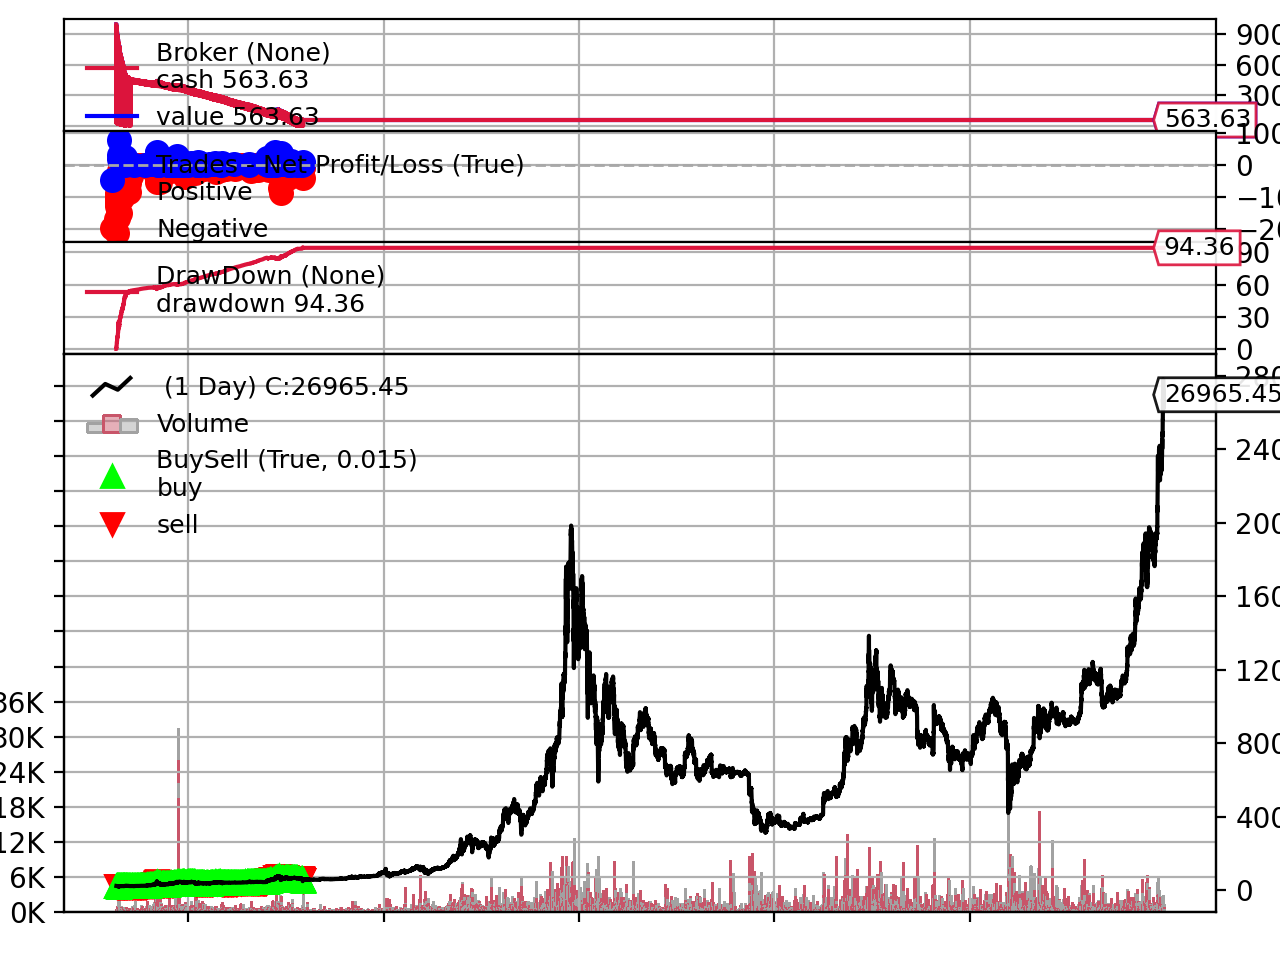

[[<Figure size 640x480 with 5 Axes>]]

In [25]:
cerebro.plot()